In [2]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [10]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)

np.random.shuffle(X_train.to_numpy()) #Randomly shuffle the training data for batching

train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

print("----------------Preprocessing the data-------------------")
X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

#Separating 15% of the training Data as Validation Dataset
X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))
print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
----------------Preprocessing the data-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [11]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()
print("--------------------Done----------------------------------")

--------Perform 1-hot encoding of class labels------------
--------------------Done----------------------------------


In [12]:
#Add the intercept term to the data samples both in training and test dataset
print("--------Adding the intercept term in the dataset as bias------------")
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))
print("-----------------------------Done----------------------------------")

--------Adding the intercept term in the dataset as bias------------
-----------------------------Done----------------------------------


In [16]:
#Mini-Batch formation

batch_size = 100 # Mini-Batch Size

print("----------------Forming mini-batches of size {}---------------------".format(batch_size))
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

----------------Forming mini-batches of size 100---------------------
The number of mini-batches formed is = 111


In [117]:
#Theta Initialization 

def theta_init(arch=[50], mode='normal'):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]
        if (mode=='normal'):
            theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        elif(mode=='random'):
            theta.append(2*np.random.random((dim0, dim1))-1)
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [44]:
# Sigmoid activation function
def activation(x):
    return 1/(1+np.exp(-x))

#ReLU Activation Function
def relu_act(x):
    return np.maximum(0.0, x)

#Derivative of ReLU activation Function
def deriv_relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [97]:
# Forward propagation

def forward_prop(data, theta, act_fn='sigmoid'):
    fm = []
    fm.append(data)
    if (act_fn == 'sigmoid'):
        for l in range(len(theta)):
            fm.append(activation(np.dot(fm[l], theta[l])))
    elif(act_fn == 'relu'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(relu_act(np.dot(fm[l], theta[l])))
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [98]:
# Backward propagation
def backward_prop(fm, Y_b, theta, batch_size, act_fn='sigmoid'):
    delta = [None]*len(fm)
    for l in range(len(fm)-1, 0, -1):
        if (l == len(fm)-1):
            delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
        else:
            if (act_fn == 'sigmoid'):
                delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))
            elif(act_fn == 'relu'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l])
    return delta

In [99]:
def cost_total(X, theta, Y, m, act_fn='sigmoid'):
    fm = forward_prop(X, theta, act_fn)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [143]:
def calc_accuracy(data, theta, actual_class, act_fn='sigmoid'):
    pred_class = forward_prop(data, theta, act_fn)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    return (test_acc*100)

## PART AB - One Hidden Layer Neural Network

In [101]:
lr = 0.1 # Fixed Learning rate
arch_test = [1,5,10,50,100] # Specifically for part a and b
arch = [50] #means one hidden layer with 50 perceptrons (DEFAULT)

r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [106]:
plt_epoch = []
plt_train_acc = []
plt_val_acc = []
plt_test_acc = []
costs= []


In [131]:
def training(mini_batch, X_valid, valid_class_enc, theta, lr, act_fn='sigmoid', lr_mode='constant'):
    lr0=lr
    epoch = 1 # Number of epochs
    early_stop=0 #Early stop count of iteration
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn)
    
    while(True):
        count_batch = 0
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))
        
        if(lr_mode == "adaptive"):
            lr = lr0/(np.power(epoch, 1/3))
            print("learning rate for this epoch = ", lr)
        
        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
        
            #Forward Propagation
            fm = forward_prop(X_b, theta, act_fn)
            
            if (count_batch % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size, act_fn)))

            #Backward Propagation
            delta = [None]*len(fm)
            delta = backward_prop(fm, Y_b, theta, batch_size, act_fn)

            #Theta Update
            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count_batch+=1

#         if epoch %10 == 0:
#                 costs.append(cost_init)
#         if (epoch % 200 == 0):
#             plt_epoch.append(epoch)
#             plt_train_acc.append(calc_accuracy(X_train, theta, train_class_enc))
#             plt_val_acc.append(calc_accuracy(X_valid, theta, valid_class_enc))
#             plt_test_acc.append(calc_accuracy(X_test, theta, test_actual_class_enc))

        epoch+=1 #Number of epochs
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn)
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        #Stopping criteria for sigmoid - when Validation loss stops decreasing beyond a threshold for 10 epochs
        if (act_fn =='sigmoid'):
            if (abs(cost_final-cost_init) < 1e-06):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 10):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        #Stopping criteria for relu - when Validation loss increases continuously for 30 epochs
        elif(act_fn=='relu'):
            if ((cost_final-cost_init) > 0):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 30):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        cost_init = cost_final
    return epoch, theta

In [122]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr=0.1

for i in range(len(arch_test)):
    #Choose between normal or random. Normal gives better results
    theta = theta_init([arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid')
    
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2602071696618875
Error on this batch = 3.260762333028255
Error on this batch = 3.182990613883103
Cost on val dataset after 2 epochs is = 2.5175990574696963
Initial Cost on Val dataset for this epoch 2 = 2.5175990574696963
Error on this batch = 2.521408793795217
Error on this batch = 1.5689884303583188
Cost on val dataset after 3 epochs is = 1.1509999295653208
Initial Cost on Val dataset for this epoch 3 = 1.1509999295653208
Error on this batch = 1.1442253674331047
Error on this batch = 0.9199338946818452
Cost on val dataset after 4 epochs is = 0.8082163441400501
Initial Cost on Val dataset for this epoch 4 = 0.8082163441400501
Error on this batch = 0.8044542765860309
Error on this batch = 0.7252080708577142
Cost on val dataset after 5 epochs is = 0.

Error on this batch = 0.4839269497176661
Cost on val dataset after 41 epochs is = 0.4842467200543434
Initial Cost on Val dataset for this epoch 41 = 0.4842467200543434
Error on this batch = 0.48374610175580823
Error on this batch = 0.4837523457263923
Cost on val dataset after 42 epochs is = 0.48406913554015013
Initial Cost on Val dataset for this epoch 42 = 0.48406913554015013
Error on this batch = 0.48357516954705954
Error on this batch = 0.4835899260645064
Cost on val dataset after 43 epochs is = 0.48390367110003524
Initial Cost on Val dataset for this epoch 43 = 0.48390367110003524
Error on this batch = 0.48341600703739956
Error on this batch = 0.48343863479809457
Cost on val dataset after 44 epochs is = 0.48374929302505754
Initial Cost on Val dataset for this epoch 44 = 0.48374929302505754
Error on this batch = 0.4832676045534106
Error on this batch = 0.483297527127352
Cost on val dataset after 45 epochs is = 0.4836050749077452
Initial Cost on Val dataset for this epoch 45 = 0.4836

Cost on val dataset after 81 epochs is = 0.4815058606495121
Initial Cost on Val dataset for this epoch 81 = 0.4815058606495121
Error on this batch = 0.4811278528117622
Error on this batch = 0.48126623818063663
Cost on val dataset after 82 epochs is = 0.48148565602978294
Initial Cost on Val dataset for this epoch 82 = 0.48148565602978294
Error on this batch = 0.4811088334432735
Error on this batch = 0.48124846049527364
Cost on val dataset after 83 epochs is = 0.48146631379161675
Initial Cost on Val dataset for this epoch 83 = 0.48146631379161675
Error on this batch = 0.48109063378285405
Error on this batch = 0.4812314693466964
Cost on val dataset after 84 epochs is = 0.481447791067733
Initial Cost on Val dataset for this epoch 84 = 0.481447791067733
Error on this batch = 0.4810732126630707
Error on this batch = 0.4812152251983703
Cost on val dataset after 85 epochs is = 0.4814300474758613
Initial Cost on Val dataset for this epoch 85 = 0.4814300474758613
Error on this batch = 0.48105653

Error on this batch = 0.4809218829198048
Cost on val dataset after 121 epochs is = 0.4810985119717693
Initial Cost on Val dataset for this epoch 121 = 0.4810985119717693
Error on this batch = 0.48074621442772375
Error on this batch = 0.48091832776512405
Cost on val dataset after 122 epochs is = 0.4810942149068039
Initial Cost on Val dataset for this epoch 122 = 0.4810942149068039
Error on this batch = 0.48074220581423827
Error on this batch = 0.48091490662635755
Cost on val dataset after 123 epochs is = 0.4810900642412282
Initial Cost on Val dataset for this epoch 123 = 0.4810900642412282
Error on this batch = 0.48073833358717316
Error on this batch = 0.48091161416675293
Cost on val dataset after 124 epochs is = 0.4810860543535744
Initial Cost on Val dataset for this epoch 124 = 0.4810860543535744
Error on this batch = 0.48073459245666755
Error on this batch = 0.480908445282648
Cost on val dataset after 125 epochs is = 0.4810821798632389
Initial Cost on Val dataset for this epoch 125 =

Cost on val dataset after 161 epochs is = 0.4810015152641109
Initial Cost on Val dataset for this epoch 161 = 0.4810015152641109
Error on this batch = 0.48065542076848367
Error on this batch = 0.48084634490775346
Cost on val dataset after 162 epochs is = 0.48100031249890385
Initial Cost on Val dataset for this epoch 162 = 0.48100031249890385
Error on this batch = 0.4806542834702781
Error on this batch = 0.4808455807006871
Cost on val dataset after 163 epochs is = 0.4809991440781975
Initial Cost on Val dataset for this epoch 163 = 0.4809991440781975
Error on this batch = 0.4806531780121553
Error on this batch = 0.4808448445366188
Cost on val dataset after 164 epochs is = 0.48099800886056276
Initial Cost on Val dataset for this epoch 164 = 0.48099800886056276
Error on this batch = 0.4806521033456828
Error on this batch = 0.4808441354150122
Cost on val dataset after 165 epochs is = 0.4809969057455628
Initial Cost on Val dataset for this epoch 165 = 0.4809969057455628
Error on this batch =

Error on this batch = 0.48112078526270263
Cost on val dataset after 21 epochs is = 0.4799198924550682
Initial Cost on Val dataset for this epoch 21 = 0.4799198924550682
Error on this batch = 0.4800866098743596
Error on this batch = 0.48089239210120066
Cost on val dataset after 22 epochs is = 0.4798020778474316
Initial Cost on Val dataset for this epoch 22 = 0.4798020778474316
Error on this batch = 0.48000836465862134
Error on this batch = 0.48068384321429514
Cost on val dataset after 23 epochs is = 0.47969443908489623
Initial Cost on Val dataset for this epoch 23 = 0.47969443908489623
Error on this batch = 0.4799393465326071
Error on this batch = 0.480491539101305
Cost on val dataset after 24 epochs is = 0.4795949246023383
Initial Cost on Val dataset for this epoch 24 = 0.4795949246023383
Error on this batch = 0.4798777434183449
Error on this batch = 0.48031262387835577
Cost on val dataset after 25 epochs is = 0.4795019226635021
Initial Cost on Val dataset for this epoch 25 = 0.4795019

Cost on val dataset after 60 epochs is = 0.4768481616086649
Initial Cost on Val dataset for this epoch 60 = 0.4768481616086649
Error on this batch = 0.4786012765501325
Error on this batch = 0.4756416520007339
Cost on val dataset after 61 epochs is = 0.476759605378084
Initial Cost on Val dataset for this epoch 61 = 0.476759605378084
Error on this batch = 0.478558844326616
Error on this batch = 0.4754947639915655
Cost on val dataset after 62 epochs is = 0.4766696783713938
Initial Cost on Val dataset for this epoch 62 = 0.4766696783713938
Error on this batch = 0.47851522879889047
Error on this batch = 0.4753455961881001
Cost on val dataset after 63 epochs is = 0.476578352721288
Initial Cost on Val dataset for this epoch 63 = 0.476578352721288
Error on this batch = 0.4784703886217889
Error on this batch = 0.4751941368681424
Cost on val dataset after 64 epochs is = 0.47648560393946965
Initial Cost on Val dataset for this epoch 64 = 0.47648560393946965
Error on this batch = 0.478424282791166

Cost on val dataset after 100 epochs is = 0.47222460229688124
Initial Cost on Val dataset for this epoch 100 = 0.47222460229688124
Error on this batch = 0.47572252216996463
Error on this batch = 0.4672597817373578
Cost on val dataset after 101 epochs is = 0.47208160817669736
Initial Cost on Val dataset for this epoch 101 = 0.47208160817669736
Error on this batch = 0.4756287528927953
Error on this batch = 0.4669452675705675
Cost on val dataset after 102 epochs is = 0.4719373463186111
Initial Cost on Val dataset for this epoch 102 = 0.4719373463186111
Error on this batch = 0.4755342168995567
Error on this batch = 0.4666250139468197
Cost on val dataset after 103 epochs is = 0.4717918696786827
Initial Cost on Val dataset for this epoch 103 = 0.4717918696786827
Error on this batch = 0.47543883415798815
Error on this batch = 0.46629927264434934
Cost on val dataset after 104 epochs is = 0.4716452383919084
Initial Cost on Val dataset for this epoch 104 = 0.4716452383919084
Error on this batch 

Cost on val dataset after 140 epochs is = 0.4657378458180582
Initial Cost on Val dataset for this epoch 140 = 0.4657378458180582
Error on this batch = 0.4714555262206073
Error on this batch = 0.45338747509067373
Cost on val dataset after 141 epochs is = 0.4655470622620874
Initial Cost on Val dataset for this epoch 141 = 0.4655470622620874
Error on this batch = 0.4713453188891029
Error on this batch = 0.4530437035627465
Cost on val dataset after 142 epochs is = 0.4653533281985743
Initial Cost on Val dataset for this epoch 142 = 0.4653533281985743
Error on this batch = 0.47123439711678383
Error on this batch = 0.45269250662199845
Cost on val dataset after 143 epochs is = 0.46515646467846083
Initial Cost on Val dataset for this epoch 143 = 0.46515646467846083
Error on this batch = 0.471122338008697
Error on this batch = 0.45233200207653257
Cost on val dataset after 144 epochs is = 0.46495634913626444
Initial Cost on Val dataset for this epoch 144 = 0.46495634913626444
Error on this batch 

Cost on val dataset after 180 epochs is = 0.4568899933669506
Initial Cost on Val dataset for this epoch 180 = 0.4568899933669506
Error on this batch = 0.46380265696499295
Error on this batch = 0.43901204530897703
Cost on val dataset after 181 epochs is = 0.4566793980480927
Initial Cost on Val dataset for this epoch 181 = 0.4566793980480927
Error on this batch = 0.46362162840575627
Error on this batch = 0.4387234958172691
Cost on val dataset after 182 epochs is = 0.4564702255871621
Initial Cost on Val dataset for this epoch 182 = 0.4564702255871621
Error on this batch = 0.46344208563095995
Error on this batch = 0.4384376990229086
Cost on val dataset after 183 epochs is = 0.45626242005182466
Initial Cost on Val dataset for this epoch 183 = 0.45626242005182466
Error on this batch = 0.46326402330562716
Error on this batch = 0.4381546705154262
Cost on val dataset after 184 epochs is = 0.4560559273981616
Initial Cost on Val dataset for this epoch 184 = 0.4560559273981616
Error on this batch 

Error on this batch = 0.42955511114156153
Cost on val dataset after 219 epochs is = 0.4494303973468167
Initial Cost on Val dataset for this epoch 219 = 0.4494303973468167
Error on this batch = 0.4578060725343038
Error on this batch = 0.42933287449961255
Cost on val dataset after 220 epochs is = 0.44925901318358474
Initial Cost on Val dataset for this epoch 220 = 0.44925901318358474
Error on this batch = 0.4576681285300312
Error on this batch = 0.4291123860321436
Cost on val dataset after 221 epochs is = 0.44908889419208675
Initial Cost on Val dataset for this epoch 221 = 0.44908889419208675
Error on this batch = 0.4575299805211433
Error on this batch = 0.4288938451808065
Cost on val dataset after 222 epochs is = 0.4489200370054647
Initial Cost on Val dataset for this epoch 222 = 0.4489200370054647
Error on this batch = 0.45739158915028555
Error on this batch = 0.42867745448384975
Cost on val dataset after 223 epochs is = 0.44875243282076166
Initial Cost on Val dataset for this epoch 22

Error on this batch = 0.4226988368902721
Cost on val dataset after 259 epochs is = 0.44340569046128964
Initial Cost on Val dataset for this epoch 259 = 0.44340569046128964
Error on this batch = 0.4521495290671519
Error on this batch = 0.42256610869489253
Cost on val dataset after 260 epochs is = 0.44327370174958874
Initial Cost on Val dataset for this epoch 260 = 0.44327370174958874
Error on this batch = 0.452013412929096
Error on this batch = 0.42243408091921086
Cost on val dataset after 261 epochs is = 0.443142545694385
Initial Cost on Val dataset for this epoch 261 = 0.443142545694385
Error on this batch = 0.4518783159022338
Error on this batch = 0.42230270579849205
Cost on val dataset after 262 epochs is = 0.4430122190846268
Initial Cost on Val dataset for this epoch 262 = 0.4430122190846268
Error on this batch = 0.4517442992271393
Error on this batch = 0.42217193940869613
Cost on val dataset after 263 epochs is = 0.4428827185459131
Initial Cost on Val dataset for this epoch 263 = 

Error on this batch = 0.417717188863205
Cost on val dataset after 299 epochs is = 0.4387290537121619
Initial Cost on Val dataset for this epoch 299 = 0.4387290537121619
Error on this batch = 0.4478654468752929
Error on this batch = 0.4176009996649211
Cost on val dataset after 300 epochs is = 0.43862639957868893
Initial Cost on Val dataset for this epoch 300 = 0.43862639957868893
Error on this batch = 0.4477906137862216
Error on this batch = 0.4174854379673002
Cost on val dataset after 301 epochs is = 0.4385243571566327
Initial Cost on Val dataset for this epoch 301 = 0.4385243571566327
Error on this batch = 0.44771707194039534
Error on this batch = 0.41737052652174184
Cost on val dataset after 302 epochs is = 0.43842292125561744
Initial Cost on Val dataset for this epoch 302 = 0.43842292125561744
Error on this batch = 0.44764478691371645
Error on this batch = 0.4172562871884118
Cost on val dataset after 303 epochs is = 0.43832208680493984
Initial Cost on Val dataset for this epoch 303 

Error on this batch = 0.4136507063264177
Cost on val dataset after 339 epochs is = 0.43505643615294826
Initial Cost on Val dataset for this epoch 339 = 0.43505643615294826
Error on this batch = 0.4456035158840171
Error on this batch = 0.4135631117368022
Cost on val dataset after 340 epochs is = 0.4349749412314403
Initial Cost on Val dataset for this epoch 340 = 0.4349749412314403
Error on this batch = 0.44556094400551827
Error on this batch = 0.4134760084263804
Cost on val dataset after 341 epochs is = 0.4348938975934231
Initial Cost on Val dataset for this epoch 341 = 0.4348938975934231
Error on this batch = 0.44551889795821487
Error on this batch = 0.4133893789594832
Cost on val dataset after 342 epochs is = 0.43481330153380265
Initial Cost on Val dataset for this epoch 342 = 0.43481330153380265
Error on this batch = 0.44547737185564146
Error on this batch = 0.41330320603461757
Cost on val dataset after 343 epochs is = 0.43473314934787805
Initial Cost on Val dataset for this epoch 34

Error on this batch = 0.41045673426208645
Cost on val dataset after 378 epochs is = 0.4321789658013833
Initial Cost on Val dataset for this epoch 378 = 0.4321789658013833
Error on this batch = 0.4442802987381406
Error on this batch = 0.41037742843549824
Cost on val dataset after 379 epochs is = 0.43211235779401935
Initial Cost on Val dataset for this epoch 379 = 0.43211235779401935
Error on this batch = 0.44425382942008923
Error on this batch = 0.41029811042733677
Cost on val dataset after 380 epochs is = 0.432046058883917
Initial Cost on Val dataset for this epoch 380 = 0.432046058883917
Error on this batch = 0.44422763493122147
Error on this batch = 0.41021877279282387
Cost on val dataset after 381 epochs is = 0.4319800654158898
Initial Cost on Val dataset for this epoch 381 = 0.4319800654158898
Error on this batch = 0.44420170718943114
Error on this batch = 0.4101394083570956
Cost on val dataset after 382 epochs is = 0.43191437372680846
Initial Cost on Val dataset for this epoch 382

Error on this batch = 0.40722246168840387
Cost on val dataset after 418 epochs is = 0.4297191560425166
Initial Cost on Val dataset for this epoch 418 = 0.4297191560425166
Error on this batch = 0.4433586745907377
Error on this batch = 0.40713904325547307
Cost on val dataset after 419 epochs is = 0.4296620347971752
Initial Cost on Val dataset for this epoch 419 = 0.4296620347971752
Error on this batch = 0.44333756399843866
Error on this batch = 0.40705548102306977
Cost on val dataset after 420 epochs is = 0.42960507846895196
Initial Cost on Val dataset for this epoch 420 = 0.42960507846895196
Error on this batch = 0.44331651383287435
Error on this batch = 0.4069717766220221
Cost on val dataset after 421 epochs is = 0.4295482840374818
Initial Cost on Val dataset for this epoch 421 = 0.4295482840374818
Error on this batch = 0.4432955276051766
Error on this batch = 0.4068879321142464
Cost on val dataset after 422 epochs is = 0.4294916485537892
Initial Cost on Val dataset for this epoch 422 

Cost on val dataset after 457 epochs is = 0.4275971081813778
Initial Cost on Val dataset for this epoch 457 = 0.4275971081813778
Error on this batch = 0.4426382327728422
Error on this batch = 0.40383023951788644
Cost on val dataset after 458 epochs is = 0.4275455871787668
Initial Cost on Val dataset for this epoch 458 = 0.4275455871787668
Error on this batch = 0.442623883062454
Error on this batch = 0.4037462897634399
Cost on val dataset after 459 epochs is = 0.42749424519820056
Initial Cost on Val dataset for this epoch 459 = 0.42749424519820056
Error on this batch = 0.44260974366703876
Error on this batch = 0.4036624941094752
Cost on val dataset after 460 epochs is = 0.4274430864597419
Initial Cost on Val dataset for this epoch 460 = 0.4274430864597419
Error on this batch = 0.442595808801608
Error on this batch = 0.40357885622264744
Cost on val dataset after 461 epochs is = 0.42739211509801983
Initial Cost on Val dataset for this epoch 461 = 0.42739211509801983
Error on this batch = 

Cost on val dataset after 497 epochs is = 0.4256927385272224
Initial Cost on Val dataset for this epoch 497 = 0.4256927385272224
Error on this batch = 0.44218188148519233
Error on this batch = 0.4005667570125899
Cost on val dataset after 498 epochs is = 0.42564889791141397
Initial Cost on Val dataset for this epoch 498 = 0.42564889791141397
Error on this batch = 0.44217343079494004
Error on this batch = 0.40048477917605935
Cost on val dataset after 499 epochs is = 0.42560519203901676
Initial Cost on Val dataset for this epoch 499 = 0.42560519203901676
Error on this batch = 0.44216519968720674
Error on this batch = 0.40040251047127473
Cost on val dataset after 500 epochs is = 0.425561616312715
Initial Cost on Val dataset for this epoch 500 = 0.425561616312715
Error on this batch = 0.44215719947422044
Error on this batch = 0.4003199252207066
Cost on val dataset after 501 epochs is = 0.42551816610786125
Initial Cost on Val dataset for this epoch 501 = 0.42551816610786125
Error on this bat

Error on this batch = 0.39704172049177866
Cost on val dataset after 537 epochs is = 0.42398901929316113
Initial Cost on Val dataset for this epoch 537 = 0.42398901929316113
Error on this batch = 0.4421429299874386
Error on this batch = 0.39694251578431117
Cost on val dataset after 538 epochs is = 0.4239456547201504
Initial Cost on Val dataset for this epoch 538 = 0.4239456547201504
Error on this batch = 0.4421525925925872
Error on this batch = 0.3968428834197708
Cost on val dataset after 539 epochs is = 0.4239021213310137
Initial Cost on Val dataset for this epoch 539 = 0.4239021213310137
Error on this batch = 0.4421627574926346
Error on this batch = 0.39674282584544307
Cost on val dataset after 540 epochs is = 0.423858412801597
Initial Cost on Val dataset for this epoch 540 = 0.423858412801597
Error on this batch = 0.4421733975570012
Error on this batch = 0.39664234994156744
Cost on val dataset after 541 epochs is = 0.42381452411810966
Initial Cost on Val dataset for this epoch 541 = 

Error on this batch = 0.3931391491195695
Cost on val dataset after 577 epochs is = 0.42215976162278035
Initial Cost on Val dataset for this epoch 577 = 0.42215976162278035
Error on this batch = 0.44250639228016836
Error on this batch = 0.3930563716490108
Cost on val dataset after 578 epochs is = 0.4221135756029998
Initial Cost on Val dataset for this epoch 578 = 0.4221135756029998
Error on this batch = 0.44250445491048984
Error on this batch = 0.3929746647767071
Cost on val dataset after 579 epochs is = 0.4220674349106906
Initial Cost on Val dataset for this epoch 579 = 0.4220674349106906
Error on this batch = 0.4425016452539747
Error on this batch = 0.39289402258450523
Cost on val dataset after 580 epochs is = 0.4220213389340297
Initial Cost on Val dataset for this epoch 580 = 0.4220213389340297
Error on this batch = 0.4424979548339891
Error on this batch = 0.3928144377410884
Cost on val dataset after 581 epochs is = 0.42197528667999096
Initial Cost on Val dataset for this epoch 581 =

Error on this batch = 0.39055486015724084
Cost on val dataset after 617 epochs is = 0.42033028549668155
Initial Cost on Val dataset for this epoch 617 = 0.42033028549668155
Error on this batch = 0.44183759737519523
Error on this batch = 0.3905057922080652
Cost on val dataset after 618 epochs is = 0.4202847750433642
Initial Cost on Val dataset for this epoch 618 = 0.4202847750433642
Error on this batch = 0.441812914968708
Error on this batch = 0.3904572686058397
Cost on val dataset after 619 epochs is = 0.42023929197528886
Initial Cost on Val dataset for this epoch 619 = 0.42023929197528886
Error on this batch = 0.4417883732113947
Error on this batch = 0.39040927111691076
Cost on val dataset after 620 epochs is = 0.4201938394549627
Initial Cost on Val dataset for this epoch 620 = 0.4201938394549627
Error on this batch = 0.4417640005913316
Error on this batch = 0.39036178133229543
Cost on val dataset after 621 epochs is = 0.42014842069745084
Initial Cost on Val dataset for this epoch 621

Error on this batch = 0.3888483230150488
Cost on val dataset after 657 epochs is = 0.41855760025506367
Initial Cost on Val dataset for this epoch 657 = 0.41855760025506367
Error on this batch = 0.4410213816665652
Error on this batch = 0.38880881850695176
Cost on val dataset after 658 epochs is = 0.41851498498858286
Initial Cost on Val dataset for this epoch 658 = 0.41851498498858286
Error on this batch = 0.44100317993701127
Error on this batch = 0.3887693663036195
Cost on val dataset after 659 epochs is = 0.41847245994572474
Initial Cost on Val dataset for this epoch 659 = 0.41847245994572474
Error on this batch = 0.4409848954224054
Error on this batch = 0.38872996500709356
Cost on val dataset after 660 epochs is = 0.41843002472297286
Initial Cost on Val dataset for this epoch 660 = 0.41843002472297286
Error on this batch = 0.44096651698292844
Error on this batch = 0.3886906135787102
Cost on val dataset after 661 epochs is = 0.41838767885446876
Initial Cost on Val dataset for this epoc

Error on this batch = 0.38731444463743286
Cost on val dataset after 697 epochs is = 0.41691307067324535
Initial Cost on Val dataset for this epoch 697 = 0.41691307067324535
Error on this batch = 0.4401572678973521
Error on this batch = 0.38727777658536044
Cost on val dataset after 698 epochs is = 0.4168730560918287
Initial Cost on Val dataset for this epoch 698 = 0.4168730560918287
Error on this batch = 0.4401309091763923
Error on this batch = 0.3872412231904705
Cost on val dataset after 699 epochs is = 0.41683306119865177
Initial Cost on Val dataset for this epoch 699 = 0.41683306119865177
Error on this batch = 0.44010428828537285
Error on this batch = 0.3872047870833896
Cost on val dataset after 700 epochs is = 0.4167930832199213
Initial Cost on Val dataset for this epoch 700 = 0.4167930832199213
Error on this batch = 0.44007740498194514
Error on this batch = 0.3871684708675529
Cost on val dataset after 701 epochs is = 0.4167531194112257
Initial Cost on Val dataset for this epoch 701

Error on this batch = 0.38595347745927105
Cost on val dataset after 737 epochs is = 0.415307932192994
Initial Cost on Val dataset for this epoch 737 = 0.415307932192994
Error on this batch = 0.4389135412740582
Error on this batch = 0.3859222691918411
Cost on val dataset after 738 epochs is = 0.41526741446491905
Initial Cost on Val dataset for this epoch 738 = 0.41526741446491905
Error on this batch = 0.43887828409082885
Error on this batch = 0.38589117808807955
Cost on val dataset after 739 epochs is = 0.41522687762177823
Initial Cost on Val dataset for this epoch 739 = 0.41522687762177823
Error on this batch = 0.438842876286856
Error on this batch = 0.3858602016119948
Cost on val dataset after 740 epochs is = 0.4151863223489534
Initial Cost on Val dataset for this epoch 740 = 0.4151863223489534
Error on this batch = 0.43880732156613794
Error on this batch = 0.38582933719371965
Cost on val dataset after 741 epochs is = 0.4151457493757675
Initial Cost on Val dataset for this epoch 741 =

Error on this batch = 0.3847675917972719
Cost on val dataset after 777 epochs is = 0.4136870762997859
Initial Cost on Val dataset for this epoch 777 = 0.4136870762997859
Error on this batch = 0.43741615550565427
Error on this batch = 0.38473861285675176
Cost on val dataset after 778 epochs is = 0.41364731956655415
Initial Cost on Val dataset for this epoch 778 = 0.41364731956655415
Error on this batch = 0.43737714834846314
Error on this batch = 0.3847096063120548
Cost on val dataset after 779 epochs is = 0.4136076614906659
Initial Cost on Val dataset for this epoch 779 = 0.4136076614906659
Error on this batch = 0.43733810101802906
Error on this batch = 0.3846805675365247
Cost on val dataset after 780 epochs is = 0.41356810754464984
Initial Cost on Val dataset for this epoch 780 = 0.41356810754464984
Error on this batch = 0.4372990167716735
Error on this batch = 0.38465149199375076
Cost on val dataset after 781 epochs is = 0.41352866315255066
Initial Cost on Val dataset for this epoch 7

Error on this batch = 0.3835596296778745
Cost on val dataset after 817 epochs is = 0.4122121279912963
Initial Cost on Val dataset for this epoch 817 = 0.4122121279912963
Error on this batch = 0.4358622219357001
Error on this batch = 0.38352803991174655
Cost on val dataset after 818 epochs is = 0.4121787548522502
Initial Cost on Val dataset for this epoch 818 = 0.4121787548522502
Error on this batch = 0.4358245516873268
Error on this batch = 0.3834964058258384
Cost on val dataset after 819 epochs is = 0.41214554792490743
Initial Cost on Val dataset for this epoch 819 = 0.41214554792490743
Error on this batch = 0.4357869804637391
Error on this batch = 0.38346473020345273
Cost on val dataset after 820 epochs is = 0.4121125055045033
Initial Cost on Val dataset for this epoch 820 = 0.4121125055045033
Error on this batch = 0.4357495102437954
Error on this batch = 0.38343301581610134
Cost on val dataset after 821 epochs is = 0.4120796258400989
Initial Cost on Val dataset for this epoch 821 = 

Error on this batch = 0.38228466599627375
Cost on val dataset after 857 epochs is = 0.4109888518387282
Initial Cost on Val dataset for this epoch 857 = 0.4109888518387282
Error on this batch = 0.4344488444910154
Error on this batch = 0.38225296571234013
Cost on val dataset after 858 epochs is = 0.4109607381008538
Initial Cost on Val dataset for this epoch 858 = 0.4109607381008538
Error on this batch = 0.4344163531602976
Error on this batch = 0.3822212885428029
Cost on val dataset after 859 epochs is = 0.4109327250513028
Initial Cost on Val dataset for this epoch 859 = 0.4109327250513028
Error on this batch = 0.43438401643671515
Error on this batch = 0.38218963486908436
Cost on val dataset after 860 epochs is = 0.4109048116979152
Initial Cost on Val dataset for this epoch 860 = 0.4109048116979152
Error on this batch = 0.43435183495839796
Error on this batch = 0.38215800502115665
Cost on val dataset after 861 epochs is = 0.41087699708743947
Initial Cost on Val dataset for this epoch 861 

Error on this batch = 0.3810347073767567
Cost on val dataset after 897 epochs is = 0.40993571227600917
Initial Cost on Val dataset for this epoch 897 = 0.40993571227600917
Error on this batch = 0.433269669630305
Error on this batch = 0.38100385249893165
Cost on val dataset after 898 epochs is = 0.40991111545857983
Initial Cost on Val dataset for this epoch 898 = 0.40991111545857983
Error on this batch = 0.4332431829201038
Error on this batch = 0.38097300990627875
Cost on val dataset after 899 epochs is = 0.40988659727242316
Initial Cost on Val dataset for this epoch 899 = 0.40988659727242316
Error on this batch = 0.4332168258959648
Error on this batch = 0.38094217900943905
Cost on val dataset after 900 epochs is = 0.4098621573516671
Initial Cost on Val dataset for this epoch 900 = 0.4098621573516671
Error on this batch = 0.4331905970214974
Error on this batch = 0.38091135922117647
Cost on val dataset after 901 epochs is = 0.40983779533112336
Initial Cost on Val dataset for this epoch 9

Error on this batch = 0.3798050288352907
Cost on val dataset after 937 epochs is = 0.4090095296990869
Initial Cost on Val dataset for this epoch 937 = 0.4090095296990869
Error on this batch = 0.43229580455566663
Error on this batch = 0.3797743000066845
Cost on val dataset after 938 epochs is = 0.40898778870523167
Initial Cost on Val dataset for this epoch 938 = 0.40898778870523167
Error on this batch = 0.43227329032553513
Error on this batch = 0.37974356871279724
Cost on val dataset after 939 epochs is = 0.4089661113283037
Initial Cost on Val dataset for this epoch 939 = 0.4089661113283037
Error on this batch = 0.43225084564812477
Error on this batch = 0.379712834919347
Cost on val dataset after 940 epochs is = 0.40894449718809184
Initial Cost on Val dataset for this epoch 940 = 0.40894449718809184
Error on this batch = 0.43222846925619374
Error on this batch = 0.37968209860937463
Cost on val dataset after 941 epochs is = 0.40892294590559564
Initial Cost on Val dataset for this epoch 9

Cost on val dataset after 976 epochs is = 0.40820548576304755
Initial Cost on Val dataset for this epoch 976 = 0.40820548576304755
Error on this batch = 0.43145878521346087
Error on this batch = 0.37857504913874357
Cost on val dataset after 977 epochs is = 0.4081859676831227
Initial Cost on Val dataset for this epoch 977 = 0.4081859676831227
Error on this batch = 0.43143816080403474
Error on this batch = 0.3785443444386538
Cost on val dataset after 978 epochs is = 0.40816650061422677
Initial Cost on Val dataset for this epoch 978 = 0.40816650061422677
Error on this batch = 0.4314175655087597
Error on this batch = 0.37851364690803835
Cost on val dataset after 979 epochs is = 0.4081470843192543
Initial Cost on Val dataset for this epoch 979 = 0.4081470843192543
Error on this batch = 0.431396998493436
Error on this batch = 0.3784829569890971
Cost on val dataset after 980 epochs is = 0.40812771856579355
Initial Cost on Val dataset for this epoch 980 = 0.40812771856579355
Error on this batc

Cost on val dataset after 1015 epochs is = 0.4074802373479218
Initial Cost on Val dataset for this epoch 1015 = 0.4074802373479218
Error on this batch = 0.43066917997615123
Error on this batch = 0.3773870987776404
Cost on val dataset after 1016 epochs is = 0.4074625664224383
Initial Cost on Val dataset for this epoch 1016 = 0.4074625664224383
Error on this batch = 0.43064916306840273
Error on this batch = 0.37735701498122537
Cost on val dataset after 1017 epochs is = 0.40744493958695177
Initial Cost on Val dataset for this epoch 1017 = 0.40744493958695177
Error on this batch = 0.430629150279662
Error on this batch = 0.3773269558884821
Cost on val dataset after 1018 epochs is = 0.40742735668324404
Initial Cost on Val dataset for this epoch 1018 = 0.40742735668324404
Error on this batch = 0.4306091411951924
Error on this batch = 0.37729692187655217
Cost on val dataset after 1019 epochs is = 0.4074098175516128
Initial Cost on Val dataset for this epoch 1019 = 0.4074098175516128
Error on t

Cost on val dataset after 1055 epochs is = 0.40680602267422056
Initial Cost on Val dataset for this epoch 1055 = 0.40680602267422056
Error on this batch = 0.4298686964468534
Error on this batch = 0.3762060317016668
Cost on val dataset after 1056 epochs is = 0.40678996888745994
Initial Cost on Val dataset for this epoch 1056 = 0.40678996888745994
Error on this batch = 0.4298486355541705
Error on this batch = 0.37617715252310285
Cost on val dataset after 1057 epochs is = 0.40677395099768043
Initial Cost on Val dataset for this epoch 1057 = 0.40677395099768043
Error on this batch = 0.42982857097636035
Error on this batch = 0.37614830695424334
Cost on val dataset after 1058 epochs is = 0.4067579687583384
Initial Cost on Val dataset for this epoch 1058 = 0.4067579687583384
Error on this batch = 0.4298085027148807
Error on this batch = 0.3761194950619067
Cost on val dataset after 1059 epochs is = 0.4067420219226275
Initial Cost on Val dataset for this epoch 1059 = 0.4067420219226275
Error on

Cost on val dataset after 1095 epochs is = 0.4061895450002288
Initial Cost on Val dataset for this epoch 1095 = 0.4061895450002288
Error on this batch = 0.4290639180434556
Error on this batch = 0.3750773393471443
Cost on val dataset after 1096 epochs is = 0.40617475039296264
Initial Cost on Val dataset for this epoch 1096 = 0.40617475039296264
Error on this batch = 0.42904376268361033
Error on this batch = 0.37504981786285646
Cost on val dataset after 1097 epochs is = 0.40615998349903076
Initial Cost on Val dataset for this epoch 1097 = 0.40615998349903076
Error on this batch = 0.42902360725591343
Error on this batch = 0.375022330188936
Cost on val dataset after 1098 epochs is = 0.40614524419627285
Initial Cost on Val dataset for this epoch 1098 = 0.40614524419627285
Error on this batch = 0.4290034518921504
Error on this batch = 0.37499487632442047
Cost on val dataset after 1099 epochs is = 0.4061305323674887
Initial Cost on Val dataset for this epoch 1099 = 0.4061305323674887
Error on

Cost on val dataset after 1135 epochs is = 0.4056186002484996
Initial Cost on Val dataset for this epoch 1135 = 0.4056186002484996
Error on this batch = 0.4282588387906157
Error on this batch = 0.3740031223525242
Cost on val dataset after 1136 epochs is = 0.4056048643022539
Initial Cost on Val dataset for this epoch 1136 = 0.4056048643022539
Error on this batch = 0.4282387689093969
Error on this batch = 0.3739769839289916
Cost on val dataset after 1137 epochs is = 0.40559115461140666
Initial Cost on Val dataset for this epoch 1137 = 0.40559115461140666
Error on this batch = 0.4282187028014232
Error on this batch = 0.3739508818552369
Cost on val dataset after 1138 epochs is = 0.40557747121175314
Initial Cost on Val dataset for this epoch 1138 = 0.40557747121175314
Error on this batch = 0.42819864050059986
Error on this batch = 0.37392481626486884
Cost on val dataset after 1139 epochs is = 0.4055638141415146
Initial Cost on Val dataset for this epoch 1139 = 0.4055638141415146
Error on th

Cost on val dataset after 1175 epochs is = 0.40509014243309077
Initial Cost on Val dataset for this epoch 1175 = 0.40509014243309077
Error on this batch = 0.42745903513837563
Error on this batch = 0.37298741621643416
Cost on val dataset after 1176 epochs is = 0.40507749760278383
Initial Cost on Val dataset for this epoch 1176 = 0.40507749760278383
Error on this batch = 0.42743911451287786
Error on this batch = 0.3729628505308548
Cost on val dataset after 1177 epochs is = 0.4050648810492934
Initial Cost on Val dataset for this epoch 1177 = 0.4050648810492934
Error on this batch = 0.42741919725876143
Error on this batch = 0.3729383273611606
Cost on val dataset after 1178 epochs is = 0.4050522927856065
Initial Cost on Val dataset for this epoch 1178 = 0.4050522927856065
Error on this batch = 0.42739928338075395
Error on this batch = 0.3729138468518295
Cost on val dataset after 1179 epochs is = 0.40503973281902744
Initial Cost on Val dataset for this epoch 1179 = 0.40503973281902744
Error 

Cost on val dataset after 1215 epochs is = 0.4046058105338189
Initial Cost on Val dataset for this epoch 1215 = 0.4046058105338189
Error on this batch = 0.4266656823218473
Error on this batch = 0.37203920453754036
Cost on val dataset after 1216 epochs is = 0.4045942250618304
Initial Cost on Val dataset for this epoch 1216 = 0.4045942250618304
Error on this batch = 0.4266459930742178
Error on this batch = 0.3720164331641574
Cost on val dataset after 1217 epochs is = 0.4045826616940348
Initial Cost on Val dataset for this epoch 1217 = 0.4045826616940348
Error on this batch = 0.4266263153687288
Error on this batch = 0.37199370857657366
Cost on val dataset after 1218 epochs is = 0.4045711201220557
Initial Cost on Val dataset for this epoch 1218 = 0.4045711201220557
Error on this batch = 0.4266066496395432
Error on this batch = 0.37197103084331135
Cost on val dataset after 1219 epochs is = 0.40455960003728647
Initial Cost on Val dataset for this epoch 1219 = 0.40455960003728647
Error on thi

Cost on val dataset after 1255 epochs is = 0.40415704004111447
Initial Cost on Val dataset for this epoch 1255 = 0.40415704004111447
Error on this batch = 0.4258912751643085
Error on this batch = 0.37116538166843904
Cost on val dataset after 1256 epochs is = 0.40414615593294784
Initial Cost on Val dataset for this epoch 1256 = 0.40414615593294784
Error on this batch = 0.42587235989363337
Error on this batch = 0.3711445204015923
Cost on val dataset after 1257 epochs is = 0.4041352869038713
Initial Cost on Val dataset for this epoch 1257 = 0.4041352869038713
Error on this batch = 0.4258534703273692
Error on this batch = 0.3711237075065185
Cost on val dataset after 1258 epochs is = 0.40412443294084033
Initial Cost on Val dataset for this epoch 1258 = 0.40412443294084033
Error on this batch = 0.42583460669488093
Error on this batch = 0.3711029429928936
Cost on val dataset after 1259 epochs is = 0.40411359403467084
Initial Cost on Val dataset for this epoch 1259 = 0.40411359403467084
Error 

Cost on val dataset after 1295 epochs is = 0.40373345519282394
Initial Cost on Val dataset for this epoch 1295 = 0.40373345519282394
Error on this batch = 0.42515711366889447
Error on this batch = 0.37036860851902403
Cost on val dataset after 1296 epochs is = 0.40372317563539956
Initial Cost on Val dataset for this epoch 1296 = 0.40372317563539956
Error on this batch = 0.42513941989888737
Error on this batch = 0.3703496734245559
Cost on val dataset after 1297 epochs is = 0.40371291108957474
Initial Cost on Val dataset for this epoch 1297 = 0.40371291108957474
Error on this batch = 0.4251217618751499
Error on this batch = 0.3703307857790445
Cost on val dataset after 1298 epochs is = 0.4037026615328763
Initial Cost on Val dataset for this epoch 1298 = 0.4037026615328763
Error on this batch = 0.42510413981172646
Error on this batch = 0.37031194552308705
Cost on val dataset after 1299 epochs is = 0.4036924269415449
Initial Cost on Val dataset for this epoch 1299 = 0.4036924269415449
Error 

Cost on val dataset after 1335 epochs is = 0.403333662017412
Initial Cost on Val dataset for this epoch 1335 = 0.403333662017412
Error on this batch = 0.4244785752523642
Error on this batch = 0.3696474842336724
Cost on val dataset after 1336 epochs is = 0.403323955335734
Initial Cost on Val dataset for this epoch 1336 = 0.403323955335734
Error on this batch = 0.424462392403385
Error on this batch = 0.3696303857274413
Cost on val dataset after 1337 epochs is = 0.40331426203584786
Initial Cost on Val dataset for this epoch 1337 = 0.40331426203584786
Error on this batch = 0.42444624707881856
Error on this batch = 0.3696133311774446
Cost on val dataset after 1338 epochs is = 0.4033045820635103
Initial Cost on Val dataset for this epoch 1338 = 0.4033045820635103
Error on this batch = 0.42443013916265687
Error on this batch = 0.3695963204746836
Cost on val dataset after 1339 epochs is = 0.40329491536403966
Initial Cost on Val dataset for this epoch 1339 = 0.40329491536403966
Error on this ba

Cost on val dataset after 1375 epochs is = 0.4029552675781264
Initial Cost on Val dataset for this epoch 1375 = 0.4029552675781264
Error on this batch = 0.4238590416180007
Error on this batch = 0.3689967177759684
Cost on val dataset after 1376 epochs is = 0.4029460511097259
Initial Cost on Val dataset for this epoch 1376 = 0.4029460511097259
Error on this batch = 0.4238442357038409
Error on this batch = 0.36898128934723934
Cost on val dataset after 1377 epochs is = 0.4029368456909957
Initial Cost on Val dataset for this epoch 1377 = 0.4029368456909957
Error on this batch = 0.42382946043968966
Error on this batch = 0.36896590034937454
Cost on val dataset after 1378 epochs is = 0.4029276512654262
Initial Cost on Val dataset for this epoch 1378 = 0.4029276512654262
Error on this batch = 0.4238147156310738
Error on this batch = 0.36895055067309473
Cost on val dataset after 1379 epochs is = 0.4029184677769602
Initial Cost on Val dataset for this epoch 1379 = 0.4029184677769602
Error on this

Cost on val dataset after 1415 epochs is = 0.40259473080926006
Initial Cost on Val dataset for this epoch 1415 = 0.40259473080926006
Error on this batch = 0.42328879919551826
Error on this batch = 0.3684093171397392
Cost on val dataset after 1416 epochs is = 0.4025859195445968
Initial Cost on Val dataset for this epoch 1416 = 0.4025859195445968
Error on this batch = 0.42327506862428627
Error on this batch = 0.3683953873963317
Cost on val dataset after 1417 epochs is = 0.40257711772994864
Initial Cost on Val dataset for this epoch 1417 = 0.40257711772994864
Error on this batch = 0.4232613610123572
Error on this batch = 0.36838149325822095
Cost on val dataset after 1418 epochs is = 0.40256832535137316
Initial Cost on Val dataset for this epoch 1418 = 0.40256832535137316
Error on this batch = 0.4232476761696914
Error on this batch = 0.3683676346447327
Cost on val dataset after 1419 epochs is = 0.402559542396623
Initial Cost on Val dataset for this epoch 1419 = 0.402559542396623
Error on t

Cost on val dataset after 1455 epochs is = 0.40224967951490925
Initial Cost on Val dataset for this epoch 1455 = 0.40224967951490925
Error on this batch = 0.42275561997151884
Error on this batch = 0.3678791412216044
Cost on val dataset after 1456 epochs is = 0.402241253439365
Initial Cost on Val dataset for this epoch 1456 = 0.402241253439365
Error on this batch = 0.4227426613293321
Error on this batch = 0.3678665763566195
Cost on val dataset after 1457 epochs is = 0.40223283768000884
Initial Cost on Val dataset for this epoch 1457 = 0.40223283768000884
Error on this batch = 0.42272971824763284
Error on this batch = 0.36785404407339023
Cost on val dataset after 1458 epochs is = 0.4022244322927707
Initial Cost on Val dataset for this epoch 1458 = 0.4022244322927707
Error on this batch = 0.42271679055466654
Error on this batch = 0.3678415442934962
Cost on val dataset after 1459 epochs is = 0.4022160373346884
Initial Cost on Val dataset for this epoch 1459 = 0.4022160373346884
Error on th

Error on this batch = 0.36741249950354365
Cost on val dataset after 1495 epochs is = 0.4019212798471323
Initial Cost on Val dataset for this epoch 1495 = 0.4019212798471323
Error on this batch = 0.4222478533011236
Error on this batch = 0.36740114331579377
Cost on val dataset after 1496 epochs is = 0.4019133129177382
Initial Cost on Val dataset for this epoch 1496 = 0.4019133129177382
Error on this batch = 0.42223539874232663
Error on this batch = 0.3673898164013163
Cost on val dataset after 1497 epochs is = 0.4019053585199585
Initial Cost on Val dataset for this epoch 1497 = 0.4019053585199585
Error on this batch = 0.4222229541737562
Error on this batch = 0.3673785186779561
Cost on val dataset after 1498 epochs is = 0.40189741668419743
Initial Cost on Val dataset for this epoch 1498 = 0.40189741668419743
Error on this batch = 0.42221051949421146
Error on this batch = 0.3673672500644332
Cost on val dataset after 1499 epochs is = 0.4018894874386808
Initial Cost on Val dataset for this ep

Error on this batch = 0.3669803823517315
Cost on val dataset after 1535 epochs is = 0.40161248065702954
Initial Cost on Val dataset for this epoch 1535 = 0.40161248065702954
Error on this batch = 0.4217565922841797
Error on this batch = 0.366970145252758
Cost on val dataset after 1536 epochs is = 0.4016050180052843
Initial Cost on Val dataset for this epoch 1536 = 0.4016050180052843
Error on this batch = 0.421744471696895
Error on this batch = 0.3669599351391037
Cost on val dataset after 1537 epochs is = 0.4015975675706901
Initial Cost on Val dataset for this epoch 1537 = 0.4015975675706901
Error on this batch = 0.42173235803555387
Error on this batch = 0.3669497519785385
Cost on val dataset after 1538 epochs is = 0.40159012931873334
Initial Cost on Val dataset for this epoch 1538 = 0.40159012931873334
Error on this batch = 0.4217202512456239
Error on this batch = 0.3669395957394443
Cost on val dataset after 1539 epochs is = 0.4015827032145096
Initial Cost on Val dataset for this epoch

Cost on val dataset after 1575 epochs is = 0.4013231550609788
Initial Cost on Val dataset for this epoch 1575 = 0.4013231550609788
Error on this batch = 0.4212767878508533
Error on this batch = 0.36658245478699897
Cost on val dataset after 1576 epochs is = 0.40131615381065394
Initial Cost on Val dataset for this epoch 1576 = 0.40131615381065394
Error on this batch = 0.4212649196084534
Error on this batch = 0.3665732972894722
Cost on val dataset after 1577 epochs is = 0.4013091634124868
Initial Cost on Val dataset for this epoch 1577 = 0.4013091634124868
Error on this batch = 0.4212530576394549
Error on this batch = 0.3665641652802616
Cost on val dataset after 1578 epochs is = 0.40130218383445965
Initial Cost on Val dataset for this epoch 1578 = 0.40130218383445965
Error on this batch = 0.4212412019772334
Error on this batch = 0.36655505870745536
Cost on val dataset after 1579 epochs is = 0.40129521504445104
Initial Cost on Val dataset for this epoch 1579 = 0.40129521504445104
Error on 

Cost on val dataset after 1615 epochs is = 0.4010512285777762
Initial Cost on Val dataset for this epoch 1615 = 0.4010512285777762
Error on this batch = 0.42080747549397496
Error on this batch = 0.3662354789900818
Cost on val dataset after 1616 epochs is = 0.4010446333874235
Initial Cost on Val dataset for this epoch 1616 = 0.4010446333874235
Error on this batch = 0.42079590406809003
Error on this batch = 0.36622729669205933
Cost on val dataset after 1617 epochs is = 0.40103804748655614
Initial Cost on Val dataset for this epoch 1617 = 0.40103804748655614
Error on this batch = 0.42078434166116635
Error on this batch = 0.36621913762024555
Cost on val dataset after 1618 epochs is = 0.40103147082571994
Initial Cost on Val dataset for this epoch 1618 = 0.40103147082571994
Error on this batch = 0.4207727883628794
Error on this batch = 0.3662110017247227
Cost on val dataset after 1619 epochs is = 0.40102490335495666
Initial Cost on Val dataset for this epoch 1619 = 0.40102490335495666
Error 

Cost on val dataset after 1655 epochs is = 0.4007941412724357
Initial Cost on Val dataset for this epoch 1655 = 0.4007941412724357
Error on this batch = 0.4203525490759809
Error on this batch = 0.36592589074529214
Cost on val dataset after 1656 epochs is = 0.40078787543661487
Initial Cost on Val dataset for this epoch 1656 = 0.40078787543661487
Error on this batch = 0.4203414091394073
Error on this batch = 0.3659186073699334
Cost on val dataset after 1657 epochs is = 0.40078161667036527
Initial Cost on Val dataset for this epoch 1657 = 0.40078161667036527
Error on this batch = 0.42033028184644466
Error on this batch = 0.3659113459286624
Cost on val dataset after 1658 epochs is = 0.40077536491686494
Initial Cost on Val dataset for this epoch 1658 = 0.40077536491686494
Error on this batch = 0.4203191672879886
Error on this batch = 0.3659041064077994
Cost on val dataset after 1659 epochs is = 0.4007691201195087
Initial Cost on Val dataset for this epoch 1659 = 0.4007691201195087
Error on 

Cost on val dataset after 1695 epochs is = 0.4005484943105054
Initial Cost on Val dataset for this epoch 1695 = 0.4005484943105054
Error on this batch = 0.419917744057006
Error on this batch = 0.36565159963918903
Cost on val dataset after 1696 epochs is = 0.40054247100197066
Initial Cost on Val dataset for this epoch 1696 = 0.40054247100197066
Error on this batch = 0.4199071847994996
Error on this batch = 0.3656451904052696
Cost on val dataset after 1697 epochs is = 0.40053645286856215
Initial Cost on Val dataset for this epoch 1697 = 0.40053645286856215
Error on this batch = 0.41989664221025436
Error on this batch = 0.36563880312416286
Cost on val dataset after 1698 epochs is = 0.40053043987885645
Initial Cost on Val dataset for this epoch 1698 = 0.40053043987885645
Error on this batch = 0.41988611640703893
Error on this batch = 0.36563243780900206
Cost on val dataset after 1699 epochs is = 0.4005244320025273
Initial Cost on Val dataset for this epoch 1699 = 0.4005244320025273
Error o

Cost on val dataset after 1735 epochs is = 0.4003114025719527
Initial Cost on Val dataset for this epoch 1735 = 0.4003114025719527
Error on this batch = 0.419509625804573
Error on this batch = 0.3654125230491486
Cost on val dataset after 1736 epochs is = 0.4003055744467027
Initial Cost on Val dataset for this epoch 1736 = 0.4003055744467027
Error on this batch = 0.4194998332487283
Error on this batch = 0.3654070061760713
Cost on val dataset after 1737 epochs is = 0.40029975126713474
Initial Cost on Val dataset for this epoch 1737 = 0.40029975126713474
Error on this batch = 0.4194900624595394
Error on this batch = 0.3654015120488313
Cost on val dataset after 1738 epochs is = 0.40029393305367195
Initial Cost on Val dataset for this epoch 1738 = 0.40029393305367195
Error on this batch = 0.4194803135336682
Error on this batch = 0.36539604068753956
Cost on val dataset after 1739 epochs is = 0.40028811982728635
Initial Cost on Val dataset for this epoch 1739 = 0.40028811982728635
Error on th

Cost on val dataset after 1775 epochs is = 0.40008223252179853
Initial Cost on Val dataset for this epoch 1775 = 0.40008223252179853
Error on this batch = 0.4191348492582904
Error on this batch = 0.3652096670243594
Cost on val dataset after 1776 epochs is = 0.4000766012559251
Initial Cost on Val dataset for this epoch 1776 = 0.4000766012559251
Error on this batch = 0.41912588189527433
Error on this batch = 0.3652050607684076
Cost on val dataset after 1777 epochs is = 0.4000709737632025
Initial Cost on Val dataset for this epoch 1777 = 0.4000709737632025
Error on this batch = 0.41911692956596897
Error on this batch = 0.3652004767175302
Cost on val dataset after 1778 epochs is = 0.40006534992436293
Initial Cost on Val dataset for this epoch 1778 = 0.40006534992436293
Error on this batch = 0.41910799183467795
Error on this batch = 0.3651959148206012
Cost on val dataset after 1779 epochs is = 0.40005972962046926
Initial Cost on Val dataset for this epoch 1779 = 0.40005972962046926
Error on

Cost on val dataset after 1815 epochs is = 0.3998593499321432
Initial Cost on Val dataset for this epoch 1815 = 0.3998593499321432
Error on this batch = 0.4187858027162662
Error on this batch = 0.36504251179067737
Cost on val dataset after 1816 epochs is = 0.3998538483808723
Initial Cost on Val dataset for this epoch 1816 = 0.3998538483808723
Error on this batch = 0.418777348753035
Error on this batch = 0.3650387869974129
Cost on val dataset after 1817 epochs is = 0.3998483516887515
Initial Cost on Val dataset for this epoch 1817 = 0.3998483516887515
Error on this batch = 0.41876891187912746
Error on this batch = 0.36503508513011823
Cost on val dataset after 1818 epochs is = 0.3998428599741159
Initial Cost on Val dataset for this epoch 1818 = 0.3998428599741159
Error on this batch = 0.4187604924008851
Error on this batch = 0.3650314062668191
Cost on val dataset after 1819 epochs is = 0.39983737335116587
Initial Cost on Val dataset for this epoch 1819 = 0.39983737335116587
Error on this

Cost on val dataset after 1855 epochs is = 0.39964372828030537
Initial Cost on Val dataset for this epoch 1855 = 0.39964372828030537
Error on this batch = 0.41846260143307656
Error on this batch = 0.36491214286815776
Cost on val dataset after 1856 epochs is = 0.39963845422723837
Initial Cost on Val dataset for this epoch 1856 = 0.39963845422723837
Error on this batch = 0.41845492044110394
Error on this batch = 0.3649093923466812
Cost on val dataset after 1857 epochs is = 0.39963318467413833
Initial Cost on Val dataset for this epoch 1857 = 0.39963318467413833
Error on this batch = 0.41844725740871924
Error on this batch = 0.36490666758550533
Cost on val dataset after 1858 epochs is = 0.399627919428024
Initial Cost on Val dataset for this epoch 1858 = 0.399627919428024
Error on this batch = 0.4184396121188762
Error on this batch = 0.36490396865323677
Cost on val dataset after 1859 epochs is = 0.39962265828321913
Initial Cost on Val dataset for this epoch 1859 = 0.39962265828321913
Error

Cost on val dataset after 1895 epochs is = 0.39943319708650143
Initial Cost on Val dataset for this epoch 1895 = 0.39943319708650143
Error on this batch = 0.41816683498912965
Error on this batch = 0.3648229848463089
Cost on val dataset after 1896 epochs is = 0.39942783352850897
Initial Cost on Val dataset for this epoch 1896 = 0.39942783352850897
Error on this batch = 0.41815967630172524
Error on this batch = 0.36482132931988065
Cost on val dataset after 1897 epochs is = 0.3994224588807792
Initial Cost on Val dataset for this epoch 1897 = 0.3994224588807792
Error on this batch = 0.41815252703825634
Error on this batch = 0.3648197033113681
Cost on val dataset after 1898 epochs is = 0.3994170727654669
Initial Cost on Val dataset for this epoch 1898 = 0.3994170727654669
Error on this batch = 0.4181453872341861
Error on this batch = 0.3648181069532717
Cost on val dataset after 1899 epochs is = 0.399411674820147
Initial Cost on Val dataset for this epoch 1899 = 0.399411674820147
Error on th

Cost on val dataset after 1935 epochs is = 0.39920757917023086
Initial Cost on Val dataset for this epoch 1935 = 0.39920757917023086
Error on this batch = 0.41788966323064686
Error on this batch = 0.36478118014584565
Cost on val dataset after 1936 epochs is = 0.39920160611509037
Initial Cost on Val dataset for this epoch 1936 = 0.39920160611509037
Error on this batch = 0.4178830507510658
Error on this batch = 0.3647808126252757
Cost on val dataset after 1937 epochs is = 0.39919561514458596
Initial Cost on Val dataset for this epoch 1937 = 0.39919561514458596
Error on this batch = 0.41787645819911307
Error on this batch = 0.36478047941593644
Cost on val dataset after 1938 epochs is = 0.39918960610203774
Initial Cost on Val dataset for this epoch 1938 = 0.39918960610203774
Error on this batch = 0.41786988592344315
Error on this batch = 0.36478018051485495
Cost on val dataset after 1939 epochs is = 0.3991835788230476
Initial Cost on Val dataset for this epoch 1939 = 0.3991835788230476
Err

Cost on val dataset after 1975 epochs is = 0.39895253183553747
Initial Cost on Val dataset for this epoch 1975 = 0.39895253183553747
Error on this batch = 0.41764542125730814
Error on this batch = 0.36479123800239066
Cost on val dataset after 1976 epochs is = 0.39894566317877445
Initial Cost on Val dataset for this epoch 1976 = 0.39894566317877445
Error on this batch = 0.4176400320188022
Error on this batch = 0.36479201183167503
Cost on val dataset after 1977 epochs is = 0.3989387672023986
Initial Cost on Val dataset for this epoch 1977 = 0.3989387672023986
Error on this batch = 0.4176346905660421
Error on this batch = 0.36479280007193704
Cost on val dataset after 1978 epochs is = 0.39893184375277363
Initial Cost on Val dataset for this epoch 1978 = 0.39893184375277363
Error on this batch = 0.4176293980461373
Error on this batch = 0.36479360157632473
Cost on val dataset after 1979 epochs is = 0.3989248926897541
Initial Cost on Val dataset for this epoch 1979 = 0.3989248926897541
Error 

Cost on val dataset after 2015 epochs is = 0.3986563382056057
Initial Cost on Val dataset for this epoch 2015 = 0.3986563382056057
Error on this batch = 0.41747850688025806
Error on this batch = 0.36481893173812446
Cost on val dataset after 2016 epochs is = 0.3986484081439791
Initial Cost on Val dataset for this epoch 2016 = 0.3986484081439791
Error on this batch = 0.41747588904909366
Error on this batch = 0.364819045954515
Cost on val dataset after 2017 epochs is = 0.3986404568014588
Initial Cost on Val dataset for this epoch 2017 = 0.3986404568014588
Error on this batch = 0.4174733562644504
Error on this batch = 0.3648191029378049
Cost on val dataset after 2018 epochs is = 0.39863248467803764
Initial Cost on Val dataset for this epoch 2018 = 0.39863248467803764
Error on this batch = 0.4174709085036061
Error on this batch = 0.364819100582155
Cost on val dataset after 2019 epochs is = 0.3986244922931063
Initial Cost on Val dataset for this epoch 2019 = 0.3986244922931063
Error on this 

Error on this batch = 0.3647707468182374
Cost on val dataset after 2055 epochs is = 0.3983290108451689
Initial Cost on Val dataset for this epoch 2055 = 0.3983290108451689
Error on this batch = 0.41742935588587776
Error on this batch = 0.36476817729849104
Cost on val dataset after 2056 epochs is = 0.398320765838198
Initial Cost on Val dataset for this epoch 2056 = 0.398320765838198
Error on this batch = 0.41742903915567325
Error on this batch = 0.36476556659150666
Cost on val dataset after 2057 epochs is = 0.3983125278948256
Initial Cost on Val dataset for this epoch 2057 = 0.3983125278948256
Error on this batch = 0.4174287335585404
Error on this batch = 0.36476291759064877
Cost on val dataset after 2058 epochs is = 0.39830429754427116
Initial Cost on Val dataset for this epoch 2058 = 0.39830429754427116
Error on this batch = 0.41742843711803646
Error on this batch = 0.3647602331864293
Cost on val dataset after 2059 epochs is = 0.3982960752836327
Initial Cost on Val dataset for this ep

Error on this batch = 0.36465947059308107
Cost on val dataset after 2095 epochs is = 0.39800681905091223
Initial Cost on Val dataset for this epoch 2095 = 0.39800681905091223
Error on this batch = 0.4174134123169638
Error on this batch = 0.3646569110249624
Cost on val dataset after 2096 epochs is = 0.3979989375302547
Initial Cost on Val dataset for this epoch 2096 = 0.3979989375302547
Error on this batch = 0.41741276199820176
Error on this batch = 0.3646543734379492
Cost on val dataset after 2097 epochs is = 0.39799105941686364
Initial Cost on Val dataset for this epoch 2097 = 0.39799105941686364
Error on this batch = 0.4174120966815615
Error on this batch = 0.36465185782887916
Cost on val dataset after 2098 epochs is = 0.39798318416514933
Initial Cost on Val dataset for this epoch 2098 = 0.39798318416514933
Error on this batch = 0.4174114164081209
Error on this batch = 0.3646493641281202
Cost on val dataset after 2099 epochs is = 0.39797531122106056
Initial Cost on Val dataset for thi

Error on this batch = 0.3645675922995743
Cost on val dataset after 2135 epochs is = 0.3976884592309213
Initial Cost on Val dataset for this epoch 2135 = 0.3976884592309213
Error on this batch = 0.41737638554469786
Error on this batch = 0.3645651593005041
Cost on val dataset after 2136 epochs is = 0.39768025820433267
Initial Cost on Val dataset for this epoch 2136 = 0.39768025820433267
Error on this batch = 0.4173751865376785
Error on this batch = 0.36456268316271095
Cost on val dataset after 2137 epochs is = 0.397672037468555
Initial Cost on Val dataset for this epoch 2137 = 0.397672037468555
Error on this batch = 0.4173739745291598
Error on this batch = 0.3645601598089235
Cost on val dataset after 2138 epochs is = 0.39766379650646305
Initial Cost on Val dataset for this epoch 2138 = 0.39766379650646305
Error on this batch = 0.4173727495062045
Error on this batch = 0.3645575849902724
Cost on val dataset after 2139 epochs is = 0.3976555348069869
Initial Cost on Val dataset for this epoc

Error on this batch = 0.3643803649019208
Cost on val dataset after 2175 epochs is = 0.39734042250370033
Initial Cost on Val dataset for this epoch 2175 = 0.39734042250370033
Error on this batch = 0.4173195129125423
Error on this batch = 0.36437139679600977
Cost on val dataset after 2176 epochs is = 0.3973310750969144
Initial Cost on Val dataset for this epoch 2176 = 0.3973310750969144
Error on this batch = 0.41731799351017146
Error on this batch = 0.36436211455422923
Cost on val dataset after 2177 epochs is = 0.39732168967163217
Initial Cost on Val dataset for this epoch 2177 = 0.39732168967163217
Error on this batch = 0.41731648643361086
Error on this batch = 0.364352511821069
Cost on val dataset after 2178 epochs is = 0.3973122656937569
Initial Cost on Val dataset for this epoch 2178 = 0.3973122656937569
Error on this batch = 0.41731499398746413
Error on this batch = 0.3643425825222957
Cost on val dataset after 2179 epochs is = 0.3973028026223882
Initial Cost on Val dataset for this 

Cost on val dataset after 2214 epochs is = 0.39694319191394806
Initial Cost on Val dataset for this epoch 2214 = 0.39694319191394806
Error on this batch = 0.417291494584832
Error on this batch = 0.3637399245744804
Cost on val dataset after 2215 epochs is = 0.39693203415345707
Initial Cost on Val dataset for this epoch 2215 = 0.39693203415345707
Error on this batch = 0.4172919969779829
Error on this batch = 0.36371614369839556
Cost on val dataset after 2216 epochs is = 0.3969208262287255
Initial Cost on Val dataset for this epoch 2216 = 0.3969208262287255
Error on this batch = 0.4172925520929931
Error on this batch = 0.3636919950300289
Cost on val dataset after 2217 epochs is = 0.3969095683384051
Initial Cost on Val dataset for this epoch 2217 = 0.3969095683384051
Error on this batch = 0.4172931563940995
Error on this batch = 0.3636674818909904
Cost on val dataset after 2218 epochs is = 0.3968982607200982
Initial Cost on Val dataset for this epoch 2218 = 0.3968982607200982
Error on this

Cost on val dataset after 2254 epochs is = 0.3964643515490383
Initial Cost on Val dataset for this epoch 2254 = 0.3964643515490383
Error on this batch = 0.41728840885016816
Error on this batch = 0.36258086491328245
Cost on val dataset after 2255 epochs is = 0.3964518516238591
Initial Cost on Val dataset for this epoch 2255 = 0.3964518516238591
Error on this batch = 0.41728518484324334
Error on this batch = 0.3625501364555831
Cost on val dataset after 2256 epochs is = 0.3964393484495382
Initial Cost on Val dataset for this epoch 2256 = 0.3964393484495382
Error on this batch = 0.4172816503474575
Error on this batch = 0.36251957782588223
Cost on val dataset after 2257 epochs is = 0.3964268437189452
Initial Cost on Val dataset for this epoch 2257 = 0.3964268437189452
Error on this batch = 0.41727779382748337
Error on this batch = 0.3624892081150942
Cost on val dataset after 2258 epochs is = 0.39641433908376894
Initial Cost on Val dataset for this epoch 2258 = 0.39641433908376894
Error on t

Cost on val dataset after 2294 epochs is = 0.39597303939537637
Initial Cost on Val dataset for this epoch 2294 = 0.39597303939537637
Error on this batch = 0.4168244402244185
Error on this batch = 0.3615989955766048
Cost on val dataset after 2295 epochs is = 0.39596113230603497
Initial Cost on Val dataset for this epoch 2295 = 0.39596113230603497
Error on this batch = 0.41680220037183674
Error on this batch = 0.36158194510611835
Cost on val dataset after 2296 epochs is = 0.39594924444193225
Initial Cost on Val dataset for this epoch 2296 = 0.39594924444193225
Error on this batch = 0.4167793919260608
Error on this batch = 0.36156522309370515
Cost on val dataset after 2297 epochs is = 0.3959373756363683
Initial Cost on Val dataset for this epoch 2297 = 0.3959373756363683
Error on this batch = 0.4167560151688833
Error on this batch = 0.36154882357977486
Cost on val dataset after 2298 epochs is = 0.39592552572980233
Initial Cost on Val dataset for this epoch 2298 = 0.39592552572980233
Error

Error on this batch = 0.36112602941403976
Cost on val dataset after 2334 epochs is = 0.3955123596453768
Initial Cost on Val dataset for this epoch 2334 = 0.3955123596453768
Error on this batch = 0.4155341663232471
Error on this batch = 0.3611177097436719
Cost on val dataset after 2335 epochs is = 0.39550136903330807
Initial Cost on Val dataset for this epoch 2335 = 0.39550136903330807
Error on this batch = 0.41549363925695787
Error on this batch = 0.36110950760096217
Cost on val dataset after 2336 epochs is = 0.395490415891925
Initial Cost on Val dataset for this epoch 2336 = 0.395490415891925
Error on this batch = 0.4154528667843174
Error on this batch = 0.36110141714343746
Cost on val dataset after 2337 epochs is = 0.3954795013636482
Initial Cost on Val dataset for this epoch 2337 = 0.3954795013636482
Error on this batch = 0.41541186137158376
Error on this batch = 0.3610934324783067
Cost on val dataset after 2338 epochs is = 0.39546862658169024
Initial Cost on Val dataset for this ep

Error on this batch = 0.360833349716109
Cost on val dataset after 2374 epochs is = 0.39510788871523933
Initial Cost on Val dataset for this epoch 2374 = 0.39510788871523933
Error on this batch = 0.4138295521250024
Error on this batch = 0.3608261627026609
Cost on val dataset after 2375 epochs is = 0.3950986211981337
Initial Cost on Val dataset for this epoch 2375 = 0.3950986211981337
Error on this batch = 0.41378726759346235
Error on this batch = 0.36081897263687024
Cost on val dataset after 2376 epochs is = 0.39508937757378804
Initial Cost on Val dataset for this epoch 2376 = 0.39508937757378804
Error on this batch = 0.41374510458975067
Error on this batch = 0.36081178162728533
Cost on val dataset after 2377 epochs is = 0.39508015603030877
Initial Cost on Val dataset for this epoch 2377 = 0.39508015603030877
Error on this batch = 0.4137030686702076
Error on this batch = 0.3608045919458459
Cost on val dataset after 2378 epochs is = 0.3950709547713907
Initial Cost on Val dataset for this

Error on this batch = 0.3605693144519589
Cost on val dataset after 2414 epochs is = 0.39474254928333563
Initial Cost on Val dataset for this epoch 2414 = 0.39474254928333563
Error on this batch = 0.4122679895756492
Error on this batch = 0.3605639602324118
Cost on val dataset after 2415 epochs is = 0.3947333590757755
Initial Cost on Val dataset for this epoch 2415 = 0.3947333590757755
Error on this batch = 0.4122328218882315
Error on this batch = 0.360558686871602
Cost on val dataset after 2416 epochs is = 0.3947241642397993
Initial Cost on Val dataset for this epoch 2416 = 0.3947241642397993
Error on this batch = 0.4121978450681448
Error on this batch = 0.36055349468080883
Cost on val dataset after 2417 epochs is = 0.3947149650624263
Initial Cost on Val dataset for this epoch 2417 = 0.3947149650624263
Error on this batch = 0.41216305815471727
Error on this batch = 0.36054838387799476
Cost on val dataset after 2418 epochs is = 0.3947057618471845
Initial Cost on Val dataset for this epoc

Error on this batch = 0.36041485911225724
Cost on val dataset after 2454 epochs is = 0.3943747074546432
Initial Cost on Val dataset for this epoch 2454 = 0.3943747074546432
Error on this batch = 0.4109971862423302
Error on this batch = 0.36041234494821284
Cost on val dataset after 2455 epochs is = 0.394365595453252
Initial Cost on Val dataset for this epoch 2455 = 0.394365595453252
Error on this batch = 0.4109685710352077
Error on this batch = 0.3604098809376005
Cost on val dataset after 2456 epochs is = 0.3943564914131044
Initial Cost on Val dataset for this epoch 2456 = 0.3943564914131044
Error on this batch = 0.41094008706860763
Error on this batch = 0.36040746582819405
Cost on val dataset after 2457 epochs is = 0.3943473955364711
Initial Cost on Val dataset for this epoch 2457 = 0.3943473955364711
Error on this batch = 0.4109117327348753
Error on this batch = 0.3604050983673139
Cost on val dataset after 2458 epochs is = 0.39433830801910597
Initial Cost on Val dataset for this epoch

Cost on val dataset after 2493 epochs is = 0.3940266741823317
Initial Cost on Val dataset for this epoch 2493 = 0.3940266741823317
Error on this batch = 0.40996480731499757
Error on this batch = 0.3603415025025411
Cost on val dataset after 2494 epochs is = 0.39401798080473127
Initial Cost on Val dataset for this epoch 2494 = 0.39401798080473127
Error on this batch = 0.4099402433575844
Error on this batch = 0.36034007853417954
Cost on val dataset after 2495 epochs is = 0.39400930044296806
Initial Cost on Val dataset for this epoch 2495 = 0.39400930044296806
Error on this batch = 0.40991575870637065
Error on this batch = 0.36033866060584574
Cost on val dataset after 2496 epochs is = 0.39400063320480444
Initial Cost on Val dataset for this epoch 2496 = 0.39400063320480444
Error on this batch = 0.4098913523630732
Error on this batch = 0.360337247857424
Cost on val dataset after 2497 epochs is = 0.3939919791990751
Initial Cost on Val dataset for this epoch 2497 = 0.3939919791990751
Error on

Error on this batch = 0.3602835217642209
Cost on val dataset after 2533 epochs is = 0.39369027345358637
Initial Cost on Val dataset for this epoch 2533 = 0.39369027345358637
Error on this batch = 0.40903544668583436
Error on this batch = 0.36028179781304503
Cost on val dataset after 2534 epochs is = 0.39368219728837006
Initial Cost on Val dataset for this epoch 2534 = 0.39368219728837006
Error on this batch = 0.4090134004059248
Error on this batch = 0.36028005430011883
Cost on val dataset after 2535 epochs is = 0.39367413938522233
Initial Cost on Val dataset for this epoch 2535 = 0.39367413938522233
Error on this batch = 0.4089914025749434
Error on this batch = 0.3602782907560617
Cost on val dataset after 2536 epochs is = 0.3936660998906397
Initial Cost on Val dataset for this epoch 2536 = 0.3936660998906397
Error on this batch = 0.40896945259429424
Error on this batch = 0.36027650672016054
Cost on val dataset after 2537 epochs is = 0.3936580789510931
Initial Cost on Val dataset for th

Error on this batch = 0.36019546132270636
Cost on val dataset after 2573 epochs is = 0.3933828848402713
Initial Cost on Val dataset for this epoch 2573 = 0.3933828848402713
Error on this batch = 0.4081860292571783
Error on this batch = 0.36019267443340186
Cost on val dataset after 2574 epochs is = 0.3933756489584331
Initial Cost on Val dataset for this epoch 2574 = 0.3933756489584331
Error on this batch = 0.40816551440342536
Error on this batch = 0.36018985593841735
Cost on val dataset after 2575 epochs is = 0.39336843674653554
Initial Cost on Val dataset for this epoch 2575 = 0.39336843674653554
Error on this batch = 0.4081450288545138
Error on this batch = 0.3601870057076573
Cost on val dataset after 2576 epochs is = 0.3933612483186356
Initial Cost on Val dataset for this epoch 2576 = 0.3933612483186356
Error on this batch = 0.40812457226419696
Error on this batch = 0.3601841236187056
Cost on val dataset after 2577 epochs is = 0.39335408378735753
Initial Cost on Val dataset for this 

Error on this batch = 0.3600587042884781
Cost on val dataset after 2613 epochs is = 0.39311288512333487
Initial Cost on Val dataset for this epoch 2613 = 0.39311288512333487
Error on this batch = 0.40738553133780075
Error on this batch = 0.3600546213023141
Cost on val dataset after 2614 epochs is = 0.3931066675403708
Initial Cost on Val dataset for this epoch 2614 = 0.3931066675403708
Error on this batch = 0.4073659901620406
Error on this batch = 0.3600505068289077
Cost on val dataset after 2615 epochs is = 0.39310047669524123
Initial Cost on Val dataset for this epoch 2615 = 0.39310047669524123
Error on this batch = 0.4073464701015738
Error on this batch = 0.36004636099398313
Cost on val dataset after 2616 epochs is = 0.3930943126125744
Initial Cost on Val dataset for this epoch 2616 = 0.3930943126125744
Error on this batch = 0.4073269710973706
Error on this batch = 0.36004218392842385
Cost on val dataset after 2617 epochs is = 0.3930881753137198
Initial Cost on Val dataset for this e

Error on this batch = 0.35987249198214194
Cost on val dataset after 2653 epochs is = 0.3928849527584015
Initial Cost on Val dataset for this epoch 2653 = 0.3928849527584015
Error on this batch = 0.4066202781733101
Error on this batch = 0.3598672919016403
Cost on val dataset after 2654 epochs is = 0.3928797878686976
Initial Cost on Val dataset for this epoch 2654 = 0.3928797878686976
Error on this batch = 0.40660158782114175
Error on this batch = 0.359862068638157
Cost on val dataset after 2655 epochs is = 0.3928746478026818
Initial Cost on Val dataset for this epoch 2655 = 0.3928746478026818
Error on this batch = 0.4065829200043304
Error on this batch = 0.35985682246067596
Cost on val dataset after 2656 epochs is = 0.392869532434418
Initial Cost on Val dataset for this epoch 2656 = 0.392869532434418
Error on this batch = 0.40656427482229035
Error on this batch = 0.3598515536397215
Cost on val dataset after 2657 epochs is = 0.39286444163458395
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3596491307974266
Cost on val dataset after 2693 epochs is = 0.3926962288484729
Initial Cost on Val dataset for this epoch 2693 = 0.3926962288484729
Error on this batch = 0.40589129481395847
Error on this batch = 0.359643218306773
Cost on val dataset after 2694 epochs is = 0.392691934310647
Initial Cost on Val dataset for this epoch 2694 = 0.392691934310647
Error on this batch = 0.4058735896650368
Error on this batch = 0.35963729352114143
Cost on val dataset after 2695 epochs is = 0.3926876579500348
Initial Cost on Val dataset for this epoch 2695 = 0.3926876579500348
Error on this batch = 0.40585591135011984
Error on this batch = 0.35963135668998647
Cost on val dataset after 2696 epochs is = 0.3926833995917556
Initial Cost on Val dataset for this epoch 2696 = 0.3926833995917556
Error on this batch = 0.4058382599698153
Error on this batch = 0.3596254080606232
Cost on val dataset after 2697 epochs is = 0.39267915906224804
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3594052936384421
Cost on val dataset after 2733 epochs is = 0.3925370734152844
Initial Cost on Val dataset for this epoch 2733 = 0.3925370734152844
Error on this batch = 0.4052049139253967
Error on this batch = 0.35939906083505685
Cost on val dataset after 2734 epochs is = 0.3925333897300886
Initial Cost on Val dataset for this epoch 2734 = 0.3925333897300886
Error on this batch = 0.40518834935771497
Error on this batch = 0.35939282388814975
Cost on val dataset after 2735 epochs is = 0.392529718943892
Initial Cost on Val dataset for this epoch 2735 = 0.392529718943892
Error on this batch = 0.4051718146979022
Error on this batch = 0.3593865829554303
Cost on val dataset after 2736 epochs is = 0.3925260609781057
Initial Cost on Val dataset for this epoch 2736 = 0.3925260609781057
Error on this batch = 0.4051553099921244
Error on this batch = 0.3593803381926894
Cost on val dataset after 2737 epochs is = 0.3925224157566426
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.3591541514045899
Cost on val dataset after 2773 epochs is = 0.39239920901088143
Initial Cost on Val dataset for this epoch 2773 = 0.39239920901088143
Error on this batch = 0.4045659600898647
Error on this batch = 0.3591478594721718
Cost on val dataset after 2774 epochs is = 0.3923960003761418
Initial Cost on Val dataset for this epoch 2774 = 0.3923960003761418
Error on this batch = 0.40455061109491947
Error on this batch = 0.359141568468668
Cost on val dataset after 2775 epochs is = 0.3923928029664411
Initial Cost on Val dataset for this epoch 2775 = 0.3923928029664411
Error on this batch = 0.404535292540781
Error on this batch = 0.35913527849336274
Cost on val dataset after 2776 epochs is = 0.39238961676396017
Initial Cost on Val dataset for this epoch 2776 = 0.39238961676396017
Error on this batch = 0.4045200044074194
Error on this batch = 0.3591289896443096
Cost on val dataset after 2777 epochs is = 0.392386441751316
Initial Cost on Val dataset for this epoch

Error on this batch = 0.35890406315681417
Cost on val dataset after 2813 epochs is = 0.3922794560872743
Initial Cost on Val dataset for this epoch 2813 = 0.3922794560872743
Error on this batch = 0.40397540667836834
Error on this batch = 0.3588978730714403
Cost on val dataset after 2814 epochs is = 0.39227668327644877
Initial Cost on Val dataset for this epoch 2814 = 0.39227668327644877
Error on this batch = 0.4039612446878347
Error on this batch = 0.3588916868576321
Cost on val dataset after 2815 epochs is = 0.3922739209540992
Initial Cost on Val dataset for this epoch 2815 = 0.3922739209540992
Error on this batch = 0.40394711116488213
Error on this batch = 0.3588855045597667
Cost on val dataset after 2816 epochs is = 0.3922711690943221
Initial Cost on Val dataset for this epoch 2816 = 0.3922711690943221
Error on this batch = 0.4039330060310378
Error on this batch = 0.35887932622073165
Cost on val dataset after 2817 epochs is = 0.3922684276706729
Initial Cost on Val dataset for this ep

Error on this batch = 0.3586597872478158
Cost on val dataset after 2853 epochs is = 0.3921764214387701
Initial Cost on Val dataset for this epoch 2853 = 0.3921764214387701
Error on this batch = 0.4034302516548074
Error on this batch = 0.3586537727851198
Cost on val dataset after 2854 epochs is = 0.39217404296335245
Initial Cost on Val dataset for this epoch 2854 = 0.39217404296335245
Error on this batch = 0.40341715619164376
Error on this batch = 0.3586477629186352
Cost on val dataset after 2855 epochs is = 0.39217167356151733
Initial Cost on Val dataset for this epoch 2855 = 0.39217167356151733
Error on this batch = 0.4034040852369337
Error on this batch = 0.358641757644171
Cost on val dataset after 2856 epochs is = 0.39216931318952436
Initial Cost on Val dataset for this epoch 2856 = 0.39216931318952436
Error on this batch = 0.4033910386742903
Error on this batch = 0.3586357569568092
Cost on val dataset after 2857 epochs is = 0.3921669618032725
Initial Cost on Val dataset for this ep

Cost on val dataset after 2892 epochs is = 0.3920899509581911
Initial Cost on Val dataset for this epoch 2892 = 0.3920899509581911
Error on this batch = 0.40293655926236555
Error on this batch = 0.35842270565235995
Cost on val dataset after 2893 epochs is = 0.3920878899813545
Initial Cost on Val dataset for this epoch 2893 = 0.3920878899813545
Error on this batch = 0.40292432570197845
Error on this batch = 0.35841686731429834
Cost on val dataset after 2894 epochs is = 0.3920858360181022
Initial Cost on Val dataset for this epoch 2894 = 0.3920858360181022
Error on this batch = 0.40291211144233474
Error on this batch = 0.35841103313041084
Cost on val dataset after 2895 epochs is = 0.3920837890020028
Initial Cost on Val dataset for this epoch 2895 = 0.3920837890020028
Error on this batch = 0.4028999163266187
Error on this batch = 0.35840520309012774
Cost on val dataset after 2896 epochs is = 0.39208174886568387
Initial Cost on Val dataset for this epoch 2896 = 0.39208174886568387
Error on

Cost on val dataset after 2932 epochs is = 0.3920122332707851
Initial Cost on Val dataset for this epoch 2932 = 0.3920122332707851
Error on this batch = 0.4024605993533082
Error on this batch = 0.35819235344810324
Cost on val dataset after 2933 epochs is = 0.3920103909939553
Initial Cost on Val dataset for this epoch 2933 = 0.3920103909939553
Error on this batch = 0.4024490030160971
Error on this batch = 0.3581866781759094
Cost on val dataset after 2934 epochs is = 0.3920085523004508
Initial Cost on Val dataset for this epoch 2934 = 0.3920085523004508
Error on this batch = 0.40243741885848666
Error on this batch = 0.35818100706338796
Cost on val dataset after 2935 epochs is = 0.3920067170889321
Initial Cost on Val dataset for this epoch 2935 = 0.3920067170889321
Error on this batch = 0.4024258466997133
Error on this batch = 0.35817534012303553
Cost on val dataset after 2936 epochs is = 0.3920048852579206
Initial Cost on Val dataset for this epoch 2936 = 0.3920048852579206
Error on this

Error on this batch = 0.35797975098944906
Cost on val dataset after 2971 epochs is = 0.39194214794179794
Initial Cost on Val dataset for this epoch 2971 = 0.39194214794179794
Error on this batch = 0.4020159233477926
Error on this batch = 0.3579742454759574
Cost on val dataset after 2972 epochs is = 0.3919403755988436
Initial Cost on Val dataset for this epoch 2972 = 0.3919403755988436
Error on this batch = 0.4020046933882315
Error on this batch = 0.357968744796064
Cost on val dataset after 2973 epochs is = 0.391938603504307
Initial Cost on Val dataset for this epoch 2973 = 0.391938603504307
Error on this batch = 0.4019934708682598
Error on this batch = 0.3579632489686606
Cost on val dataset after 2974 epochs is = 0.3919368316074373
Initial Cost on Val dataset for this epoch 2974 = 0.3919368316074373
Error on this batch = 0.4019822557484508
Error on this batch = 0.35795775801251867
Cost on val dataset after 2975 epochs is = 0.3919350598598334
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.35776347286760884
Cost on val dataset after 3011 epochs is = 0.39187115269054074
Initial Cost on Val dataset for this epoch 3011 = 0.39187115269054074
Error on this batch = 0.40157244387495
Error on this batch = 0.3577581738073573
Cost on val dataset after 3012 epochs is = 0.39186937236617914
Initial Cost on Val dataset for this epoch 3012 = 0.39186937236617914
Error on this batch = 0.4015615113382706
Error on this batch = 0.3577528802010571
Cost on val dataset after 3013 epochs is = 0.39186759187489045
Initial Cost on Val dataset for this epoch 3013 = 0.39186759187489045
Error on this batch = 0.4015505867560394
Error on this batch = 0.35774759206015744
Cost on val dataset after 3014 epochs is = 0.39186581123712794
Initial Cost on Val dataset for this epoch 3014 = 0.39186581123712794
Error on this batch = 0.4015396701636969
Error on this batch = 0.3577423093959035
Cost on val dataset after 3015 epochs is = 0.3918640304741225
Initial Cost on Val dataset for this 

Error on this batch = 0.35755585939814055
Cost on val dataset after 3051 epochs is = 0.3918000539611638
Initial Cost on Val dataset for this epoch 3051 = 0.3918000539611638
Error on this batch = 0.40114163680692166
Error on this batch = 0.3575507854692722
Cost on val dataset after 3052 epochs is = 0.39179828676074363
Initial Cost on Val dataset for this epoch 3052 = 0.39179828676074363
Error on this batch = 0.401131042986219
Error on this batch = 0.35754571730021295
Cost on val dataset after 3053 epochs is = 0.39179652042780894
Initial Cost on Val dataset for this epoch 3053 = 0.39179652042780894
Error on this batch = 0.4011204579168272
Error on this batch = 0.3575406548948719
Cost on val dataset after 3054 epochs is = 0.3917947549862752
Initial Cost on Val dataset for this epoch 3054 = 0.3917947549862752
Error on this batch = 0.4011098815987494
Error on this batch = 0.3575355982569888
Cost on val dataset after 3055 epochs is = 0.39179299045972976
Initial Cost on Val dataset for this e

Error on this batch = 0.3573574183954619
Cost on val dataset after 3091 epochs is = 0.39173024659596145
Initial Cost on Val dataset for this epoch 3091 = 0.39173024659596145
Error on this batch = 0.4007246416304419
Error on this batch = 0.3573525762783428
Cost on val dataset after 3092 epochs is = 0.3917285292473055
Initial Cost on Val dataset for this epoch 3092 = 0.3917285292473055
Error on this batch = 0.4007143909017497
Error on this batch = 0.35734773994913993
Cost on val dataset after 3093 epochs is = 0.39172681344724214
Initial Cost on Val dataset for this epoch 3093 = 0.39172681344724214
Error on this batch = 0.4007041484319311
Error on this batch = 0.3573429094051933
Cost on val dataset after 3094 epochs is = 0.3917250992059998
Initial Cost on Val dataset for this epoch 3094 = 0.3917250992059998
Error on this batch = 0.40069391420155986
Error on this batch = 0.3573380846436761
Cost on val dataset after 3095 epochs is = 0.3917233865335318
Initial Cost on Val dataset for this ep

Error on this batch = 0.3571682066467108
Cost on val dataset after 3131 epochs is = 0.3916628399968212
Initial Cost on Val dataset for this epoch 3131 = 0.3916628399968212
Error on this batch = 0.4003208670552679
Error on this batch = 0.35716359231010203
Cost on val dataset after 3132 epochs is = 0.39166119034037633
Initial Cost on Val dataset for this epoch 3132 = 0.39166119034037633
Error on this batch = 0.40031093230065995
Error on this batch = 0.35715898352389924
Cost on val dataset after 3133 epochs is = 0.3916595424793818
Initial Cost on Val dataset for this epoch 3133 = 0.3916595424793818
Error on this batch = 0.40030100512248157
Error on this batch = 0.3571543802787533
Cost on val dataset after 3134 epochs is = 0.3916578964170972
Initial Cost on Val dataset for this epoch 3134 = 0.3916578964170972
Error on this batch = 0.4002910855092047
Error on this batch = 0.35714978256515423
Cost on val dataset after 3135 epochs is = 0.39165625215670047
Initial Cost on Val dataset for this 

Error on this batch = 0.3569878559466481
Cost on val dataset after 3171 epochs is = 0.39159828092701693
Initial Cost on Val dataset for this epoch 3171 = 0.39159828092701693
Error on this batch = 0.39992930835161816
Error on this batch = 0.35698345481850413
Cost on val dataset after 3172 epochs is = 0.39159670509017125
Initial Cost on Val dataset for this epoch 3172 = 0.39159670509017125
Error on this batch = 0.39991967154051766
Error on this batch = 0.35697905874959723
Cost on val dataset after 3173 epochs is = 0.3915951311424437
Initial Cost on Val dataset for this epoch 3173 = 0.3915951311424437
Error on this batch = 0.3999100421507135
Error on this batch = 0.3569746677248299
Cost on val dataset after 3174 epochs is = 0.39159355908573096
Initial Cost on Val dataset for this epoch 3174 = 0.39159355908573096
Error on this batch = 0.3999004201860977
Error on this batch = 0.3569702817289815
Cost on val dataset after 3175 epochs is = 0.3915919889219233
Initial Cost on Val dataset for thi

Error on this batch = 0.3568155973764766
Cost on val dataset after 3211 epochs is = 0.391536739089602
Initial Cost on Val dataset for this epoch 3211 = 0.391536739089602
Error on this batch = 0.39954969026588344
Error on this batch = 0.3568113857319426
Cost on val dataset after 3212 epochs is = 0.39153524022258795
Initial Cost on Val dataset for this epoch 3212 = 0.39153524022258795
Error on this batch = 0.3995403561762686
Error on this batch = 0.3568071784583233
Cost on val dataset after 3213 epochs is = 0.3915337433132929
Initial Cost on Val dataset for this epoch 3213 = 0.3915337433132929
Error on this batch = 0.3995310298715147
Error on this batch = 0.3568029755365312
Cost on val dataset after 3214 epochs is = 0.3915322483630441
Initial Cost on Val dataset for this epoch 3214 = 0.3915322483630441
Error on this batch = 0.3995217113644874
Error on this batch = 0.35679877694740614
Cost on val dataset after 3215 epochs is = 0.3915307553731337
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3566503467894397
Cost on val dataset after 3251 epochs is = 0.3914783203026054
Initial Cost on Val dataset for this epoch 3251 = 0.3914783203026054
Error on this batch = 0.3991825298540968
Error on this batch = 0.35664629453139796
Cost on val dataset after 3252 epochs is = 0.3914769002881717
Initial Cost on Val dataset for this epoch 3252 = 0.3914769002881717
Error on this batch = 0.39917351747514646
Error on this batch = 0.35664224584137566
Cost on val dataset after 3253 epochs is = 0.39147548224140843
Initial Cost on Val dataset for this epoch 3253 = 0.39147548224140843
Error on this batch = 0.39916451339998715
Error on this batch = 0.3566382006987973
Cost on val dataset after 3254 epochs is = 0.3914740661609909
Initial Cost on Val dataset for this epoch 3254 = 0.3914740661609909
Error on this batch = 0.3991555176399047
Error on this batch = 0.3566341590830933
Cost on val dataset after 3255 epochs is = 0.3914726520454973
Initial Cost on Val dataset for this ep

Error on this batch = 0.3564908382706991
Cost on val dataset after 3291 epochs is = 0.39142303188981437
Initial Cost on Val dataset for this epoch 3291 = 0.39142303188981437
Error on this batch = 0.39882860437751705
Error on this batch = 0.35648691295113005
Cost on val dataset after 3292 epochs is = 0.3914216885062663
Initial Cost on Val dataset for this epoch 3292 = 0.3914216885062663
Error on this batch = 0.39881993083313144
Error on this batch = 0.35648299040369485
Cost on val dataset after 3293 epochs is = 0.3914203469539096
Initial Cost on Val dataset for this epoch 3293 = 0.3914203469539096
Error on this batch = 0.398811265865637
Error on this batch = 0.35647907060982065
Cost on val dataset after 3294 epochs is = 0.3914190072270897
Initial Cost on Val dataset for this epoch 3294 = 0.3914190072270897
Error on this batch = 0.3988026094761882
Error on this batch = 0.35647515355102777
Cost on val dataset after 3295 epochs is = 0.3914176693200497
Initial Cost on Val dataset for this e

Error on this batch = 0.3563358138413059
Cost on val dataset after 3331 epochs is = 0.39137066071765814
Initial Cost on Val dataset for this epoch 3331 = 0.39137066071765814
Error on this batch = 0.39848833578774867
Error on this batch = 0.3563319859842724
Cost on val dataset after 3332 epochs is = 0.39136938531485266
Initial Cost on Val dataset for this epoch 3332 = 0.39136938531485266
Error on this batch = 0.3984800031897615
Error on this batch = 0.35632816024376707
Cost on val dataset after 3333 epochs is = 0.39136811145509903
Initial Cost on Val dataset for this epoch 3333 = 0.39136811145509903
Error on this batch = 0.3984716789790499
Error on this batch = 0.35632433660598817
Cost on val dataset after 3334 epochs is = 0.3913668391301954
Initial Cost on Val dataset for this epoch 3334 = 0.3913668391301954
Error on this batch = 0.39846336314516595
Error on this batch = 0.35632051505726964
Cost on val dataset after 3335 epochs is = 0.39136556833192837
Initial Cost on Val dataset for t

Cost on val dataset after 3369 epochs is = 0.3913232115463206
Initial Cost on Val dataset for this epoch 3369 = 0.3913232115463206
Error on this batch = 0.3981774897476428
Error on this batch = 0.3561879808274338
Cost on val dataset after 3370 epochs is = 0.3913219891212637
Initial Cost on Val dataset for this epoch 3370 = 0.3913219891212637
Error on this batch = 0.39816946682780624
Error on this batch = 0.3561842265300893
Cost on val dataset after 3371 epochs is = 0.3913207679424173
Initial Cost on Val dataset for this epoch 3371 = 0.3913207679424173
Error on this batch = 0.39816145176691053
Error on this batch = 0.3561804739112789
Cost on val dataset after 3372 epochs is = 0.39131954800297686
Initial Cost on Val dataset for this epoch 3372 = 0.39131954800297686
Error on this batch = 0.39815344454846713
Error on this batch = 0.35617672296240516
Cost on val dataset after 3373 epochs is = 0.3913183292962163
Initial Cost on Val dataset for this epoch 3373 = 0.3913183292962163
Error on th

Cost on val dataset after 3409 epochs is = 0.39127522722332075
Initial Cost on Val dataset for this epoch 3409 = 0.39127522722332075
Error on this batch = 0.3978625351784251
Error on this batch = 0.3560390441640868
Cost on val dataset after 3410 epochs is = 0.39127405020425843
Initial Cost on Val dataset for this epoch 3410 = 0.39127405020425843
Error on this batch = 0.3978548132922679
Error on this batch = 0.3560353514662284
Cost on val dataset after 3411 epochs is = 0.391272874229081
Initial Cost on Val dataset for this epoch 3411 = 0.391272874229081
Error on this batch = 0.3978470985764457
Error on this batch = 0.3560316601927609
Cost on val dataset after 3412 epochs is = 0.39127169929466526
Initial Cost on Val dataset for this epoch 3412 = 0.39127169929466526
Error on this batch = 0.39783939101366883
Error on this batch = 0.3560279703394639
Cost on val dataset after 3413 epochs is = 0.3912705253979803
Initial Cost on Val dataset for this epoch 3413 = 0.3912705253979803
Error on thi

Cost on val dataset after 3449 epochs is = 0.39122893777267953
Initial Cost on Val dataset for this epoch 3449 = 0.39122893777267953
Error on this batch = 0.39755908437542303
Error on this batch = 0.35589241343136424
Cost on val dataset after 3450 epochs is = 0.39122780091321996
Initial Cost on Val dataset for this epoch 3450 = 0.39122780091321996
Error on this batch = 0.39755163611011485
Error on this batch = 0.3558887752493022
Cost on val dataset after 3451 epochs is = 0.3912266650365751
Initial Cost on Val dataset for this epoch 3451 = 0.3912266650365751
Error on this batch = 0.3975441943480022
Error on this batch = 0.355885138386288
Cost on val dataset after 3452 epochs is = 0.3912255301426266
Initial Cost on Val dataset for this epoch 3452 = 0.3912255301426266
Error on this batch = 0.3975367590731416
Error on this batch = 0.3558815028411324
Cost on val dataset after 3453 epochs is = 0.3912243962313102
Initial Cost on Val dataset for this epoch 3453 = 0.3912243962313102
Error on th

Cost on val dataset after 3489 epochs is = 0.39118423301958233
Initial Cost on Val dataset for this epoch 3489 = 0.39118423301958233
Error on this batch = 0.39726607188241486
Error on this batch = 0.35574790822665103
Cost on val dataset after 3490 epochs is = 0.39118313581359626
Initial Cost on Val dataset for this epoch 3490 = 0.39118313581359626
Error on this batch = 0.39725887164364104
Error on this batch = 0.3557443224021109
Cost on val dataset after 3491 epochs is = 0.3911820396172339
Initial Cost on Val dataset for this epoch 3491 = 0.3911820396172339
Error on this batch = 0.39725167729596367
Error on this batch = 0.35574073788853533
Cost on val dataset after 3492 epochs is = 0.39118094443173407
Initial Cost on Val dataset for this epoch 3492 = 0.39118094443173407
Error on this batch = 0.397244488824673
Error on this batch = 0.35573715468657824
Cost on val dataset after 3493 epochs is = 0.3911798502583512
Initial Cost on Val dataset for this epoch 3493 = 0.3911798502583512
Error 

Cost on val dataset after 3529 epochs is = 0.3911411455548394
Initial Cost on Val dataset for this epoch 3529 = 0.3911411455548394
Error on this batch = 0.39698251417908464
Error on this batch = 0.355605506914094
Cost on val dataset after 3530 epochs is = 0.39114008979965087
Initial Cost on Val dataset for this epoch 3530 = 0.39114008979965087
Error on this batch = 0.39697553833678884
Error on this batch = 0.35560197431454776
Cost on val dataset after 3531 epochs is = 0.3911390351100467
Initial Cost on Val dataset for this epoch 3531 = 0.3911390351100467
Error on this batch = 0.39696856781465145
Error on this batch = 0.35559844307255295
Cost on val dataset after 3532 epochs is = 0.3911379814874573
Initial Cost on Val dataset for this epoch 3532 = 0.3911379814874573
Error on this batch = 0.3969616025988237
Error on this batch = 0.35559491318967373
Cost on val dataset after 3533 epochs is = 0.39113692893330876
Initial Cost on Val dataset for this epoch 3533 = 0.39113692893330876
Error on

Cost on val dataset after 3569 epochs is = 0.39109976009312636
Initial Cost on Val dataset for this epoch 3569 = 0.39109976009312636
Error on this batch = 0.396707495242827
Error on this batch = 0.3554652782011345
Cost on val dataset after 3570 epochs is = 0.3910987480140046
Initial Cost on Val dataset for this epoch 3570 = 0.3910987480140046
Error on this batch = 0.39670072160736797
Error on this batch = 0.35546180121618043
Cost on val dataset after 3571 epochs is = 0.39109773705217427
Initial Cost on Val dataset for this epoch 3571 = 0.39109773705217427
Error on this batch = 0.39669395275436453
Error on this batch = 0.35545832565768665
Cost on val dataset after 3572 epochs is = 0.39109672720873523
Initial Cost on Val dataset for this epoch 3572 = 0.39109672720873523
Error on this batch = 0.39668718867083275
Error on this batch = 0.35545485152744816
Cost on val dataset after 3573 epochs is = 0.3910957184847761
Initial Cost on Val dataset for this epoch 3573 = 0.3910957184847761
Error 

Error on this batch = 0.48194354169244225
Cost on val dataset after 16 epochs is = 0.4823444469498717
Initial Cost on Val dataset for this epoch 16 = 0.4823444469498717
Error on this batch = 0.48215878414270635
Error on this batch = 0.4817731936557491
Cost on val dataset after 17 epochs is = 0.482167019789333
Initial Cost on Val dataset for this epoch 17 = 0.482167019789333
Error on this batch = 0.48201881648280637
Error on this batch = 0.481617823561535
Cost on val dataset after 18 epochs is = 0.4820065665766292
Initial Cost on Val dataset for this epoch 18 = 0.4820065665766292
Error on this batch = 0.4818932892432197
Error on this batch = 0.481473477388302
Cost on val dataset after 19 epochs is = 0.48185906597814443
Initial Cost on Val dataset for this epoch 19 = 0.48185906597814443
Error on this batch = 0.48177854937411924
Error on this batch = 0.4813373124730819
Cost on val dataset after 20 epochs is = 0.48172153861132944
Initial Cost on Val dataset for this epoch 20 = 0.4817215386

Error on this batch = 0.477246438992221
Cost on val dataset after 56 epochs is = 0.47774753087253247
Initial Cost on Val dataset for this epoch 56 = 0.47774753087253247
Error on this batch = 0.47808345545621495
Error on this batch = 0.4771202951197826
Cost on val dataset after 57 epochs is = 0.47763002073586447
Initial Cost on Val dataset for this epoch 57 = 0.47763002073586447
Error on this batch = 0.4779576493194636
Error on this batch = 0.4769919966751596
Cost on val dataset after 58 epochs is = 0.4775115632935452
Initial Cost on Val dataset for this epoch 58 = 0.4775115632935452
Error on this batch = 0.47782994196889067
Error on this batch = 0.4768614429919888
Cost on val dataset after 59 epochs is = 0.47739209648399134
Initial Cost on Val dataset for this epoch 59 = 0.47739209648399134
Error on this batch = 0.4777002960836819
Error on this batch = 0.4767285407931195
Cost on val dataset after 60 epochs is = 0.4772715530882408
Initial Cost on Val dataset for this epoch 60 = 0.477271

Error on this batch = 0.47068169229842294
Cost on val dataset after 96 epochs is = 0.4715835659320033
Initial Cost on Val dataset for this epoch 96 = 0.4715835659320033
Error on this batch = 0.47116130037671605
Error on this batch = 0.4705092197396964
Cost on val dataset after 97 epochs is = 0.47137916294248544
Initial Cost on Val dataset for this epoch 97 = 0.47137916294248544
Error on this batch = 0.47093922081796424
Error on this batch = 0.4703383711658401
Cost on val dataset after 98 epochs is = 0.47117219249114
Initial Cost on Val dataset for this epoch 98 = 0.47117219249114
Error on this batch = 0.4707156152922457
Error on this batch = 0.47016894648981733
Cost on val dataset after 99 epochs is = 0.4709626383860217
Initial Cost on Val dataset for this epoch 99 = 0.4709626383860217
Error on this batch = 0.47049048521669823
Error on this batch = 0.4700006367011341
Cost on val dataset after 100 epochs is = 0.47075048069903636
Initial Cost on Val dataset for this epoch 100 = 0.4707504

Error on this batch = 0.46157397754007434
Cost on val dataset after 136 epochs is = 0.4623676062599341
Initial Cost on Val dataset for this epoch 136 = 0.4623676062599341
Error on this batch = 0.4606413355650088
Error on this batch = 0.461242961855977
Cost on val dataset after 137 epochs is = 0.4621351437749257
Initial Cost on Val dataset for this epoch 137 = 0.4621351437749257
Error on this batch = 0.4603519563128417
Error on this batch = 0.46090825738700764
Cost on val dataset after 138 epochs is = 0.46190265513500245
Initial Cost on Val dataset for this epoch 138 = 0.46190265513500245
Error on this batch = 0.46006830418539774
Error on this batch = 0.46056998955105216
Cost on val dataset after 139 epochs is = 0.4616701114866115
Initial Cost on Val dataset for this epoch 139 = 0.4616701114866115
Error on this batch = 0.4597903716634475
Error on this batch = 0.4602283011230215
Cost on val dataset after 140 epochs is = 0.46143747778888355
Initial Cost on Val dataset for this epoch 140 =

Error on this batch = 0.44695007850494106
Cost on val dataset after 176 epochs is = 0.4528216737064074
Initial Cost on Val dataset for this epoch 176 = 0.4528216737064074
Error on this batch = 0.44960004042136203
Error on this batch = 0.4465596193489645
Cost on val dataset after 177 epochs is = 0.452572374980252
Initial Cost on Val dataset for this epoch 177 = 0.452572374980252
Error on this batch = 0.44927382071947836
Error on this batch = 0.446169104863329
Cost on val dataset after 178 epochs is = 0.4523224925291306
Initial Cost on Val dataset for this epoch 178 = 0.4523224925291306
Error on this batch = 0.44894575274973864
Error on this batch = 0.4457788023670862
Cost on val dataset after 179 epochs is = 0.4520720630641787
Initial Cost on Val dataset for this epoch 179 = 0.4520720630641787
Error on this batch = 0.4486161171693198
Error on this batch = 0.4453889570362311
Cost on val dataset after 180 epochs is = 0.45182112586105305
Initial Cost on Val dataset for this epoch 180 = 0.4

Error on this batch = 0.43181632583645935
Cost on val dataset after 216 epochs is = 0.4425918150468743
Initial Cost on Val dataset for this epoch 216 = 0.4425918150468743
Error on this batch = 0.436467499090256
Error on this batch = 0.4314253990263356
Cost on val dataset after 217 epochs is = 0.4423281572241084
Initial Cost on Val dataset for this epoch 217 = 0.4423281572241084
Error on this batch = 0.4361554318809495
Error on this batch = 0.4310314786231884
Cost on val dataset after 218 epochs is = 0.442063759903056
Initial Cost on Val dataset for this epoch 218 = 0.442063759903056
Error on this batch = 0.43584424711372616
Error on this batch = 0.4306344456616191
Cost on val dataset after 219 epochs is = 0.44179857242228165
Initial Cost on Val dataset for this epoch 219 = 0.44179857242228165
Error on this batch = 0.43553382339865176
Error on this batch = 0.4302342070230728
Cost on val dataset after 220 epochs is = 0.4415325403191279
Initial Cost on Val dataset for this epoch 220 = 0.4

Error on this batch = 0.4141569899914317
Cost on val dataset after 256 epochs is = 0.43047167367283745
Initial Cost on Val dataset for this epoch 256 = 0.43047167367283745
Error on this batch = 0.4226394652663494
Error on this batch = 0.41370440276164405
Cost on val dataset after 257 epochs is = 0.43010519824652593
Initial Cost on Val dataset for this epoch 257 = 0.43010519824652593
Error on this batch = 0.4222622326222686
Error on this batch = 0.4132543478467211
Cost on val dataset after 258 epochs is = 0.4297358347201637
Initial Cost on Val dataset for this epoch 258 = 0.4297358347201637
Error on this batch = 0.4218842928127276
Error on this batch = 0.41280687427865276
Cost on val dataset after 259 epochs is = 0.4293635841974004
Initial Cost on Val dataset for this epoch 259 = 0.4293635841974004
Error on this batch = 0.4215055698083239
Error on this batch = 0.4123619964448738
Cost on val dataset after 260 epochs is = 0.42898845313282086
Initial Cost on Val dataset for this epoch 260 

Error on this batch = 0.3970625231255549
Cost on val dataset after 295 epochs is = 0.41470389385248413
Initial Cost on Val dataset for this epoch 295 = 0.41470389385248413
Error on this batch = 0.40543579722391426
Error on this batch = 0.39657889421007186
Cost on val dataset after 296 epochs is = 0.41428086724087054
Initial Cost on Val dataset for this epoch 296 = 0.41428086724087054
Error on this batch = 0.404926638428817
Error on this batch = 0.3960914316951024
Cost on val dataset after 297 epochs is = 0.41385757813149415
Initial Cost on Val dataset for this epoch 297 = 0.41385757813149415
Error on this batch = 0.4044150524220342
Error on this batch = 0.39560041305433497
Cost on val dataset after 298 epochs is = 0.41343405680574424
Initial Cost on Val dataset for this epoch 298 = 0.41343405680574424
Error on this batch = 0.40390101462342204
Error on this batch = 0.3951061462363385
Cost on val dataset after 299 epochs is = 0.4130103449905069
Initial Cost on Val dataset for this epoch 

Initial Cost on Val dataset for this epoch 383 = 0.3793700233084001
Error on this batch = 0.35860585424696195
Error on this batch = 0.35667175600062323
Cost on val dataset after 384 epochs is = 0.3789636775222845
Initial Cost on Val dataset for this epoch 384 = 0.3789636775222845
Error on this batch = 0.3582080784187363
Error on this batch = 0.3563166658412618
Cost on val dataset after 385 epochs is = 0.37855744800365493
Initial Cost on Val dataset for this epoch 385 = 0.37855744800365493
Error on this batch = 0.3578172516613713
Error on this batch = 0.3559634838581453
Cost on val dataset after 386 epochs is = 0.3781514247932099
Initial Cost on Val dataset for this epoch 386 = 0.3781514247932099
Error on this batch = 0.35743322468878225
Error on this batch = 0.35561224029025695
Cost on val dataset after 387 epochs is = 0.3777456985838912
Initial Cost on Val dataset for this epoch 387 = 0.3777456985838912
Error on this batch = 0.357055822244044
Error on this batch = 0.35526293942658227


Error on this batch = 0.34637880865762755
Error on this batch = 0.3441806697254938
Cost on val dataset after 423 epochs is = 0.3637771314075942
Initial Cost on Val dataset for this epoch 423 = 0.3637771314075942
Error on this batch = 0.34610630463863834
Error on this batch = 0.34389368085109084
Cost on val dataset after 424 epochs is = 0.3634105714052133
Initial Cost on Val dataset for this epoch 424 = 0.3634105714052133
Error on this batch = 0.345833954413788
Error on this batch = 0.3436076938567858
Cost on val dataset after 425 epochs is = 0.3630451165954074
Initial Cost on Val dataset for this epoch 425 = 0.3630451165954074
Error on this batch = 0.3455616985193814
Error on this batch = 0.3433226439384198
Cost on val dataset after 426 epochs is = 0.3626807617638619
Initial Cost on Val dataset for this epoch 426 = 0.3626807617638619
Error on this batch = 0.3452894879893969
Error on this batch = 0.34303847427799505
Cost on val dataset after 427 epochs is = 0.3623175032630267
Initial Co

Error on this batch = 0.33587089727154334
Error on this batch = 0.3335622999476711
Cost on val dataset after 462 epochs is = 0.35032607996942594
Initial Cost on Val dataset for this epoch 462 = 0.35032607996942594
Error on this batch = 0.33561415166883235
Error on this batch = 0.3333042064239106
Cost on val dataset after 463 epochs is = 0.35000487306022504
Initial Cost on Val dataset for this epoch 463 = 0.35000487306022504
Error on this batch = 0.3353587354521678
Error on this batch = 0.3330465788438397
Cost on val dataset after 464 epochs is = 0.3496848372835769
Initial Cost on Val dataset for this epoch 464 = 0.3496848372835769
Error on this batch = 0.33510469167209117
Error on this batch = 0.3327893666921984
Cost on val dataset after 465 epochs is = 0.34936596713904355
Initial Cost on Val dataset for this epoch 465 = 0.34936596713904355
Error on this batch = 0.3348520604307283
Error on this batch = 0.3325325147232327
Cost on val dataset after 466 epochs is = 0.3490482569742028
Init

Error on this batch = 0.3269132704838625
Error on this batch = 0.32311112810731074
Cost on val dataset after 501 epochs is = 0.3386112397361769
Initial Cost on Val dataset for this epoch 501 = 0.3386112397361769
Error on this batch = 0.32670633905782526
Error on this batch = 0.3228142130785571
Cost on val dataset after 502 epochs is = 0.3383315380327558
Initial Cost on Val dataset for this epoch 502 = 0.3383315380327558
Error on this batch = 0.3265001037916559
Error on this batch = 0.3225156600327512
Cost on val dataset after 503 epochs is = 0.33805281888736005
Initial Cost on Val dataset for this epoch 503 = 0.33805281888736005
Error on this batch = 0.3262945281310611
Error on this batch = 0.3222155388349006
Cost on val dataset after 504 epochs is = 0.3377750729007555
Initial Cost on Val dataset for this epoch 504 = 0.3377750729007555
Error on this batch = 0.32608957281189405
Error on this batch = 0.32191392651817863
Cost on val dataset after 505 epochs is = 0.3374982892611589
Initial

Error on this batch = 0.31885601234939775
Error on this batch = 0.3110584749965284
Cost on val dataset after 540 epochs is = 0.32826649015878523
Initial Cost on Val dataset for this epoch 540 = 0.32826649015878523
Error on this batch = 0.3186332274064147
Error on this batch = 0.3107504548894159
Cost on val dataset after 541 epochs is = 0.32801095946256886
Initial Cost on Val dataset for this epoch 541 = 0.32801095946256886
Error on this batch = 0.3184090587725119
Error on this batch = 0.31044277123062436
Cost on val dataset after 542 epochs is = 0.3277556555191163
Initial Cost on Val dataset for this epoch 542 = 0.3277556555191163
Error on this batch = 0.31818353821996637
Error on this batch = 0.31013543672212623
Cost on val dataset after 543 epochs is = 0.32750057103649904
Initial Cost on Val dataset for this epoch 543 = 0.32750057103649904
Error on this batch = 0.31795670525789616
Error on this batch = 0.30982846820086146
Cost on val dataset after 544 epochs is = 0.32724570154085864


Cost on val dataset after 578 epochs is = 0.31877596693583976
Initial Cost on Val dataset for this epoch 578 = 0.31877596693583976
Error on this batch = 0.3095095921097239
Error on this batch = 0.29961796868701746
Cost on val dataset after 579 epochs is = 0.31853534193430316
Initial Cost on Val dataset for this epoch 579 = 0.31853534193430316
Error on this batch = 0.3092600976799271
Error on this batch = 0.29934662524957323
Cost on val dataset after 580 epochs is = 0.3182953471003942
Initial Cost on Val dataset for this epoch 580 = 0.3182953471003942
Error on this batch = 0.30901044120757176
Error on this batch = 0.2990763315707844
Cost on val dataset after 581 epochs is = 0.31805599226112563
Initial Cost on Val dataset for this epoch 581 = 0.31805599226112563
Error on this batch = 0.30876063784003477
Error on this batch = 0.2988070640204647
Cost on val dataset after 582 epochs is = 0.31781728684521915
Initial Cost on Val dataset for this epoch 582 = 0.31781728684521915
Error on this b

Error on this batch = 0.2899222681748782
Cost on val dataset after 617 epochs is = 0.30991151835698716
Initial Cost on Val dataset for this epoch 617 = 0.30991151835698716
Error on this batch = 0.29972359180615676
Error on this batch = 0.28968227639067196
Cost on val dataset after 618 epochs is = 0.3096987687730313
Initial Cost on Val dataset for this epoch 618 = 0.3096987687730313
Error on this batch = 0.2994729595262779
Error on this batch = 0.2894429782386842
Cost on val dataset after 619 epochs is = 0.30948672747195527
Initial Cost on Val dataset for this epoch 619 = 0.30948672747195527
Error on this batch = 0.2992225001320898
Error on this batch = 0.2892043638538613
Cost on val dataset after 620 epochs is = 0.3092753902630338
Initial Cost on Val dataset for this epoch 620 = 0.3092753902630338
Error on this batch = 0.29897223031493414
Error on this batch = 0.28896642284695545
Cost on val dataset after 621 epochs is = 0.3090647527948734
Initial Cost on Val dataset for this epoch 621

Cost on val dataset after 656 epochs is = 0.30209907098015687
Initial Cost on Val dataset for this epoch 656 = 0.30209907098015687
Error on this batch = 0.29022260536247074
Error on this batch = 0.28075285859629157
Cost on val dataset after 657 epochs is = 0.3019108581540604
Initial Cost on Val dataset for this epoch 657 = 0.3019108581540604
Error on this batch = 0.2899902865645464
Error on this batch = 0.2805327741535852
Cost on val dataset after 658 epochs is = 0.3017232095895661
Initial Cost on Val dataset for this epoch 658 = 0.3017232095895661
Error on this batch = 0.2897587388516724
Error on this batch = 0.28031313002965763
Cost on val dataset after 659 epochs is = 0.30153612261189744
Initial Cost on Val dataset for this epoch 659 = 0.30153612261189744
Error on this batch = 0.2895279775015834
Error on this batch = 0.2800939341038243
Cost on val dataset after 660 epochs is = 0.301349594536413
Initial Cost on Val dataset for this epoch 660 = 0.301349594536413
Error on this batch = 

Cost on val dataset after 695 epochs is = 0.29515285056294016
Initial Cost on Val dataset for this epoch 695 = 0.29515285056294016
Error on this batch = 0.2818347639158524
Error on this batch = 0.27257100595001005
Cost on val dataset after 696 epochs is = 0.29498473266498687
Initial Cost on Val dataset for this epoch 696 = 0.29498473266498687
Error on this batch = 0.2816391422373323
Error on this batch = 0.2723738185118586
Cost on val dataset after 697 epochs is = 0.29481708289462694
Initial Cost on Val dataset for this epoch 697 = 0.29481708289462694
Error on this batch = 0.2814444622462846
Error on this batch = 0.27217732537542044
Cost on val dataset after 698 epochs is = 0.29464989914199163
Initial Cost on Val dataset for this epoch 698 = 0.29464989914199163
Error on this batch = 0.2812507141036994
Error on this batch = 0.27198152929307895
Cost on val dataset after 699 epochs is = 0.29448317931257634
Initial Cost on Val dataset for this epoch 699 = 0.29448317931257634
Error on this 

Error on this batch = 0.2655821480510415
Cost on val dataset after 734 epochs is = 0.2889250000577639
Initial Cost on Val dataset for this epoch 734 = 0.2889250000577639
Error on this batch = 0.27476879870959176
Error on this batch = 0.2654124322379049
Cost on val dataset after 735 epochs is = 0.2887737036141864
Initial Cost on Val dataset for this epoch 735 = 0.2887737036141864
Error on this batch = 0.2745979570799224
Error on this batch = 0.2652434338497325
Cost on val dataset after 736 epochs is = 0.2886228040468796
Initial Cost on Val dataset for this epoch 736 = 0.2886228040468796
Error on this batch = 0.27442734105388134
Error on this batch = 0.26507514948915434
Cost on val dataset after 737 epochs is = 0.2884723000251283
Initial Cost on Val dataset for this epoch 737 = 0.2884723000251283
Error on this batch = 0.27425692914205513
Error on this batch = 0.2649075754629322
Cost on val dataset after 738 epochs is = 0.28832219027189593
Initial Cost on Val dataset for this epoch 738 = 

Error on this batch = 0.2594517027654773
Cost on val dataset after 773 epochs is = 0.28330967004000834
Initial Cost on Val dataset for this epoch 773 = 0.28330967004000834
Error on this batch = 0.26812877257356676
Error on this batch = 0.25930649459079086
Cost on val dataset after 774 epochs is = 0.2831731506169211
Initial Cost on Val dataset for this epoch 774 = 0.2831731506169211
Error on this batch = 0.26795678303417864
Error on this batch = 0.25916183515577224
Cost on val dataset after 775 epochs is = 0.2830369881468061
Initial Cost on Val dataset for this epoch 775 = 0.2830369881468061
Error on this batch = 0.26778466418788055
Error on this batch = 0.25901772134124307
Cost on val dataset after 776 epochs is = 0.2829011809540706
Initial Cost on Val dataset for this epoch 776 = 0.2829011809540706
Error on this batch = 0.26761241674621067
Error on this batch = 0.25887414994137
Cost on val dataset after 777 epochs is = 0.28276572732317806
Initial Cost on Val dataset for this epoch 777

Error on this batch = 0.25415254640001606
Cost on val dataset after 812 epochs is = 0.27823409370573804
Initial Cost on Val dataset for this epoch 812 = 0.27823409370573804
Error on this batch = 0.26134784664164784
Error on this batch = 0.254024743916636
Cost on val dataset after 813 epochs is = 0.27811029658977743
Initial Cost on Val dataset for this epoch 813 = 0.27811029658977743
Error on this batch = 0.26117322034178303
Error on this batch = 0.2538972241549064
Cost on val dataset after 814 epochs is = 0.27798680714752194
Initial Cost on Val dataset for this epoch 814 = 0.27798680714752194
Error on this batch = 0.2609986606316812
Error on this batch = 0.25376997683964925
Cost on val dataset after 815 epochs is = 0.27786362561205935
Initial Cost on Val dataset for this epoch 815 = 0.27786362561205935
Error on this batch = 0.26082417870055863
Error on this batch = 0.2536429917315647
Cost on val dataset after 816 epochs is = 0.27774075229217465
Initial Cost on Val dataset for this epoc

Error on this batch = 0.24930352346983667
Cost on val dataset after 851 epochs is = 0.2736377996393805
Initial Cost on Val dataset for this epoch 851 = 0.2736377996393805
Error on this batch = 0.25469600710758716
Error on this batch = 0.24918169344478117
Cost on val dataset after 852 epochs is = 0.2735262188053627
Initial Cost on Val dataset for this epoch 852 = 0.2735262188053627
Error on this batch = 0.254532380530397
Error on this batch = 0.24905998940738386
Cost on val dataset after 853 epochs is = 0.27341494134472444
Initial Cost on Val dataset for this epoch 853 = 0.27341494134472444
Error on this batch = 0.2543691837339306
Error on this batch = 0.2489384155161557
Cost on val dataset after 854 epochs is = 0.2733039654727411
Initial Cost on Val dataset for this epoch 854 = 0.2733039654727411
Error on this batch = 0.2542064173477199
Error on this batch = 0.24881697616483883
Cost on val dataset after 855 epochs is = 0.2731932893247712
Initial Cost on Val dataset for this epoch 855 =

Error on this batch = 0.24469110106418598
Cost on val dataset after 890 epochs is = 0.26949131749710736
Initial Cost on Val dataset for this epoch 890 = 0.26949131749710736
Error on this batch = 0.24861417632406976
Error on this batch = 0.244577807179053
Cost on val dataset after 891 epochs is = 0.2693899695360619
Initial Cost on Val dataset for this epoch 891 = 0.2693899695360619
Error on this batch = 0.24846540298511385
Error on this batch = 0.24446480915350502
Cost on val dataset after 892 epochs is = 0.2692888443314827
Initial Cost on Val dataset for this epoch 892 = 0.2692888443314827
Error on this batch = 0.24831693468066576
Error on this batch = 0.24435210843157076
Cost on val dataset after 893 epochs is = 0.2691879405228476
Initial Cost on Val dataset for this epoch 893 = 0.2691879405228476
Error on this batch = 0.2481687678575544
Error on this batch = 0.24423970622622856
Cost on val dataset after 894 epochs is = 0.26908725681139556
Initial Cost on Val dataset for this epoch 89

Error on this batch = 0.24048547020722652
Cost on val dataset after 929 epochs is = 0.26569588391763543
Initial Cost on Val dataset for this epoch 929 = 0.26569588391763543
Error on this batch = 0.24301178343462929
Error on this batch = 0.240382613932428
Cost on val dataset after 930 epochs is = 0.2656026826994058
Initial Cost on Val dataset for this epoch 930 = 0.2656026826994058
Error on this batch = 0.24287298470788077
Error on this batch = 0.24027993702105405
Cost on val dataset after 931 epochs is = 0.26550968383806917
Initial Cost on Val dataset for this epoch 931 = 0.26550968383806917
Error on this batch = 0.24273441352189587
Error on this batch = 0.2401774326117286
Cost on val dataset after 932 epochs is = 0.2654168870641616
Initial Cost on Val dataset for this epoch 932 = 0.2654168870641616
Error on this batch = 0.24259606993775581
Error on this batch = 0.24007509376306993
Cost on val dataset after 933 epochs is = 0.26532429208591396
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.23654603933332197
Cost on val dataset after 968 epochs is = 0.2622067937516745
Initial Cost on Val dataset for this epoch 968 = 0.2622067937516745
Error on this batch = 0.23777521218537473
Error on this batch = 0.2364454975722695
Cost on val dataset after 969 epochs is = 0.2621211172750175
Initial Cost on Val dataset for this epoch 969 = 0.2621211172750175
Error on this batch = 0.2376460740287823
Error on this batch = 0.23634492295254525
Cost on val dataset after 970 epochs is = 0.2620356229928681
Initial Cost on Val dataset for this epoch 970 = 0.2620356229928681
Error on this batch = 0.23751721490334737
Error on this batch = 0.2362443130155454
Cost on val dataset after 971 epochs is = 0.2619503105867103
Initial Cost on Val dataset for this epoch 971 = 0.2619503105867103
Error on this batch = 0.2373886363824416
Error on this batch = 0.2361436654233546
Cost on val dataset after 972 epochs is = 0.2618651797696947
Initial Cost on Val dataset for this epoch 972 = 0

Error on this batch = 0.23258478354952894
Cost on val dataset after 1007 epochs is = 0.2590001445630405
Initial Cost on Val dataset for this epoch 1007 = 0.2590001445630405
Error on this batch = 0.23295662721915503
Error on this batch = 0.23248181478785246
Cost on val dataset after 1008 epochs is = 0.25892162255845114
Initial Cost on Val dataset for this epoch 1008 = 0.25892162255845114
Error on this batch = 0.23283912926931982
Error on this batch = 0.2323787654426078
Cost on val dataset after 1009 epochs is = 0.2588432918254806
Initial Cost on Val dataset for this epoch 1009 = 0.2588432918254806
Error on this batch = 0.23272193373212002
Error on this batch = 0.23227563524087916
Cost on val dataset after 1010 epochs is = 0.25876515294090446
Initial Cost on Val dataset for this epoch 1010 = 0.25876515294090446
Error on this batch = 0.2326050397146937
Error on this batch = 0.23217242397659316
Cost on val dataset after 1011 epochs is = 0.2586872064797123
Initial Cost on Val dataset for th

Error on this batch = 0.2285132825937074
Cost on val dataset after 1046 epochs is = 0.2560839322187101
Initial Cost on Val dataset for this epoch 1046 = 0.2560839322187101
Error on this batch = 0.22858439366666644
Error on this batch = 0.2284076997416276
Cost on val dataset after 1047 epochs is = 0.25601318536753004
Initial Cost on Val dataset for this epoch 1047 = 0.25601318536753004
Error on this batch = 0.22847744716108578
Error on this batch = 0.22830208499983431
Cost on val dataset after 1048 epochs is = 0.25594264134750044
Initial Cost on Val dataset for this epoch 1048 = 0.25594264134750044
Error on this batch = 0.2283707292353878
Error on this batch = 0.22819644104445874
Cost on val dataset after 1049 epochs is = 0.2558723000180662
Initial Cost on Val dataset for this epoch 1049 = 0.2558723000180662
Error on this batch = 0.22826423781974123
Error on this batch = 0.2280907705956842
Cost on val dataset after 1050 epochs is = 0.255802161215603
Initial Cost on Val dataset for this 

Error on this batch = 0.2243987305514287
Cost on val dataset after 1085 epochs is = 0.2534721237191784
Initial Cost on Val dataset for this epoch 1085 = 0.2534721237191784
Error on this batch = 0.22456758404697488
Error on this batch = 0.2242941132183519
Cost on val dataset after 1086 epochs is = 0.25340900267022787
Initial Cost on Val dataset for this epoch 1086 = 0.25340900267022787
Error on this batch = 0.2244684391249692
Error on this batch = 0.22418958217883128
Cost on val dataset after 1087 epochs is = 0.25334606545406885
Initial Cost on Val dataset for this epoch 1087 = 0.25334606545406885
Error on this batch = 0.2243694777131485
Error on this batch = 0.2240851403832541
Cost on val dataset after 1088 epochs is = 0.25328331134235904
Initial Cost on Val dataset for this epoch 1088 = 0.25328331134235904
Error on this batch = 0.22427069968967636
Error on this batch = 0.22398079075517222
Cost on val dataset after 1089 epochs is = 0.2532207396014856
Initial Cost on Val dataset for thi

Error on this batch = 0.2204062969319503
Cost on val dataset after 1124 epochs is = 0.25113973737842776
Initial Cost on Val dataset for this epoch 1124 = 0.25113973737842776
Error on this batch = 0.22083873591283734
Error on this batch = 0.22030683817883423
Cost on val dataset after 1125 epochs is = 0.25108322523797677
Initial Cost on Val dataset for this epoch 1125 = 0.25108322523797677
Error on this batch = 0.2207469575436975
Error on this batch = 0.22020754520976887
Cost on val dataset after 1126 epochs is = 0.25102686733373647
Initial Cost on Val dataset for this epoch 1126 = 0.25102686733373647
Error on this batch = 0.2206553786732291
Error on this batch = 0.22010841879221782
Cost on val dataset after 1127 epochs is = 0.2509706629087583
Initial Cost on Val dataset for this epoch 1127 = 0.2509706629087583
Error on this batch = 0.22056399990137393
Error on this batch = 0.22000945962614968
Cost on val dataset after 1128 epochs is = 0.25091461120576763
Initial Cost on Val dataset for 

Error on this batch = 0.21665244779699364
Cost on val dataset after 1163 epochs is = 0.24904302111442975
Initial Cost on Val dataset for this epoch 1163 = 0.24904302111442975
Error on this batch = 0.21741196177151134
Error on this batch = 0.21655951636606843
Cost on val dataset after 1164 epochs is = 0.24899194848071957
Initial Cost on Val dataset for this epoch 1164 = 0.24899194848071957
Error on this batch = 0.21732833019903552
Error on this batch = 0.2164667434892575
Cost on val dataset after 1165 epochs is = 0.24894099914051265
Initial Cost on Val dataset for this epoch 1165 = 0.24894099914051265
Error on this batch = 0.21724491587152422
Error on this batch = 0.216374128395644
Cost on val dataset after 1166 epochs is = 0.24889017225079055
Initial Cost on Val dataset for this epoch 1166 = 0.24889017225079055
Error on this batch = 0.2171617191936574
Error on this batch = 0.2162816703049654
Cost on val dataset after 1167 epochs is = 0.24883946696712927
Initial Cost on Val dataset for 

Error on this batch = 0.21313828504796342
Cost on val dataset after 1202 epochs is = 0.24713485044426903
Initial Cost on Val dataset for this epoch 1202 = 0.24713485044426903
Error on this batch = 0.21431487312946595
Error on this batch = 0.21305094748784703
Cost on val dataset after 1203 epochs is = 0.2470879660339253
Initial Cost on Val dataset for this epoch 1203 = 0.2470879660339253
Error on this batch = 0.21423998174725256
Error on this batch = 0.21296373851804923
Cost on val dataset after 1204 epochs is = 0.24704117289685387
Initial Cost on Val dataset for this epoch 1204 = 0.24704117289685387
Error on this batch = 0.21416531831040062
Error on this batch = 0.21287665753012236
Cost on val dataset after 1205 epochs is = 0.24699447028437213
Initial Cost on Val dataset for this epoch 1205 = 0.24699447028437213
Error on this batch = 0.21409088269535936
Error on this batch = 0.21278970393118485
Cost on val dataset after 1206 epochs is = 0.24694785745361023
Initial Cost on Val dataset f

Error on this batch = 0.20982344673489678
Cost on val dataset after 1241 epochs is = 0.24536771045107175
Initial Cost on Val dataset for this epoch 1241 = 0.24536771045107175
Error on this batch = 0.21155941234184952
Error on this batch = 0.20974086025355493
Cost on val dataset after 1242 epochs is = 0.24532389585568326
Initial Cost on Val dataset for this epoch 1242 = 0.24532389585568326
Error on this batch = 0.21149305053245726
Error on this batch = 0.20965839485893092
Cost on val dataset after 1243 epochs is = 0.24528014894837868
Initial Cost on Val dataset for this epoch 1243 = 0.24528014894837868
Error on this batch = 0.21142689111141846
Error on this batch = 0.20957605088198492
Cost on val dataset after 1244 epochs is = 0.24523646931064916
Initial Cost on Val dataset for this epoch 1244 = 0.24523646931064916
Error on this batch = 0.21136093299846742
Error on this batch = 0.20949382867998276
Cost on val dataset after 1245 epochs is = 0.24519285653466355
Initial Cost on Val dataset

Error on this batch = 0.20669713441445864
Cost on val dataset after 1280 epochs is = 0.24370612725257138
Initial Cost on Val dataset for this epoch 1280 = 0.24370612725257138
Error on this batch = 0.2091106869563344
Error on this batch = 0.2066197029113137
Cost on val dataset after 1281 epochs is = 0.24366473501960578
Initial Cost on Val dataset for this epoch 1281 = 0.24366473501960578
Error on this batch = 0.2090513471660477
Error on this batch = 0.20654241864453154
Cost on val dataset after 1282 epochs is = 0.24362340127464155
Initial Cost on Val dataset for this epoch 1282 = 0.24362340127464155
Error on this batch = 0.20899216299318105
Error on this batch = 0.2064652824305334
Cost on val dataset after 1283 epochs is = 0.2435821259202525
Initial Cost on Val dataset for this epoch 1283 = 0.2435821259202525
Error on this batch = 0.20893313322105606
Error on this batch = 0.2063882950820999
Cost on val dataset after 1284 epochs is = 0.24354090886178226
Initial Cost on Val dataset for th

Error on this batch = 0.20379321066057737
Cost on val dataset after 1319 epochs is = 0.2421343340859579
Initial Cost on Val dataset for this epoch 1319 = 0.2421343340859579
Error on this batch = 0.20690117635016553
Error on this batch = 0.20372204261840413
Cost on val dataset after 1320 epochs is = 0.24209515228850237
Initial Cost on Val dataset for this epoch 1320 = 0.24209515228850237
Error on this batch = 0.20684707011019016
Error on this batch = 0.20365104548837107
Cost on val dataset after 1321 epochs is = 0.2420560247687893
Initial Cost on Val dataset for this epoch 1321 = 0.2420560247687893
Error on this batch = 0.20679307799654542
Error on this batch = 0.20358021952157232
Cost on val dataset after 1322 epochs is = 0.24201695136087562
Initial Cost on Val dataset for this epoch 1322 = 0.24201695136087562
Error on this batch = 0.20673919915434213
Error on this batch = 0.20350956494574846
Cost on val dataset after 1323 epochs is = 0.2419779318946285
Initial Cost on Val dataset for 

Error on this batch = 0.2011446410845436
Cost on val dataset after 1358 epochs is = 0.24064461544263724
Initial Cost on Val dataset for this epoch 1358 = 0.24064461544263724
Error on this batch = 0.20486858438030164
Error on this batch = 0.20108010868217413
Cost on val dataset after 1359 epochs is = 0.24060739202816472
Initial Cost on Val dataset for this epoch 1359 = 0.24060739202816472
Error on this batch = 0.20481838075009717
Error on this batch = 0.20101573978623158
Cost on val dataset after 1360 epochs is = 0.24057021380111818
Initial Cost on Val dataset for this epoch 1360 = 0.24057021380111818
Error on this batch = 0.20476826436360768
Error on this batch = 0.2009515337922519
Cost on val dataset after 1361 epochs is = 0.24053308049740707
Initial Cost on Val dataset for this epoch 1361 = 0.24053308049740707
Error on this batch = 0.20471823466210365
Error on this batch = 0.20088749007919493
Cost on val dataset after 1362 epochs is = 0.24049599185524292
Initial Cost on Val dataset f

Error on this batch = 0.1987423523896765
Cost on val dataset after 1397 epochs is = 0.23922443999610188
Initial Cost on Val dataset for this epoch 1397 = 0.23922443999610188
Error on this batch = 0.20297064018264063
Error on this batch = 0.19868362695238784
Cost on val dataset after 1398 epochs is = 0.23918884397864765
Initial Cost on Val dataset for this epoch 1398 = 0.23918884397864765
Error on this batch = 0.20292347852003595
Error on this batch = 0.19862503254600655
Cost on val dataset after 1399 epochs is = 0.23915328890102094
Initial Cost on Val dataset for this epoch 1399 = 0.23915328890102094
Error on this batch = 0.20287638709027137
Error on this batch = 0.1985665682100497
Cost on val dataset after 1400 epochs is = 0.23911777491739425
Initial Cost on Val dataset for this epoch 1400 = 0.23911777491739425
Error on this batch = 0.20282936563953413
Error on this batch = 0.19850823298501408
Cost on val dataset after 1401 epochs is = 0.23908230219672075
Initial Cost on Val dataset f

Error on this batch = 0.19654085606359606
Cost on val dataset after 1436 epochs is = 0.2378688629165587
Initial Cost on Val dataset for this epoch 1436 = 0.2378688629165587
Error on this batch = 0.20118204396236955
Error on this batch = 0.19648659449761488
Cost on val dataset after 1437 epochs is = 0.23783506869680981
Initial Cost on Val dataset for this epoch 1437 = 0.23783506869680981
Error on this batch = 0.20113754023603542
Error on this batch = 0.19643243333414728
Cost on val dataset after 1438 epochs is = 0.2378013272105476
Initial Cost on Val dataset for this epoch 1438 = 0.2378013272105476
Error on this batch = 0.20109310504899353
Error on this batch = 0.19637837211091785
Cost on val dataset after 1439 epochs is = 0.23776763875381682
Initial Cost on Val dataset for this epoch 1439 = 0.23776763875381682
Error on this batch = 0.20104873851564403
Error on this batch = 0.19632441038533668
Cost on val dataset after 1440 epochs is = 0.23773400361583558
Initial Cost on Val dataset for

Error on this batch = 0.19449626268985756
Cost on val dataset after 1475 epochs is = 0.23659208484910907
Initial Cost on Val dataset for this epoch 1475 = 0.23659208484910907
Error on this batch = 0.1994983419725891
Error on this batch = 0.19444572480417285
Cost on val dataset after 1476 epochs is = 0.23656050261470385
Initial Cost on Val dataset for this epoch 1476 = 0.23656050261470385
Error on this batch = 0.19945660403496668
Error on this batch = 0.19439528017651428
Cost on val dataset after 1477 epochs is = 0.2365289796467351
Initial Cost on Val dataset for this epoch 1477 = 0.2365289796467351
Error on this batch = 0.19941493921956835
Error on this batch = 0.19434492876305776
Cost on val dataset after 1478 epochs is = 0.23649751599843385
Initial Cost on Val dataset for this epoch 1478 = 0.23649751599843385
Error on this batch = 0.19937334759880884
Error on this batch = 0.19429467051771984
Cost on val dataset after 1479 epochs is = 0.23646611171802565
Initial Cost on Val dataset fo

Error on this batch = 0.1925935056057265
Cost on val dataset after 1514 epochs is = 0.23540430707876012
Initial Cost on Val dataset for this epoch 1514 = 0.23540430707876012
Error on this batch = 0.19792503340872322
Error on this batch = 0.19254651217562405
Cost on val dataset after 1515 epochs is = 0.23537502087319073
Initial Cost on Val dataset for this epoch 1515 = 0.23537502087319073
Error on this batch = 0.19788615846710633
Error on this batch = 0.19249960476957306
Cost on val dataset after 1516 epochs is = 0.2353457913091768
Initial Cost on Val dataset for this epoch 1516 = 0.2353457913091768
Error on this batch = 0.1978473559566935
Error on this batch = 0.19245278302159008
Cost on val dataset after 1517 epochs is = 0.23531661817620672
Initial Cost on Val dataset for this epoch 1517 = 0.23531661817620672
Error on this batch = 0.19780862576361533
Error on this batch = 0.19240604655988036
Cost on val dataset after 1518 epochs is = 0.23528750125781525
Initial Cost on Val dataset for

Error on this batch = 0.1908210191871195
Cost on val dataset after 1553 epochs is = 0.23430190404715256
Initial Cost on Val dataset for this epoch 1553 = 0.23430190404715256
Error on this batch = 0.19646132076668335
Error on this batch = 0.19077710315730806
Cost on val dataset after 1554 epochs is = 0.23427464488391492
Initial Cost on Val dataset for this epoch 1554 = 0.23427464488391492
Error on this batch = 0.19642516535795904
Error on this batch = 0.19073325948200917
Cost on val dataset after 1555 epochs is = 0.23424743278874743
Initial Cost on Val dataset for this epoch 1555 = 0.23424743278874743
Error on this batch = 0.19638907673960831
Error on this batch = 0.19068948791695448
Cost on val dataset after 1556 epochs is = 0.2342202675425176
Initial Cost on Val dataset for this epoch 1556 = 0.2342202675425176
Error on this batch = 0.1963530547860294
Error on this batch = 0.1906457882240746
Cost on val dataset after 1557 epochs is = 0.2341931489285146
Initial Cost on Val dataset for t

Error on this batch = 0.18916004933181008
Cost on val dataset after 1592 epochs is = 0.23327181287433463
Initial Cost on Val dataset for this epoch 1592 = 0.23327181287433463
Error on this batch = 0.19509992054893222
Error on this batch = 0.18911881125889984
Cost on val dataset after 1593 epochs is = 0.23324624088437476
Initial Cost on Val dataset for this epoch 1593 = 0.23324624088437476
Error on this batch = 0.1950663128868031
Error on this batch = 0.18907763847728348
Cost on val dataset after 1594 epochs is = 0.23322070831568903
Initial Cost on Val dataset for this epoch 1594 = 0.23322070831568903
Error on this batch = 0.19503277010729625
Error on this batch = 0.18903653082182692
Cost on val dataset after 1595 epochs is = 0.2331952149761612
Initial Cost on Val dataset for this epoch 1595 = 0.2331952149761612
Error on this batch = 0.19499929224526633
Error on this batch = 0.18899548812662698
Cost on val dataset after 1596 epochs is = 0.23316976067333026
Initial Cost on Val dataset fo

Error on this batch = 0.1875985712096474
Cost on val dataset after 1631 epochs is = 0.23230193514284722
Initial Cost on Val dataset for this epoch 1631 = 0.23230193514284722
Error on this batch = 0.19383790614408966
Error on this batch = 0.18755975012185513
Cost on val dataset after 1632 epochs is = 0.23227775550827334
Initial Cost on Val dataset for this epoch 1632 = 0.23227775550827334
Error on this batch = 0.19380688562122428
Error on this batch = 0.18752098735053818
Cost on val dataset after 1633 epochs is = 0.23225360759632735
Initial Cost on Val dataset for this epoch 1633 = 0.23225360759632735
Error on this batch = 0.19377593368805868
Error on this batch = 0.187482282706262
Cost on val dataset after 1634 epochs is = 0.23222949120495448
Initial Cost on Val dataset for this epoch 1634 = 0.23222949120495448
Error on this batch = 0.19374505048500668
Error on this batch = 0.18744363599921493
Cost on val dataset after 1635 epochs is = 0.23220540613181923
Initial Cost on Val dataset fo

Error on this batch = 0.18612599934502153
Cost on val dataset after 1670 epochs is = 0.23138055907944383
Initial Cost on Val dataset for this epoch 1670 = 0.23138055907944383
Error on this batch = 0.19268024251848265
Error on this batch = 0.18608930888133535
Cost on val dataset after 1671 epochs is = 0.23135746332822732
Initial Cost on Val dataset for this epoch 1671 = 0.23135746332822732
Error on this batch = 0.19265200208476774
Error on this batch = 0.18605266909051296
Cost on val dataset after 1672 epochs is = 0.2313343911009554
Initial Cost on Val dataset for this epoch 1672 = 0.2313343911009554
Error on this batch = 0.19262383550828688
Error on this batch = 0.1860160797726882
Cost on val dataset after 1673 epochs is = 0.231311342176044
Initial Cost on Val dataset for this epoch 1673 = 0.231311342176044
Error on this batch = 0.1925957428869205
Error on this batch = 0.18597954072817074
Cost on val dataset after 1674 epochs is = 0.23128831633123142
Initial Cost on Val dataset for thi

Cost on val dataset after 1708 epochs is = 0.2305175376288036
Initial Cost on Val dataset for this epoch 1708 = 0.2305175376288036
Error on this batch = 0.19165953323179488
Error on this batch = 0.18473083904776658
Cost on val dataset after 1709 epochs is = 0.2304951742476839
Initial Cost on Val dataset for this epoch 1709 = 0.2304951742476839
Error on this batch = 0.1916341299810953
Error on this batch = 0.1846959829077491
Cost on val dataset after 1710 epochs is = 0.2304728255063206
Initial Cost on Val dataset for this epoch 1710 = 0.2304728255063206
Error on this batch = 0.19160880092253826
Error on this batch = 0.18466117029706908
Cost on val dataset after 1711 epochs is = 0.23045049116156538
Initial Cost on Val dataset for this epoch 1711 = 0.23045049116156538
Error on this batch = 0.1915835459537542
Error on this batch = 0.18462640106566003
Cost on val dataset after 1712 epochs is = 0.23042817097027402
Initial Cost on Val dataset for this epoch 1712 = 0.23042817097027402
Error on

Cost on val dataset after 1747 epochs is = 0.229654046176653
Initial Cost on Val dataset for this epoch 1747 = 0.229654046176653
Error on this batch = 0.1907224292116768
Error on this batch = 0.183402518149457
Cost on val dataset after 1748 epochs is = 0.2296320817761856
Initial Cost on Val dataset for this epoch 1748 = 0.2296320817761856
Error on this batch = 0.19069980028148636
Error on this batch = 0.1833692681109718
Cost on val dataset after 1749 epochs is = 0.22961012350961582
Initial Cost on Val dataset for this epoch 1749 = 0.22961012350961582
Error on this batch = 0.1906772385091748
Error on this batch = 0.18333605718689736
Cost on val dataset after 1750 epochs is = 0.2295881712207074
Initial Cost on Val dataset for this epoch 1750 = 0.2295881712207074
Error on this batch = 0.19065474368733173
Error on this batch = 0.18330288528112093
Cost on val dataset after 1751 epochs is = 0.2295662247583758
Initial Cost on Val dataset for this epoch 1751 = 0.2295662247583758
Error on this 

Cost on val dataset after 1786 epochs is = 0.2288010398171341
Initial Cost on Val dataset for this epoch 1786 = 0.2288010398171341
Error on this batch = 0.18988796936983057
Error on this batch = 0.18213375863963038
Cost on val dataset after 1787 epochs is = 0.2287792544973067
Initial Cost on Val dataset for this epoch 1787 = 0.2287792544973067
Error on this batch = 0.1898678272697483
Error on this batch = 0.1821019495126284
Cost on val dataset after 1788 epochs is = 0.22875747388156123
Initial Cost on Val dataset for this epoch 1788 = 0.22875747388156123
Error on this batch = 0.18984774569186683
Error on this batch = 0.18207017462443284
Cost on val dataset after 1789 epochs is = 0.22873569806920968
Initial Cost on Val dataset for this epoch 1789 = 0.22873569806920968
Error on this batch = 0.18982772444953547
Error on this batch = 0.1820384338225084
Cost on val dataset after 1790 epochs is = 0.2287139271661835
Initial Cost on Val dataset for this epoch 1790 = 0.2287139271661835
Error on

Cost on val dataset after 1825 epochs is = 0.2279563080935272
Initial Cost on Val dataset for this epoch 1825 = 0.2279563080935272
Error on this batch = 0.18914455435912994
Error on this batch = 0.18091720683978665
Cost on val dataset after 1826 epochs is = 0.22793483392006225
Initial Cost on Val dataset for this epoch 1826 = 0.22793483392006225
Error on this batch = 0.1891265080350235
Error on this batch = 0.18088662452857165
Cost on val dataset after 1827 epochs is = 0.22791337244533233
Initial Cost on Val dataset for this epoch 1827 = 0.22791337244533233
Error on this batch = 0.18910850295313497
Error on this batch = 0.18085607105511917
Cost on val dataset after 1828 epochs is = 0.22789192395194963
Initial Cost on Val dataset for this epoch 1828 = 0.22789192395194963
Error on this batch = 0.18909053812907317
Error on this batch = 0.18082554631105593
Cost on val dataset after 1829 epochs is = 0.22787048872376897
Initial Cost on Val dataset for this epoch 1829 = 0.22787048872376897
Er

Cost on val dataset after 1864 epochs is = 0.22713074066939754
Initial Cost on Val dataset for this epoch 1864 = 0.22713074066939754
Error on this batch = 0.1884602420550543
Error on this batch = 0.17974502645405557
Cost on val dataset after 1865 epochs is = 0.22710995847331386
Initial Cost on Val dataset for this epoch 1865 = 0.22710995847331386
Error on this batch = 0.18844286341754024
Error on this batch = 0.1797155051213556
Cost on val dataset after 1866 epochs is = 0.22708919831261254
Initial Cost on Val dataset for this epoch 1866 = 0.22708919831261254
Error on this batch = 0.18842547341242188
Error on this batch = 0.1796860097053321
Cost on val dataset after 1867 epochs is = 0.227068460323219
Initial Cost on Val dataset for this epoch 1867 = 0.227068460323219
Error on this batch = 0.1884080706637511
Error on this batch = 0.17965654015939286
Cost on val dataset after 1868 epochs is = 0.227047744634772
Initial Cost on Val dataset for this epoch 1868 = 0.227047744634772
Error on th

Cost on val dataset after 1903 epochs is = 0.22633739707368683
Initial Cost on Val dataset for this epoch 1903 = 0.22633739707368683
Error on this batch = 0.18776378485775663
Error on this batch = 0.17861245341542856
Cost on val dataset after 1904 epochs is = 0.22631753373747132
Initial Cost on Val dataset for this epoch 1904 = 0.22631753373747132
Error on this batch = 0.1877452089185727
Error on this batch = 0.1785839037297044
Cost on val dataset after 1905 epochs is = 0.2262976949517131
Initial Cost on Val dataset for this epoch 1905 = 0.2262976949517131
Error on this batch = 0.1877265902105596
Error on this batch = 0.1785553774480905
Cost on val dataset after 1906 epochs is = 0.22627788076099242
Initial Cost on Val dataset for this epoch 1906 = 0.22627788076099242
Error on this batch = 0.18770792853246523
Error on this batch = 0.17852687445446705
Cost on val dataset after 1907 epochs is = 0.22625809121088095
Initial Cost on Val dataset for this epoch 1907 = 0.22625809121088095
Error

Initial Cost on Val dataset for this epoch 1942 = 0.22558139128939436
Error on this batch = 0.1870072509158643
Error on this batch = 0.17751494267005005
Cost on val dataset after 1943 epochs is = 0.22556252437738827
Initial Cost on Val dataset for this epoch 1943 = 0.22556252437738827
Error on this batch = 0.18698700895163534
Error on this batch = 0.17748718000095323
Cost on val dataset after 1944 epochs is = 0.22554368403041347
Initial Cost on Val dataset for this epoch 1944 = 0.22554368403041347
Error on this batch = 0.18696672729029062
Error on this batch = 0.1774594329677441
Cost on val dataset after 1945 epochs is = 0.22552487028325963
Initial Cost on Val dataset for this epoch 1945 = 0.22552487028325963
Error on this batch = 0.1869464061891697
Error on this batch = 0.17743170128554014
Cost on val dataset after 1946 epochs is = 0.22550608316850612
Initial Cost on Val dataset for this epoch 1946 = 0.22550608316850612
Error on this batch = 0.18692604591121986
Error on this batch = 0

Cost on val dataset after 1981 epochs is = 0.22486537734807296
Initial Cost on Val dataset for this epoch 1981 = 0.22486537734807296
Error on this batch = 0.18619116706043629
Error on this batch = 0.17644093125381172
Cost on val dataset after 1982 epochs is = 0.22484754898004095
Initial Cost on Val dataset for this epoch 1982 = 0.22484754898004095
Error on this batch = 0.18616961242974828
Error on this batch = 0.1764135414758614
Cost on val dataset after 1983 epochs is = 0.22482974663982377
Initial Cost on Val dataset for this epoch 1983 = 0.22482974663982377
Error on this batch = 0.18614803156436088
Error on this batch = 0.1763861544058898
Cost on val dataset after 1984 epochs is = 0.22481197026601973
Initial Cost on Val dataset for this epoch 1984 = 0.22481197026601973
Error on this batch = 0.1861264248772524
Error on this batch = 0.1763587696934169
Cost on val dataset after 1985 epochs is = 0.22479421979549152
Initial Cost on Val dataset for this epoch 1985 = 0.22479421979549152
Err

Cost on val dataset after 2020 epochs is = 0.2241886940004414
Initial Cost on Val dataset for this epoch 2020 = 0.2241886940004414
Error on this batch = 0.18533492371072044
Error on this batch = 0.17537164719948162
Cost on val dataset after 2021 epochs is = 0.2241718250699641
Initial Cost on Val dataset for this epoch 2021 = 0.2241718250699641
Error on this batch = 0.185312655085839
Error on this batch = 0.17534411753132767
Cost on val dataset after 2022 epochs is = 0.22415497911110233
Initial Cost on Val dataset for this epoch 2022 = 0.22415497911110233
Error on this batch = 0.1852903762229379
Error on this batch = 0.17531657825059932
Cost on val dataset after 2023 epochs is = 0.22413815604354592
Initial Cost on Val dataset for this epoch 2023 = 0.22413815604354592
Error on this batch = 0.18526808749213225
Error on this batch = 0.1752890290960276
Cost on val dataset after 2024 epochs is = 0.22412135578756115
Initial Cost on Val dataset for this epoch 2024 = 0.22412135578756115
Error o

Cost on val dataset after 2059 epochs is = 0.2235471564724346
Initial Cost on Val dataset for this epoch 2059 = 0.2235471564724346
Error on this batch = 0.1844618785832558
Error on this batch = 0.17428877182151437
Cost on val dataset after 2060 epochs is = 0.22353113124846338
Initial Cost on Val dataset for this epoch 2060 = 0.22353113124846338
Error on this batch = 0.18443944286196512
Error on this batch = 0.1742607064533738
Cost on val dataset after 2061 epochs is = 0.2235151264977215
Initial Cost on Val dataset for this epoch 2061 = 0.2235151264977215
Error on this batch = 0.1844170077357026
Error on this batch = 0.17423262397861222
Cost on val dataset after 2062 epochs is = 0.22349914217633762
Initial Cost on Val dataset for this epoch 2062 = 0.22349914217633762
Error on this batch = 0.184394573367616
Error on this batch = 0.1742045242809961
Cost on val dataset after 2063 epochs is = 0.22348317824148203
Initial Cost on Val dataset for this epoch 2063 = 0.22348317824148203
Error on 

Cost on val dataset after 2098 epochs is = 0.2229370229822952
Initial Cost on Val dataset for this epoch 2098 = 0.2229370229822952
Error on this batch = 0.1835883033654438
Error on this batch = 0.17318080461931942
Cost on val dataset after 2099 epochs is = 0.22292177243574193
Initial Cost on Val dataset for this epoch 2099 = 0.22292177243574193
Error on this batch = 0.18356595507939086
Error on this batch = 0.17315202154726755
Cost on val dataset after 2100 epochs is = 0.22290654132716348
Initial Cost on Val dataset for this epoch 2100 = 0.22290654132716348
Error on this batch = 0.18354360923749838
Error on this batch = 0.17312321971526232
Cost on val dataset after 2101 epochs is = 0.22289132964446493
Initial Cost on Val dataset for this epoch 2101 = 0.22289132964446493
Error on this batch = 0.1835212657769011
Error on this batch = 0.1730943991575679
Cost on val dataset after 2102 epochs is = 0.2228761373760297
Initial Cost on Val dataset for this epoch 2102 = 0.2228761373760297
Error 

Cost on val dataset after 2137 epochs is = 0.22235657225612668
Initial Cost on Val dataset for this epoch 2137 = 0.22235657225612668
Error on this batch = 0.18271764091215686
Error on this batch = 0.17204496699611346
Cost on val dataset after 2138 epochs is = 0.2223420735230464
Initial Cost on Val dataset for this epoch 2138 = 0.2223420735230464
Error on this batch = 0.18269530814801146
Error on this batch = 0.1720155093275262
Cost on val dataset after 2139 epochs is = 0.22232759392536816
Initial Cost on Val dataset for this epoch 2139 = 0.22232759392536816
Error on this batch = 0.1826729729367973
Error on this batch = 0.17198603671269433
Cost on val dataset after 2140 epochs is = 0.22231313345484718
Initial Cost on Val dataset for this epoch 2140 = 0.22231313345484718
Error on this batch = 0.18265063511355636
Error on this batch = 0.17195654930541174
Cost on val dataset after 2141 epochs is = 0.2222986921029744
Initial Cost on Val dataset for this epoch 2141 = 0.2222986921029744
Error

Cost on val dataset after 2176 epochs is = 0.2218051966179546
Initial Cost on Val dataset for this epoch 2176 = 0.2218051966179546
Error on this batch = 0.18184332166586864
Error on this batch = 0.1708865728864095
Cost on val dataset after 2177 epochs is = 0.22179143464169712
Initial Cost on Val dataset for this epoch 2177 = 0.22179143464169712
Error on this batch = 0.1818207698778924
Error on this batch = 0.17085665869789843
Cost on val dataset after 2178 epochs is = 0.22177769117963753
Initial Cost on Val dataset for this epoch 2178 = 0.22177769117963753
Error on this batch = 0.18179820921148535
Error on this batch = 0.1708267363747126
Cost on val dataset after 2179 epochs is = 0.2217639662057868
Initial Cost on Val dataset for this epoch 2179 = 0.2217639662057868
Error on this batch = 0.1817756395113343
Error on this batch = 0.17079680609310927
Cost on val dataset after 2180 epochs is = 0.2217502596936047
Initial Cost on Val dataset for this epoch 2180 = 0.2217502596936047
Error on 

Cost on val dataset after 2215 epochs is = 0.22128191713981424
Initial Cost on Val dataset for this epoch 2215 = 0.22128191713981424
Error on this batch = 0.18095586247788284
Error on this batch = 0.1697153923664991
Cost on val dataset after 2216 epochs is = 0.22126885315967834
Initial Cost on Val dataset for this epoch 2216 = 0.22126885315967834
Error on this batch = 0.18093285588160762
Error on this batch = 0.16968527847112932
Cost on val dataset after 2217 epochs is = 0.22125580630341835
Initial Cost on Val dataset for this epoch 2217 = 0.22125580630341835
Error on this batch = 0.1809098348828583
Error on this batch = 0.16965516215939488
Cost on val dataset after 2218 epochs is = 0.22124277652675756
Initial Cost on Val dataset for this epoch 2218 = 0.22124277652675756
Error on this batch = 0.18088679935554272
Error on this batch = 0.16962504353878077
Cost on val dataset after 2219 epochs is = 0.22122976378509257
Initial Cost on Val dataset for this epoch 2219 = 0.22122976378509257
E

Cost on val dataset after 2254 epochs is = 0.2207846837370529
Initial Cost on Val dataset for this epoch 2254 = 0.2207846837370529
Error on this batch = 0.1800468882076295
Error on this batch = 0.16853998360607922
Cost on val dataset after 2255 epochs is = 0.22077225243002763
Initial Cost on Val dataset for this epoch 2255 = 0.22077225243002763
Error on this batch = 0.18002323946939058
Error on this batch = 0.16850983804608102
Cost on val dataset after 2256 epochs is = 0.22075983634641588
Initial Cost on Val dataset for this epoch 2256 = 0.22075983634641588
Error on this batch = 0.17999957261495184
Error on this batch = 0.1684796929585107
Cost on val dataset after 2257 epochs is = 0.22074743543440842
Initial Cost on Val dataset for this epoch 2257 = 0.22074743543440842
Error on this batch = 0.1799758875988507
Error on this batch = 0.16844954839161885
Cost on val dataset after 2258 epochs is = 0.22073504964210663
Initial Cost on Val dataset for this epoch 2258 = 0.22073504964210663
Erro

Cost on val dataset after 2293 epochs is = 0.2203106645179012
Initial Cost on Val dataset for this epoch 2293 = 0.2203106645179012
Error on this batch = 0.1791110722502791
Error on this batch = 0.1673650561564284
Cost on val dataset after 2294 epochs is = 0.22029878801348482
Initial Cost on Val dataset for this epoch 2294 = 0.22029878801348482
Error on this batch = 0.17908672015681348
Error on this batch = 0.16733496063249356
Cost on val dataset after 2295 epochs is = 0.22028692467984326
Initial Cost on Val dataset for this epoch 2295 = 0.22028692467984326
Error on this batch = 0.17906235125131595
Error on this batch = 0.1673048671843551
Cost on val dataset after 2296 epochs is = 0.22027507446464856
Initial Cost on Val dataset for this epoch 2296 = 0.22027507446464856
Error on this batch = 0.17903796565583682
Error on this batch = 0.16727477585040482
Cost on val dataset after 2297 epochs is = 0.2202632373156651
Initial Cost on Val dataset for this epoch 2297 = 0.2202632373156651
Error 

Cost on val dataset after 2332 epochs is = 0.2198567738381622
Initial Cost on Val dataset for this epoch 2332 = 0.2198567738381622
Error on this batch = 0.17815030415616506
Error on this batch = 0.16619321463272005
Cost on val dataset after 2333 epochs is = 0.21984537364670412
Initial Cost on Val dataset for this epoch 2333 = 0.21984537364670412
Error on this batch = 0.17812541924665456
Error on this batch = 0.16616322788611132
Cost on val dataset after 2334 epochs is = 0.2198339847185219
Initial Cost on Val dataset for this epoch 2334 = 0.2198339847185219
Error on this batch = 0.17810052468915533
Error on this batch = 0.16613324465625412
Cost on val dataset after 2335 epochs is = 0.2198226070101156
Initial Cost on Val dataset for this epoch 2335 = 0.2198226070101156
Error on this batch = 0.1780756207071202
Error on this batch = 0.16610326497853714
Cost on val dataset after 2336 epochs is = 0.21981124047834597
Initial Cost on Val dataset for this epoch 2336 = 0.21981124047834597
Error 

Cost on val dataset after 2371 epochs is = 0.2194201483309401
Initial Cost on Val dataset for this epoch 2371 = 0.2194201483309401
Error on this batch = 0.1771746697032289
Error on this batch = 0.16502667544595784
Cost on val dataset after 2372 epochs is = 0.21940915901715438
Initial Cost on Val dataset for this epoch 2372 = 0.21940915901715438
Error on this batch = 0.17714957056321645
Error on this batch = 0.16499685423316618
Cost on val dataset after 2373 epochs is = 0.2193981796003844
Initial Cost on Val dataset for this epoch 2373 = 0.2193981796003844
Error on this batch = 0.17712446997456505
Error on this batch = 0.16496703817012534
Cost on val dataset after 2374 epochs is = 0.21938721005665754
Initial Cost on Val dataset for this epoch 2374 = 0.21938721005665754
Error on this batch = 0.1770993681112951
Error on this batch = 0.16493722731448393
Cost on val dataset after 2375 epochs is = 0.2193762503626951
Initial Cost on Val dataset for this epoch 2375 = 0.2193762503626951
Error o

Cost on val dataset after 2410 epochs is = 0.21899874501758562
Initial Cost on Val dataset for this epoch 2410 = 0.21899874501758562
Error on this batch = 0.17619607880390717
Error on this batch = 0.16386812171083714
Cost on val dataset after 2411 epochs is = 0.2189881314653715
Initial Cost on Val dataset for this epoch 2411 = 0.2189881314653715
Error on this batch = 0.1761710250553112
Error on this batch = 0.16383855917020562
Cost on val dataset after 2412 epochs is = 0.2189775275260839
Initial Cost on Val dataset for this epoch 2412 = 0.2189775275260839
Error on this batch = 0.17614597443540703
Error on this batch = 0.16380900532538095
Cost on val dataset after 2413 epochs is = 0.21896693321427121
Initial Cost on Val dataset for this epoch 2413 = 0.21896693321427121
Error on this batch = 0.17612092700296367
Error on this batch = 0.16377946030872245
Cost on val dataset after 2414 epochs is = 0.21895634854580573
Initial Cost on Val dataset for this epoch 2414 = 0.21895634854580573
Erro

Cost on val dataset after 2449 epochs is = 0.21859219017536155
Initial Cost on Val dataset for this epoch 2449 = 0.21859219017536155
Error on this batch = 0.17522165887904592
Error on this batch = 0.16272301443970164
Cost on val dataset after 2450 epochs is = 0.21858197560273931
Initial Cost on Val dataset for this epoch 2450 = 0.21858197560273931
Error on this batch = 0.17519675184898895
Error on this batch = 0.16269390862924404
Cost on val dataset after 2451 epochs is = 0.21857177231661598
Initial Cost on Val dataset for this epoch 2451 = 0.21857177231661598
Error on this batch = 0.17517184885674666
Error on this batch = 0.16266481820605433
Cost on val dataset after 2452 epochs is = 0.2185615803921311
Initial Cost on Val dataset for this epoch 2452 = 0.2185615803921311
Error on this batch = 0.1751469499037109
Error on this batch = 0.162635743376111
Cost on val dataset after 2453 epochs is = 0.21855139990606903
Initial Cost on Val dataset for this epoch 2453 = 0.21855139990606903
Erro

Cost on val dataset after 2488 epochs is = 0.2182029990220803
Initial Cost on Val dataset for this epoch 2488 = 0.2182029990220803
Error on this batch = 0.1742532891619876
Error on this batch = 0.16160124010585716
Cost on val dataset after 2489 epochs is = 0.21819329402568052
Initial Cost on Val dataset for this epoch 2489 = 0.21819329402568052
Error on this batch = 0.17422854126496445
Error on this batch = 0.16157289351863746
Cost on val dataset after 2490 epochs is = 0.2181836042942704
Initial Cost on Val dataset for this epoch 2490 = 0.2181836042942704
Error on this batch = 0.17420379759070628
Error on this batch = 0.1615445707321422
Cost on val dataset after 2491 epochs is = 0.2181739299497872
Initial Cost on Val dataset for this epoch 2491 = 0.2181739299497872
Error on this batch = 0.17417905815442747
Error on this batch = 0.1615162719564849
Cost on val dataset after 2492 epochs is = 0.21816427111452874
Initial Cost on Val dataset for this epoch 2492 = 0.21816427111452874
Error on

Cost on val dataset after 2527 epochs is = 0.21783692262816182
Initial Cost on Val dataset for this epoch 2527 = 0.21783692262816182
Error on this batch = 0.17329144335422558
Error on this batch = 0.1605151462661676
Cost on val dataset after 2528 epochs is = 0.2178279013097232
Initial Cost on Val dataset for this epoch 2528 = 0.2178279013097232
Error on this batch = 0.17326687721266454
Error on this batch = 0.16048786762826273
Cost on val dataset after 2529 epochs is = 0.2178188996870053
Initial Cost on Val dataset for this epoch 2529 = 0.2178188996870053
Error on this batch = 0.17324231632339696
Error on this batch = 0.16046061954078694
Cost on val dataset after 2530 epochs is = 0.21780991784825202
Initial Cost on Val dataset for this epoch 2530 = 0.21780991784825202
Error on this batch = 0.1732177607204033
Error on this batch = 0.1604334021228766
Cost on val dataset after 2531 epochs is = 0.21780095587966694
Initial Cost on Val dataset for this epoch 2531 = 0.21780095587966694
Error 

Cost on val dataset after 2566 epochs is = 0.21750030643905377
Initial Cost on Val dataset for this epoch 2566 = 0.21750030643905377
Error on this batch = 0.17233756061633324
Error on this batch = 0.1594747146276678
Cost on val dataset after 2567 epochs is = 0.21749209765127162
Initial Cost on Val dataset for this epoch 2567 = 0.21749209765127162
Error on this batch = 0.17231322344817535
Error on this batch = 0.15944868305558127
Cost on val dataset after 2568 epochs is = 0.217483910264398
Initial Cost on Val dataset for this epoch 2568 = 0.217483910264398
Error on this batch = 0.1722888927183585
Error on this batch = 0.15942268400144793
Cost on val dataset after 2569 epochs is = 0.21747574427367533
Initial Cost on Val dataset for this epoch 2569 = 0.21747574427367533
Error on this batch = 0.1722645684479954
Error on this batch = 0.1593967174422343
Cost on val dataset after 2570 epochs is = 0.217467599672076
Initial Cost on Val dataset for this epoch 2570 = 0.217467599672076
Error on th

Cost on val dataset after 2605 epochs is = 0.21719580958564672
Initial Cost on Val dataset for this epoch 2605 = 0.21719580958564672
Error on this batch = 0.17139330506152167
Error on this batch = 0.15848310377667915
Cost on val dataset after 2606 epochs is = 0.2171884138009534
Initial Cost on Val dataset for this epoch 2606 = 0.2171884138009534
Error on this batch = 0.1713692265882079
Error on this batch = 0.15845829477781745
Cost on val dataset after 2607 epochs is = 0.21718103785292317
Initial Cost on Val dataset for this epoch 2607 = 0.21718103785292317
Error on this batch = 0.17134515468515887
Error on this batch = 0.15843351520808363
Cost on val dataset after 2608 epochs is = 0.2171736816740079
Initial Cost on Val dataset for this epoch 2608 = 0.2171736816740079
Error on this batch = 0.1713210893330533
Error on this batch = 0.1584087649434448
Cost on val dataset after 2609 epochs is = 0.21716634519583017
Initial Cost on Val dataset for this epoch 2609 = 0.21716634519583017
Error 

Cost on val dataset after 2644 epochs is = 0.21692140940944837
Initial Cost on Val dataset for this epoch 2644 = 0.21692140940944837
Error on this batch = 0.17045881875799274
Error on this batch = 0.15753615373348132
Cost on val dataset after 2645 epochs is = 0.21691473272930337
Initial Cost on Val dataset for this epoch 2645 = 0.21691473272930337
Error on this batch = 0.17043496888561116
Error on this batch = 0.15751239374129494
Cost on val dataset after 2646 epochs is = 0.21690807297584186
Initial Cost on Val dataset for this epoch 2646 = 0.21690807297584186
Error on this batch = 0.17041112372011685
Error on this batch = 0.15748865795177117
Cost on val dataset after 2647 epochs is = 0.21690143007571872
Initial Cost on Val dataset for this epoch 2647 = 0.21690143007571872
Error on this batch = 0.17038728318090476
Error on this batch = 0.15746494623696294
Cost on val dataset after 2648 epochs is = 0.21689480395604674
Initial Cost on Val dataset for this epoch 2648 = 0.21689480395604674

Cost on val dataset after 2683 epochs is = 0.21667294019239527
Initial Cost on Val dataset for this epoch 2683 = 0.21667294019239527
Error on this batch = 0.16953127971674614
Error on this batch = 0.15662638836909984
Cost on val dataset after 2684 epochs is = 0.21666687503213286
Initial Cost on Val dataset for this epoch 2684 = 0.21666687503213286
Error on this batch = 0.1695075375850609
Error on this batch = 0.1566034901930802
Cost on val dataset after 2685 epochs is = 0.21666082443760928
Initial Cost on Val dataset for this epoch 2685 = 0.21666082443760928
Error on this batch = 0.16948379571939762
Error on this batch = 0.15658061232871584
Cost on val dataset after 2686 epochs is = 0.21665478836481203
Initial Cost on Val dataset for this epoch 2686 = 0.21665478836481203
Error on this batch = 0.16946005397237898
Error on this batch = 0.1565577547117811
Cost on val dataset after 2687 epochs is = 0.21664876677063363
Initial Cost on Val dataset for this epoch 2687 = 0.21664876677063363
Er

Cost on val dataset after 2722 epochs is = 0.21644686271044059
Initial Cost on Val dataset for this epoch 2722 = 0.21644686271044059
Error on this batch = 0.16860407745776473
Error on this batch = 0.1557479802148501
Cost on val dataset after 2723 epochs is = 0.21644134098852236
Initial Cost on Val dataset for this epoch 2723 = 0.21644134098852236
Error on this batch = 0.1685802249246163
Error on this batch = 0.15572584383305088
Cost on val dataset after 2724 epochs is = 0.21643583274739783
Initial Cost on Val dataset for this epoch 2724 = 0.21643583274739783
Error on this batch = 0.16855636605861674
Error on this batch = 0.15570372662386953
Cost on val dataset after 2725 epochs is = 0.21643033797420314
Initial Cost on Val dataset for this epoch 2725 = 0.21643033797420314
Error on this batch = 0.16853250067816192
Error on this batch = 0.15568162859063778
Cost on val dataset after 2726 epochs is = 0.2164248566566668
Initial Cost on Val dataset for this epoch 2726 = 0.2164248566566668
Err

Cost on val dataset after 2761 epochs is = 0.21624142749932046
Initial Cost on Val dataset for this epoch 2761 = 0.21624142749932046
Error on this batch = 0.16766753915697938
Error on this batch = 0.15489898050510018
Cost on val dataset after 2762 epochs is = 0.21623642619121142
Initial Cost on Val dataset for this epoch 2762 = 0.21623642619121142
Error on this batch = 0.1676433139957144
Error on this batch = 0.15487760265321143
Cost on val dataset after 2763 epochs is = 0.21623143816502155
Initial Cost on Val dataset for this epoch 2763 = 0.21623143816502155
Error on this batch = 0.16761907642627275
Error on this batch = 0.1548562446748832
Cost on val dataset after 2764 epochs is = 0.21622646341992507
Initial Cost on Val dataset for this epoch 2764 = 0.21622646341992507
Error on this batch = 0.16759482635350773
Error on this batch = 0.15483490659245722
Cost on val dataset after 2765 epochs is = 0.21622150195511394
Initial Cost on Val dataset for this epoch 2765 = 0.21622150195511394
E

Error on this batch = 0.15410074067538637
Cost on val dataset after 2800 epochs is = 0.21605620555377128
Initial Cost on Val dataset for this epoch 2800 = 0.21605620555377128
Error on this batch = 0.16671326038287543
Error on this batch = 0.1540801286136418
Cost on val dataset after 2801 epochs is = 0.21605172085076063
Initial Cost on Val dataset for this epoch 2801 = 0.21605172085076063
Error on this batch = 0.16668854835909605
Error on this batch = 0.15405953679614148
Cost on val dataset after 2802 epochs is = 0.21604724931010222
Initial Cost on Val dataset for this epoch 2802 = 0.21604724931010222
Error on this batch = 0.1666638263386067
Error on this batch = 0.15403896521469096
Cost on val dataset after 2803 epochs is = 0.21604279092404674
Initial Cost on Val dataset for this epoch 2803 = 0.21604279092404674
Error on this batch = 0.16663909461897952
Error on this batch = 0.15401841386004897
Cost on val dataset after 2804 epochs is = 0.21603834568451757
Initial Cost on Val dataset f

Error on this batch = 0.15331171251057807
Cost on val dataset after 2839 epochs is = 0.2158909556434554
Initial Cost on Val dataset for this epoch 2839 = 0.2158909556434554
Error on this batch = 0.1657462230886121
Error on this batch = 0.153291874728945
Cost on val dataset after 2840 epochs is = 0.21588697526559011
Initial Cost on Val dataset for this epoch 2840 = 0.21588697526559011
Error on this batch = 0.1657215021457879
Error on this batch = 0.15327205615163217
Cost on val dataset after 2841 epochs is = 0.21588300747839614
Initial Cost on Val dataset for this epoch 2841 = 0.21588300747839614
Error on this batch = 0.1656967960719423
Error on this batch = 0.15325225673560677
Cost on val dataset after 2842 epochs is = 0.2158790522596463
Initial Cost on Val dataset for this epoch 2842 = 0.2158790522596463
Error on this batch = 0.16567210586803582
Error on this batch = 0.15323247643725232
Cost on val dataset after 2843 epochs is = 0.21587510958674663
Initial Cost on Val dataset for this

Error on this batch = 0.15255184215395512
Cost on val dataset after 2878 epochs is = 0.21574481986355526
Initial Cost on Val dataset for this epoch 2878 = 0.21574481986355526
Error on this batch = 0.16480313136008717
Error on this batch = 0.15253271815469638
Cost on val dataset after 2879 epochs is = 0.21574131109105227
Initial Cost on Val dataset for this epoch 2879 = 0.21574131109105227
Error on this batch = 0.16477981177572035
Error on this batch = 0.15251361148008724
Cost on val dataset after 2880 epochs is = 0.2157378138180099
Initial Cost on Val dataset for this epoch 2880 = 0.2157378138180099
Error on this batch = 0.1647565502959541
Error on this batch = 0.15249452208359088
Cost on val dataset after 2881 epochs is = 0.2157343280122462
Initial Cost on Val dataset for this epoch 2881 = 0.2157343280122462
Error on this batch = 0.16473334788665875
Error on this batch = 0.15247544991912768
Cost on val dataset after 2882 epochs is = 0.21573085364148845
Initial Cost on Val dataset for 

Error on this batch = 0.15181846784438477
Cost on val dataset after 2917 epochs is = 0.21561620250556712
Initial Cost on Val dataset for this epoch 2917 = 0.21561620250556712
Error on this batch = 0.1639433374418846
Error on this batch = 0.15179999078761788
Cost on val dataset after 2918 epochs is = 0.21561311826932483
Initial Cost on Val dataset for this epoch 2918 = 0.21561311826932483
Error on this batch = 0.1639227451759596
Error on this batch = 0.15178152973872114
Cost on val dataset after 2919 epochs is = 0.21561004428866312
Initial Cost on Val dataset for this epoch 2919 = 0.21561004428866312
Error on this batch = 0.1639022272146535
Error on this batch = 0.15176308467954225
Cost on val dataset after 2920 epochs is = 0.21560698053374353
Initial Cost on Val dataset for this epoch 2920 = 0.21560698053374353
Error on this batch = 0.1638817833573372
Error on this batch = 0.1517446555926872
Cost on val dataset after 2921 epochs is = 0.2156039269748873
Initial Cost on Val dataset for t

Error on this batch = 0.1511096129430335
Cost on val dataset after 2956 epochs is = 0.21550325694546343
Initial Cost on Val dataset for this epoch 2956 = 0.21550325694546343
Error on this batch = 0.16319174474928339
Error on this batch = 0.1510917525014464
Cost on val dataset after 2957 epochs is = 0.2155005519783815
Initial Cost on Val dataset for this epoch 2957 = 0.2155005519783815
Error on this batch = 0.1631737252490511
Error on this batch = 0.15107390778813734
Cost on val dataset after 2958 epochs is = 0.21549785621272935
Initial Cost on Val dataset for this epoch 2958 = 0.21549785621272935
Error on this batch = 0.16315575987471417
Error on this batch = 0.1510560788034751
Cost on val dataset after 2959 epochs is = 0.21549516962377477
Initial Cost on Val dataset for this epoch 2959 = 0.21549516962377477
Error on this batch = 0.16313784797114012
Error on this batch = 0.15103826554801622
Cost on val dataset after 2960 epochs is = 0.215492492186853
Initial Cost on Val dataset for thi

Error on this batch = 0.15042472482330435
Cost on val dataset after 2995 epochs is = 0.2154043591511033
Initial Cost on Val dataset for this epoch 2995 = 0.2154043591511033
Error on this batch = 0.1625234100115931
Error on this batch = 0.15040747919545078
Cost on val dataset after 2996 epochs is = 0.21540199507556362
Initial Cost on Val dataset for this epoch 2996 = 0.21540199507556362
Error on this batch = 0.16250705376245222
Error on this batch = 0.1503902493922784
Cost on val dataset after 2997 epochs is = 0.21539963926066222
Initial Cost on Val dataset for this epoch 2997 = 0.21539963926066222
Error on this batch = 0.16249072957771574
Error on this batch = 0.1503730354177302
Cost on val dataset after 2998 epochs is = 0.21539729168246552
Initial Cost on Val dataset for this epoch 2998 = 0.21539729168246552
Error on this batch = 0.1624744370177139
Error on this batch = 0.15035583727581764
Cost on val dataset after 2999 epochs is = 0.21539495231704464
Initial Cost on Val dataset for t

Error on this batch = 0.14976391347144144
Cost on val dataset after 3034 epochs is = 0.21531806412972843
Initial Cost on Val dataset for this epoch 3034 = 0.21531806412972843
Error on this batch = 0.16190578257273103
Error on this batch = 0.14974728859368724
Cost on val dataset after 3035 epochs is = 0.21531600470286205
Initial Cost on Val dataset for this epoch 3035 = 0.21531600470286205
Error on this batch = 0.16189040864806398
Error on this batch = 0.14973067974694526
Cost on val dataset after 3036 epochs is = 0.21531395262837408
Initial Cost on Val dataset for this epoch 3036 = 0.21531395262837408
Error on this batch = 0.16187505422144396
Error on this batch = 0.14971408693757046
Cost on val dataset after 3037 epochs is = 0.21531190788454088
Initial Cost on Val dataset for this epoch 3037 = 0.21531190788454088
Error on this batch = 0.16185971908542235
Error on this batch = 0.1496975101719237
Cost on val dataset after 3038 epochs is = 0.21530987044977556
Initial Cost on Val dataset 

Error on this batch = 0.1491274764684904
Cost on val dataset after 3073 epochs is = 0.21524301016681874
Initial Cost on Val dataset for this epoch 3073 = 0.21524301016681874
Error on this batch = 0.16131917330281412
Error on this batch = 0.14911148092584545
Cost on val dataset after 3074 epochs is = 0.21524122304619636
Initial Cost on Val dataset for this epoch 3074 = 0.21524122304619636
Error on this batch = 0.16130445218064357
Error on this batch = 0.14909550159229015
Cost on val dataset after 3075 epochs is = 0.21523944257810518
Initial Cost on Val dataset for this epoch 3075 = 0.21523944257810518
Error on this batch = 0.16128974608999663
Error on this batch = 0.1490795384679953
Cost on val dataset after 3076 epochs is = 0.21523766874992872
Initial Cost on Val dataset for this epoch 3076 = 0.21523766874992872
Error on this batch = 0.1612750550000451
Error on this batch = 0.14906359155276636
Cost on val dataset after 3077 epochs is = 0.21523590154938926
Initial Cost on Val dataset fo

Error on this batch = 0.14853101039218394
Cost on val dataset after 3111 epochs is = 0.2151796974902778
Initial Cost on Val dataset for this epoch 3111 = 0.2151796974902778
Error on this batch = 0.16077025751100926
Error on this batch = 0.14851562713137534
Cost on val dataset after 3112 epochs is = 0.21517815753448796
Initial Cost on Val dataset for this epoch 3112 = 0.21517815753448796
Error on this batch = 0.1607561046411379
Error on this batch = 0.14850025975333048
Cost on val dataset after 3113 epochs is = 0.21517662403275462
Initial Cost on Val dataset for this epoch 3113 = 0.21517662403275462
Error on this batch = 0.16074196693778248
Error on this batch = 0.14848490823867838
Cost on val dataset after 3114 epochs is = 0.2151750969887747
Initial Cost on Val dataset for this epoch 3114 = 0.2151750969887747
Error on this batch = 0.16072784441331112
Error on this batch = 0.14846957256746368
Cost on val dataset after 3115 epochs is = 0.21517357640675014
Initial Cost on Val dataset for 

Error on this batch = 0.14795740873457827
Cost on val dataset after 3149 epochs is = 0.21512578493393297
Initial Cost on Val dataset for this epoch 3149 = 0.21512578493393297
Error on this batch = 0.16024310457950564
Error on this batch = 0.14794261100975103
Cost on val dataset after 3150 epochs is = 0.21512449707328202
Initial Cost on Val dataset for this epoch 3150 = 0.21512449707328202
Error on this batch = 0.1602295231114936
Error on this batch = 0.1479278280935312
Cost on val dataset after 3151 epochs is = 0.21512321615422228
Initial Cost on Val dataset for this epoch 3151 = 0.21512321615422228
Error on this batch = 0.1602159560219519
Error on this batch = 0.14791305995195952
Cost on val dataset after 3152 epochs is = 0.2151219421981055
Initial Cost on Val dataset for this epoch 3152 = 0.2151219421981055
Error on this batch = 0.16020240324500568
Error on this batch = 0.14789830655106914
Cost on val dataset after 3153 epochs is = 0.21512067522660375
Initial Cost on Val dataset for 

Error on this batch = 0.147405232882384
Cost on val dataset after 3187 epochs is = 0.21508192207321716
Initial Cost on Val dataset for this epoch 3187 = 0.21508192207321716
Error on this batch = 0.1597363982002192
Error on this batch = 0.14739097605204562
Cost on val dataset after 3188 epochs is = 0.21508091451712746
Initial Cost on Val dataset for this epoch 3188 = 0.21508091451712746
Error on this batch = 0.1597232990103454
Error on this batch = 0.14737673297447232
Cost on val dataset after 3189 epochs is = 0.21507991479847716
Initial Cost on Val dataset for this epoch 3189 = 0.21507991479847716
Error on this batch = 0.159710210339387
Error on this batch = 0.14736250363505168
Cost on val dataset after 3190 epochs is = 0.21507892293851438
Initial Cost on Val dataset for this epoch 3190 = 0.21507892293851438
Error on this batch = 0.15969713206341996
Error on this batch = 0.14734828802014105
Cost on val dataset after 3191 epochs is = 0.21507793895810684
Initial Cost on Val dataset for t

Cost on val dataset after 25 epochs is = 0.46887682190689633
Initial Cost on Val dataset for this epoch 25 = 0.46887682190689633
Error on this batch = 0.4541294668801031
Error on this batch = 0.46447490526655644
Cost on val dataset after 26 epochs is = 0.467067088343791
Initial Cost on Val dataset for this epoch 26 = 0.467067088343791
Error on this batch = 0.45186466986693624
Error on this batch = 0.46198623531513805
Cost on val dataset after 27 epochs is = 0.4652589256052568
Initial Cost on Val dataset for this epoch 27 = 0.4652589256052568
Error on this batch = 0.44964187420878476
Error on this batch = 0.45952755873535944
Cost on val dataset after 28 epochs is = 0.46345674239942064
Initial Cost on Val dataset for this epoch 28 = 0.46345674239942064
Error on this batch = 0.44746923600909305
Error on this batch = 0.45710675720637484
Cost on val dataset after 29 epochs is = 0.46166369999763784
Initial Cost on Val dataset for this epoch 29 = 0.46166369999763784
Error on this batch = 0.44

Cost on val dataset after 64 epochs is = 0.4076646140354006
Initial Cost on Val dataset for this epoch 64 = 0.4076646140354006
Error on this batch = 0.3850534916476303
Error on this batch = 0.3901466216556234
Cost on val dataset after 65 epochs is = 0.4063768820831087
Initial Cost on Val dataset for this epoch 65 = 0.4063768820831087
Error on this batch = 0.38358765695413233
Error on this batch = 0.388805396758261
Cost on val dataset after 66 epochs is = 0.40510418333103265
Initial Cost on Val dataset for this epoch 66 = 0.40510418333103265
Error on this batch = 0.382135535278404
Error on this batch = 0.3874973157795226
Cost on val dataset after 67 epochs is = 0.4038468747505845
Initial Cost on Val dataset for this epoch 67 = 0.4038468747505845
Error on this batch = 0.380697711108825
Error on this batch = 0.3862206234816009
Cost on val dataset after 68 epochs is = 0.4026053181777988
Initial Cost on Val dataset for this epoch 68 = 0.4026053181777988
Error on this batch = 0.3792749979289

Error on this batch = 0.34722627704437414
Cost on val dataset after 104 epochs is = 0.36675663719578583
Initial Cost on Val dataset for this epoch 104 = 0.36675663719578583
Error on this batch = 0.3417143751572641
Error on this batch = 0.34619753658825825
Cost on val dataset after 105 epochs is = 0.36586119148299556
Initial Cost on Val dataset for this epoch 105 = 0.36586119148299556
Error on this batch = 0.3408729545396226
Error on this batch = 0.3451767304693329
Cost on val dataset after 106 epochs is = 0.36496431543823543
Initial Cost on Val dataset for this epoch 106 = 0.36496431543823543
Error on this batch = 0.3400338363671618
Error on this batch = 0.34416458705421304
Cost on val dataset after 107 epochs is = 0.36406624478287347
Initial Cost on Val dataset for this epoch 107 = 0.36406624478287347
Error on this batch = 0.3391974855502092
Error on this batch = 0.34316149364281046
Cost on val dataset after 108 epochs is = 0.3631672023663584
Initial Cost on Val dataset for this epoch

Error on this batch = 0.3075458700556146
Cost on val dataset after 143 epochs is = 0.3286225937188175
Initial Cost on Val dataset for this epoch 143 = 0.3286225937188175
Error on this batch = 0.304302636067155
Error on this batch = 0.30644234163528233
Cost on val dataset after 144 epochs is = 0.32750169648392213
Initial Cost on Val dataset for this epoch 144 = 0.32750169648392213
Error on this batch = 0.30291308002277034
Error on this batch = 0.30535013715082143
Cost on val dataset after 145 epochs is = 0.3263810088499233
Initial Cost on Val dataset for this epoch 145 = 0.3263810088499233
Error on this batch = 0.30150640242295934
Error on this batch = 0.3042704982802512
Cost on val dataset after 146 epochs is = 0.32526173050631135
Initial Cost on Val dataset for this epoch 146 = 0.32526173050631135
Error on this batch = 0.3000854732502657
Error on this batch = 0.30320425553336555
Cost on val dataset after 147 epochs is = 0.32414497588984403
Initial Cost on Val dataset for this epoch 14

Error on this batch = 0.2712974738482853
Cost on val dataset after 182 epochs is = 0.28951135364890795
Initial Cost on Val dataset for this epoch 182 = 0.28951135364890795
Error on this batch = 0.2519726334187327
Error on this batch = 0.27044698911295645
Cost on val dataset after 183 epochs is = 0.28862164313210326
Initial Cost on Val dataset for this epoch 183 = 0.28862164313210326
Error on this batch = 0.2509134411143788
Error on this batch = 0.26959807115899653
Cost on val dataset after 184 epochs is = 0.2877336358244833
Initial Cost on Val dataset for this epoch 184 = 0.2877336358244833
Error on this batch = 0.24987036783863473
Error on this batch = 0.26875081784791294
Cost on val dataset after 185 epochs is = 0.286846973451809
Initial Cost on Val dataset for this epoch 185 = 0.286846973451809
Error on this batch = 0.24884298598642102
Error on this batch = 0.26790533807540284
Cost on val dataset after 186 epochs is = 0.2859612860315522
Initial Cost on Val dataset for this epoch 186

Error on this batch = 0.23917226743103367
Cost on val dataset after 221 epochs is = 0.2543338911262961
Initial Cost on Val dataset for this epoch 221 = 0.2543338911262961
Error on this batch = 0.21669809577610014
Error on this batch = 0.23836065542065293
Cost on val dataset after 222 epochs is = 0.2535075877815355
Initial Cost on Val dataset for this epoch 222 = 0.2535075877815355
Error on this batch = 0.2157707966583724
Error on this batch = 0.23755273402106206
Cost on val dataset after 223 epochs is = 0.2526924435875781
Initial Cost on Val dataset for this epoch 223 = 0.2526924435875781
Error on this batch = 0.21484220957960218
Error on this batch = 0.23674872678114736
Cost on val dataset after 224 epochs is = 0.25188823399273524
Initial Cost on Val dataset for this epoch 224 = 0.25188823399273524
Error on this batch = 0.21391360252778613
Error on this batch = 0.2359487913200166
Cost on val dataset after 225 epochs is = 0.25109472195819865
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.21119945599546888
Cost on val dataset after 260 epochs is = 0.2290975857106964
Initial Cost on Val dataset for this epoch 260 = 0.2290975857106964
Error on this batch = 0.18688293179417736
Error on this batch = 0.21058353676203928
Cost on val dataset after 261 epochs is = 0.22860652024303793
Initial Cost on Val dataset for this epoch 261 = 0.22860652024303793
Error on this batch = 0.18633996951805132
Error on this batch = 0.20997121749492617
Cost on val dataset after 262 epochs is = 0.22812114848620613
Initial Cost on Val dataset for this epoch 262 = 0.22812114848620613
Error on this batch = 0.18580531038615672
Error on this batch = 0.20936233942993582
Cost on val dataset after 263 epochs is = 0.22764131416817737
Initial Cost on Val dataset for this epoch 263 = 0.22764131416817737
Error on this batch = 0.1852786624481341
Error on this batch = 0.20875674531026406
Cost on val dataset after 264 epochs is = 0.2271668634817281
Initial Cost on Val dataset for this epo

Error on this batch = 0.18835411422068454
Cost on val dataset after 299 epochs is = 0.21282989407547726
Initial Cost on Val dataset for this epoch 299 = 0.21282989407547726
Error on this batch = 0.1698626479005154
Error on this batch = 0.18775285335606942
Cost on val dataset after 300 epochs is = 0.21245219132839357
Initial Cost on Val dataset for this epoch 300 = 0.21245219132839357
Error on this batch = 0.169497055118324
Error on this batch = 0.1871485734863327
Cost on val dataset after 301 epochs is = 0.2120743815648689
Initial Cost on Val dataset for this epoch 301 = 0.2120743815648689
Error on this batch = 0.1691334416212181
Error on this batch = 0.18654130912238515
Cost on val dataset after 302 epochs is = 0.2116963403452581
Initial Cost on Val dataset for this epoch 302 = 0.2116963403452581
Error on this batch = 0.1687717344815051
Error on this batch = 0.18593115573948132
Cost on val dataset after 303 epochs is = 0.2113179560178516
Initial Cost on Val dataset for this epoch 303 

Error on this batch = 0.16699426525590982
Cost on val dataset after 338 epochs is = 0.1983648052570405
Initial Cost on Val dataset for this epoch 338 = 0.1983648052570405
Error on this batch = 0.15708848582369206
Error on this batch = 0.16660447629163386
Cost on val dataset after 339 epochs is = 0.19803410004570682
Initial Cost on Val dataset for this epoch 339 = 0.19803410004570682
Error on this batch = 0.15681107346810513
Error on this batch = 0.16622165347650344
Cost on val dataset after 340 epochs is = 0.19770657131290792
Initial Cost on Val dataset for this epoch 340 = 0.19770657131290792
Error on this batch = 0.15653627634090192
Error on this batch = 0.16584545276614399
Cost on val dataset after 341 epochs is = 0.19738220012805455
Initial Cost on Val dataset for this epoch 341 = 0.19738220012805455
Error on this batch = 0.15626404370354163
Error on this batch = 0.1654755446378711
Cost on val dataset after 342 epochs is = 0.19706096265823672
Initial Cost on Val dataset for this ep

Error on this batch = 0.15493810646259426
Cost on val dataset after 377 epochs is = 0.18749590680991052
Initial Cost on Val dataset for this epoch 377 = 0.18749590680991052
Error on this batch = 0.1477676463320036
Error on this batch = 0.1546812710411442
Cost on val dataset after 378 epochs is = 0.18726199859467188
Initial Cost on Val dataset for this epoch 378 = 0.18726199859467188
Error on this batch = 0.14755905469281286
Error on this batch = 0.15442616858880762
Cost on val dataset after 379 epochs is = 0.1870298564586836
Initial Cost on Val dataset for this epoch 379 = 0.1870298564586836
Error on this batch = 0.14735159573886583
Error on this batch = 0.15417276684405956
Cost on val dataset after 380 epochs is = 0.18679945195032058
Initial Cost on Val dataset for this epoch 380 = 0.18679945195032058
Error on this batch = 0.14714524931492462
Error on this batch = 0.15392103477899693
Cost on val dataset after 381 epochs is = 0.18657075721941477
Initial Cost on Val dataset for this epo

Error on this batch = 0.1459781008452773
Cost on val dataset after 416 epochs is = 0.17946643090316103
Initial Cost on Val dataset for this epoch 416 = 0.17946643090316103
Error on this batch = 0.14032179564140806
Error on this batch = 0.14577178341050623
Cost on val dataset after 417 epochs is = 0.17928505963300745
Initial Cost on Val dataset for this epoch 417 = 0.17928505963300745
Error on this batch = 0.14014601974402038
Error on this batch = 0.1455664253009712
Cost on val dataset after 418 epochs is = 0.17910470513375498
Initial Cost on Val dataset for this epoch 418 = 0.17910470513375498
Error on this batch = 0.13997085558451056
Error on this batch = 0.14536201434336588
Cost on val dataset after 419 epochs is = 0.1789253554369199
Initial Cost on Val dataset for this epoch 419 = 0.1789253554369199
Error on this batch = 0.13979629492224377
Error on this batch = 0.14515853862614614
Cost on val dataset after 420 epochs is = 0.17874699882265524
Initial Cost on Val dataset for this epo

Error on this batch = 0.13855021731468722
Cost on val dataset after 455 epochs is = 0.17305426571199906
Initial Cost on Val dataset for this epoch 455 = 0.17305426571199906
Error on this batch = 0.13386229187487833
Error on this batch = 0.13837431051003235
Cost on val dataset after 456 epochs is = 0.17290551172660493
Initial Cost on Val dataset for this epoch 456 = 0.17290551172660493
Error on this batch = 0.13370624397842265
Error on this batch = 0.1381990410180865
Cost on val dataset after 457 epochs is = 0.17275744531226972
Initial Cost on Val dataset for this epoch 457 = 0.17275744531226972
Error on this batch = 0.1335506461864214
Error on this batch = 0.13802440359689946
Cost on val dataset after 458 epochs is = 0.17261006069796203
Initial Cost on Val dataset for this epoch 458 = 0.17261006069796203
Error on this batch = 0.13339549845722798
Error on this batch = 0.13785039310214312
Cost on val dataset after 459 epochs is = 0.1724633522040505
Initial Cost on Val dataset for this ep

Error on this batch = 0.13212054370239984
Cost on val dataset after 494 epochs is = 0.1677160024339867
Initial Cost on Val dataset for this epoch 494 = 0.1677160024339867
Error on this batch = 0.12812037507056168
Error on this batch = 0.13196626778360843
Cost on val dataset after 495 epochs is = 0.16759046775386813
Initial Cost on Val dataset for this epoch 495 = 0.16759046775386813
Error on this batch = 0.12798293776872507
Error on this batch = 0.13181247258053486
Cost on val dataset after 496 epochs is = 0.16746544699204258
Initial Cost on Val dataset for this epoch 496 = 0.16746544699204258
Error on this batch = 0.12784602152671748
Error on this batch = 0.13165915484551646
Cost on val dataset after 497 epochs is = 0.16734093673436437
Initial Cost on Val dataset for this epoch 497 = 0.16734093673436437
Error on this batch = 0.12770962847313094
Error on this batch = 0.13150631135083132
Cost on val dataset after 498 epochs is = 0.16721693360542272
Initial Cost on Val dataset for this e

Error on this batch = 0.12643169947963576
Cost on val dataset after 533 epochs is = 0.16317262527822782
Initial Cost on Val dataset for this epoch 533 = 0.16317262527822782
Error on this batch = 0.1231586695415114
Error on this batch = 0.12629391573710627
Cost on val dataset after 534 epochs is = 0.163064913007214
Initial Cost on Val dataset for this epoch 534 = 0.163064913007214
Error on this batch = 0.12304229677224932
Error on this batch = 0.1261564980851792
Cost on val dataset after 535 epochs is = 0.16295760548780236
Initial Cost on Val dataset for this epoch 535 = 0.16295760548780236
Error on this batch = 0.12292645739060713
Error on this batch = 0.12601944392532746
Cost on val dataset after 536 epochs is = 0.1628507004611251
Initial Cost on Val dataset for this epoch 536 = 0.1628507004611251
Error on this batch = 0.12281114968696269
Error on this batch = 0.1258827506807301
Cost on val dataset after 537 epochs is = 0.1627441956906596
Initial Cost on Val dataset for this epoch 537

Error on this batch = 0.12130772257712102
Cost on val dataset after 572 epochs is = 0.1592527948550346
Initial Cost on Val dataset for this epoch 572 = 0.1592527948550346
Error on this batch = 0.11899408027517637
Error on this batch = 0.12118252762585639
Cost on val dataset after 573 epochs is = 0.15915937462855334
Initial Cost on Val dataset for this epoch 573 = 0.15915937462855334
Error on this batch = 0.11889665407357937
Error on this batch = 0.12105761749450794
Cost on val dataset after 574 epochs is = 0.15906628501845213
Initial Cost on Val dataset for this epoch 574 = 0.15906628501845213
Error on this batch = 0.11879965218702122
Error on this batch = 0.12093299070891136
Cost on val dataset after 575 epochs is = 0.15897352443127527
Initial Cost on Val dataset for this epoch 575 = 0.15897352443127527
Error on this batch = 0.11870307119785058
Error on this batch = 0.12080864582539994
Cost on val dataset after 576 epochs is = 0.158881091285598
Initial Cost on Val dataset for this epo

Error on this batch = 0.11662494448644177
Cost on val dataset after 611 epochs is = 0.15584070760415455
Initial Cost on Val dataset for this epoch 611 = 0.15584070760415455
Error on this batch = 0.11547739128621146
Error on this batch = 0.11651000436097719
Cost on val dataset after 612 epochs is = 0.15575909500841248
Initial Cost on Val dataset for this epoch 612 = 0.15575909500841248
Error on this batch = 0.1153939662270048
Error on this batch = 0.11639530949253825
Cost on val dataset after 613 epochs is = 0.15567775813353615
Initial Cost on Val dataset for this epoch 613 = 0.15567775813353615
Error on this batch = 0.11531083265843947
Error on this batch = 0.11628085919049619
Cost on val dataset after 614 epochs is = 0.15559669572951415
Initial Cost on Val dataset for this epoch 614 = 0.15559669572951415
Error on this batch = 0.11522798734607136
Error on this batch = 0.11616665277212138
Cost on val dataset after 615 epochs is = 0.1555159065527193
Initial Cost on Val dataset for this e

Error on this batch = 0.11231813510542199
Cost on val dataset after 650 epochs is = 0.15285119444738252
Initial Cost on Val dataset for this epoch 650 = 0.15285119444738252
Error on this batch = 0.11241186923802385
Error on this batch = 0.11221229092251907
Cost on val dataset after 651 epochs is = 0.1527794627079972
Initial Cost on Val dataset for this epoch 651 = 0.1527794627079972
Error on this batch = 0.11233760533774695
Error on this batch = 0.11210666788083026
Cost on val dataset after 652 epochs is = 0.15270796223052668
Initial Cost on Val dataset for this epoch 652 = 0.15270796223052668
Error on this batch = 0.11226352340238739
Error on this batch = 0.11200126538010388
Cost on val dataset after 653 epochs is = 0.15263669198376315
Initial Cost on Val dataset for this epoch 653 = 0.15263669198376315
Error on this batch = 0.11218962118469954
Error on this batch = 0.11189608281886747
Cost on val dataset after 654 epochs is = 0.15256565094179894
Initial Cost on Val dataset for this e

Error on this batch = 0.1083484552164899
Cost on val dataset after 689 epochs is = 0.15021603695233732
Initial Cost on Val dataset for this epoch 689 = 0.15021603695233732
Error on this batch = 0.10963230938805868
Error on this batch = 0.10825077547102804
Cost on val dataset after 690 epochs is = 0.15015260927257906
Initial Cost on Val dataset for this epoch 690 = 0.15015260927257906
Error on this batch = 0.10956374158583759
Error on this batch = 0.10815329227370662
Cost on val dataset after 691 epochs is = 0.15008937662652988
Initial Cost on Val dataset for this epoch 691 = 0.15008937662652988
Error on this batch = 0.1094952887189663
Error on this batch = 0.10805600497835434
Cost on val dataset after 692 epochs is = 0.15002633819457484
Initial Cost on Val dataset for this epoch 692 = 0.15002633819457484
Error on this batch = 0.10942694952869181
Error on this batch = 0.10795891294007788
Cost on val dataset after 693 epochs is = 0.1499634931625826
Initial Cost on Val dataset for this ep

Error on this batch = 0.10467890257947289
Cost on val dataset after 728 epochs is = 0.14787982950731088
Initial Cost on Val dataset for this epoch 728 = 0.14787982950731088
Error on this batch = 0.10703311204883885
Error on this batch = 0.10458843721957843
Cost on val dataset after 729 epochs is = 0.14782344959478486
Initial Cost on Val dataset for this epoch 729 = 0.14782344959478486
Error on this batch = 0.10696823237569096
Error on this batch = 0.10449814587858544
Cost on val dataset after 730 epochs is = 0.1477672366484786
Initial Cost on Val dataset for this epoch 730 = 0.1477672366484786
Error on this batch = 0.10690342925273136
Error on this batch = 0.1044080280892985
Cost on val dataset after 731 epochs is = 0.1477111900468949
Initial Cost on Val dataset for this epoch 731 = 0.1477111900468949
Error on this batch = 0.1068387019391166
Error on this batch = 0.10431808339133092
Cost on val dataset after 732 epochs is = 0.147655309172983
Initial Cost on Val dataset for this epoch 7

Error on this batch = 0.10127600157662038
Cost on val dataset after 767 epochs is = 0.14579939896804844
Initial Cost on Val dataset for this epoch 767 = 0.14579939896804844
Error on this batch = 0.10455362149614185
Error on this batch = 0.10119204003801553
Cost on val dataset after 768 epochs is = 0.14574910775093533
Initial Cost on Val dataset for this epoch 768 = 0.14574910775093533
Error on this batch = 0.1044912737304956
Error on this batch = 0.10110823940759626
Cost on val dataset after 769 epochs is = 0.14569896221640244
Initial Cost on Val dataset for this epoch 769 = 0.14569896221640244
Error on this batch = 0.10442898128645457
Error on this batch = 0.10102459948248933
Cost on val dataset after 770 epochs is = 0.14564896188941237
Initial Cost on Val dataset for this epoch 770 = 0.14564896188941237
Error on this batch = 0.10436674381854424
Error on this batch = 0.10094112006595442
Cost on val dataset after 771 epochs is = 0.14559910629803727
Initial Cost on Val dataset for this 

Error on this batch = 0.09811934171232914
Cost on val dataset after 806 epochs is = 0.14394189289633544
Initial Cost on Val dataset for this epoch 806 = 0.14394189289633544
Error on this batch = 0.10216062076945467
Error on this batch = 0.09804155480829946
Cost on val dataset after 807 epochs is = 0.14389695778814598
Initial Cost on Val dataset for this epoch 807 = 0.14389695778814598
Error on this batch = 0.10210025349784645
Error on this batch = 0.0979639246645744
Cost on val dataset after 808 epochs is = 0.1438521519329759
Initial Cost on Val dataset for this epoch 808 = 0.1438521519329759
Error on this batch = 0.10203993422547444
Error on this batch = 0.09788645124604357
Cost on val dataset after 809 epochs is = 0.14380747496110463
Initial Cost on Val dataset for this epoch 809 = 0.14380747496110463
Error on this batch = 0.1019796629019984
Error on this batch = 0.09780913451906914
Cost on val dataset after 810 epochs is = 0.14376292650515793
Initial Cost on Val dataset for this epo

Error on this batch = 0.09520149340009605
Cost on val dataset after 845 epochs is = 0.14228200492390256
Initial Cost on Val dataset for this epoch 845 = 0.14228200492390256
Error on this batch = 0.0998417497662224
Error on this batch = 0.09512979044425567
Cost on val dataset after 846 epochs is = 0.142241856802427
Initial Cost on Val dataset for this epoch 846 = 0.142241856802427
Error on this batch = 0.09978325323885308
Error on this batch = 0.09505824204175305
Cost on val dataset after 847 epochs is = 0.14220182509717783
Initial Cost on Val dataset for this epoch 847 = 0.14220182509717783
Error on this batch = 0.09972480537658383
Error on this batch = 0.09498684805687006
Cost on val dataset after 848 epochs is = 0.14216190951641253
Initial Cost on Val dataset for this epoch 848 = 0.14216190951641253
Error on this batch = 0.09966640623847495
Error on this batch = 0.09491560834714317
Cost on val dataset after 849 epochs is = 0.1421221097699062
Initial Cost on Val dataset for this epoch

Error on this batch = 0.0925177386656148
Cost on val dataset after 884 epochs is = 0.14079992891408746
Initial Cost on Val dataset for this epoch 884 = 0.14079992891408746
Error on this batch = 0.09759703080051715
Error on this batch = 0.0924518923266599
Cost on val dataset after 885 epochs is = 0.14076411543817505
Initial Cost on Val dataset for this epoch 885 = 0.14076411543817505
Error on this batch = 0.09754048027982773
Error on this batch = 0.0923861894520913
Cost on val dataset after 886 epochs is = 0.14072840774688902
Initial Cost on Val dataset for this epoch 886 = 0.14072840774688902
Error on this batch = 0.09748398099105153
Error on this batch = 0.09232062960282802
Cost on val dataset after 887 epochs is = 0.14069280557533514
Initial Cost on Val dataset for this epoch 887 = 0.14069280557533514
Error on this batch = 0.09742753299917539
Error on this batch = 0.09225521233353706
Cost on val dataset after 888 epochs is = 0.1406573086583088
Initial Cost on Val dataset for this epo

Error on this batch = 0.09005164291850701
Cost on val dataset after 923 epochs is = 0.1394791196144255
Initial Cost on Val dataset for this epoch 923 = 0.1394791196144255
Error on this batch = 0.095430071595944
Error on this batch = 0.0899910281034929
Cost on val dataset after 924 epochs is = 0.13944722939205687
Initial Cost on Val dataset for this epoch 924 = 0.13944722939205687
Error on this batch = 0.09537556174298985
Error on this batch = 0.08993053710251482
Cost on val dataset after 925 epochs is = 0.1394154340646406
Initial Cost on Val dataset for this epoch 925 = 0.1394154340646406
Error on this batch = 0.09532110514947074
Error on this batch = 0.08987016940093556
Cost on val dataset after 926 epochs is = 0.1393837333326411
Initial Cost on Val dataset for this epoch 926 = 0.1393837333326411
Error on this batch = 0.09526670184838285
Error on this batch = 0.08980992448599279
Cost on val dataset after 927 epochs is = 0.13935212689546944
Initial Cost on Val dataset for this epoch 92

Error on this batch = 0.08777489925575722
Cost on val dataset after 962 epochs is = 0.13830290477387638
Initial Cost on Val dataset for this epoch 962 = 0.13830290477387638
Error on this batch = 0.09334387723685468
Error on this batch = 0.08771875358335436
Cost on val dataset after 963 epochs is = 0.1382744854789047
Initial Cost on Val dataset for this epoch 963 = 0.1382744854789047
Error on this batch = 0.09329146095582395
Error on this batch = 0.08766271345107103
Cost on val dataset after 964 epochs is = 0.13824614880474098
Initial Cost on Val dataset for this epoch 964 = 0.13824614880474098
Error on this batch = 0.09323909865566612
Error on this batch = 0.08760677843801147
Cost on val dataset after 965 epochs is = 0.1382178944270643
Initial Cost on Val dataset for this epoch 965 = 0.1382178944270643
Error on this batch = 0.09318679034953622
Error on this batch = 0.08755094812519604
Cost on val dataset after 966 epochs is = 0.13818972202142651
Initial Cost on Val dataset for this epo

Error on this batch = 0.08565971136935975
Cost on val dataset after 1001 epochs is = 0.1372528135834097
Initial Cost on Val dataset for this epoch 1001 = 0.1372528135834097
Error on this batch = 0.09133981726190647
Error on this batch = 0.08560738427850187
Cost on val dataset after 1002 epochs is = 0.13722737695290785
Initial Cost on Val dataset for this epoch 1002 = 0.13722737695290785
Error on this batch = 0.09128952278543437
Error on this batch = 0.08555514741616417
Cost on val dataset after 1003 epochs is = 0.13720201041180716
Initial Cost on Val dataset for this epoch 1003 = 0.13720201041180716
Error on this batch = 0.0912392834415656
Error on this batch = 0.08550300041468287
Cost on val dataset after 1004 epochs is = 0.13717671364744735
Initial Cost on Val dataset for this epoch 1004 = 0.13717671364744735
Error on this batch = 0.09118909928500891
Error on this batch = 0.08545094290763623
Cost on val dataset after 1005 epochs is = 0.13715148634786278
Initial Cost on Val dataset fo

Error on this batch = 0.08373171453790704
Cost on val dataset after 1039 epochs is = 0.1363329162390906
Initial Cost on Val dataset for this epoch 1039 = 0.1363329162390906
Error on this batch = 0.0894679563964231
Error on this batch = 0.08368256997097877
Cost on val dataset after 1040 epochs is = 0.13630993023744883
Initial Cost on Val dataset for this epoch 1040 = 0.13630993023744883
Error on this batch = 0.08941980774846449
Error on this batch = 0.08363350275547145
Cost on val dataset after 1041 epochs is = 0.1362870030631871
Initial Cost on Val dataset for this epoch 1041 = 0.1362870030631871
Error on this batch = 0.08937171730613239
Error on this batch = 0.08358451259062803
Cost on val dataset after 1042 epochs is = 0.13626413444048602
Initial Cost on Val dataset for this epoch 1042 = 0.13626413444048602
Error on this batch = 0.08932368517305715
Error on this batch = 0.08353559917808447
Cost on val dataset after 1043 epochs is = 0.13624132409473508
Initial Cost on Val dataset for 

Error on this batch = 0.08191625173036933
Cost on val dataset after 1077 epochs is = 0.1354985703222127
Initial Cost on Val dataset for this epoch 1077 = 0.1354985703222127
Error on this batch = 0.08768013418585438
Error on this batch = 0.08186985714176226
Cost on val dataset after 1078 epochs is = 0.13547763663418144
Initial Cost on Val dataset for this epoch 1078 = 0.13547763663418144
Error on this batch = 0.08763427327118414
Error on this batch = 0.08182353035807687
Cost on val dataset after 1079 epochs is = 0.13545675220410186
Initial Cost on Val dataset for this epoch 1079 = 0.13545675220410186
Error on this batch = 0.08758847464612192
Error on this batch = 0.0817772711841971
Cost on val dataset after 1080 epochs is = 0.1354359168067004
Initial Cost on Val dataset for this epoch 1080 = 0.1354359168067004
Error on this batch = 0.08754273841016078
Error on this batch = 0.08173107942797614
Cost on val dataset after 1081 epochs is = 0.13541513021810325
Initial Cost on Val dataset for 

Error on this batch = 0.08019949387925618
Cost on val dataset after 1115 epochs is = 0.13473592114613187
Initial Cost on Val dataset for this epoch 1115 = 0.13473592114613187
Error on this batch = 0.08598194833854116
Error on this batch = 0.08015556316780106
Cost on val dataset after 1116 epochs is = 0.13471671264122168
Initial Cost on Val dataset for this epoch 1116 = 0.13471671264122168
Error on this batch = 0.08593851231158954
Error on this batch = 0.08011169485416803
Cost on val dataset after 1117 epochs is = 0.1346975458079979
Initial Cost on Val dataset for this epoch 1117 = 0.1346975458079979
Error on this batch = 0.08589514126738243
Error on this batch = 0.08006788884772995
Cost on val dataset after 1118 epochs is = 0.13467842047314232
Initial Cost on Val dataset for this epoch 1118 = 0.13467842047314232
Error on this batch = 0.08585183523857928
Error on this batch = 0.0800241450602064
Cost on val dataset after 1119 epochs is = 0.13465933646462708
Initial Cost on Val dataset fo

Error on this batch = 0.07857338530378757
Cost on val dataset after 1153 epochs is = 0.13403392291533778
Initial Cost on Val dataset for this epoch 1153 = 0.13403392291533778
Error on this batch = 0.08437716513462831
Error on this batch = 0.07853177941132429
Cost on val dataset after 1154 epochs is = 0.13401618646911517
Initial Cost on Val dataset for this epoch 1154 = 0.13401618646911517
Error on this batch = 0.08433620161008783
Error on this batch = 0.07849023384248172
Cost on val dataset after 1155 epochs is = 0.13399848595557598
Initial Cost on Val dataset for this epoch 1155 = 0.13399848595557598
Error on this batch = 0.08429530265229385
Error on this batch = 0.07844874857145645
Cost on val dataset after 1156 epochs is = 0.1339808212451745
Initial Cost on Val dataset for this epoch 1156 = 0.1339808212451745
Error on this batch = 0.08425446820421226
Error on this batch = 0.07840732357337549
Cost on val dataset after 1157 epochs is = 0.13396319220934544
Initial Cost on Val dataset f

Error on this batch = 0.07703459780416914
Cost on val dataset after 1191 epochs is = 0.13338417315694073
Initial Cost on Val dataset for this epoch 1191 = 0.13338417315694073
Error on this batch = 0.08286529674669697
Error on this batch = 0.07699527067438139
Cost on val dataset after 1192 epochs is = 0.13336771861681848
Initial Cost on Val dataset for this epoch 1192 = 0.13336771861681848
Error on this batch = 0.08282672816629051
Error on this batch = 0.07695600317258298
Cost on val dataset after 1193 epochs is = 0.1333512956917587
Initial Cost on Val dataset for this epoch 1193 = 0.1333512956917587
Error on this batch = 0.08278822047544127
Error on this batch = 0.07691679527792651
Cost on val dataset after 1194 epochs is = 0.13333490428248432
Initial Cost on Val dataset for this epoch 1194 = 0.13333490428248432
Error on this batch = 0.08274977353915214
Error on this batch = 0.07687764696891543
Cost on val dataset after 1195 epochs is = 0.13331854429032686
Initial Cost on Val dataset f

Error on this batch = 0.07558184714954692
Cost on val dataset after 1229 epochs is = 0.1327803291980432
Initial Cost on Val dataset for this epoch 1229 = 0.1327803291980432
Error on this batch = 0.08144123884498963
Error on this batch = 0.07554476372001588
Cost on val dataset after 1230 epochs is = 0.13276501075703556
Initial Cost on Val dataset for this epoch 1230 = 0.13276501075703556
Error on this batch = 0.08140487595404708
Error on this batch = 0.07550773845333106
Cost on val dataset after 1231 epochs is = 0.13274972051758446
Initial Cost on Val dataset for this epoch 1231 = 0.13274972051758446
Error on this batch = 0.08136856776567314
Error on this batch = 0.07547077128816554
Cost on val dataset after 1232 epochs is = 0.13273445839802606
Initial Cost on Val dataset for this epoch 1232 = 0.13273445839802606
Error on this batch = 0.08133231409239283
Error on this batch = 0.07543386216193994
Cost on val dataset after 1233 epochs is = 0.13271922431703267
Initial Cost on Val dataset f

Error on this batch = 0.07421296076618247
Cost on val dataset after 1267 epochs is = 0.13221738813537706
Initial Cost on Val dataset for this epoch 1267 = 0.13221738813537706
Error on this batch = 0.08009625516834085
Error on this batch = 0.07417803471125171
Cost on val dataset after 1268 epochs is = 0.13220308652317977
Initial Cost on Val dataset for this epoch 1268 = 0.13220308652317977
Error on this batch = 0.08006183163263429
Error on this batch = 0.07414316372222036
Cost on val dataset after 1269 epochs is = 0.13218881022043671
Initial Cost on Val dataset for this epoch 1269 = 0.13218881022043671
Error on this batch = 0.08002745508099515
Error on this batch = 0.07410834770164453
Cost on val dataset after 1270 epochs is = 0.13217455915678744
Initial Cost on Val dataset for this epoch 1270 = 0.13217455915678744
Error on this batch = 0.07999312529770423
Error on this batch = 0.07407358655164081
Cost on val dataset after 1271 epochs is = 0.13216033326220533
Initial Cost on Val dataset

Error on this batch = 0.07292364435263916
Cost on val dataset after 1305 epochs is = 0.13169115534056744
Initial Cost on Val dataset for this epoch 1305 = 0.13169115534056744
Error on this batch = 0.07881935720859697
Error on this batch = 0.07289074104742005
Cost on val dataset after 1306 epochs is = 0.131677769588332
Initial Cost on Val dataset for this epoch 1306 = 0.131677769588332
Error on this batch = 0.07878656649515721
Error on this batch = 0.07285788907244482
Cost on val dataset after 1307 epochs is = 0.13166440679752664
Initial Cost on Val dataset for this epoch 1307 = 0.13166440679752664
Error on this batch = 0.07875381458698805
Error on this batch = 0.07282508833567058
Cost on val dataset after 1308 epochs is = 0.13165106691867315
Initial Cost on Val dataset for this epoch 1308 = 0.13165106691867315
Error on this batch = 0.0787211012808507
Error on this batch = 0.07279233874566421
Cost on val dataset after 1309 epochs is = 0.13163774990310642
Initial Cost on Val dataset for 

Cost on val dataset after 1343 epochs is = 0.1311982842138812
Initial Cost on Val dataset for this epoch 1343 = 0.1311982842138812
Error on this batch = 0.07759900658164404
Error on this batch = 0.07167766083991793
Cost on val dataset after 1344 epochs is = 0.1311857434080636
Initial Cost on Val dataset for this epoch 1344 = 0.1311857434080636
Error on this batch = 0.0775675634071734
Error on this batch = 0.07164669670805472
Cost on val dataset after 1345 epochs is = 0.13117322427621614
Initial Cost on Val dataset for this epoch 1345 = 0.13117322427621614
Error on this batch = 0.07753615274093473
Error on this batch = 0.07161578073128931
Cost on val dataset after 1346 epochs is = 0.13116072679907165
Initial Cost on Val dataset for this epoch 1346 = 0.13116072679907165
Error on this batch = 0.07750477446647676
Error on this batch = 0.07158491283453633
Cost on val dataset after 1347 epochs is = 0.1311482509578777
Initial Cost on Val dataset for this epoch 1347 = 0.1311482509578777
Error 

Cost on val dataset after 1381 epochs is = 0.1307368321056998
Initial Cost on Val dataset for this epoch 1381 = 0.1307368321056998
Error on this batch = 0.07642622946543354
Error on this batch = 0.07053421385136707
Cost on val dataset after 1382 epochs is = 0.13072510369288368
Initial Cost on Val dataset for this epoch 1382 = 0.13072510369288368
Error on this batch = 0.07639596122639548
Error on this batch = 0.07050502280399008
Cost on val dataset after 1383 epochs is = 0.1307133963559036
Initial Cost on Val dataset for this epoch 1383 = 0.1307133963559036
Error on this batch = 0.07636572278014345
Error on this batch = 0.07047587663835193
Cost on val dataset after 1384 epochs is = 0.13070171007666695
Initial Cost on Val dataset for this epoch 1384 = 0.13070171007666695
Error on this batch = 0.07633551409284824
Error on this batch = 0.07044677524837172
Cost on val dataset after 1385 epochs is = 0.13069004483670246
Initial Cost on Val dataset for this epoch 1385 = 0.13069004483670246
Err

Cost on val dataset after 1419 epochs is = 0.13030578400346643
Initial Cost on Val dataset for this epoch 1419 = 0.13030578400346643
Error on this batch = 0.07529677082714013
Error on this batch = 0.06945551168296196
Cost on val dataset after 1420 epochs is = 0.13029484000886582
Initial Cost on Val dataset for this epoch 1420 = 0.13029484000886582
Error on this batch = 0.07526761894205622
Error on this batch = 0.06942794029319319
Cost on val dataset after 1421 epochs is = 0.13028391608323975
Initial Cost on Val dataset for this epoch 1421 = 0.13028391608323975
Error on this batch = 0.07523849615138038
Error on this batch = 0.06940040883185876
Cost on val dataset after 1422 epochs is = 0.1302730121909183
Initial Cost on Val dataset for this epoch 1422 = 0.1302730121909183
Error on this batch = 0.07520940244524008
Error on this batch = 0.06937291714581473
Cost on val dataset after 1423 epochs is = 0.1302621282957967
Initial Cost on Val dataset for this epoch 1423 = 0.1302621282957967
Err

Cost on val dataset after 1457 epochs is = 0.12990369060051946
Initial Cost on Val dataset for this epoch 1457 = 0.12990369060051946
Error on this batch = 0.07420937410125347
Error on this batch = 0.0684345214885894
Cost on val dataset after 1458 epochs is = 0.12989348091462635
Initial Cost on Val dataset for this epoch 1458 = 0.12989348091462635
Error on this batch = 0.0741813212996607
Error on this batch = 0.06840835382546379
Cost on val dataset after 1459 epochs is = 0.12988328968633023
Initial Cost on Val dataset for this epoch 1459 = 0.12988328968633023
Error on this batch = 0.07415329724057014
Error on this batch = 0.06838221983654
Cost on val dataset after 1460 epochs is = 0.1298731168676024
Initial Cost on Val dataset for this epoch 1460 = 0.1298731168676024
Error on this batch = 0.07412530191435888
Error on this batch = 0.06835611935115661
Cost on val dataset after 1461 epochs is = 0.12986296241020093
Initial Cost on Val dataset for this epoch 1461 = 0.12986296241020093
Error 

Cost on val dataset after 1495 epochs is = 0.1295282796586871
Initial Cost on Val dataset for this epoch 1495 = 0.1295282796586871
Error on this batch = 0.07316349147701619
Error on this batch = 0.06746239252858
Cost on val dataset after 1496 epochs is = 0.12951873613604212
Initial Cost on Val dataset for this epoch 1496 = 0.12951873613604212
Error on this batch = 0.07313652405431124
Error on this batch = 0.06743738583021709
Cost on val dataset after 1497 epochs is = 0.12950920913347466
Initial Cost on Val dataset for this epoch 1497 = 0.12950920913347466
Error on this batch = 0.0731095850079278
Error on this batch = 0.06741240647057686
Cost on val dataset after 1498 epochs is = 0.12949969859783148
Initial Cost on Val dataset for this epoch 1498 = 0.12949969859783148
Error on this batch = 0.07308267432879097
Error on this batch = 0.06738745429118426
Cost on val dataset after 1499 epochs is = 0.129490204475893
Initial Cost on Val dataset for this epoch 1499 = 0.129490204475893
Error on 

Error on this batch = 0.0665300725931258
Cost on val dataset after 1534 epochs is = 0.12916783408488886
Initial Cost on Val dataset for this epoch 1534 = 0.12916783408488886
Error on this batch = 0.0721327109267209
Error on this batch = 0.06650599954963976
Cost on val dataset after 1535 epochs is = 0.12915889508866232
Initial Cost on Val dataset for this epoch 1535 = 0.12915889508866232
Error on this batch = 0.07210684401688473
Error on this batch = 0.06648194836690459
Cost on val dataset after 1536 epochs is = 0.1291499705166338
Initial Cost on Val dataset for this epoch 1536 = 0.1291499705166338
Error on this batch = 0.07208100517473355
Error on this batch = 0.06645791891883134
Cost on val dataset after 1537 epochs is = 0.12914106031520445
Initial Cost on Val dataset for this epoch 1537 = 0.12914106031520445
Error on this batch = 0.07205519439345603
Error on this batch = 0.06643391108041004
Cost on val dataset after 1538 epochs is = 0.12913216443082504
Initial Cost on Val dataset for

Error on this batch = 0.06562968615336066
Cost on val dataset after 1572 epochs is = 0.12883784579479593
Initial Cost on Val dataset for this epoch 1572 = 0.12883784579479593
Error on this batch = 0.07116944403830008
Error on this batch = 0.06560636502624007
Cost on val dataset after 1573 epochs is = 0.12882941793361238
Initial Cost on Val dataset for this epoch 1573 = 0.12882941793361238
Error on this batch = 0.07114463905173561
Error on this batch = 0.06558306181029931
Cost on val dataset after 1574 epochs is = 0.1288210025271595
Initial Cost on Val dataset for this epoch 1574 = 0.1288210025271595
Error on this batch = 0.07111986188027636
Error on this batch = 0.06555977642708669
Cost on val dataset after 1575 epochs is = 0.12881259952652635
Initial Cost on Val dataset for this epoch 1575 = 0.12881259952652635
Error on this batch = 0.0710951125168852
Error on this batch = 0.06553650879955031
Cost on val dataset after 1576 epochs is = 0.12880420888301328
Initial Cost on Val dataset fo

Error on this batch = 0.06475551796521849
Cost on val dataset after 1610 epochs is = 0.12852594811184898
Initial Cost on Val dataset for this epoch 1610 = 0.12852594811184898
Error on this batch = 0.07024634545988223
Error on this batch = 0.06473283432204982
Cost on val dataset after 1611 epochs is = 0.1285179612749709
Initial Cost on Val dataset for this epoch 1611 = 0.1285179612749709
Error on this batch = 0.07022259207106268
Error on this batch = 0.06471016661081733
Cost on val dataset after 1612 epochs is = 0.12850998522149193
Initial Cost on Val dataset for this epoch 1612 = 0.12850998522149193
Error on this batch = 0.07019886619462212
Error on this batch = 0.06468751480700535
Cost on val dataset after 1613 epochs is = 0.12850201991360544
Initial Cost on Val dataset for this epoch 1613 = 0.12850201991360544
Error on this batch = 0.07017516782176364
Error on this batch = 0.06466487888745551
Cost on val dataset after 1614 epochs is = 0.12849406531385976
Initial Cost on Val dataset f

Error on this batch = 0.06390462827610925
Cost on val dataset after 1648 epochs is = 0.12822973625096049
Initial Cost on Val dataset for this epoch 1648 = 0.12822973625096049
Error on this batch = 0.06936298315440002
Error on this batch = 0.06388254353480635
Cost on val dataset after 1649 epochs is = 0.128222135566107
Initial Cost on Val dataset for this epoch 1649 = 0.128222135566107
Error on this batch = 0.06934026902622831
Error on this batch = 0.06386047466083407
Cost on val dataset after 1650 epochs is = 0.12821454446918232
Initial Cost on Val dataset for this epoch 1650 = 0.12821454446918232
Error on this batch = 0.06931758207838885
Error on this batch = 0.06383842167348043
Cost on val dataset after 1651 epochs is = 0.12820696293451928
Initial Cost on Val dataset for this epoch 1651 = 0.12820696293451928
Error on this batch = 0.06929492230259954
Error on this batch = 0.0638163845929259
Cost on val dataset after 1652 epochs is = 0.12819939093665889
Initial Cost on Val dataset for 

Error on this batch = 0.06307678466656665
Cost on val dataset after 1686 epochs is = 0.12794744328755608
Initial Cost on Val dataset for this epoch 1686 = 0.12794744328755608
Error on this batch = 0.06851888585073039
Error on this batch = 0.06305532299767147
Cost on val dataset after 1687 epochs is = 0.12794018972522264
Initial Cost on Val dataset for this epoch 1687 = 0.12794018972522264
Error on this batch = 0.0684971989132512
Error on this batch = 0.06303387844904318
Cost on val dataset after 1688 epochs is = 0.1279329448092754
Initial Cost on Val dataset for this epoch 1688 = 0.1279329448092754
Error on this batch = 0.06847553885058975
Error on this batch = 0.06301245106557377
Cost on val dataset after 1689 epochs is = 0.1279257085117033
Initial Cost on Val dataset for this epoch 1689 = 0.1279257085117033
Error on this batch = 0.06845390565454873
Error on this batch = 0.06299104089268241
Cost on val dataset after 1690 epochs is = 0.12791848080405052
Initial Cost on Val dataset for 

Error on this batch = 0.06227369581134603
Cost on val dataset after 1724 epochs is = 0.1276776028909113
Initial Cost on Val dataset for this epoch 1724 = 0.1276776028909113
Error on this batch = 0.0677136082724435
Error on this batch = 0.06225292099561711
Cost on val dataset after 1725 epochs is = 0.12767065228975522
Initial Cost on Val dataset for this epoch 1725 = 0.12767065228975522
Error on this batch = 0.06769293726539671
Error on this batch = 0.06223216542099996
Cost on val dataset after 1726 epochs is = 0.12766370870187313
Initial Cost on Val dataset for this epoch 1726 = 0.12766370870187313
Error on this batch = 0.06767229289377637
Error on this batch = 0.062211429157954926
Cost on val dataset after 1727 epochs is = 0.1276567720596704
Initial Cost on Val dataset for this epoch 1727 = 0.1276567720596704
Error on this batch = 0.06765167515829092
Error on this batch = 0.06219071227797859
Cost on val dataset after 1728 epochs is = 0.12764984229372925
Initial Cost on Val dataset for

Error on this batch = 0.06149846890978528
Cost on val dataset after 1762 epochs is = 0.12741767772277104
Initial Cost on Val dataset for this epoch 1762 = 0.12741767772277104
Error on this batch = 0.0669469343266019
Error on this batch = 0.06147848638882963
Cost on val dataset after 1763 epochs is = 0.12741092648471883
Initial Cost on Val dataset for this epoch 1763 = 0.12741092648471883
Error on this batch = 0.06692728800399839
Error on this batch = 0.061458526860215454
Cost on val dataset after 1764 epochs is = 0.1274041778957139
Initial Cost on Val dataset for this epoch 1764 = 0.1274041778957139
Error on this batch = 0.06690766955137549
Error on this batch = 0.06143859046522875
Cost on val dataset after 1765 epochs is = 0.12739743177104385
Initial Cost on Val dataset for this epoch 1765 = 0.12739743177104385
Error on this batch = 0.06688807906009787
Error on this batch = 0.061418677348193916
Cost on val dataset after 1766 epochs is = 0.1273906879208455
Initial Cost on Val dataset f

Error on this batch = 0.06075675441421325
Cost on val dataset after 1800 epochs is = 0.12716092103034088
Initial Cost on Val dataset for this epoch 1800 = 0.12716092103034088
Error on this batch = 0.06622122955423244
Error on this batch = 0.06073777661606682
Cost on val dataset after 1801 epochs is = 0.12715407540094065
Initial Cost on Val dataset for this epoch 1801 = 0.12715407540094065
Error on this batch = 0.06620276864945683
Error on this batch = 0.06071882998175638
Cost on val dataset after 1802 epochs is = 0.12714721886907454
Initial Cost on Val dataset for this epoch 1802 = 0.12714721886907454
Error on this batch = 0.06618434523057468
Error on this batch = 0.0606999148151061
Cost on val dataset after 1803 epochs is = 0.1271403507379423
Initial Cost on Val dataset for this epoch 1803 = 0.1271403507379423
Error on this batch = 0.0661659598561348
Error on this batch = 0.060681031423362626
Cost on val dataset after 1804 epochs is = 0.12713347027747415
Initial Cost on Val dataset fo

Error on this batch = 0.060059546986338815
Cost on val dataset after 1838 epochs is = 0.1268829316632455
Initial Cost on Val dataset for this epoch 1838 = 0.1268829316632455
Error on this batch = 0.06555432337124242
Error on this batch = 0.060041839141389455
Cost on val dataset after 1839 epochs is = 0.12687458370319632
Initial Cost on Val dataset for this epoch 1839 = 0.12687458370319632
Error on this batch = 0.065538164371783
Error on this batch = 0.06002414791987829
Cost on val dataset after 1840 epochs is = 0.12686612908614325
Initial Cost on Val dataset for this epoch 1840 = 0.12686612908614325
Error on this batch = 0.06552211893788112
Error on this batch = 0.06000646896279885
Cost on val dataset after 1841 epochs is = 0.12685756018585218
Initial Cost on Val dataset for this epoch 1841 = 0.12685756018585218
Error on this batch = 0.06550619288647411
Error on this batch = 0.05998879713373528
Cost on val dataset after 1842 epochs is = 0.12684886871969517
Initial Cost on Val dataset f

Error on this batch = 0.05904414356631293
Cost on val dataset after 1876 epochs is = 0.12631396402694683
Initial Cost on Val dataset for this epoch 1876 = 0.12631396402694683
Error on this batch = 0.06510235067102672
Error on this batch = 0.058964308718389744
Cost on val dataset after 1877 epochs is = 0.12627999006566565
Initial Cost on Val dataset for this epoch 1877 = 0.12627999006566565
Error on this batch = 0.06509446516789452
Error on this batch = 0.0588749560739798
Cost on val dataset after 1878 epochs is = 0.1262437270719944
Initial Cost on Val dataset for this epoch 1878 = 0.1262437270719944
Error on this batch = 0.06508581223087162
Error on this batch = 0.058775138289960366
Cost on val dataset after 1879 epochs is = 0.12620499769945492
Initial Cost on Val dataset for this epoch 1879 = 0.12620499769945492
Error on this batch = 0.06507616446542207
Error on this batch = 0.05866396570448099
Cost on val dataset after 1880 epochs is = 0.1261636176295712
Initial Cost on Val dataset f

Error on this batch = 0.05102543129565367
Cost on val dataset after 1914 epochs is = 0.12276410755785912
Initial Cost on Val dataset for this epoch 1914 = 0.12276410755785912
Error on this batch = 0.06359077083724266
Error on this batch = 0.05083425940669684
Cost on val dataset after 1915 epochs is = 0.12263126158143302
Initial Cost on Val dataset for this epoch 1915 = 0.12263126158143302
Error on this batch = 0.06351026582818672
Error on this batch = 0.05064853423990068
Cost on val dataset after 1916 epochs is = 0.12249976907541495
Initial Cost on Val dataset for this epoch 1916 = 0.12249976907541495
Error on this batch = 0.06342860674147359
Error on this batch = 0.0504681670038708
Cost on val dataset after 1917 epochs is = 0.12236987700816808
Initial Cost on Val dataset for this epoch 1917 = 0.12236987700816808
Error on this batch = 0.06334602086204898
Error on this batch = 0.05029305273303145
Cost on val dataset after 1918 epochs is = 0.12224180307577677
Initial Cost on Val dataset 

Error on this batch = 0.04650764410983704
Cost on val dataset after 1952 epochs is = 0.1192266838023994
Initial Cost on Val dataset for this epoch 1952 = 0.1192266838023994
Error on this batch = 0.06080957877496868
Error on this batch = 0.04643665149976932
Cost on val dataset after 1953 epochs is = 0.11916899988115627
Initial Cost on Val dataset for this epoch 1953 = 0.11916899988115627
Error on this batch = 0.06075486101760287
Error on this batch = 0.046367031834814776
Cost on val dataset after 1954 epochs is = 0.11911246132685714
Initial Cost on Val dataset for this epoch 1954 = 0.11911246132685714
Error on this batch = 0.060701019866103614
Error on this batch = 0.046298736251330706
Cost on val dataset after 1955 epochs is = 0.11905702837438122
Initial Cost on Val dataset for this epoch 1955 = 0.11905702837438122
Error on this batch = 0.06064803414449079
Error on this batch = 0.046231718059187056
Cost on val dataset after 1956 epochs is = 0.11900266292732582
Initial Cost on Val datas

Error on this batch = 0.0444820623050707
Cost on val dataset after 1990 epochs is = 0.11759864848291834
Initial Cost on Val dataset for this epoch 1990 = 0.11759864848291834
Error on this batch = 0.05919400536100363
Error on this batch = 0.04444148317896795
Cost on val dataset after 1991 epochs is = 0.11756651537605788
Initial Cost on Val dataset for this epoch 1991 = 0.11756651537605788
Error on this batch = 0.05916073156871402
Error on this batch = 0.044401343032607773
Cost on val dataset after 1992 epochs is = 0.11753475033045818
Initial Cost on Val dataset for this epoch 1992 = 0.11753475033045818
Error on this batch = 0.05912777964631349
Error on this batch = 0.04436163147018842
Cost on val dataset after 1993 epochs is = 0.11750334432616069
Initial Cost on Val dataset for this epoch 1993 = 0.11750334432616069
Error on this batch = 0.05909514108360809
Error on this batch = 0.04432233845091317
Cost on val dataset after 1994 epochs is = 0.11747228863884691
Initial Cost on Val dataset

Error on this batch = 0.043181164492935874
Cost on val dataset after 2028 epochs is = 0.11657733373659279
Initial Cost on Val dataset for this epoch 2028 = 0.11657733373659279
Error on this batch = 0.05809897297702879
Error on this batch = 0.04315211758436663
Cost on val dataset after 2029 epochs is = 0.11655467728621362
Initial Cost on Val dataset for this epoch 2029 = 0.11655467728621362
Error on this batch = 0.058073576788949983
Error on this batch = 0.04312327598125793
Cost on val dataset after 2030 epochs is = 0.1165321835592057
Initial Cost on Val dataset for this epoch 2030 = 0.1165321835592057
Error on this batch = 0.058048305044202414
Error on this batch = 0.04309463631548878
Cost on val dataset after 2031 epochs is = 0.11650984956583493
Initial Cost on Val dataset for this epoch 2031 = 0.11650984956583493
Error on this batch = 0.058023155028783364
Error on this batch = 0.043066195302932354
Cost on val dataset after 2032 epochs is = 0.11648767239181339
Initial Cost on Val data

Error on this batch = 0.04219830410542644
Cost on val dataset after 2066 epochs is = 0.11581023687870481
Initial Cost on Val dataset for this epoch 2066 = 0.11581023687870481
Error on this batch = 0.05720330048200577
Error on this batch = 0.04217523078396816
Cost on val dataset after 2067 epochs is = 0.11579217217057755
Initial Cost on Val dataset for this epoch 2067 = 0.11579217217057755
Error on this batch = 0.05718124321587556
Error on this batch = 0.04215227565636424
Cost on val dataset after 2068 epochs is = 0.11577419594888905
Initial Cost on Val dataset for this epoch 2068 = 0.11577419594888905
Error on this batch = 0.05715924667097531
Error on this batch = 0.04212943717925852
Cost on val dataset after 2069 epochs is = 0.11575630704748739
Initial Cost on Val dataset for this epoch 2069 = 0.11575630704748739
Error on this batch = 0.05713730991491648
Error on this batch = 0.04210671383395006
Cost on val dataset after 2070 epochs is = 0.11573850432785306
Initial Cost on Val dataset

Error on this batch = 0.04139317050455011
Cost on val dataset after 2104 epochs is = 0.11517785775996164
Initial Cost on Val dataset for this epoch 2104 = 0.11517785775996164
Error on this batch = 0.0564015904768387
Error on this batch = 0.04137367818919218
Cost on val dataset after 2105 epochs is = 0.11516252202760327
Initial Cost on Val dataset for this epoch 2105 = 0.11516252202760327
Error on this batch = 0.056381365706507494
Error on this batch = 0.0413542591834196
Cost on val dataset after 2106 epochs is = 0.1151472447853275
Initial Cost on Val dataset for this epoch 2106 = 0.1151472447853275
Error on this batch = 0.05636118029572427
Error on this batch = 0.04133491261210839
Cost on val dataset after 2107 epochs is = 0.11513202552336252
Initial Cost on Val dataset for this epoch 2107 = 0.11513202552336252
Error on this batch = 0.05634103397437115
Error on this batch = 0.041315637612676204
Cost on val dataset after 2108 epochs is = 0.11511686374149557
Initial Cost on Val dataset f

Error on this batch = 0.04069744865170098
Cost on val dataset after 2142 epochs is = 0.11463251307395336
Initial Cost on Val dataset for this epoch 2142 = 0.11463251307395336
Error on this batch = 0.05565909006550511
Error on this batch = 0.040680219098735364
Cost on val dataset after 2143 epochs is = 0.11461910653433705
Initial Cost on Val dataset for this epoch 2143 = 0.11461910653433705
Error on this batch = 0.05564024159532965
Error on this batch = 0.040663036897342714
Cost on val dataset after 2144 epochs is = 0.11460574412928037
Initial Cost on Val dataset for this epoch 2144 = 0.11460574412928037
Error on this batch = 0.055621427605660474
Error on this batch = 0.04064590152698064
Cost on val dataset after 2145 epochs is = 0.11459242558181623
Initial Cost on Val dataset for this epoch 2145 = 0.11459242558181623
Error on this batch = 0.055602648068467334
Error on this batch = 0.040628812473569004
Cost on val dataset after 2146 epochs is = 0.11457915061859716
Initial Cost on Val da

Error on this batch = 0.04007204583926468
Cost on val dataset after 2180 epochs is = 0.1141519850048716
Initial Cost on Val dataset for this epoch 2180 = 0.1141519850048716
Error on this batch = 0.054967021194483635
Error on this batch = 0.040056296518294045
Cost on val dataset after 2181 epochs is = 0.11414008616070896
Initial Cost on Val dataset for this epoch 2181 = 0.11414008616070896
Error on this batch = 0.05494948114859209
Error on this batch = 0.04004057846308045
Cost on val dataset after 2182 epochs is = 0.11412822289986925
Initial Cost on Val dataset for this epoch 2182 = 0.11412822289986925
Error on this batch = 0.05493197580943528
Error on this batch = 0.040024891332293415
Cost on val dataset after 2183 epochs is = 0.11411639503902428
Initial Cost on Val dataset for this epoch 2183 = 0.11411639503902428
Error on this batch = 0.0549145051993893
Error on this batch = 0.040009234787925
Cost on val dataset after 2184 epochs is = 0.11410460239645273
Initial Cost on Val dataset f

Error on this batch = 0.03949289573996526
Cost on val dataset after 2218 epochs is = 0.11372340369683312
Initial Cost on Val dataset for this epoch 2218 = 0.11372340369683312
Error on this batch = 0.05432506820196424
Error on this batch = 0.03947811954388459
Cost on val dataset after 2219 epochs is = 0.11371273994369707
Initial Cost on Val dataset for this epoch 2219 = 0.11371273994369707
Error on this batch = 0.054308859978919245
Error on this batch = 0.03946336364997548
Cost on val dataset after 2220 epochs is = 0.11370210574782456
Initial Cost on Val dataset for this epoch 2220 = 0.11370210574782456
Error on this batch = 0.054292687002216164
Error on this batch = 0.03944862781836759
Cost on val dataset after 2221 epochs is = 0.113691500972599
Initial Cost on Val dataset for this epoch 2221 = 0.113691500972599
Error on this batch = 0.054276549269392474
Error on this batch = 0.039433911811436274
Cost on val dataset after 2222 epochs is = 0.11368092548237352
Initial Cost on Val dataset

Error on this batch = 0.038943811543568047
Cost on val dataset after 2256 epochs is = 0.11333787570114255
Initial Cost on Val dataset for this epoch 2256 = 0.11333787570114255
Error on this batch = 0.05373381475284071
Error on this batch = 0.03892965669258593
Cost on val dataset after 2257 epochs is = 0.11332824680744384
Initial Cost on Val dataset for this epoch 2257 = 0.11332824680744384
Error on this batch = 0.05371893267377935
Error on this batch = 0.03891551456268688
Cost on val dataset after 2258 epochs is = 0.11331864291181809
Initial Cost on Val dataset for this epoch 2258 = 0.11331864291181809
Error on this batch = 0.053704084760276986
Error on this batch = 0.03890138499644582
Cost on val dataset after 2259 epochs is = 0.11330906391067425
Initial Cost on Val dataset for this epoch 2259 = 0.11330906391067425
Error on this batch = 0.05368927095386754
Error on this batch = 0.0388872678385946
Cost on val dataset after 2260 epochs is = 0.1132995097012069
Initial Cost on Val dataset

Error on this batch = 0.03841370064539237
Cost on val dataset after 2294 epochs is = 0.11298873316310236
Initial Cost on Val dataset for this epoch 2294 = 0.11298873316310236
Error on this batch = 0.05319170582892852
Error on this batch = 0.038399936595737344
Cost on val dataset after 2295 epochs is = 0.11297998764925929
Initial Cost on Val dataset for this epoch 2295 = 0.11297998764925929
Error on this batch = 0.053178067944221696
Error on this batch = 0.038386180781620934
Cost on val dataset after 2296 epochs is = 0.11297126370780668
Initial Cost on Val dataset for this epoch 2296 = 0.11297126370780668
Error on this batch = 0.05316446094579531
Error on this batch = 0.038372433125140985
Cost on val dataset after 2297 epochs is = 0.1129625612613357
Initial Cost on Val dataset for this epoch 2297 = 0.1129625612613357
Error on this batch = 0.05315088472128663
Error on this batch = 0.03835869355032651
Cost on val dataset after 2298 epochs is = 0.11295388023300235
Initial Cost on Val datas

Error on this batch = 0.037895933550267685
Cost on val dataset after 2332 epochs is = 0.11267095385664166
Initial Cost on Val dataset for this epoch 2332 = 0.11267095385664166
Error on this batch = 0.05269416132794426
Error on this batch = 0.037882442739870806
Cost on val dataset after 2333 epochs is = 0.11266297787234145
Initial Cost on Val dataset for this epoch 2333 = 0.11266297787234145
Error on this batch = 0.05268161048837769
Error on this batch = 0.037868958414709934
Cost on val dataset after 2334 epochs is = 0.11265502085069301
Initial Cost on Val dataset for this epoch 2334 = 0.11265502085069301
Error on this batch = 0.052669085678291094
Error on this batch = 0.03785548055714238
Cost on val dataset after 2335 epochs is = 0.11264708273026994
Initial Cost on Val dataset for this epoch 2335 = 0.11264708273026994
Error on this batch = 0.052656586758850994
Error on this batch = 0.03784200915066533
Cost on val dataset after 2336 epochs is = 0.11263916344991183
Initial Cost on Val da

Error on this batch = 0.03738776361669266
Cost on val dataset after 2370 epochs is = 0.1123806948000943
Initial Cost on Val dataset for this epoch 2370 = 0.1123806948000943
Error on this batch = 0.05223434143921578
Error on this batch = 0.037374514456203864
Cost on val dataset after 2371 epochs is = 0.1123733978975509
Initial Cost on Val dataset for this epoch 2371 = 0.1123733978975509
Error on this batch = 0.052222680543510015
Error on this batch = 0.03736127168214984
Cost on val dataset after 2372 epochs is = 0.11236611774728199
Initial Cost on Val dataset for this epoch 2372 = 0.11236611774728199
Error on this batch = 0.05221104029522602
Error on this batch = 0.037348035301013244
Cost on val dataset after 2373 epochs is = 0.11235885429284735
Initial Cost on Val dataset for this epoch 2373 = 0.11235885429284735
Error on this batch = 0.05219942055213105
Error on this batch = 0.03733480531938734
Cost on val dataset after 2374 epochs is = 0.11235160747781554
Initial Cost on Val dataset 

Error on this batch = 0.03688883694294171
Cost on val dataset after 2408 epochs is = 0.11211471227311176
Initial Cost on Val dataset for this epoch 2408 = 0.11211471227311176
Error on this batch = 0.05180454841852366
Error on this batch = 0.036875834378758326
Cost on val dataset after 2409 epochs is = 0.11210801214496421
Initial Cost on Val dataset for this epoch 2409 = 0.11210801214496421
Error on this batch = 0.05179357285170326
Error on this batch = 0.03686283835432124
Cost on val dataset after 2410 epochs is = 0.11210132661145929
Initial Cost on Val dataset for this epoch 2410 = 0.11210132661145929
Error on this batch = 0.051782612595954174
Error on this batch = 0.03684984886754151
Cost on val dataset after 2411 epochs is = 0.11209465561560707
Initial Cost on Val dataset for this epoch 2411 = 0.11209465561560707
Error on this batch = 0.051771667513842025
Error on this batch = 0.03683686591592595
Cost on val dataset after 2412 epochs is = 0.11208799910046115
Initial Cost on Val data

Error on this batch = 0.03639929337199793
Cost on val dataset after 2446 epochs is = 0.11186989483526068
Initial Cost on Val dataset for this epoch 2446 = 0.11186989483526068
Error on this batch = 0.05139710503092426
Error on this batch = 0.03638653509558741
Cost on val dataset after 2447 epochs is = 0.11186371036213236
Initial Cost on Val dataset for this epoch 2447 = 0.11186371036213236
Error on this batch = 0.05138661763730355
Error on this batch = 0.0363737830842033
Cost on val dataset after 2448 epochs is = 0.11185753843910796
Initial Cost on Val dataset for this epoch 2448 = 0.11185753843910796
Error on this batch = 0.051376140615535526
Error on this batch = 0.036361037329578676
Cost on val dataset after 2449 epochs is = 0.11185137901886572
Initial Cost on Val dataset for this epoch 2449 = 0.11185137901886572
Error on this batch = 0.051365673847722323
Error on this batch = 0.03634829782370291
Cost on val dataset after 2450 epochs is = 0.11184523205459355
Initial Cost on Val datas

Error on this batch = 0.035918844357359585
Cost on val dataset after 2484 epochs is = 0.1116433510881449
Initial Cost on Val dataset for this epoch 2484 = 0.1116433510881449
Error on this batch = 0.05100495605662546
Error on this batch = 0.0359063222147983
Cost on val dataset after 2485 epochs is = 0.11163761525750279
Initial Cost on Val dataset for this epoch 2485 = 0.11163761525750279
Error on this batch = 0.05099478878631862
Error on this batch = 0.03589380638897919
Cost on val dataset after 2486 epochs is = 0.1116318906100558
Initial Cost on Val dataset for this epoch 2486 = 0.1116318906100558
Error on this batch = 0.05098462818375978
Error on this batch = 0.03588129689526227
Cost on val dataset after 2487 epochs is = 0.11162617712281868
Initial Cost on Val dataset for this epoch 2487 = 0.11162617712281868
Error on this batch = 0.05097447417634204
Error on this batch = 0.035868793749817274
Cost on val dataset after 2488 epochs is = 0.1116204747734588
Initial Cost on Val dataset for

Error on this batch = 0.035447628862429595
Cost on val dataset after 2522 epochs is = 0.11143310141917191
Initial Cost on Val dataset for this epoch 2522 = 0.11143310141917191
Error on this batch = 0.05062277307469402
Error on this batch = 0.03543536371098968
Cost on val dataset after 2523 epochs is = 0.11142777925558398
Initial Cost on Val dataset for this epoch 2523 = 0.11142777925558398
Error on this batch = 0.050612819229724604
Error on this batch = 0.03542310594078793
Cost on val dataset after 2524 epochs is = 0.11142246778270141
Initial Cost on Val dataset for this epoch 2524 = 0.11142246778270141
Error on this batch = 0.05060287019374128
Error on this batch = 0.03541085558919129
Cost on val dataset after 2525 epochs is = 0.11141716699530953
Initial Cost on Val dataset for this epoch 2525 = 0.11141716699530953
Error on this batch = 0.05059292593969815
Error on this batch = 0.035398612693783194
Cost on val dataset after 2526 epochs is = 0.11141187688842186
Initial Cost on Val data

Error on this batch = 0.03498706340573104
Cost on val dataset after 2560 epochs is = 0.11123834130672802
Initial Cost on Val dataset for this epoch 2560 = 0.11123834130672802
Error on this batch = 0.050247736833124765
Error on this batch = 0.03497510540610391
Cost on val dataset after 2561 epochs is = 0.11123342273039771
Initial Cost on Val dataset for this epoch 2561 = 0.11123342273039771
Error on this batch = 0.050237952974541006
Error on this batch = 0.03496315620160722
Cost on val dataset after 2562 epochs is = 0.1112285147038652
Initial Cost on Val dataset for this epoch 2562 = 0.1112285147038652
Error on this batch = 0.05022817337931306
Error on this batch = 0.03495121582543889
Cost on val dataset after 2563 epochs is = 0.11122361722226158
Initial Cost on Val dataset for this epoch 2563 = 0.11122361722226158
Error on this batch = 0.05021839804239397
Error on this batch = 0.03493928431043683
Cost on val dataset after 2564 epochs is = 0.1112187302805282
Initial Cost on Val dataset 

Error on this batch = 0.03453909334026476
Cost on val dataset after 2598 epochs is = 0.111058793245953
Initial Cost on Val dataset for this epoch 2598 = 0.111058793245953
Error on this batch = 0.04987892090642983
Error on this batch = 0.034527489516922284
Cost on val dataset after 2599 epochs is = 0.1110542700284222
Initial Cost on Val dataset for this epoch 2599 = 0.1110542700284222
Error on this batch = 0.04986929720639635
Error on this batch = 0.03451589546381445
Cost on val dataset after 2600 epochs is = 0.11104975698707639
Initial Cost on Val dataset for this epoch 2600 = 0.11104975698707639
Error on this batch = 0.04985967770064288
Error on this batch = 0.034504311198389294
Cost on val dataset after 2601 epochs is = 0.11104525410567288
Initial Cost on Val dataset for this epoch 2601 = 0.11104525410567288
Error on this batch = 0.049850062388907594
Error on this batch = 0.0344927367376903
Cost on val dataset after 2602 epochs is = 0.11104076136760244
Initial Cost on Val dataset for

Error on this batch = 0.034105135401342405
Cost on val dataset after 2636 epochs is = 0.11089390096970468
Initial Cost on Val dataset for this epoch 2636 = 0.11089390096970468
Error on this batch = 0.049516164877591876
Error on this batch = 0.03409391192711804
Cost on val dataset after 2637 epochs is = 0.11088974998588821
Initial Cost on Val dataset for this epoch 2637 = 0.11088974998588821
Error on this batch = 0.04950670011072789
Error on this batch = 0.03408269862747905
Cost on val dataset after 2638 epochs is = 0.11088560831210507
Initial Cost on Val dataset for this epoch 2638 = 0.11088560831210507
Error on this batch = 0.04949723949802287
Error on this batch = 0.03407149550657351
Cost on val dataset after 2639 epochs is = 0.11088147591933163
Initial Cost on Val dataset for this epoch 2639 = 0.11088147591933163
Error on this batch = 0.049487783036752164
Error on this batch = 0.03406030256824403
Cost on val dataset after 2640 epochs is = 0.11087735277828277
Initial Cost on Val data

Error on this batch = 0.033685808797815756
Cost on val dataset after 2674 epochs is = 0.11074244756346172
Initial Cost on Val dataset for this epoch 2674 = 0.11074244756346172
Error on this batch = 0.049159390565152075
Error on this batch = 0.0336749723260469
Cost on val dataset after 2675 epochs is = 0.11073862822590487
Initial Cost on Val dataset for this epoch 2675 = 0.11073862822590487
Error on this batch = 0.049150080498903626
Error on this batch = 0.03366414597422248
Cost on val dataset after 2676 epochs is = 0.11073481696720636
Initial Cost on Val dataset for this epoch 2676 = 0.11073481696720636
Error on this batch = 0.049140774375400376
Error on this batch = 0.03365332973501539
Cost on val dataset after 2677 epochs is = 0.11073101375320045
Initial Cost on Val dataset for this epoch 2677 = 0.11073101375320045
Error on this batch = 0.049131472185706924
Error on this batch = 0.033642523600800424
Cost on val dataset after 2678 epochs is = 0.11072721854973461
Initial Cost on Val da

Error on this batch = 0.03328105472632385
Cost on val dataset after 2712 epochs is = 0.11060270898770129
Initial Cost on Val dataset for this epoch 2712 = 0.11060270898770129
Error on this batch = 0.04880829236171267
Error on this batch = 0.03327059537133708
Cost on val dataset after 2713 epochs is = 0.11059917333598991
Initial Cost on Val dataset for this epoch 2713 = 0.11059917333598991
Error on this batch = 0.048799124517790206
Error on this batch = 0.033260145678547993
Cost on val dataset after 2714 epochs is = 0.11059564454194958
Initial Cost on Val dataset for this epoch 2714 = 0.11059564454194958
Error on this batch = 0.04878996017633396
Error on this batch = 0.03324970563247259
Cost on val dataset after 2715 epochs is = 0.11059212257749136
Initial Cost on Val dataset for this epoch 2715 = 0.11059212257749136
Error on this batch = 0.04878079932417693
Error on this batch = 0.03323927521757095
Cost on val dataset after 2716 epochs is = 0.11058860741482712
Initial Cost on Val datas

Error on this batch = 0.03289026310301447
Cost on val dataset after 2750 epochs is = 0.11047296268649819
Initial Cost on Val dataset for this epoch 2750 = 0.11047296268649819
Error on this batch = 0.048462270582912303
Error on this batch = 0.03288016045156856
Cost on val dataset after 2751 epochs is = 0.11046967072868512
Initial Cost on Val dataset for this epoch 2751 = 0.11046967072868512
Error on this batch = 0.0484532273041977
Error on this batch = 0.032870066936757605
Cost on val dataset after 2752 epochs is = 0.1104663848040811
Initial Cost on Val dataset for this epoch 2752 = 0.1104663848040811
Error on this batch = 0.048444187107333184
Error on this batch = 0.03285998254932346
Cost on val dataset after 2753 epochs is = 0.11046310489805371
Initial Cost on Val dataset for this epoch 2753 = 0.11046310489805371
Error on this batch = 0.04843514998539886
Error on this batch = 0.03284990728036912
Cost on val dataset after 2754 epochs is = 0.11045983099631429
Initial Cost on Val dataset

Error on this batch = 0.03251273596756701
Cost on val dataset after 2788 epochs is = 0.11035200888566653
Initial Cost on Val dataset for this epoch 2788 = 0.11035200888566653
Error on this batch = 0.04812075672914215
Error on this batch = 0.032502977303128476
Cost on val dataset after 2789 epochs is = 0.11034893839286504
Initial Cost on Val dataset for this epoch 2789 = 0.11034893839286504
Error on this batch = 0.048111828271733076
Error on this batch = 0.03249322770026726
Cost on val dataset after 2790 epochs is = 0.11034587356966917
Initial Cost on Val dataset for this epoch 2790 = 0.11034587356966917
Error on this batch = 0.048102902845431963
Error on this batch = 0.032483487164493265
Cost on val dataset after 2791 epochs is = 0.11034281441013956
Initial Cost on Val dataset for this epoch 2791 = 0.11034281441013956
Error on this batch = 0.04809398045424386
Error on this batch = 0.03247375570164833
Cost on val dataset after 2792 epochs is = 0.11033976090842501
Initial Cost on Val dat

Error on this batch = 0.032148344576621204
Cost on val dataset after 2826 epochs is = 0.11023926911535502
Initial Cost on Val dataset for this epoch 2826 = 0.11023926911535502
Error on this batch = 0.047783652078181284
Error on this batch = 0.03213893641879387
Cost on val dataset after 2827 epochs is = 0.11023641018160103
Initial Cost on Val dataset for this epoch 2827 = 0.11023641018160103
Error on this batch = 0.047774842882682904
Error on this batch = 0.03212953770675971
Cost on val dataset after 2828 epochs is = 0.11023355670418097
Initial Cost on Val dataset for this epoch 2828 = 0.11023355670418097
Error on this batch = 0.04776603695993744
Error on this batch = 0.03212014845373281
Cost on val dataset after 2829 epochs is = 0.11023070867671818
Initial Cost on Val dataset for this epoch 2829 = 0.11023070867671818
Error on this batch = 0.0477572343171143
Error on this batch = 0.03211076867299617
Cost on val dataset after 2830 epochs is = 0.11022786609275759
Initial Cost on Val datas

Error on this batch = 0.03179758871440922
Cost on val dataset after 2864 epochs is = 0.11013440555400855
Initial Cost on Val dataset for this epoch 2864 = 0.11013440555400855
Error on this batch = 0.047451258901847766
Error on this batch = 0.031788548959838625
Cost on val dataset after 2865 epochs is = 0.11013174878357446
Initial Cost on Val dataset for this epoch 2865 = 0.11013174878357446
Error on this batch = 0.04744257848707993
Error on this batch = 0.03177951915618261
Cost on val dataset after 2866 epochs is = 0.11012909717005955
Initial Cost on Val dataset for this epoch 2866 = 0.11012909717005955
Error on this batch = 0.047433901558570926
Error on this batch = 0.03177049931563849
Cost on val dataset after 2867 epochs is = 0.11012645070417558
Initial Cost on Val dataset for this epoch 2867 = 0.11012645070417558
Error on this batch = 0.04742522811967668
Error on this batch = 0.03176148945029136
Cost on val dataset after 2868 epochs is = 0.11012380937658182
Initial Cost on Val data

Error on this batch = 0.03146116634137405
Cost on val dataset after 2902 epochs is = 0.11003699244104999
Initial Cost on Val dataset for this epoch 2902 = 0.11003699244104999
Error on this batch = 0.04712387229003233
Error on this batch = 0.031452512086690095
Cost on val dataset after 2903 epochs is = 0.11003452482066099
Initial Cost on Val dataset for this epoch 2903 = 0.11003452482066099
Error on this batch = 0.04711532557289235
Error on this batch = 0.03144386813790725
Cost on val dataset after 2904 epochs is = 0.11003206198564794
Initial Cost on Val dataset for this epoch 2904 = 0.11003206198564794
Error on this batch = 0.04710678237530351
Error on this batch = 0.03143523450054645
Cost on val dataset after 2905 epochs is = 0.11002960392625291
Initial Cost on Val dataset for this epoch 2905 = 0.11002960392625291
Error on this batch = 0.047098242695634944
Error on this batch = 0.03142661117989205
Cost on val dataset after 2906 epochs is = 0.11002715063274615
Initial Cost on Val datas

Error on this batch = 0.031139577530934895
Cost on val dataset after 2940 epochs is = 0.10994650757704219
Initial Cost on Val dataset for this epoch 2940 = 0.10994650757704219
Error on this batch = 0.04680154891348656
Error on this batch = 0.031131316600503302
Cost on val dataset after 2941 epochs is = 0.10994421529856012
Initial Cost on Val dataset for this epoch 2941 = 0.10994421529856012
Error on this batch = 0.04679313381491631
Error on this batch = 0.031123065999106202
Cost on val dataset after 2942 epochs is = 0.10994192746779653
Initial Cost on Val dataset for this epoch 2942 = 0.10994192746779653
Error on this batch = 0.046784722093145076
Error on this batch = 0.03111482572170698
Cost on val dataset after 2943 epochs is = 0.10993964407713488
Initial Cost on Val dataset for this epoch 2943 = 0.10993964407713488
Error on this batch = 0.046776313742225434
Error on this batch = 0.031106595762963367
Cost on val dataset after 2944 epochs is = 0.10993736511904158
Initial Cost on Val d

Error on this batch = 0.030832858599273552
Cost on val dataset after 2978 epochs is = 0.10986247043340436
Initial Cost on Val dataset for this epoch 2978 = 0.10986247043340436
Error on this batch = 0.046484090467587155
Error on this batch = 0.03082498408834758
Cost on val dataset after 2979 epochs is = 0.10986034263777973
Initial Cost on Val dataset for this epoch 2979 = 0.10986034263777973
Error on this batch = 0.04647579854491036
Error on this batch = 0.03081711950620447
Cost on val dataset after 2980 epochs is = 0.10985821907353502
Initial Cost on Val dataset for this epoch 2980 = 0.10985821907353502
Error on this batch = 0.046467509693323486
Error on this batch = 0.03080926483697001
Cost on val dataset after 2981 epochs is = 0.10985609973751882
Initial Cost on Val dataset for this epoch 2981 = 0.10985609973751882
Error on this batch = 0.046459223902682305
Error on this batch = 0.030801420064536327
Cost on val dataset after 2982 epochs is = 0.10985398462674191
Initial Cost on Val da

Error on this batch = 0.030540458231789202
Cost on val dataset after 3016 epochs is = 0.10978457542041885
Initial Cost on Val dataset for this epoch 3016 = 0.10978457542041885
Error on this batch = 0.04617106584034876
Error on this batch = 0.03053294822397357
Cost on val dataset after 3017 epochs is = 0.10978260773678036
Initial Cost on Val dataset for this epoch 3017 = 0.10978260773678036
Error on this batch = 0.046162882991062436
Error on this batch = 0.030525447417099585
Cost on val dataset after 3018 epochs is = 0.10978064429669251
Initial Cost on Val dataset for this epoch 3018 = 0.10978064429669251
Error on this batch = 0.046154702796713486
Error on this batch = 0.030517955789797255
Cost on val dataset after 3019 epochs is = 0.10977868510447247
Initial Cost on Val dataset for this epoch 3019 = 0.10977868510447247
Error on this batch = 0.04614652524679009
Error on this batch = 0.030510473320650173
Cost on val dataset after 3020 epochs is = 0.10977673016464622
Initial Cost on Val d

Error on this batch = 0.030261364751267176
Cost on val dataset after 3054 epochs is = 0.10971283760892331
Initial Cost on Val dataset for this epoch 3054 = 0.10971283760892331
Error on this batch = 0.0458619066011256
Error on this batch = 0.030254189291225773
Cost on val dataset after 3055 epochs is = 0.10971103583679509
Initial Cost on Val dataset for this epoch 3055 = 0.10971103583679509
Error on this batch = 0.04585381864303074
Error on this batch = 0.030247022223857147
Cost on val dataset after 3056 epochs is = 0.1097092386014541
Initial Cost on Val dataset for this epoch 3056 = 0.1097092386014541
Error on this batch = 0.04584573307009697
Error on this batch = 0.030239863528938687
Cost on val dataset after 3057 epochs is = 0.10970744591348573
Initial Cost on Val dataset for this epoch 3057 = 0.10970744591348573
Error on this batch = 0.04583764988014687
Error on this batch = 0.030232713186345805
Cost on val dataset after 3058 epochs is = 0.10970565778357717
Initial Cost on Val datas

Error on this batch = 0.029994435287701245
Cost on val dataset after 3092 epochs is = 0.1096476547516222
Initial Cost on Val dataset for this epoch 3092 = 0.1096476547516222
Error on this batch = 0.04555624526755301
Error on this batch = 0.02998756555137832
Cost on val dataset after 3093 epochs is = 0.10964603343365541
Initial Cost on Val dataset for this epoch 3093 = 0.10964603343365541
Error on this batch = 0.0455482489997946
Error on this batch = 0.02998070352938137
Cost on val dataset after 3094 epochs is = 0.10964441709920239
Initial Cost on Val dataset for this epoch 3094 = 0.10964441709920239
Error on this batch = 0.045540255247984794
Error on this batch = 0.029973849206877557
Cost on val dataset after 3095 epochs is = 0.10964280576057717
Initial Cost on Val dataset for this epoch 3095 = 0.10964280576057717
Error on this batch = 0.045532264021137026
Error on this batch = 0.0299670025692103
Cost on val dataset after 3096 epochs is = 0.10964119943009293
Initial Cost on Val dataset

Error on this batch = 0.02973869667096677
Cost on val dataset after 3130 epochs is = 0.10958965116385505
Initial Cost on Val dataset for this epoch 3130 = 0.10958965116385505
Error on this batch = 0.045254248328428885
Error on this batch = 0.029732111177184974
Cost on val dataset after 3131 epochs is = 0.10958822776352575
Initial Cost on Val dataset for this epoch 3131 = 0.10958822776352575
Error on this batch = 0.04524635582109868
Error on this batch = 0.02972553296118268
Cost on val dataset after 3132 epochs is = 0.10958680980236303
Initial Cost on Val dataset for this epoch 3132 = 0.10958680980236303
Error on this batch = 0.04523846631445391
Error on this batch = 0.029718962014917513
Cost on val dataset after 3133 epochs is = 0.10958539729171761
Initial Cost on Val dataset for this epoch 3133 = 0.10958539729171761
Error on this batch = 0.045230579824188925
Error on this batch = 0.029712398330509426
Cost on val dataset after 3134 epochs is = 0.10958399024289221
Initial Cost on Val da

Error on this batch = 0.029493507217371664
Cost on val dataset after 3168 epochs is = 0.1095394772308902
Initial Cost on Val dataset for this epoch 3168 = 0.1095394772308902
Error on this batch = 0.04495658018354612
Error on this batch = 0.029487193826525804
Cost on val dataset after 3169 epochs is = 0.10953826799345344
Initial Cost on Val dataset for this epoch 3169 = 0.10953826799345344
Error on this batch = 0.04494881327708334
Error on this batch = 0.029480887501808457
Cost on val dataset after 3170 epochs is = 0.10953706458094252
Initial Cost on Val dataset for this epoch 3170 = 0.10953706458094252
Error on this batch = 0.044941050004863675
Error on this batch = 0.029474588239548318
Cost on val dataset after 3171 epochs is = 0.10953586700184147
Initial Cost on Val dataset for this epoch 3171 = 0.10953586700184147
Error on this batch = 0.04493329038376275
Error on this batch = 0.029468296036128133
Cost on val dataset after 3172 epochs is = 0.10953467526452333
Initial Cost on Val dat

Error on this batch = 0.029258537185022915
Cost on val dataset after 3206 epochs is = 0.10949768337493908
Initial Cost on Val dataset for this epoch 3206 = 0.10949768337493908
Error on this batch = 0.044664131616325535
Error on this batch = 0.029252489935819234
Cost on val dataset after 3207 epochs is = 0.10949670034442371
Initial Cost on Val dataset for this epoch 3207 = 0.10949670034442371
Error on this batch = 0.04465651425740571
Error on this batch = 0.029246449623513672
Cost on val dataset after 3208 epochs is = 0.1094957233638032
Initial Cost on Val dataset for this epoch 3208 = 0.1094957233638032
Error on this batch = 0.044648901134890034
Error on this batch = 0.02924041624425831
Cost on val dataset after 3209 epochs is = 0.10949475243571406
Initial Cost on Val dataset for this epoch 3209 = 0.10949475243571406
Error on this batch = 0.04464129226312405
Error on this batch = 0.029234389794150085
Cost on val dataset after 3210 epochs is = 0.109493787562594
Initial Cost on Val datas

Error on this batch = 0.43626138407396253
Cost on val dataset after 29 epochs is = 0.4642583575440852
Initial Cost on Val dataset for this epoch 29 = 0.4642583575440852
Error on this batch = 0.4489581574148363
Error on this batch = 0.4343601400477296
Cost on val dataset after 30 epochs is = 0.46247350532564846
Initial Cost on Val dataset for this epoch 30 = 0.46247350532564846
Error on this batch = 0.44704166647154125
Error on this batch = 0.4325937454943703
Cost on val dataset after 31 epochs is = 0.460716157855586
Initial Cost on Val dataset for this epoch 31 = 0.460716157855586
Error on this batch = 0.44517831489864085
Error on this batch = 0.43094905906056996
Cost on val dataset after 32 epochs is = 0.4589909682900167
Initial Cost on Val dataset for this epoch 32 = 0.4589909682900167
Error on this batch = 0.44338725989836664
Error on this batch = 0.4294100900679881
Cost on val dataset after 33 epochs is = 0.4573017860390253
Initial Cost on Val dataset for this epoch 33 = 0.45730178

Error on this batch = 0.38350825280784195
Cost on val dataset after 68 epochs is = 0.4064774762214955
Initial Cost on Val dataset for this epoch 68 = 0.4064774762214955
Error on this batch = 0.3992784466594123
Error on this batch = 0.38200428528961766
Cost on val dataset after 69 epochs is = 0.405253689728941
Initial Cost on Val dataset for this epoch 69 = 0.405253689728941
Error on this batch = 0.39873191997563523
Error on this batch = 0.38049966880708364
Cost on val dataset after 70 epochs is = 0.4040353939574576
Initial Cost on Val dataset for this epoch 70 = 0.4040353939574576
Error on this batch = 0.39818963327463996
Error on this batch = 0.3789906722519592
Cost on val dataset after 71 epochs is = 0.40282096859191124
Initial Cost on Val dataset for this epoch 71 = 0.40282096859191124
Error on this batch = 0.3976483207040704
Error on this batch = 0.3774731365037273
Cost on val dataset after 72 epochs is = 0.4016092386699531
Initial Cost on Val dataset for this epoch 72 = 0.40160923

Error on this batch = 0.31967295003145224
Cost on val dataset after 107 epochs is = 0.3633138504351777
Initial Cost on Val dataset for this epoch 107 = 0.3633138504351777
Error on this batch = 0.374573092805218
Error on this batch = 0.3181511683162247
Cost on val dataset after 108 epochs is = 0.3624131751711676
Initial Cost on Val dataset for this epoch 108 = 0.3624131751711676
Error on this batch = 0.373792446592447
Error on this batch = 0.316647601291547
Cost on val dataset after 109 epochs is = 0.36152583504179003
Initial Cost on Val dataset for this epoch 109 = 0.36152583504179003
Error on this batch = 0.3730142627260004
Error on this batch = 0.31516353343010595
Cost on val dataset after 110 epochs is = 0.3606516954314712
Initial Cost on Val dataset for this epoch 110 = 0.3606516954314712
Error on this batch = 0.3722389781734103
Error on this batch = 0.31370022102443024
Cost on val dataset after 111 epochs is = 0.35979059215375025
Initial Cost on Val dataset for this epoch 111 = 0.

Error on this batch = 0.27716774787419335
Cost on val dataset after 146 epochs is = 0.33592523882148917
Initial Cost on Val dataset for this epoch 146 = 0.33592523882148917
Error on this batch = 0.34792618137616166
Error on this batch = 0.27641112772620546
Cost on val dataset after 147 epochs is = 0.33537420498550213
Initial Cost on Val dataset for this epoch 147 = 0.33537420498550213
Error on this batch = 0.3473462054100186
Error on this batch = 0.27565998140681447
Cost on val dataset after 148 epochs is = 0.3348272937490042
Initial Cost on Val dataset for this epoch 148 = 0.3348272937490042
Error on this batch = 0.346765488766073
Error on this batch = 0.27491375047092315
Cost on val dataset after 149 epochs is = 0.33428412013314773
Initial Cost on Val dataset for this epoch 149 = 0.33428412013314773
Error on this batch = 0.3461831954258925
Error on this batch = 0.2741719677407964
Cost on val dataset after 150 epochs is = 0.3337442841885152
Initial Cost on Val dataset for this epoch 1

Error on this batch = 0.24984162369632734
Cost on val dataset after 185 epochs is = 0.3138689466570411
Initial Cost on Val dataset for this epoch 185 = 0.3138689466570411
Error on this batch = 0.3181663640274167
Error on this batch = 0.24893857773435848
Cost on val dataset after 186 epochs is = 0.31319081742446747
Initial Cost on Val dataset for this epoch 186 = 0.31319081742446747
Error on this batch = 0.31718496973250326
Error on this batch = 0.24800809053139206
Cost on val dataset after 187 epochs is = 0.3124998497764439
Initial Cost on Val dataset for this epoch 187 = 0.3124998497764439
Error on this batch = 0.3162137118271215
Error on this batch = 0.24705241437853304
Cost on val dataset after 188 epochs is = 0.3117956118728569
Initial Cost on Val dataset for this epoch 188 = 0.3117956118728569
Error on this batch = 0.3152554077387185
Error on this batch = 0.2460741053267175
Cost on val dataset after 189 epochs is = 0.31107790702654087
Initial Cost on Val dataset for this epoch 189

Cost on val dataset after 224 epochs is = 0.2820920556324535
Initial Cost on Val dataset for this epoch 224 = 0.2820920556324535
Error on this batch = 0.28739845783689705
Error on this batch = 0.21164940173800317
Cost on val dataset after 225 epochs is = 0.2813576315884734
Initial Cost on Val dataset for this epoch 225 = 0.2813576315884734
Error on this batch = 0.28677017044429387
Error on this batch = 0.2107890424485305
Cost on val dataset after 226 epochs is = 0.28063155519773536
Initial Cost on Val dataset for this epoch 226 = 0.28063155519773536
Error on this batch = 0.28614757186486606
Error on this batch = 0.20993746822943365
Cost on val dataset after 227 epochs is = 0.2799131766867458
Initial Cost on Val dataset for this epoch 227 = 0.2799131766867458
Error on this batch = 0.28552965060267255
Error on this batch = 0.20909483852502514
Cost on val dataset after 228 epochs is = 0.27920185564989003
Initial Cost on Val dataset for this epoch 228 = 0.27920185564989003
Error on this ba

Error on this batch = 0.18226969698866782
Cost on val dataset after 263 epochs is = 0.25624546221028455
Initial Cost on Val dataset for this epoch 263 = 0.25624546221028455
Error on this batch = 0.2630047188011387
Error on this batch = 0.18158062852658305
Cost on val dataset after 264 epochs is = 0.25564501128591
Initial Cost on Val dataset for this epoch 264 = 0.25564501128591
Error on this batch = 0.2623879599330573
Error on this batch = 0.18089965932249738
Cost on val dataset after 265 epochs is = 0.25504962684393173
Initial Cost on Val dataset for this epoch 265 = 0.25504962684393173
Error on this batch = 0.2617711874305352
Error on this batch = 0.18022709399503928
Cost on val dataset after 266 epochs is = 0.2544594730266023
Initial Cost on Val dataset for this epoch 266 = 0.2544594730266023
Error on this batch = 0.26115436401703596
Error on this batch = 0.17956321515358192
Cost on val dataset after 267 epochs is = 0.25387470376500226
Initial Cost on Val dataset for this epoch 267 

Error on this batch = 0.16199006295869184
Cost on val dataset after 302 epochs is = 0.23709597034774268
Initial Cost on Val dataset for this epoch 302 = 0.23709597034774268
Error on this batch = 0.24010875898582526
Error on this batch = 0.16162300602248672
Cost on val dataset after 303 epochs is = 0.2367112777429836
Initial Cost on Val dataset for this epoch 303 = 0.2367112777429836
Error on this batch = 0.23957434964172072
Error on this batch = 0.16126148098538637
Cost on val dataset after 304 epochs is = 0.2363307454249577
Initial Cost on Val dataset for this epoch 304 = 0.2363307454249577
Error on this batch = 0.23904219973453594
Error on this batch = 0.16090532890284223
Cost on val dataset after 305 epochs is = 0.23595428263894525
Initial Cost on Val dataset for this epoch 305 = 0.23595428263894525
Error on this batch = 0.23851228516774559
Error on this batch = 0.16055439169906946
Cost on val dataset after 306 epochs is = 0.23558180066874013
Initial Cost on Val dataset for this epo

Error on this batch = 0.1505015392026411
Cost on val dataset after 341 epochs is = 0.22452671745473685
Initial Cost on Val dataset for this epoch 341 = 0.22452671745473685
Error on this batch = 0.2218016404701796
Error on this batch = 0.15025427764745491
Cost on val dataset after 342 epochs is = 0.2242570222110659
Initial Cost on Val dataset for this epoch 342 = 0.2242570222110659
Error on this batch = 0.22143373060181915
Error on this batch = 0.15000826956716126
Cost on val dataset after 343 epochs is = 0.22398953494407942
Initial Cost on Val dataset for this epoch 343 = 0.22398953494407942
Error on this batch = 0.22107169611902783
Error on this batch = 0.14976346228515922
Cost on val dataset after 344 epochs is = 0.22372424015045167
Initial Cost on Val dataset for this epoch 344 = 0.22372424015045167
Error on this batch = 0.22071546866963232
Error on this batch = 0.1495198055885285
Cost on val dataset after 345 epochs is = 0.22346112302196505
Initial Cost on Val dataset for this epoc

Error on this batch = 0.14149074194475783
Cost on val dataset after 380 epochs is = 0.21551437751375002
Initial Cost on Val dataset for this epoch 380 = 0.21551437751375002
Error on this batch = 0.21084507786716258
Error on this batch = 0.14127296960520658
Cost on val dataset after 381 epochs is = 0.2153197083305456
Initial Cost on Val dataset for this epoch 381 = 0.2153197083305456
Error on this batch = 0.2106276058203671
Error on this batch = 0.1410558464734128
Cost on val dataset after 382 epochs is = 0.21512659608099952
Initial Cost on Val dataset for this epoch 382 = 0.21512659608099952
Error on this batch = 0.2104120935719854
Error on this batch = 0.1408393793413991
Cost on val dataset after 383 epochs is = 0.2149350195792026
Initial Cost on Val dataset for this epoch 383 = 0.2149350195792026
Error on this batch = 0.21019848110537812
Error on this batch = 0.14062357517443042
Cost on val dataset after 384 epochs is = 0.21474495771610258
Initial Cost on Val dataset for this epoch 3

Error on this batch = 0.1335368955981785
Cost on val dataset after 419 epochs is = 0.20889905182953342
Initial Cost on Val dataset for this epoch 419 = 0.20889905182953342
Error on this batch = 0.20342695319001386
Error on this batch = 0.13334872667819322
Cost on val dataset after 420 epochs is = 0.20875142617801398
Initial Cost on Val dataset for this epoch 420 = 0.20875142617801398
Error on this batch = 0.20325781311857982
Error on this batch = 0.13316137953454196
Cost on val dataset after 421 epochs is = 0.20860471018010218
Initial Cost on Val dataset for this epoch 421 = 0.20860471018010218
Error on this batch = 0.2030894528070277
Error on this batch = 0.13297485425489108
Cost on val dataset after 422 epochs is = 0.20845889271836177
Initial Cost on Val dataset for this epoch 422 = 0.20845889271836177
Error on this batch = 0.2029218584109304
Error on this batch = 0.13278915074845357
Cost on val dataset after 423 epochs is = 0.20831396290117518
Initial Cost on Val dataset for this ep

Cost on val dataset after 458 epochs is = 0.2037298739116712
Initial Cost on Val dataset for this epoch 458 = 0.2037298739116712
Error on this batch = 0.19730522897208475
Error on this batch = 0.1266395892790564
Cost on val dataset after 459 epochs is = 0.2036111612243801
Initial Cost on Val dataset for this epoch 459 = 0.2036111612243801
Error on this batch = 0.19715871513552943
Error on this batch = 0.12648312252430016
Cost on val dataset after 460 epochs is = 0.20349305053201044
Initial Cost on Val dataset for this epoch 460 = 0.20349305053201044
Error on this batch = 0.19701262628010965
Error on this batch = 0.12632739588415373
Cost on val dataset after 461 epochs is = 0.20337553641030323
Initial Cost on Val dataset for this epoch 461 = 0.20337553641030323
Error on this batch = 0.19686695698546758
Error on this batch = 0.12617240619595052
Cost on val dataset after 462 epochs is = 0.203258613521231
Initial Cost on Val dataset for this epoch 462 = 0.203258613521231
Error on this batc

Cost on val dataset after 497 epochs is = 0.1995027056761388
Initial Cost on Val dataset for this epoch 497 = 0.1995027056761388
Error on this batch = 0.19186725734793883
Error on this batch = 0.12105616074533679
Cost on val dataset after 498 epochs is = 0.19940410489717963
Initial Cost on Val dataset for this epoch 498 = 0.19940410489717963
Error on this batch = 0.19173445805430944
Error on this batch = 0.12092614773924444
Cost on val dataset after 499 epochs is = 0.19930594417829342
Initial Cost on Val dataset for this epoch 499 = 0.19930594417829342
Error on this batch = 0.19160196199006585
Error on this batch = 0.12079674795716822
Cost on val dataset after 500 epochs is = 0.19920822038263003
Initial Cost on Val dataset for this epoch 500 = 0.19920822038263003
Error on this batch = 0.19146976802842594
Error on this batch = 0.12066795821930253
Cost on val dataset after 501 epochs is = 0.1991109304106259
Initial Cost on Val dataset for this epoch 501 = 0.1991109304106259
Error on this

Cost on val dataset after 536 epochs is = 0.19595736393009552
Initial Cost on Val dataset for this epoch 536 = 0.19595736393009552
Error on this batch = 0.18690802323541073
Error on this batch = 0.11641184076471975
Cost on val dataset after 537 epochs is = 0.19587388701783112
Initial Cost on Val dataset for this epoch 537 = 0.19587388701783112
Error on this batch = 0.18678680077551363
Error on this batch = 0.11630348166747573
Cost on val dataset after 538 epochs is = 0.19579074962698087
Initial Cost on Val dataset for this epoch 538 = 0.19579074962698087
Error on this batch = 0.18666588099114073
Error on this batch = 0.11619561930907248
Cost on val dataset after 539 epochs is = 0.19570794963629637
Initial Cost on Val dataset for this epoch 539 = 0.19570794963629637
Error on this batch = 0.18654526460161186
Error on this batch = 0.1160882508696853
Cost on val dataset after 540 epochs is = 0.19562548494214363
Initial Cost on Val dataset for this epoch 540 = 0.19562548494214363
Error on t

Cost on val dataset after 575 epochs is = 0.19293528428331658
Initial Cost on Val dataset for this epoch 575 = 0.19293528428331658
Error on this batch = 0.1824114945856058
Error on this batch = 0.11252814553775047
Cost on val dataset after 576 epochs is = 0.19286362029121104
Initial Cost on Val dataset for this epoch 576 = 0.19286362029121104
Error on this batch = 0.18230261903819656
Error on this batch = 0.11243706047482066
Cost on val dataset after 577 epochs is = 0.19279222431347173
Initial Cost on Val dataset for this epoch 577 = 0.19279222431347173
Error on this batch = 0.1821940721539432
Error on this batch = 0.11234636032457462
Cost on val dataset after 578 epochs is = 0.19272109478211502
Initial Cost on Val dataset for this epoch 578 = 0.19272109478211502
Error on this batch = 0.1820858542828141
Error on this batch = 0.11225604207459597
Cost on val dataset after 579 epochs is = 0.19265023014107593
Initial Cost on Val dataset for this epoch 579 = 0.19265023014107593
Error on thi

Error on this batch = 0.1093116164761766
Cost on val dataset after 614 epochs is = 0.19032560059260162
Initial Cost on Val dataset for this epoch 614 = 0.19032560059260162
Error on this batch = 0.17841002465552838
Error on this batch = 0.10923299381015479
Cost on val dataset after 615 epochs is = 0.19026333091071196
Initial Cost on Val dataset for this epoch 615 = 0.19026333091071196
Error on this batch = 0.17831399881157922
Error on this batch = 0.10915463891077107
Cost on val dataset after 616 epochs is = 0.19020127633243708
Initial Cost on Val dataset for this epoch 616 = 0.19020127633243708
Error on this batch = 0.1782182972000179
Error on this batch = 0.1090765487622734
Cost on val dataset after 617 epochs is = 0.19013943570568062
Initial Cost on Val dataset for this epoch 617 = 0.19013943570568062
Error on this batch = 0.17812291927942356
Error on this batch = 0.1089987203606993
Cost on val dataset after 618 epochs is = 0.1900778078874899
Initial Cost on Val dataset for this epoc

Error on this batch = 0.10641744642948248
Cost on val dataset after 653 epochs is = 0.18804663917081055
Initial Cost on Val dataset for this epoch 653 = 0.18804663917081055
Error on this batch = 0.17489927767755195
Error on this batch = 0.1063471795037048
Cost on val dataset after 654 epochs is = 0.18799197991872107
Initial Cost on Val dataset for this epoch 654 = 0.18799197991872107
Error on this batch = 0.17481538709574274
Error on this batch = 0.10627707560387446
Cost on val dataset after 655 epochs is = 0.1879374966608486
Initial Cost on Val dataset for this epoch 655 = 0.1879374966608486
Error on this batch = 0.1747317918108859
Error on this batch = 0.10620713247159805
Cost on val dataset after 656 epochs is = 0.18788318852343816
Initial Cost on Val dataset for this epoch 656 = 0.18788318852343816
Error on this batch = 0.17464849096325388
Error on this batch = 0.1061373478720436
Cost on val dataset after 657 epochs is = 0.18782905463775196
Initial Cost on Val dataset for this epoc

Error on this batch = 0.1037791275673649
Cost on val dataset after 692 epochs is = 0.18603771878516487
Initial Cost on Val dataset for this epoch 692 = 0.18603771878516487
Error on this batch = 0.17183835712066448
Error on this batch = 0.10371375846712902
Cost on val dataset after 693 epochs is = 0.18598931495958004
Initial Cost on Val dataset for this epoch 693 = 0.18598931495958004
Error on this batch = 0.17176533084677703
Error on this batch = 0.10364848144275036
Cost on val dataset after 694 epochs is = 0.18594105605514072
Initial Cost on Val dataset for this epoch 694 = 0.18594105605514072
Error on this batch = 0.17169256520710532
Error on this batch = 0.10358329511556325
Cost on val dataset after 695 epochs is = 0.18589294134072207
Initial Cost on Val dataset for this epoch 695 = 0.18589294134072207
Error on this batch = 0.17162005928841914
Error on this batch = 0.10351819812737487
Cost on val dataset after 696 epochs is = 0.1858449700879506
Initial Cost on Val dataset for this e

Error on this batch = 0.10128696945972707
Cost on val dataset after 731 epochs is = 0.1842508975019833
Initial Cost on Val dataset for this epoch 731 = 0.1842508975019833
Error on this batch = 0.1691750040520322
Error on this batch = 0.10122434598938082
Cost on val dataset after 732 epochs is = 0.184207628732856
Initial Cost on Val dataset for this epoch 732 = 0.184207628732856
Error on this batch = 0.16911145341376474
Error on this batch = 0.10116177478878631
Cost on val dataset after 733 epochs is = 0.18416447841584807
Initial Cost on Val dataset for this epoch 733 = 0.18416447841584807
Error on this batch = 0.16904812681793743
Error on this batch = 0.10109925517910533
Cost on val dataset after 734 epochs is = 0.18412144593198848
Initial Cost on Val dataset for this epoch 734 = 0.18412144593198848
Error on this batch = 0.16898502330601328
Error on this batch = 0.10103678649670136
Cost on val dataset after 735 epochs is = 0.18407853066573338
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.09887834713552611
Cost on val dataset after 770 epochs is = 0.1826458393585938
Initial Cost on Val dataset for this epoch 770 = 0.1826458393585938
Error on this batch = 0.16685381582869663
Error on this batch = 0.09881738583992508
Cost on val dataset after 771 epochs is = 0.18260676653654068
Initial Cost on Val dataset for this epoch 771 = 0.18260676653654068
Error on this batch = 0.1667982979438698
Error on this batch = 0.09875646023270554
Cost on val dataset after 772 epochs is = 0.1825677909651333
Initial Cost on Val dataset for this epoch 772 = 0.1825677909651333
Error on this batch = 0.16674296741356393
Error on this batch = 0.09869557011580579
Cost on val dataset after 773 epochs is = 0.18252891218994044
Initial Cost on Val dataset for this epoch 773 = 0.18252891218994044
Error on this batch = 0.16668782334303234
Error on this batch = 0.09863471530044272
Cost on val dataset after 774 epochs is = 0.18249012976134835
Initial Cost on Val dataset for this epoc

Error on this batch = 0.09652618173814594
Cost on val dataset after 809 epochs is = 0.18119030278345943
Initial Cost on Val dataset for this epoch 809 = 0.18119030278345943
Error on this batch = 0.164819602822427
Error on this batch = 0.09646654024106438
Cost on val dataset after 810 epochs is = 0.1811547294487132
Initial Cost on Val dataset for this epoch 810 = 0.1811547294487132
Error on this batch = 0.16477076637195245
Error on this batch = 0.09640693252564203
Cost on val dataset after 811 epochs is = 0.1811192391089857
Initial Cost on Val dataset for this epoch 811 = 0.1811192391089857
Error on this batch = 0.16472208551150583
Error on this batch = 0.0963473586789273
Cost on val dataset after 812 epochs is = 0.18108383148448468
Initial Cost on Val dataset for this epoch 812 = 0.18108383148448468
Error on this batch = 0.16467355951681079
Error on this batch = 0.09628781879422495
Cost on val dataset after 813 epochs is = 0.18104850629906064
Initial Cost on Val dataset for this epoch 

Cost on val dataset after 848 epochs is = 0.17986214856412788
Initial Cost on Val dataset for this epoch 848 = 0.17986214856412788
Error on this batch = 0.16302401177520867
Error on this batch = 0.09416831954756394
Cost on val dataset after 849 epochs is = 0.1798296328330802
Initial Cost on Val dataset for this epoch 849 = 0.1798296328330802
Error on this batch = 0.16298074594202272
Error on this batch = 0.09411016157825905
Cost on val dataset after 850 epochs is = 0.17979719130989796
Initial Cost on Val dataset for this epoch 850 = 0.17979719130989796
Error on this batch = 0.16293761057973832
Error on this batch = 0.09405204606940909
Cost on val dataset after 851 epochs is = 0.1797648238105567
Initial Cost on Val dataset for this epoch 851 = 0.1797648238105567
Error on this batch = 0.162894605122424
Error on this batch = 0.09399397338722637
Cost on val dataset after 852 epochs is = 0.1797325301523167
Initial Cost on Val dataset for this epoch 852 = 0.1797325301523167
Error on this bat

Cost on val dataset after 887 epochs is = 0.17864742225420596
Initial Cost on Val dataset for this epoch 887 = 0.17864742225420596
Error on this batch = 0.16142842970376628
Error on this batch = 0.09193561249220496
Cost on val dataset after 888 epochs is = 0.17861767259988068
Initial Cost on Val dataset for this epoch 888 = 0.17861767259988068
Error on this batch = 0.16138986332965677
Error on this batch = 0.09187945255680456
Cost on val dataset after 889 epochs is = 0.17858799056964555
Initial Cost on Val dataset for this epoch 889 = 0.17858799056964555
Error on this batch = 0.16135140775491016
Error on this batch = 0.09182335494429043
Cost on val dataset after 890 epochs is = 0.17855837600318886
Initial Cost on Val dataset for this epoch 890 = 0.17855837600318886
Error on this batch = 0.16131306253235259
Error on this batch = 0.09176732029141087
Cost on val dataset after 891 epochs is = 0.1785288287403751
Initial Cost on Val dataset for this epoch 891 = 0.1785288287403751
Error on th

Error on this batch = 0.08985091002596299
Cost on val dataset after 926 epochs is = 0.1775358424517217
Initial Cost on Val dataset for this epoch 926 = 0.1775358424517217
Error on this batch = 0.1600025351949034
Error on this batch = 0.08979758345342516
Cost on val dataset after 927 epochs is = 0.17750861271345542
Initial Cost on Val dataset for this epoch 927 = 0.17750861271345542
Error on this batch = 0.1599679777735707
Error on this batch = 0.08974434424790605
Cost on val dataset after 928 epochs is = 0.1774814444601692
Initial Cost on Val dataset for this epoch 928 = 0.1774814444601692
Error on this batch = 0.15993351516761292
Error on this batch = 0.08969119302578989
Cost on val dataset after 929 epochs is = 0.1774543375380864
Initial Cost on Val dataset for this epoch 929 = 0.1774543375380864
Error on this batch = 0.1598991469962437
Error on this batch = 0.08963813039778522
Cost on val dataset after 930 epochs is = 0.1774272917936719
Initial Cost on Val dataset for this epoch 930

Error on this batch = 0.08784096456679967
Cost on val dataset after 965 epochs is = 0.1765180591018232
Initial Cost on Val dataset for this epoch 965 = 0.1765180591018232
Error on this batch = 0.15872162651053193
Error on this batch = 0.08779143453361674
Cost on val dataset after 966 epochs is = 0.176493115728911
Initial Cost on Val dataset for this epoch 966 = 0.176493115728911
Error on this batch = 0.15869048994115026
Error on this batch = 0.08774201008098267
Cost on val dataset after 967 epochs is = 0.1764682280387096
Initial Cost on Val dataset for this epoch 967 = 0.1764682280387096
Error on this batch = 0.15865943367957858
Error on this batch = 0.08769269148890896
Cost on val dataset after 968 epochs is = 0.17644339588746744
Initial Cost on Val dataset for this epoch 968 = 0.17644339588746744
Error on this batch = 0.15862845735552566
Error on this batch = 0.0876434790274092
Cost on val dataset after 969 epochs is = 0.17641861913163998
Initial Cost on Val dataset for this epoch 96

Error on this batch = 0.08598929163230368
Cost on val dataset after 1004 epochs is = 0.1755852292593686
Initial Cost on Val dataset for this epoch 1004 = 0.1755852292593686
Error on this batch = 0.15756340633422064
Error on this batch = 0.08594399957829411
Cost on val dataset after 1005 epochs is = 0.17556235254482497
Initial Cost on Val dataset for this epoch 1005 = 0.17556235254482497
Error on this batch = 0.1575351254291585
Error on this batch = 0.08589881715293825
Cost on val dataset after 1006 epochs is = 0.17553952602489584
Initial Cost on Val dataset for this epoch 1006 = 0.17553952602489584
Error on this batch = 0.15750691024363594
Error on this batch = 0.08585374429784429
Cost on val dataset after 1007 epochs is = 0.1755167495614359
Initial Cost on Val dataset for this epoch 1007 = 0.1755167495614359
Error on this batch = 0.15747876040170097
Error on this batch = 0.08580878094802247
Cost on val dataset after 1008 epochs is = 0.17549402301642233
Initial Cost on Val dataset for 

Error on this batch = 0.08434434253786303
Cost on val dataset after 1042 epochs is = 0.17475004569213362
Initial Cost on Val dataset for this epoch 1042 = 0.17475004569213362
Error on this batch = 0.15653177937129273
Error on this batch = 0.08430312836838605
Cost on val dataset after 1043 epochs is = 0.17472898046363802
Initial Cost on Val dataset for this epoch 1043 = 0.17472898046363802
Error on this batch = 0.15650573391585546
Error on this batch = 0.08426201795256003
Cost on val dataset after 1044 epochs is = 0.17470796028738705
Initial Cost on Val dataset for this epoch 1044 = 0.17470796028738705
Error on this batch = 0.15647974013911478
Error on this batch = 0.08422101106109497
Cost on val dataset after 1045 epochs is = 0.17468698503177268
Initial Cost on Val dataset for this epoch 1045 = 0.17468698503177268
Error on this batch = 0.15645379768313158
Error on this batch = 0.08418010746216271
Cost on val dataset after 1046 epochs is = 0.17466605456541962
Initial Cost on Val dataset

Error on this batch = 0.08284905943017273
Cost on val dataset after 1080 epochs is = 0.17398014706220555
Initial Cost on Val dataset for this epoch 1080 = 0.17398014706220555
Error on this batch = 0.1555754307146599
Error on this batch = 0.08281161078749957
Cost on val dataset after 1081 epochs is = 0.17396070346548492
Initial Cost on Val dataset for this epoch 1081 = 0.17396070346548492
Error on this batch = 0.1555511054209253
Error on this batch = 0.08277425600836791
Cost on val dataset after 1082 epochs is = 0.17394130010669848
Initial Cost on Val dataset for this epoch 1082 = 0.17394130010669848
Error on this batch = 0.15552681890092648
Error on this batch = 0.08273699481491775
Cost on val dataset after 1083 epochs is = 0.17392193686502225
Initial Cost on Val dataset for this epoch 1083 = 0.17392193686502225
Error on this batch = 0.15550257083753397
Error on this batch = 0.08269982692906146
Cost on val dataset after 1084 epochs is = 0.1739026136199747
Initial Cost on Val dataset fo

Error on this batch = 0.0814896549995186
Cost on val dataset after 1118 epochs is = 0.17326858582067842
Initial Cost on Val dataset for this epoch 1118 = 0.17326858582067842
Error on this batch = 0.1546757554475214
Error on this batch = 0.08145557861506816
Cost on val dataset after 1119 epochs is = 0.17325058954370814
Initial Cost on Val dataset for this epoch 1119 = 0.17325058954370814
Error on this batch = 0.1546526926126908
Error on this batch = 0.08142158567445013
Cost on val dataset after 1120 epochs is = 0.1732326291935094
Initial Cost on Val dataset for this epoch 1120 = 0.1732326291935094
Error on this batch = 0.15462965752753044
Error on this batch = 0.08138767591482736
Cost on val dataset after 1121 epochs is = 0.17321470466580302
Initial Cost on Val dataset for this epoch 1121 = 0.17321470466580302
Error on this batch = 0.15460664993321707
Error on this batch = 0.08135384907429259
Cost on val dataset after 1122 epochs is = 0.17319681585686816
Initial Cost on Val dataset for 

Error on this batch = 0.08025127518346714
Cost on val dataset after 1156 epochs is = 0.172609148923205
Initial Cost on Val dataset for this epoch 1156 = 0.172609148923205
Error on this batch = 0.15381682258391002
Error on this batch = 0.08022019424643347
Cost on val dataset after 1157 epochs is = 0.17259244978854385
Initial Cost on Val dataset for this epoch 1157 = 0.17259244978854385
Error on this batch = 0.15379464719805594
Error on this batch = 0.08018918758819929
Cost on val dataset after 1158 epochs is = 0.17257578306912838
Initial Cost on Val dataset for this epoch 1158 = 0.17257578306912838
Error on this batch = 0.15377249096964632
Error on this batch = 0.08015825499487023
Cost on val dataset after 1159 epochs is = 0.17255914868654404
Initial Cost on Val dataset for this epoch 1159 = 0.17255914868654404
Error on this batch = 0.15375035370650497
Error on this batch = 0.08012739625417085
Cost on val dataset after 1160 epochs is = 0.17254254656314913
Initial Cost on Val dataset for

Error on this batch = 0.0791207402086326
Cost on val dataset after 1194 epochs is = 0.1719967644394218
Initial Cost on Val dataset for this epoch 1194 = 0.1719967644394218
Error on this batch = 0.15298611587309516
Error on this batch = 0.07909234626381864
Cost on val dataset after 1195 epochs is = 0.17198124829493344
Initial Cost on Val dataset for this epoch 1195 = 0.17198124829493344
Error on this batch = 0.15296454574941204
Error on this batch = 0.07906401973424741
Cost on val dataset after 1196 epochs is = 0.1719657620968812
Initial Cost on Val dataset for this epoch 1196 = 0.1719657620968812
Error on this batch = 0.1529429884580037
Error on this batch = 0.07903576047799189
Cost on val dataset after 1197 epochs is = 0.17195030579177262
Initial Cost on Val dataset for this epoch 1197 = 0.17195030579177262
Error on this batch = 0.15292144385300635
Error on this batch = 0.07900756835528905
Cost on val dataset after 1198 epochs is = 0.17193487932643067
Initial Cost on Val dataset for t

Error on this batch = 0.07808812629013324
Cost on val dataset after 1232 epochs is = 0.1714277547914778
Initial Cost on Val dataset for this epoch 1232 = 0.1714277547914778
Error on this batch = 0.15217426260032457
Error on this batch = 0.0780622124635439
Cost on val dataset after 1233 epochs is = 0.17141333853027357
Initial Cost on Val dataset for this epoch 1233 = 0.17141333853027357
Error on this batch = 0.15215307904067724
Error on this batch = 0.07803636211665965
Cost on val dataset after 1234 epochs is = 0.17139895002795455
Initial Cost on Val dataset for this epoch 1234 = 0.17139895002795455
Error on this batch = 0.15213190276127206
Error on this batch = 0.07801057517640288
Cost on val dataset after 1235 epochs is = 0.17138458920972727
Initial Cost on Val dataset for this epoch 1235 = 0.17138458920972727
Error on this batch = 0.15211073360031685
Error on this batch = 0.07798485157000597
Cost on val dataset after 1236 epochs is = 0.17137025599924044
Initial Cost on Val dataset fo

Error on this batch = 0.07714732549265932
Cost on val dataset after 1270 epochs is = 0.1708987051809136
Initial Cost on Val dataset for this epoch 1270 = 0.1708987051809136
Error on this batch = 0.15137287899075244
Error on this batch = 0.0771237587592264
Cost on val dataset after 1271 epochs is = 0.1708852786211301
Initial Cost on Val dataset for this epoch 1271 = 0.1708852786211301
Error on this batch = 0.1513518391898346
Error on this batch = 0.07710025101729005
Cost on val dataset after 1272 epochs is = 0.1708718760570249
Initial Cost on Val dataset for this epoch 1272 = 0.1708718760570249
Error on this batch = 0.15133079885836906
Error on this batch = 0.07707680204273964
Cost on val dataset after 1273 epochs is = 0.17085849738365258
Initial Cost on Val dataset for this epoch 1273 = 0.17085849738365258
Error on this batch = 0.15130975774294197
Error on this batch = 0.07705341160383117
Cost on val dataset after 1274 epochs is = 0.17084514249747618
Initial Cost on Val dataset for thi

Error on this batch = 0.07629087763657809
Cost on val dataset after 1308 epochs is = 0.17040463937126915
Initial Cost on Val dataset for this epoch 1308 = 0.17040463937126915
Error on this batch = 0.15057079760350464
Error on this batch = 0.0762693430215273
Cost on val dataset after 1309 epochs is = 0.17039207024259126
Initial Cost on Val dataset for this epoch 1309 = 0.17039207024259126
Error on this batch = 0.15054955525371644
Error on this batch = 0.07624785522584077
Cost on val dataset after 1310 epochs is = 0.17037952284045693
Initial Cost on Val dataset for this epoch 1310 = 0.17037952284045693
Error on this batch = 0.150528302716196
Error on this batch = 0.07622641391075761
Cost on val dataset after 1311 epochs is = 0.17036699715642425
Initial Cost on Val dataset for this epoch 1311 = 0.17036699715642425
Error on this batch = 0.15050703976853153
Error on this batch = 0.07620501874152734
Cost on val dataset after 1312 epochs is = 0.17035449318397167
Initial Cost on Val dataset fo

Error on this batch = 0.07550301465582193
Cost on val dataset after 1346 epochs is = 0.16994230809619498
Initial Cost on Val dataset for this epoch 1346 = 0.16994230809619498
Error on this batch = 0.14975475557897275
Error on this batch = 0.07548306801781678
Cost on val dataset after 1347 epochs is = 0.16993056781773389
Initial Cost on Val dataset for this epoch 1347 = 0.16993056781773389
Error on this batch = 0.14973299269527132
Error on this batch = 0.07546315939243499
Cost on val dataset after 1348 epochs is = 0.1699188495198789
Initial Cost on Val dataset for this epoch 1348 = 0.1699188495198789
Error on this batch = 0.1497112129931918
Error on this batch = 0.07544328866424578
Cost on val dataset after 1349 epochs is = 0.16990715320704544
Initial Cost on Val dataset for this epoch 1349 = 0.16990715320704544
Error on this batch = 0.1496894163366816
Error on this batch = 0.0754234557226035
Cost on val dataset after 1350 epochs is = 0.16989547888286913
Initial Cost on Val dataset for 

Error on this batch = 0.07477107055293655
Cost on val dataset after 1384 epochs is = 0.16951160132006277
Initial Cost on Val dataset for this epoch 1384 = 0.16951160132006277
Error on this batch = 0.1489148634317235
Error on this batch = 0.07475251684009973
Cost on val dataset after 1385 epochs is = 0.16950069173983645
Initial Cost on Val dataset for this epoch 1385 = 0.16950069173983645
Error on this batch = 0.14889237329239016
Error on this batch = 0.07473399891442117
Cost on val dataset after 1386 epochs is = 0.16948980365441646
Initial Cost on Val dataset for this epoch 1386 = 0.16948980365441646
Error on this batch = 0.14886986175910652
Error on this batch = 0.07471551674681717
Cost on val dataset after 1387 epochs is = 0.16947893703215686
Initial Cost on Val dataset for this epoch 1387 = 0.16947893703215686
Error on this batch = 0.14884732872762466
Error on this batch = 0.07469707030844
Cost on val dataset after 1388 epochs is = 0.16946809184049288
Initial Cost on Val dataset for

Error on this batch = 0.07409093441785058
Cost on val dataset after 1422 epochs is = 0.16911181763670027
Initial Cost on Val dataset for this epoch 1422 = 0.16911181763670027
Error on this batch = 0.14804443960213373
Error on this batch = 0.0740737186256304
Cost on val dataset after 1423 epochs is = 0.16910169550488274
Initial Cost on Val dataset for this epoch 1423 = 0.16910169550488274
Error on this batch = 0.14802107830932248
Error on this batch = 0.07405653731160473
Cost on val dataset after 1424 epochs is = 0.16909159309468447
Initial Cost on Val dataset for this epoch 1424 = 0.16909159309468447
Error on this batch = 0.14799769311003183
Error on this batch = 0.07403939042928578
Cost on val dataset after 1425 epochs is = 0.169081510346018
Initial Cost on Val dataset for this epoch 1425 = 0.169081510346018
Error on this batch = 0.1479742840005328
Error on this batch = 0.07402227793142148
Cost on val dataset after 1426 epochs is = 0.16907144719824435
Initial Cost on Val dataset for t

Error on this batch = 0.07346052626633398
Cost on val dataset after 1460 epochs is = 0.1687404987108594
Initial Cost on Val dataset for this epoch 1460 = 0.1687404987108594
Error on this batch = 0.14714026870124441
Error on this batch = 0.07344458192270019
Cost on val dataset after 1461 epochs is = 0.16873107990371297
Initial Cost on Val dataset for this epoch 1461 = 0.16873107990371297
Error on this batch = 0.1471160434456807
Error on this batch = 0.07342866980896125
Cost on val dataset after 1462 epochs is = 0.1687216782389787
Initial Cost on Val dataset for this epoch 1462 = 0.1687216782389787
Error on this batch = 0.1470917983199686
Error on this batch = 0.07341278985536503
Cost on val dataset after 1463 epochs is = 0.16871229364336887
Initial Cost on Val dataset for this epoch 1463 = 0.16871229364336887
Error on this batch = 0.14706753357241442
Error on this batch = 0.07339694199181264
Cost on val dataset after 1464 epochs is = 0.16870292604347556
Initial Cost on Val dataset for t

Error on this batch = 0.07287669310259196
Cost on val dataset after 1498 epochs is = 0.16839401431208229
Initial Cost on Val dataset for this epoch 1498 = 0.16839401431208229
Error on this batch = 0.14620848311038862
Error on this batch = 0.07286192274299642
Cost on val dataset after 1499 epochs is = 0.16838519530533633
Initial Cost on Val dataset for this epoch 1499 = 0.16838519530533633
Error on this batch = 0.14618375165823128
Error on this batch = 0.07284718185451165
Cost on val dataset after 1500 epochs is = 0.1683763906769318
Initial Cost on Val dataset for this epoch 1500 = 0.1683763906769318
Error on this batch = 0.14615901596520395
Error on this batch = 0.07283247036504455
Cost on val dataset after 1501 epochs is = 0.16836760035771797
Initial Cost on Val dataset for this epoch 1501 = 0.16836760035771797
Error on this batch = 0.14613427660909833
Error on this batch = 0.07281778820267647
Cost on val dataset after 1502 epochs is = 0.16835882427887855
Initial Cost on Val dataset f

Error on this batch = 0.07233554459041523
Cost on val dataset after 1536 epochs is = 0.16806844550319108
Initial Cost on Val dataset for this epoch 1536 = 0.16806844550319108
Error on this batch = 0.14527104736151336
Error on this batch = 0.07232184521440135
Cost on val dataset after 1537 epochs is = 0.1680601276632827
Initial Cost on Val dataset for this epoch 1537 = 0.1680601276632827
Error on this batch = 0.14524661089875154
Error on this batch = 0.07230817271897733
Cost on val dataset after 1538 epochs is = 0.16805182187073167
Initial Cost on Val dataset for this epoch 1538 = 0.16805182187073167
Error on this batch = 0.14522219581964207
Error on this batch = 0.07229452703996739
Cost on val dataset after 1539 epochs is = 0.1680435280735499
Initial Cost on Val dataset for this epoch 1539 = 0.1680435280735499
Error on this batch = 0.14519780284284653
Error on this batch = 0.07228090811335033
Cost on val dataset after 1540 epochs is = 0.16803524622024993
Initial Cost on Val dataset for

Error on this batch = 0.07183333202980807
Cost on val dataset after 1574 epochs is = 0.16776043388134507
Initial Cost on Val dataset for this epoch 1574 = 0.16776043388134507
Error on this batch = 0.14436333003301255
Error on this batch = 0.07182060980864244
Cost on val dataset after 1575 epochs is = 0.16775254129519085
Initial Cost on Val dataset for this epoch 1575 = 0.16775254129519085
Error on this batch = 0.14434018125272893
Error on this batch = 0.07180791208109245
Cost on val dataset after 1576 epochs is = 0.16774465910450487
Initial Cost on Val dataset for this epoch 1576 = 0.16774465910450487
Error on this batch = 0.14431707810109626
Error on this batch = 0.07179523878412432
Cost on val dataset after 1577 epochs is = 0.1677367872735967
Initial Cost on Val dataset for this epoch 1577 = 0.1677367872735967
Error on this batch = 0.14429402107556866
Error on this batch = 0.07178258985461235
Cost on val dataset after 1578 epochs is = 0.16772892576709653
Initial Cost on Val dataset f

Error on this batch = 0.07136656602226887
Cost on val dataset after 1612 epochs is = 0.1674675430420826
Initial Cost on Val dataset for this epoch 1612 = 0.1674675430420826
Error on this batch = 0.14351920659850012
Error on this batch = 0.0713547291789466
Cost on val dataset after 1613 epochs is = 0.1674600226376854
Initial Cost on Val dataset for this epoch 1613 = 0.1674600226376854
Error on this batch = 0.14349805582969172
Error on this batch = 0.0713429143384323
Cost on val dataset after 1614 epochs is = 0.16745251144616446
Initial Cost on Val dataset for this epoch 1614 = 0.16745251144616446
Error on this batch = 0.1434769624075012
Error on this batch = 0.07133112143195214
Cost on val dataset after 1615 epochs is = 0.16744500943983798
Initial Cost on Val dataset for this epoch 1615 = 0.16744500943983798
Error on this batch = 0.14345592644089875
Error on this batch = 0.07131935039055338
Cost on val dataset after 1616 epochs is = 0.16743751659113637
Initial Cost on Val dataset for th

Error on this batch = 0.07093164099313444
Cost on val dataset after 1650 epochs is = 0.1671880174676156
Initial Cost on Val dataset for this epoch 1650 = 0.1671880174676156
Error on this batch = 0.14275606039060051
Error on this batch = 0.07092059047048001
Cost on val dataset after 1651 epochs is = 0.16718082841057583
Initial Cost on Val dataset for this epoch 1651 = 0.16718082841057583
Error on this batch = 0.1427370929375205
Error on this batch = 0.07090955922103744
Cost on val dataset after 1652 epochs is = 0.16717364756898795
Initial Cost on Val dataset for this epoch 1652 = 0.16717364756898795
Error on this batch = 0.14271818120817817
Error on this batch = 0.07089854717022256
Cost on val dataset after 1653 epochs is = 0.16716647491763453
Initial Cost on Val dataset for this epoch 1653 = 0.16716647491763453
Error on this batch = 0.14269932503041574
Error on this batch = 0.07088755424334432
Cost on val dataset after 1654 epochs is = 0.1671593104313379
Initial Cost on Val dataset for

Error on this batch = 0.07052463480404401
Cost on val dataset after 1688 epochs is = 0.16692039917385
Initial Cost on Val dataset for this epoch 1688 = 0.16692039917385
Error on this batch = 0.14207271007959218
Error on this batch = 0.07051426357936656
Cost on val dataset after 1689 epochs is = 0.16691350494941556
Initial Cost on Val dataset for this epoch 1689 = 0.16691350494941556
Error on this batch = 0.1420557055812387
Error on this batch = 0.07050390874755091
Cost on val dataset after 1690 epochs is = 0.16690661801559847
Initial Cost on Val dataset for this epoch 1690 = 0.16690661801559847
Error on this batch = 0.14203874770403283
Error on this batch = 0.07049357023241451
Cost on val dataset after 1691 epochs is = 0.16689973834930025
Initial Cost on Val dataset for this epoch 1691 = 0.16689973834930025
Error on this batch = 0.1420218361610161
Error on this batch = 0.07048324795780507
Cost on val dataset after 1692 epochs is = 0.16689286592751007
Initial Cost on Val dataset for thi

Error on this batch = 0.07014141390649052
Cost on val dataset after 1726 epochs is = 0.16666335677144095
Initial Cost on Val dataset for this epoch 1726 = 0.16666335677144095
Error on this batch = 0.14145682015330963
Error on this batch = 0.07013161258828608
Cost on val dataset after 1727 epochs is = 0.1666567242713183
Initial Cost on Val dataset for this epoch 1727 = 0.1666567242713183
Error on this batch = 0.1414413779828698
Error on this batch = 0.07012182482102419
Cost on val dataset after 1728 epochs is = 0.16665009826644445
Initial Cost on Val dataset for this epoch 1728 = 0.16665009826644445
Error on this batch = 0.1414259710018429
Error on this batch = 0.07011205053230272
Cost on val dataset after 1729 epochs is = 0.16664347873880223
Initial Cost on Val dataset for this epoch 1729 = 0.16664347873880223
Error on this batch = 0.1414105989045458
Error on this batch = 0.07010228964989051
Cost on val dataset after 1730 epochs is = 0.16663686567055708
Initial Cost on Val dataset for 

Error on this batch = 0.06977789379914225
Cost on val dataset after 1764 epochs is = 0.16641575046481963
Initial Cost on Val dataset for this epoch 1764 = 0.16641575046481963
Error on this batch = 0.14089219454465648
Error on this batch = 0.06976855823065023
Cost on val dataset after 1765 epochs is = 0.16640935380752656
Initial Cost on Val dataset for this epoch 1765 = 0.16640935380752656
Error on this batch = 0.14087787685161154
Error on this batch = 0.06975923361296124
Cost on val dataset after 1766 epochs is = 0.16640296310521926
Initial Cost on Val dataset for this epoch 1766 = 0.16640296310521926
Error on this batch = 0.14086358293450477
Error on this batch = 0.0697499198827575
Cost on val dataset after 1767 epochs is = 0.16639657834800625
Initial Cost on Val dataset for this epoch 1767 = 0.16639657834800625
Error on this batch = 0.14084931250030638
Error on this batch = 0.06974061697703272
Cost on val dataset after 1768 epochs is = 0.16639019952622558
Initial Cost on Val dataset 

Cost on val dataset after 1802 epochs is = 0.16617679691340692
Initial Cost on Val dataset for this epoch 1802 = 0.16617679691340692
Error on this batch = 0.14036239087833705
Error on this batch = 0.06942137012578374
Cost on val dataset after 1803 epochs is = 0.16617062145713013
Initial Cost on Val dataset for this epoch 1803 = 0.16617062145713013
Error on this batch = 0.1403487735289013
Error on this batch = 0.0694124178461442
Cost on val dataset after 1804 epochs is = 0.16616445173180633
Initial Cost on Val dataset for this epoch 1804 = 0.16616445173180633
Error on this batch = 0.14033516903760912
Error on this batch = 0.06940347430870725
Cost on val dataset after 1805 epochs is = 0.16615828773528343
Initial Cost on Val dataset for this epoch 1805 = 0.16615828773528343
Error on this batch = 0.1403215771206048
Error on this batch = 0.06939453946456428
Cost on val dataset after 1806 epochs is = 0.16615212946556612
Initial Cost on Val dataset for this epoch 1806 = 0.16615212946556612
Er

Cost on val dataset after 1840 epochs is = 0.16594615011578104
Initial Cost on Val dataset for this epoch 1840 = 0.16594615011578104
Error on this batch = 0.13985156832206297
Error on this batch = 0.06908694633119182
Cost on val dataset after 1841 epochs is = 0.16594019198619814
Initial Cost on Val dataset for this epoch 1841 = 0.16594019198619814
Error on this batch = 0.13983823886299246
Error on this batch = 0.06907829522532363
Cost on val dataset after 1842 epochs is = 0.1659342395857801
Initial Cost on Val dataset for this epoch 1842 = 0.1659342395857801
Error on this batch = 0.13982491134253103
Error on this batch = 0.06906965127601852
Cost on val dataset after 1843 epochs is = 0.16592829291573566
Initial Cost on Val dataset for this epoch 1843 = 0.16592829291573566
Error on this batch = 0.13981158546591432
Error on this batch = 0.0690610144481702
Cost on val dataset after 1844 epochs is = 0.16592235197728233
Initial Cost on Val dataset for this epoch 1844 = 0.16592235197728233
Er

Error on this batch = 0.06876295265708007
Cost on val dataset after 1879 epochs is = 0.16571803738104282
Initial Cost on Val dataset for this epoch 1879 = 0.16571803738104282
Error on this batch = 0.1393304132449743
Error on this batch = 0.06875455015643342
Cost on val dataset after 1880 epochs is = 0.1657123032669443
Initial Cost on Val dataset for this epoch 1880 = 0.1657123032669443
Error on this batch = 0.13931693552464972
Error on this batch = 0.06874615356031713
Cost on val dataset after 1881 epochs is = 0.16570657489088494
Initial Cost on Val dataset for this epoch 1881 = 0.16570657489088494
Error on this batch = 0.1393034478087687
Error on this batch = 0.06873776283468104
Cost on val dataset after 1882 epochs is = 0.16570085225071854
Initial Cost on Val dataset for this epoch 1882 = 0.16570085225071854
Error on this batch = 0.1392899497808862
Error on this batch = 0.06872937794521301
Cost on val dataset after 1883 epochs is = 0.16569513534410865
Initial Cost on Val dataset for 

Error on this batch = 0.06844749404874671
Cost on val dataset after 1917 epochs is = 0.16550414078499534
Initial Cost on Val dataset for this epoch 1917 = 0.16550414078499534
Error on this batch = 0.13880856091431162
Error on this batch = 0.06843928863506872
Cost on val dataset after 1918 epochs is = 0.16549862133667373
Initial Cost on Val dataset for this epoch 1918 = 0.16549862133667373
Error on this batch = 0.1387944814064309
Error on this batch = 0.06843108752220035
Cost on val dataset after 1919 epochs is = 0.1654931073847436
Initial Cost on Val dataset for this epoch 1919 = 0.1654931073847436
Error on this batch = 0.1387803800404291
Error on this batch = 0.06842289065641659
Cost on val dataset after 1920 epochs is = 0.16548759891826909
Initial Cost on Val dataset for this epoch 1920 = 0.16548759891826909
Error on this batch = 0.138766256523167
Error on this batch = 0.06841469798330849
Cost on val dataset after 1921 epochs is = 0.16548209592611862
Initial Cost on Val dataset for t

Error on this batch = 0.06813821031056913
Cost on val dataset after 1955 epochs is = 0.16529816342139717
Initial Cost on Val dataset for this epoch 1955 = 0.16529816342139717
Error on this batch = 0.13825588589416016
Error on this batch = 0.06813012519436987
Cost on val dataset after 1956 epochs is = 0.1652928441664858
Initial Cost on Val dataset for this epoch 1956 = 0.1652928441664858
Error on this batch = 0.13824079221538857
Error on this batch = 0.06812204191610435
Cost on val dataset after 1957 epochs is = 0.16528752993411527
Initial Cost on Val dataset for this epoch 1957 = 0.16528752993411527
Error on this batch = 0.13822566759176808
Error on this batch = 0.06811396040277685
Cost on val dataset after 1958 epochs is = 0.1652822207127494
Initial Cost on Val dataset for this epoch 1958 = 0.1652822207127494
Error on this batch = 0.13821051185876962
Error on this batch = 0.06810588058124599
Cost on val dataset after 1959 epochs is = 0.16527691649102413
Initial Cost on Val dataset for

Error on this batch = 0.06783165427143284
Cost on val dataset after 1993 epochs is = 0.16509947972167457
Initial Cost on Val dataset for this epoch 1993 = 0.16509947972167457
Error on this batch = 0.13765952750143826
Error on this batch = 0.06782358833110376
Cost on val dataset after 1994 epochs is = 0.16509434487864813
Initial Cost on Val dataset for this epoch 1994 = 0.16509434487864813
Error on this batch = 0.13764318157925823
Error on this batch = 0.06781552156437959
Cost on val dataset after 1995 epochs is = 0.16508921475785734
Initial Cost on Val dataset for this epoch 1995 = 0.16508921475785734
Error on this batch = 0.13762680173452524
Error on this batch = 0.06780745390981002
Cost on val dataset after 1996 epochs is = 0.1650840893548026
Initial Cost on Val dataset for this epoch 1996 = 0.1650840893548026
Error on this batch = 0.13761038797799452
Error on this batch = 0.06779938530663246
Cost on val dataset after 1997 epochs is = 0.16507896866510005
Initial Cost on Val dataset f

Error on this batch = 0.06752410366553545
Cost on val dataset after 2031 epochs is = 0.16490764361074567
Initial Cost on Val dataset for this epoch 2031 = 0.16490764361074567
Error on this batch = 0.1370149391838909
Error on this batch = 0.06751596939671839
Cost on val dataset after 2032 epochs is = 0.16490268569116595
Initial Cost on Val dataset for this epoch 2032 = 0.16490268569116595
Error on this batch = 0.13699734745606848
Error on this batch = 0.06750783249144432
Cost on val dataset after 2033 epochs is = 0.16489773236902175
Initial Cost on Val dataset for this epoch 2033 = 0.16489773236902175
Error on this batch = 0.13697972517460297
Error on this batch = 0.06749969291618702
Cost on val dataset after 2034 epochs is = 0.16489278364171883
Initial Cost on Val dataset for this epoch 2034 = 0.16489278364171883
Error on this batch = 0.1369620725096577
Error on this batch = 0.06749155063803426
Cost on val dataset after 2035 epochs is = 0.1648878395066909
Initial Cost on Val dataset fo

Error on this batch = 0.06721290288679437
Cost on val dataset after 2069 epochs is = 0.16472245542328098
Initial Cost on Val dataset for this epoch 2069 = 0.16472245542328098
Error on this batch = 0.13632672585095046
Error on this batch = 0.06720464890407912
Cost on val dataset after 2070 epochs is = 0.16471767070270907
Initial Cost on Val dataset for this epoch 2070 = 0.16471767070270907
Error on this batch = 0.13630812879153711
Error on this batch = 0.06719639130999318
Cost on val dataset after 2071 epochs is = 0.16471289050989807
Initial Cost on Val dataset for this epoch 2071 = 0.16471289050989807
Error on this batch = 0.13628951063618813
Error on this batch = 0.06718813008308518
Cost on val dataset after 2072 epochs is = 0.16470811484399595
Initial Cost on Val dataset for this epoch 2072 = 0.16470811484399595
Error on this batch = 0.13627087171320634
Error on this batch = 0.0671798652019048
Cost on val dataset after 2073 epochs is = 0.1647033437042002
Initial Cost on Val dataset f

Cost on val dataset after 2107 epochs is = 0.1645438147283879
Initial Cost on Val dataset for this epoch 2107 = 0.1645438147283879
Error on this batch = 0.1356082011593842
Error on this batch = 0.0668881184785755
Cost on val dataset after 2108 epochs is = 0.16453920175645803
Initial Cost on Val dataset for this epoch 2108 = 0.16453920175645803
Error on this batch = 0.13558905730611798
Error on this batch = 0.0668797067947344
Cost on val dataset after 2109 epochs is = 0.16453459329922135
Initial Cost on Val dataset for this epoch 2109 = 0.16453459329922135
Error on this batch = 0.13556990660001242
Error on this batch = 0.06687129056297034
Cost on val dataset after 2110 epochs is = 0.16452998935627305
Initial Cost on Val dataset for this epoch 2110 = 0.16452998935627305
Error on this batch = 0.1355507494370411
Error on this batch = 0.06686286975471765
Cost on val dataset after 2111 epochs is = 0.16452538992716906
Initial Cost on Val dataset for this epoch 2111 = 0.16452538992716906
Error

Error on this batch = 0.06656501878489392
Cost on val dataset after 2146 epochs is = 0.1643672458154431
Initial Cost on Val dataset for this epoch 2146 = 0.1643672458154431
Error on this batch = 0.1348599963237616
Error on this batch = 0.0665564122944978
Cost on val dataset after 2147 epochs is = 0.16436280805331682
Initial Cost on Val dataset for this epoch 2147 = 0.16436280805331682
Error on this batch = 0.13484086116181043
Error on this batch = 0.06654780002781134
Cost on val dataset after 2148 epochs is = 0.1643583747391339
Initial Cost on Val dataset for this epoch 2148 = 0.1643583747391339
Error on this batch = 0.13482173285949042
Error on this batch = 0.06653918195051396
Cost on val dataset after 2149 epochs is = 0.16435394586930116
Initial Cost on Val dataset for this epoch 2149 = 0.16435394586930116
Error on this batch = 0.1348026116909078
Error on this batch = 0.06653055802831703
Cost on val dataset after 2150 epochs is = 0.16434952144011147
Initial Cost on Val dataset for th

Error on this batch = 0.06623362974075807
Cost on val dataset after 2184 epochs is = 0.1642016986261086
Initial Cost on Val dataset for this epoch 2184 = 0.1642016986261086
Error on this batch = 0.1341395969311988
Error on this batch = 0.06622478069099148
Cost on val dataset after 2185 epochs is = 0.1641974263422111
Initial Cost on Val dataset for this epoch 2185 = 0.1641974263422111
Error on this batch = 0.1341208694131658
Error on this batch = 0.06621592467230189
Cost on val dataset after 2186 epochs is = 0.164193158283805
Initial Cost on Val dataset for this epoch 2186 = 0.164193158283805
Error on this batch = 0.13410215534980793
Error on this batch = 0.06620706165867071
Cost on val dataset after 2187 epochs is = 0.16418889444256832
Initial Cost on Val dataset for this epoch 2187 = 0.16418889444256832
Error on this batch = 0.13408345481104378
Error on this batch = 0.06619819162445116
Cost on val dataset after 2188 epochs is = 0.1641846348100527
Initial Cost on Val dataset for this e

Error on this batch = 0.06589227645720466
Cost on val dataset after 2222 epochs is = 0.16404224317081362
Initial Cost on Val dataset for this epoch 2222 = 0.16404224317081362
Error on this batch = 0.13343769205386033
Error on this batch = 0.0658831476807856
Cost on val dataset after 2223 epochs is = 0.1640381245949678
Initial Cost on Val dataset for this epoch 2223 = 0.1640381245949678
Error on this batch = 0.1334194913598038
Error on this batch = 0.0658740112332691
Cost on val dataset after 2224 epochs is = 0.1640340098468027
Initial Cost on Val dataset for this epoch 2224 = 0.1640340098468027
Error on this batch = 0.13340130420063306
Error on this batch = 0.06586486710447513
Cost on val dataset after 2225 epochs is = 0.16402989891392433
Initial Cost on Val dataset for this epoch 2225 = 0.16402989891392433
Error on this batch = 0.13338313053224873
Error on this batch = 0.0658557152846531
Cost on val dataset after 2226 epochs is = 0.16402579178386573
Initial Cost on Val dataset for thi

Error on this batch = 0.06553993602213294
Cost on val dataset after 2260 epochs is = 0.16388831954636998
Initial Cost on Val dataset for this epoch 2260 = 0.16388831954636998
Error on this batch = 0.13275519665159674
Error on this batch = 0.0655305122224583
Cost on val dataset after 2261 epochs is = 0.1638843372943897
Initial Cost on Val dataset for this epoch 2261 = 0.1638843372943897
Error on this batch = 0.13273747962087173
Error on this batch = 0.06552108066968
Cost on val dataset after 2262 epochs is = 0.16388035837123252
Initial Cost on Val dataset for this epoch 2262 = 0.16388035837123252
Error on this batch = 0.13271977470905447
Error on this batch = 0.0655116413704293
Cost on val dataset after 2263 epochs is = 0.16387638276373237
Initial Cost on Val dataset for this epoch 2263 = 0.16387638276373237
Error on this batch = 0.13270208190990812
Error on this batch = 0.06550219433182508
Cost on val dataset after 2264 epochs is = 0.16387241045876094
Initial Cost on Val dataset for th

Error on this batch = 0.06517647590369847
Cost on val dataset after 2298 epochs is = 0.1637392270299647
Initial Cost on Val dataset for this epoch 2298 = 0.1637392270299647
Error on this batch = 0.13209064189195543
Error on this batch = 0.06516676668414839
Cost on val dataset after 2299 epochs is = 0.16373536250223736
Initial Cost on Val dataset for this epoch 2299 = 0.16373536250223736
Error on this batch = 0.1320734074100768
Error on this batch = 0.06515705035721245
Cost on val dataset after 2300 epochs is = 0.16373150084727445
Initial Cost on Val dataset for this epoch 2300 = 0.16373150084727445
Error on this batch = 0.13205618708737013
Error on this batch = 0.06514732695263455
Cost on val dataset after 2301 epochs is = 0.16372764205462945
Initial Cost on Val dataset for this epoch 2301 = 0.16372764205462945
Error on this batch = 0.13203898104653572
Error on this batch = 0.06513759650092563
Cost on val dataset after 2302 epochs is = 0.1637237861139409
Initial Cost on Val dataset for

Error on this batch = 0.06480284102074821
Cost on val dataset after 2336 epochs is = 0.16359431208308944
Initial Cost on Val dataset for this epoch 2336 = 0.16359431208308944
Error on this batch = 0.13144696270911438
Error on this batch = 0.06479288974018012
Cost on val dataset after 2337 epochs is = 0.16359054999695344
Initial Cost on Val dataset for this epoch 2337 = 0.16359054999695344
Error on this batch = 0.1314303793792441
Error on this batch = 0.06478293309268945
Cost on val dataset after 2338 epochs is = 0.16358679043376445
Initial Cost on Val dataset for this epoch 2338 = 0.16358679043376445
Error on this batch = 0.13141381698154198
Error on this batch = 0.06477297114273359
Cost on val dataset after 2339 epochs is = 0.16358303338504196
Initial Cost on Val dataset for this epoch 2339 = 0.16358303338504196
Error on this batch = 0.13139727573728638
Error on this batch = 0.0647630039557901
Cost on val dataset after 2340 epochs is = 0.16357927884229917
Initial Cost on Val dataset f

Error on this batch = 0.06442153819242255
Cost on val dataset after 2374 epochs is = 0.16345305208838284
Initial Cost on Val dataset for this epoch 2374 = 0.16345305208838284
Error on this batch = 0.13083341702896048
Error on this batch = 0.06441143680641766
Cost on val dataset after 2375 epochs is = 0.16344937950408445
Initial Cost on Val dataset for this epoch 2375 = 0.16344937950408445
Error on this batch = 0.13081778758217708
Error on this batch = 0.06440133320379833
Cost on val dataset after 2376 epochs is = 0.16344570907374517
Initial Cost on Val dataset for this epoch 2376 = 0.16344570907374517
Error on this batch = 0.13080218750641928
Error on this batch = 0.06439122748548019
Cost on val dataset after 2377 epochs is = 0.16344204078488683
Initial Cost on Val dataset for this epoch 2377 = 0.16344204078488683
Error on this batch = 0.1307866170022205
Error on this batch = 0.06438111975317247
Cost on val dataset after 2378 epochs is = 0.16343837462479732
Initial Cost on Val dataset 

Error on this batch = 0.06403702955126753
Cost on val dataset after 2412 epochs is = 0.16331488144415846
Initial Cost on Val dataset for this epoch 2412 = 0.16331488144415846
Error on this batch = 0.13026164328237294
Error on this batch = 0.06402692043256102
Cost on val dataset after 2413 epochs is = 0.16331127934904682
Initial Cost on Val dataset for this epoch 2413 = 0.16331127934904682
Error on this batch = 0.13024724786454805
Error on this batch = 0.0640168133560407
Cost on val dataset after 2414 epochs is = 0.16330767869768859
Initial Cost on Val dataset for this epoch 2414 = 0.16330767869768859
Error on this batch = 0.13023288741184874
Error on this batch = 0.06400670844116597
Cost on val dataset after 2415 epochs is = 0.1633040794625644
Initial Cost on Val dataset for this epoch 2415 = 0.1633040794625644
Error on this batch = 0.13021856200557722
Error on this batch = 0.06399660580752017
Cost on val dataset after 2416 epochs is = 0.1633004816155644
Initial Cost on Val dataset for

Error on this batch = 0.06365532531969074
Cost on val dataset after 2450 epochs is = 0.16317873396020144
Initial Cost on Val dataset for this epoch 2450 = 0.16317873396020144
Error on this batch = 0.12973961015329738
Error on this batch = 0.06364537730949175
Cost on val dataset after 2451 epochs is = 0.16317516131187026
Initial Cost on Val dataset for this epoch 2451 = 0.16317516131187026
Error on this batch = 0.1297265693075959
Error on this batch = 0.06363543579293716
Cost on val dataset after 2452 epochs is = 0.163171588513239
Initial Cost on Val dataset for this epoch 2452 = 0.163171588513239
Error on this batch = 0.1297135639149155
Error on this batch = 0.06362550087937689
Cost on val dataset after 2453 epochs is = 0.1631680155018274
Initial Cost on Val dataset for this epoch 2453 = 0.1631680155018274
Error on this batch = 0.12970059391637637
Error on this batch = 0.06361557267745299
Cost on val dataset after 2454 epochs is = 0.16316444221369775
Initial Cost on Val dataset for thi

Error on this batch = 0.06328272210851613
Cost on val dataset after 2488 epochs is = 0.16304220486067647
Initial Cost on Val dataset for this epoch 2488 = 0.16304220486067647
Error on this batch = 0.12926820255544666
Error on this batch = 0.06327308962471845
Cost on val dataset after 2489 epochs is = 0.1630385658600266
Initial Cost on Val dataset for this epoch 2489 = 0.1630385658600266
Error on this batch = 0.12925643464145722
Error on this batch = 0.06326346703615668
Cost on val dataset after 2490 epochs is = 0.1630349227505939
Initial Cost on Val dataset for this epoch 2490 = 0.1630349227505939
Error on this batch = 0.12924469708895836
Error on this batch = 0.06325385440191031
Cost on val dataset after 2491 epochs is = 0.16303127535911585
Initial Cost on Val dataset for this epoch 2491 = 0.16303127535911585
Error on this batch = 0.1292329896677689
Error on this batch = 0.06324425177880263
Cost on val dataset after 2492 epochs is = 0.16302762350669042
Initial Cost on Val dataset for 

Error on this batch = 0.06292392529019761
Cost on val dataset after 2526 epochs is = 0.16289898371384934
Initial Cost on Val dataset for this epoch 2526 = 0.16289898371384934
Error on this batch = 0.12883976628117236
Error on this batch = 0.0629146832165149
Cost on val dataset after 2527 epochs is = 0.16289499134402563
Initial Cost on Val dataset for this epoch 2527 = 0.16289499134402563
Error on this batch = 0.1288289069202526
Error on this batch = 0.0629054506375779
Cost on val dataset after 2528 epochs is = 0.16289098064254787
Initial Cost on Val dataset for this epoch 2528 = 0.16289098064254787
Error on this batch = 0.1288180608405971
Error on this batch = 0.06289622741543344
Cost on val dataset after 2529 epochs is = 0.1628869508310154
Initial Cost on Val dataset for this epoch 2529 = 0.1628869508310154
Error on this batch = 0.12880722716060863
Error on this batch = 0.06288701340039912
Cost on val dataset after 2530 epochs is = 0.16288290109162662
Initial Cost on Val dataset for t

Error on this batch = 0.06257675662124688
Cost on val dataset after 2564 epochs is = 0.16272270411672285
Initial Cost on Val dataset for this epoch 2564 = 0.16272270411672285
Error on this batch = 0.12842340482278425
Error on this batch = 0.06256757293356444
Cost on val dataset after 2565 epochs is = 0.16271675429617802
Initial Cost on Val dataset for this epoch 2565 = 0.16271675429617802
Error on this batch = 0.12841164181539952
Error on this batch = 0.06255836949320949
Cost on val dataset after 2566 epochs is = 0.16271067268024725
Initial Cost on Val dataset for this epoch 2566 = 0.16271067268024725
Error on this batch = 0.1283997645615456
Error on this batch = 0.0625491436742026
Cost on val dataset after 2567 epochs is = 0.1627044497691997
Initial Cost on Val dataset for this epoch 2567 = 0.1627044497691997
Error on this batch = 0.12838776216925754
Error on this batch = 0.06253989259075572
Cost on val dataset after 2568 epochs is = 0.16269807515876442
Initial Cost on Val dataset for

Error on this batch = 0.06210802330661339
Cost on val dataset after 2602 epochs is = 0.16205409757239364
Initial Cost on Val dataset for this epoch 2602 = 0.16205409757239364
Error on this batch = 0.127455933856998
Error on this batch = 0.06207894257157976
Cost on val dataset after 2603 epochs is = 0.16198342612931754
Initial Cost on Val dataset for this epoch 2603 = 0.16198342612931754
Error on this batch = 0.12736187073533387
Error on this batch = 0.06204633114973481
Cost on val dataset after 2604 epochs is = 0.1619027142063013
Initial Cost on Val dataset for this epoch 2604 = 0.1619027142063013
Error on this batch = 0.12725466162374746
Error on this batch = 0.062009668247449794
Cost on val dataset after 2605 epochs is = 0.1618108368501735
Initial Cost on Val dataset for this epoch 2605 = 0.1618108368501735
Error on this batch = 0.12713319137921425
Error on this batch = 0.06196846368328068
Cost on val dataset after 2606 epochs is = 0.1617069254649679
Initial Cost on Val dataset for t

Error on this batch = 0.05983540148285627
Cost on val dataset after 2640 epochs is = 0.15736345480996433
Initial Cost on Val dataset for this epoch 2640 = 0.15736345480996433
Error on this batch = 0.12130413708294593
Error on this batch = 0.059793714655998934
Cost on val dataset after 2641 epochs is = 0.1572879327664353
Initial Cost on Val dataset for this epoch 2641 = 0.1572879327664353
Error on this batch = 0.12117613397321998
Error on this batch = 0.05975349528966811
Cost on val dataset after 2642 epochs is = 0.15721465266129386
Initial Cost on Val dataset for this epoch 2642 = 0.15721465266129386
Error on this batch = 0.1210504524798581
Error on this batch = 0.05971471642396331
Cost on val dataset after 2643 epochs is = 0.15714352245068397
Initial Cost on Val dataset for this epoch 2643 = 0.15714352245068397
Error on this batch = 0.12092705261741385
Error on this batch = 0.059677349921322335
Cost on val dataset after 2644 epochs is = 0.15707445437144546
Initial Cost on Val dataset 

Error on this batch = 0.059008692968987905
Cost on val dataset after 2678 epochs is = 0.1555264734030009
Initial Cost on Val dataset for this epoch 2678 = 0.1555264734030009
Error on this batch = 0.11774876631412422
Error on this batch = 0.05900006923918939
Cost on val dataset after 2679 epochs is = 0.15549607719527225
Initial Cost on Val dataset for this epoch 2679 = 0.15549607719527225
Error on this batch = 0.11768220716909208
Error on this batch = 0.05899177364654614
Cost on val dataset after 2680 epochs is = 0.15546622747010244
Initial Cost on Val dataset for this epoch 2680 = 0.15546622747010244
Error on this batch = 0.11761656366725763
Error on this batch = 0.058983789038948964
Cost on val dataset after 2681 epochs is = 0.1554369067456538
Initial Cost on Val dataset for this epoch 2681 = 0.1554369067456538
Error on this batch = 0.11755180641105321
Error on this batch = 0.05897609905968385
Cost on val dataset after 2682 epochs is = 0.15540809819035528
Initial Cost on Val dataset f

Error on this batch = 0.05881286423106747
Cost on val dataset after 2716 epochs is = 0.15464541843490587
Initial Cost on Val dataset for this epoch 2716 = 0.15464541843490587
Error on this batch = 0.11566962977145791
Error on this batch = 0.05880952307507995
Cost on val dataset after 2717 epochs is = 0.15462749090819425
Initial Cost on Val dataset for this epoch 2717 = 0.15462749090819425
Error on this batch = 0.11562319719170656
Error on this batch = 0.05880621631388503
Cost on val dataset after 2718 epochs is = 0.15460974428940596
Initial Cost on Val dataset for this epoch 2718 = 0.15460974428940596
Error on this batch = 0.11557703066427122
Error on this batch = 0.05880294161814403
Cost on val dataset after 2719 epochs is = 0.15459217408790957
Initial Cost on Val dataset for this epoch 2719 = 0.15459217408790957
Error on this batch = 0.11553112246988098
Error on this batch = 0.0587996967742645
Cost on val dataset after 2720 epochs is = 0.15457477596110272
Initial Cost on Val dataset 

Error on this batch = 0.058696569501091665
Cost on val dataset after 2754 epochs is = 0.15406209005725618
Initial Cost on Val dataset for this epoch 2754 = 0.15406209005725618
Error on this batch = 0.1140446795959905
Error on this batch = 0.058693542944444226
Cost on val dataset after 2755 epochs is = 0.15404880495052195
Initial Cost on Val dataset for this epoch 2755 = 0.15404880495052195
Error on this batch = 0.11400481394203581
Error on this batch = 0.05869050919722106
Cost on val dataset after 2756 epochs is = 0.15403559955013318
Initial Cost on Val dataset for this epoch 2756 = 0.15403559955013318
Error on this batch = 0.11396506202242215
Error on this batch = 0.05868746786848906
Cost on val dataset after 2757 epochs is = 0.15402247240907005
Initial Cost on Val dataset for this epoch 2757 = 0.15402247240907005
Error on this batch = 0.11392542222393512
Error on this batch = 0.058684418585464186
Cost on val dataset after 2758 epochs is = 0.15400942211724328
Initial Cost on Val datas

Error on this batch = 0.058574279668795484
Cost on val dataset after 2792 epochs is = 0.15360332420929165
Initial Cost on Val dataset for this epoch 2792 = 0.15360332420929165
Error on this batch = 0.11259985774594565
Error on this batch = 0.05857082091245347
Cost on val dataset after 2793 epochs is = 0.15359229411549405
Initial Cost on Val dataset for this epoch 2793 = 0.15359229411549405
Error on this batch = 0.11256357665197866
Error on this batch = 0.0585673489385005
Cost on val dataset after 2794 epochs is = 0.15358130741115963
Initial Cost on Val dataset for this epoch 2794 = 0.15358130741115963
Error on this batch = 0.11252737738889745
Error on this batch = 0.0585638637572677
Cost on val dataset after 2795 epochs is = 0.1535703635063578
Initial Cost on Val dataset for this epoch 2795 = 0.1535703635063578
Error on this batch = 0.1124912595926998
Error on this batch = 0.05856036538500471
Cost on val dataset after 2796 epochs is = 0.15355946182419142
Initial Cost on Val dataset for

Error on this batch = 0.0584340040900797
Cost on val dataset after 2830 epochs is = 0.15321054032234896
Initial Cost on Val dataset for this epoch 2830 = 0.15321054032234896
Error on this batch = 0.11127629529135792
Error on this batch = 0.05843008926643064
Cost on val dataset after 2831 epochs is = 0.15320083593207234
Initial Cost on Val dataset for this epoch 2831 = 0.15320083593207234
Error on this batch = 0.11124293693264531
Error on this batch = 0.05842616452597801
Cost on val dataset after 2832 epochs is = 0.1531911596747287
Initial Cost on Val dataset for this epoch 2832 = 0.1531911596747287
Error on this batch = 0.11120965146150402
Error on this batch = 0.05842223000012907
Cost on val dataset after 2833 epochs is = 0.15318151130064633
Initial Cost on Val dataset for this epoch 2833 = 0.15318151130064633
Error on this batch = 0.11117643869358203
Error on this batch = 0.058418285820698704
Cost on val dataset after 2834 epochs is = 0.15317189056593142
Initial Cost on Val dataset f

Error on this batch = 0.05827935224559651
Cost on val dataset after 2868 epochs is = 0.15285981742811078
Initial Cost on Val dataset for this epoch 2868 = 0.15285981742811078
Error on this batch = 0.1100582058735556
Error on this batch = 0.05827514854046045
Cost on val dataset after 2869 epochs is = 0.15285104758238005
Initial Cost on Val dataset for this epoch 2869 = 0.15285104758238005
Error on this batch = 0.11002746744965754
Error on this batch = 0.05827093935836056
Cost on val dataset after 2870 epochs is = 0.15284229958965476
Initial Cost on Val dataset for this epoch 2870 = 0.15284229958965476
Error on this batch = 0.10999679294276014
Error on this batch = 0.058266724784622755
Cost on val dataset after 2871 epochs is = 0.1528335733524098
Initial Cost on Val dataset for this epoch 2871 = 0.1528335733524098
Error on this batch = 0.1099661820379128
Error on this batch = 0.05826250490260605
Cost on val dataset after 2872 epochs is = 0.15282486877562082
Initial Cost on Val dataset fo

Error on this batch = 0.05811635160095037
Cost on val dataset after 2906 epochs is = 0.15254125882118685
Initial Cost on Val dataset for this epoch 2906 = 0.15254125882118685
Error on this batch = 0.10893211739159994
Error on this batch = 0.05811198572255645
Cost on val dataset after 2907 epochs is = 0.15253326773353768
Initial Cost on Val dataset for this epoch 2907 = 0.15253326773353768
Error on this batch = 0.10890355295793366
Error on this batch = 0.05810761655449764
Cost on val dataset after 2908 epochs is = 0.15252529608423976
Initial Cost on Val dataset for this epoch 2908 = 0.15252529608423976
Error on this batch = 0.10887503790649153
Error on this batch = 0.058103244138610684
Cost on val dataset after 2909 epochs is = 0.1525173438336174
Initial Cost on Val dataset for this epoch 2909 = 0.1525173438336174
Error on this batch = 0.10884657181050962
Error on this batch = 0.05809886851673
Cost on val dataset after 2910 epochs is = 0.15250941094267226
Initial Cost on Val dataset for

Error on this batch = 0.05794850961407048
Cost on val dataset after 2944 epochs is = 0.15225096388152343
Initial Cost on Val dataset for this epoch 2944 = 0.15225096388152343
Error on this batch = 0.1078778075024773
Error on this batch = 0.05794405102757612
Cost on val dataset after 2945 epochs is = 0.15224368728830787
Initial Cost on Val dataset for this epoch 2945 = 0.15224368728830787
Error on this batch = 0.10785082397898103
Error on this batch = 0.057939591033829584
Cost on val dataset after 2946 epochs is = 0.15223642888932526
Initial Cost on Val dataset for this epoch 2946 = 0.15223642888932526
Error on this batch = 0.10782387421293865
Error on this batch = 0.057935129693812495
Cost on val dataset after 2947 epochs is = 0.15222918865488083
Initial Cost on Val dataset for this epoch 2947 = 0.15222918865488083
Error on this batch = 0.10779695783069342
Error on this batch = 0.05793066706898738
Cost on val dataset after 2948 epochs is = 0.15222196655531203
Initial Cost on Val datase

Error on this batch = 0.05777862816066296
Cost on val dataset after 2982 epochs is = 0.15198699634414142
Initial Cost on Val dataset for this epoch 2982 = 0.15198699634414142
Error on this batch = 0.10687320983639831
Error on this batch = 0.0577741606513413
Cost on val dataset after 2983 epochs is = 0.15198039065562827
Initial Cost on Val dataset for this epoch 2983 = 0.15198039065562827
Error on this batch = 0.10684726886843805
Error on this batch = 0.05776969411234423
Cost on val dataset after 2984 epochs is = 0.15197380207660754
Initial Cost on Val dataset for this epoch 2984 = 0.15197380207660754
Error on this batch = 0.10682134931610306
Error on this batch = 0.05776522859925082
Cost on val dataset after 2985 epochs is = 0.1519672305811305
Initial Cost on Val dataset for this epoch 2985 = 0.1519672305811305
Error on this batch = 0.10679545090377161
Error on this batch = 0.057760764166837626
Cost on val dataset after 2986 epochs is = 0.15196067614348038
Initial Cost on Val dataset f

Error on this batch = 0.0576099422297964
Cost on val dataset after 3020 epochs is = 0.15174780979926078
Initial Cost on Val dataset for this epoch 3020 = 0.15174780979926078
Error on this batch = 0.10590035131644815
Error on this batch = 0.05760554214102092
Cost on val dataset after 3021 epochs is = 0.15174183846918832
Initial Cost on Val dataset for this epoch 3021 = 0.15174183846918832
Error on this batch = 0.10587504956467875
Error on this batch = 0.05760114438012412
Cost on val dataset after 3022 epochs is = 0.15173588347693845
Initial Cost on Val dataset for this epoch 3022 = 0.15173588347693845
Error on this batch = 0.10584976035380245
Error on this batch = 0.057596748957668656
Cost on val dataset after 3023 epochs is = 0.15172994480907084
Initial Cost on Val dataset for this epoch 3023 = 0.15172994480907084
Error on this batch = 0.10582448349559463
Error on this batch = 0.05759235588276026
Cost on val dataset after 3024 epochs is = 0.15172402245250813
Initial Cost on Val dataset

Error on this batch = 0.057444352854676105
Cost on val dataset after 3058 epochs is = 0.1515322959498331
Initial Cost on Val dataset for this epoch 3058 = 0.1515322959498331
Error on this batch = 0.10494630958636318
Error on this batch = 0.05744003577359253
Cost on val dataset after 3059 epochs is = 0.15152693871665104
Initial Cost on Val dataset for this epoch 3059 = 0.15152693871665104
Error on this batch = 0.10492137493653805
Error on this batch = 0.057435720332258966
Cost on val dataset after 3060 epochs is = 0.15152159752031147
Initial Cost on Val dataset for this epoch 3060 = 0.15152159752031147
Error on this batch = 0.10489644763903666
Error on this batch = 0.057431406480662334
Cost on val dataset after 3061 epochs is = 0.1515162723567087
Initial Cost on Val dataset for this epoch 3061 = 0.1515162723567087
Error on this batch = 0.10487152761794778
Error on this batch = 0.05742709416707577
Cost on val dataset after 3062 epochs is = 0.15151096322178964
Initial Cost on Val dataset 

Error on this batch = 0.05728090692846657
Cost on val dataset after 3096 epochs is = 0.15133995723694746
Initial Cost on Val dataset for this epoch 3096 = 0.15133995723694746
Error on this batch = 0.10400357502786112
Error on this batch = 0.05727660241341624
Cost on val dataset after 3097 epochs is = 0.1513352059203815
Initial Cost on Val dataset for this epoch 3097 = 0.1513352059203815
Error on this batch = 0.1039788953547001
Error on this batch = 0.05727229642678888
Cost on val dataset after 3098 epochs is = 0.15133047040098227
Initial Cost on Val dataset for this epoch 3098 = 0.15133047040098227
Error on this batch = 0.10395422254307347
Error on this batch = 0.05726798885429931
Cost on val dataset after 3099 epochs is = 0.15132575066641485
Initial Cost on Val dataset for this epoch 3099 = 0.15132575066641485
Error on this batch = 0.10392955664250435
Error on this batch = 0.057263679580168765
Cost on val dataset after 3100 epochs is = 0.15132104670383534
Initial Cost on Val dataset f

Error on this batch = 0.05711524182122082
Cost on val dataset after 3134 epochs is = 0.15117036480039467
Initial Cost on Val dataset for this epoch 3134 = 0.15117036480039467
Error on this batch = 0.1030711549978022
Error on this batch = 0.05711079083242254
Cost on val dataset after 3135 epochs is = 0.15116619993647626
Initial Cost on Val dataset for this epoch 3135 = 0.15116619993647626
Error on this batch = 0.10304678855012563
Error on this batch = 0.05710633327484324
Cost on val dataset after 3136 epochs is = 0.15116204994981783
Initial Cost on Val dataset for this epoch 3136 = 0.15116204994981783
Error on this batch = 0.10302243212779061
Error on this batch = 0.057101869005180494
Cost on val dataset after 3137 epochs is = 0.15115791480196755
Initial Cost on Val dataset for this epoch 3137 = 0.15115791480196755
Error on this batch = 0.10299808582786027
Error on this batch = 0.057097397880458804
Cost on val dataset after 3138 epochs is = 0.15115379445372076
Initial Cost on Val datase

Error on this batch = 0.056940337124740364
Cost on val dataset after 3172 epochs is = 0.15102218294279982
Initial Cost on Val dataset for this epoch 3172 = 0.15102218294279982
Error on this batch = 0.102153013092899
Error on this batch = 0.05693554373362314
Cost on val dataset after 3173 epochs is = 0.1510185507101188
Initial Cost on Val dataset for this epoch 3173 = 0.1510185507101188
Error on this batch = 0.10212908514518387
Error on this batch = 0.05693073914463103
Cost on val dataset after 3174 epochs is = 0.15101493145147907
Initial Cost on Val dataset for this epoch 3174 = 0.15101493145147907
Error on this batch = 0.10210516987695341
Error on this batch = 0.05692592327423079
Cost on val dataset after 3175 epochs is = 0.15101132510834495
Initial Cost on Val dataset for this epoch 3175 = 0.15101132510834495
Error on this batch = 0.10208126731692463
Error on this batch = 0.056921096041523865
Cost on val dataset after 3176 epochs is = 0.1510077316220077
Initial Cost on Val dataset fo

Error on this batch = 0.056749814195407255
Cost on val dataset after 3210 epochs is = 0.15089278324027772
Initial Cost on Val dataset for this epoch 3210 = 0.15089278324027772
Error on this batch = 0.10125274783819598
Error on this batch = 0.056744559755052916
Cost on val dataset after 3211 epochs is = 0.15088960301163618
Initial Cost on Val dataset for this epoch 3211 = 0.15088960301163618
Error on this batch = 0.10122930441127583
Error on this batch = 0.056739292863715096
Cost on val dataset after 3212 epochs is = 0.15088643359144316
Initial Cost on Val dataset for this epoch 3212 = 0.15088643359144316
Error on this batch = 0.10120587340482164
Error on this batch = 0.05673401353806007
Cost on val dataset after 3213 epochs is = 0.1508832749291932
Initial Cost on Val dataset for this epoch 3213 = 0.1508832749291932
Error on this batch = 0.10118245478728294
Error on this batch = 0.05672872179680674
Cost on val dataset after 3214 epochs is = 0.15088012697494177
Initial Cost on Val datase

Error on this batch = 0.05654165210798455
Cost on val dataset after 3248 epochs is = 0.15077915479617657
Initial Cost on Val dataset for this epoch 3248 = 0.15077915479617657
Error on this batch = 0.1003703503470281
Error on this batch = 0.05653594867636252
Cost on val dataset after 3249 epochs is = 0.15077635546919402
Initial Cost on Val dataset for this epoch 3249 = 0.15077635546919402
Error on this batch = 0.10034735589343649
Error on this batch = 0.05653023429196693
Cost on val dataset after 3250 epochs is = 0.15077356553340757
Initial Cost on Val dataset for this epoch 3250 = 0.15077356553340757
Error on this batch = 0.100324372668711
Error on this batch = 0.05652450899861652
Cost on val dataset after 3251 epochs is = 0.15077078496851665
Initial Cost on Val dataset for this epoch 3251 = 0.15077078496851665
Error on this batch = 0.10030140064806205
Error on this batch = 0.05651877283914427
Cost on val dataset after 3252 epochs is = 0.15076801375527416
Initial Cost on Val dataset fo

Error on this batch = 0.05631745887167152
Cost on val dataset after 3286 epochs is = 0.15067929933865493
Initial Cost on Val dataset for this epoch 3286 = 0.15067929933865493
Error on this batch = 0.09950426428490644
Error on this batch = 0.05631135257987332
Cost on val dataset after 3287 epochs is = 0.15067685311318355
Initial Cost on Val dataset for this epoch 3287 = 0.15067685311318355
Error on this batch = 0.0994816805519021
Error on this batch = 0.05630523519842843
Cost on val dataset after 3288 epochs is = 0.15067441644857152
Initial Cost on Val dataset for this epoch 3288 = 0.15067441644857152
Error on this batch = 0.09945910712038444
Error on this batch = 0.05629910663077416
Cost on val dataset after 3289 epochs is = 0.15067198938357113
Initial Cost on Val dataset for this epoch 3289 = 0.15067198938357113
Error on this batch = 0.09943654395212788
Error on this batch = 0.05629296677235425
Cost on val dataset after 3290 epochs is = 0.1506695719592919
Initial Cost on Val dataset f

Error on this batch = 0.05607598775190296
Cost on val dataset after 3324 epochs is = 0.15059359387808452
Initial Cost on Val dataset for this epoch 3324 = 0.15059359387808452
Error on this batch = 0.09865277503016948
Error on this batch = 0.05606928815560225
Cost on val dataset after 3325 epochs is = 0.1505915621329776
Initial Cost on Val dataset for this epoch 3325 = 0.1505915621329776
Error on this batch = 0.09863052605002177
Error on this batch = 0.05606256351113651
Cost on val dataset after 3326 epochs is = 0.15058954347931544
Initial Cost on Val dataset for this epoch 3326 = 0.15058954347931544
Error on this batch = 0.09860828280009053
Error on this batch = 0.05605581295016021
Cost on val dataset after 3327 epochs is = 0.1505875380640918
Initial Cost on Val dataset for this epoch 3327 = 0.1505875380640918
Error on this batch = 0.0985860449872493
Error on this batch = 0.056049035560472964
Cost on val dataset after 3328 epochs is = 0.15058554603462132
Initial Cost on Val dataset for

Error on this batch = 0.0557918622308909
Cost on val dataset after 3362 epochs is = 0.15052618345780228
Initial Cost on Val dataset for this epoch 3362 = 0.15052618345780228
Error on this batch = 0.09780693379423908
Error on this batch = 0.055783016568501854
Cost on val dataset after 3363 epochs is = 0.1505246365484376
Initial Cost on Val dataset for this epoch 3363 = 0.1505246365484376
Error on this batch = 0.09778444159805058
Error on this batch = 0.05577405539066738
Cost on val dataset after 3364 epochs is = 0.15052309102112604
Initial Cost on Val dataset for this epoch 3364 = 0.15052309102112604
Error on this batch = 0.09776191720386607
Error on this batch = 0.055764973622680965
Cost on val dataset after 3365 epochs is = 0.15052154492687697
Initial Cost on Val dataset for this epoch 3365 = 0.15052154492687697
Error on this batch = 0.0977393581079799
Error on this batch = 0.05575576597095505
Cost on val dataset after 3366 epochs is = 0.15051999612024902
Initial Cost on Val dataset f

Error on this batch = 0.055308313737596516
Cost on val dataset after 3400 epochs is = 0.15043160661892138
Initial Cost on Val dataset for this epoch 3400 = 0.15043160661892138
Error on this batch = 0.0968912664751963
Error on this batch = 0.055288415736880606
Cost on val dataset after 3401 epochs is = 0.15042621145940277
Initial Cost on Val dataset for this epoch 3401 = 0.15042621145940277
Error on this batch = 0.09686342338850235
Error on this batch = 0.05526787452659429
Cost on val dataset after 3402 epochs is = 0.15042049641776073
Initial Cost on Val dataset for this epoch 3402 = 0.15042049641776073
Error on this batch = 0.09683517634268213
Error on this batch = 0.05524665491066153
Cost on val dataset after 3403 epochs is = 0.15041443992721268
Initial Cost on Val dataset for this epoch 3403 = 0.15041443992721268
Error on this batch = 0.09680649348420833
Error on this batch = 0.055224719314781165
Cost on val dataset after 3404 epochs is = 0.15040801882203894
Initial Cost on Val datas

Error on this batch = 0.05365366801876028
Cost on val dataset after 3438 epochs is = 0.1494233631692724
Initial Cost on Val dataset for this epoch 3438 = 0.1494233631692724
Error on this batch = 0.0942490875828172
Error on this batch = 0.05360057668179378
Cost on val dataset after 3439 epochs is = 0.14931860475486708
Initial Cost on Val dataset for this epoch 3439 = 0.14931860475486708
Error on this batch = 0.09397932793437783
Error on this batch = 0.05355963424020369
Cost on val dataset after 3440 epochs is = 0.14920056211648094
Initial Cost on Val dataset for this epoch 3440 = 0.14920056211648094
Error on this batch = 0.0936717854042057
Error on this batch = 0.05353501858639437
Cost on val dataset after 3441 epochs is = 0.14906751748435565
Initial Cost on Val dataset for this epoch 3441 = 0.14906751748435565
Error on this batch = 0.09332286408836062
Error on this batch = 0.053531105813993174
Cost on val dataset after 3442 epochs is = 0.1489177339186926
Initial Cost on Val dataset for

Error on this batch = 0.0553948633118087
Cost on val dataset after 3476 epochs is = 0.14199334359663252
Initial Cost on Val dataset for this epoch 3476 = 0.14199334359663252
Error on this batch = 0.08274129563163023
Error on this batch = 0.0553779050477772
Cost on val dataset after 3477 epochs is = 0.14190327702460126
Initial Cost on Val dataset for this epoch 3477 = 0.14190327702460126
Error on this batch = 0.08256283075046868
Error on this batch = 0.05536078320566389
Cost on val dataset after 3478 epochs is = 0.14181694799478348
Initial Cost on Val dataset for this epoch 3478 = 0.14181694799478348
Error on this batch = 0.08238895864399837
Error on this batch = 0.055343578103226515
Cost on val dataset after 3479 epochs is = 0.14173409138801488
Initial Cost on Val dataset for this epoch 3479 = 0.14173409138801488
Error on this batch = 0.0822196747956214
Error on this batch = 0.05532635614661761
Cost on val dataset after 3480 epochs is = 0.1416544657111725
Initial Cost on Val dataset fo

Error on this batch = 0.05484429114016907
Cost on val dataset after 3514 epochs is = 0.13997455266678152
Initial Cost on Val dataset for this epoch 3514 = 0.13997455266678152
Error on this batch = 0.07848029698856915
Error on this batch = 0.05483273542940106
Cost on val dataset after 3515 epochs is = 0.1399416157284694
Initial Cost on Val dataset for this epoch 3515 = 0.1399416157284694
Error on this batch = 0.0784130446960638
Error on this batch = 0.05482125500408737
Cost on val dataset after 3516 epochs is = 0.13990920393997508
Initial Cost on Val dataset for this epoch 3516 = 0.13990920393997508
Error on this batch = 0.07834697695742153
Error on this batch = 0.054809844753741385
Cost on val dataset after 3517 epochs is = 0.13987729873628732
Initial Cost on Val dataset for this epoch 3517 = 0.13987729873628732
Error on this batch = 0.07828204000999307
Error on this batch = 0.05479849983931786
Cost on val dataset after 3518 epochs is = 0.13984588249102758
Initial Cost on Val dataset f

Error on this batch = 0.05443094249088343
Cost on val dataset after 3552 epochs is = 0.13898443240630595
Initial Cost on Val dataset for this epoch 3552 = 0.13898443240630595
Error on this batch = 0.07644833582831166
Error on this batch = 0.05442033765334091
Cost on val dataset after 3553 epochs is = 0.13896351783171906
Initial Cost on Val dataset for this epoch 3553 = 0.13896351783171906
Error on this batch = 0.07640355229470672
Error on this batch = 0.05440973578037903
Cost on val dataset after 3554 epochs is = 0.138942792515877
Initial Cost on Val dataset for this epoch 3554 = 0.138942792515877
Error on this batch = 0.07635902335726728
Error on this batch = 0.05439913661166898
Cost on val dataset after 3555 epochs is = 0.13892225289729
Initial Cost on Val dataset for this epoch 3555 = 0.13892225289729
Error on this batch = 0.07631474087257357
Error on this batch = 0.054388539912440734
Cost on val dataset after 3556 epochs is = 0.13890189553617904
Initial Cost on Val dataset for this

Error on this batch = 0.054028976056662736
Cost on val dataset after 3590 epochs is = 0.13829944366172128
Initial Cost on Val dataset for this epoch 3590 = 0.13829944366172128
Error on this batch = 0.07487581937408533
Error on this batch = 0.05401841234185399
Cost on val dataset after 3591 epochs is = 0.13828393599497302
Initial Cost on Val dataset for this epoch 3591 = 0.13828393599497302
Error on this batch = 0.07483699536426025
Error on this batch = 0.054007848892800525
Cost on val dataset after 3592 epochs is = 0.13826853559689664
Initial Cost on Val dataset for this epoch 3592 = 0.13826853559689664
Error on this batch = 0.07479826506646932
Error on this batch = 0.05399728566003839
Cost on val dataset after 3593 epochs is = 0.13825324120968088
Initial Cost on Val dataset for this epoch 3593 = 0.13825324120968088
Error on this batch = 0.07475962674748782
Error on this batch = 0.05398672259076842
Cost on val dataset after 3594 epochs is = 0.13823805160364785
Initial Cost on Val datas

Error on this batch = 0.05362706462630239
Cost on val dataset after 3628 epochs is = 0.1377766921379645
Initial Cost on Val dataset for this epoch 3628 = 0.1377766921379645
Error on this batch = 0.07345704892779961
Error on this batch = 0.05361644683345942
Cost on val dataset after 3629 epochs is = 0.13776456576542961
Initial Cost on Val dataset for this epoch 3629 = 0.13776456576542961
Error on this batch = 0.07342114663271666
Error on this batch = 0.05360582505135758
Cost on val dataset after 3630 epochs is = 0.13775251337807343
Initial Cost on Val dataset for this epoch 3630 = 0.13775251337807343
Error on this batch = 0.07338531709585902
Error on this batch = 0.053595199114996765
Cost on val dataset after 3631 epochs is = 0.13774053437720338
Initial Cost on Val dataset for this epoch 3631 = 0.13774053437720338
Error on this batch = 0.07334956066147759
Error on this batch = 0.05358456885784053
Cost on val dataset after 3632 epochs is = 0.13772862817298245
Initial Cost on Val dataset 

Error on this batch = 0.053219333775798496
Cost on val dataset after 3666 epochs is = 0.137363380523593
Initial Cost on Val dataset for this epoch 3666 = 0.137363380523593
Error on this batch = 0.07214833468386124
Error on this batch = 0.053208443503552444
Cost on val dataset after 3667 epochs is = 0.13735370193503094
Initial Cost on Val dataset for this epoch 3667 = 0.13735370193503094
Error on this batch = 0.07211559508575326
Error on this batch = 0.05319754280675311
Cost on val dataset after 3668 epochs is = 0.1373440789365241
Initial Cost on Val dataset for this epoch 3668 = 0.1373440789365241
Error on this batch = 0.07208295192315717
Error on this batch = 0.05318663153689336
Cost on val dataset after 3669 epochs is = 0.13733451112644823
Initial Cost on Val dataset for this epoch 3669 = 0.13733451112644823
Error on this batch = 0.07205040586817207
Error on this batch = 0.05317570954778541
Cost on val dataset after 3670 epochs is = 0.13732499810606888
Initial Cost on Val dataset for

Error on this batch = 0.052797130652342344
Cost on val dataset after 3704 epochs is = 0.13703147555197043
Initial Cost on Val dataset for this epoch 3704 = 0.13703147555197043
Error on this batch = 0.07097677458112725
Error on this batch = 0.05278576475077324
Cost on val dataset after 3705 epochs is = 0.1370236481129471
Initial Cost on Val dataset for this epoch 3705 = 0.1370236481129471
Error on this batch = 0.07094806000069619
Error on this batch = 0.05277438499609664
Cost on val dataset after 3706 epochs is = 0.13701586268184449
Initial Cost on Val dataset for this epoch 3706 = 0.13701586268184449
Error on this batch = 0.07091945722886765
Error on this batch = 0.052762991372827577
Cost on val dataset after 3707 epochs is = 0.13700811894082407
Initial Cost on Val dataset for this epoch 3707 = 0.13700811894082407
Error on this batch = 0.07089096631966779
Error on this batch = 0.052751583869780884
Cost on val dataset after 3708 epochs is = 0.13700041657384227
Initial Cost on Val datase

Error on this batch = 0.05235567345577857
Cost on val dataset after 3742 epochs is = 0.1367610133594399
Initial Cost on Val dataset for this epoch 3742 = 0.1367610133594399
Error on this batch = 0.06996338379819872
Error on this batch = 0.052343806139754055
Cost on val dataset after 3743 epochs is = 0.13675457364876903
Initial Cost on Val dataset for this epoch 3743 = 0.13675457364876903
Error on this batch = 0.06993881246761981
Error on this batch = 0.05233192732024744
Cost on val dataset after 3744 epochs is = 0.13674816510867116
Initial Cost on Val dataset for this epoch 3744 = 0.13674816510867116
Error on this batch = 0.06991434370602088
Error on this batch = 0.052320037132603095
Cost on val dataset after 3745 epochs is = 0.1367417874890066
Initial Cost on Val dataset for this epoch 3745 = 0.1367417874890066
Error on this batch = 0.06988997703470062
Error on this batch = 0.052308135715228056
Cost on val dataset after 3746 epochs is = 0.1367354405415183
Initial Cost on Val dataset f

Error on this batch = 0.051897959122186865
Cost on val dataset after 3780 epochs is = 0.13653624980069287
Initial Cost on Val dataset for this epoch 3780 = 0.13653624980069287
Error on this batch = 0.06909735617737858
Error on this batch = 0.05188577015155207
Cost on val dataset after 3781 epochs is = 0.13653083513087078
Initial Cost on Val dataset for this epoch 3781 = 0.13653083513087078
Error on this batch = 0.06907630665102031
Error on this batch = 0.05187357634079492
Cost on val dataset after 3782 epochs is = 0.1365254435048435
Initial Cost on Val dataset for this epoch 3782 = 0.1365254435048435
Error on this batch = 0.06905533883844285
Error on this batch = 0.05186137788883624
Cost on val dataset after 3783 epochs is = 0.1365200747477842
Initial Cost on Val dataset for this epoch 3783 = 0.1365200747477842
Error on this batch = 0.06903445217617295
Error on this batch = 0.05184917499486008
Cost on val dataset after 3784 epochs is = 0.1365147286868469
Initial Cost on Val dataset for

Error on this batch = 0.051433045536826504
Cost on val dataset after 3818 epochs is = 0.1363453576699072
Initial Cost on Val dataset for this epoch 3818 = 0.1363453576699072
Error on this batch = 0.0683503215205152
Error on this batch = 0.05142081076750893
Cost on val dataset after 3819 epochs is = 0.13634071154860866
Initial Cost on Val dataset for this epoch 3819 = 0.13634071154860866
Error on this batch = 0.06833199972737337
Error on this batch = 0.05140857847391615
Cost on val dataset after 3820 epochs is = 0.13633608310415243
Initial Cost on Val dataset for this epoch 3820 = 0.13633608310415243
Error on this batch = 0.06831373990008395
Error on this batch = 0.05139634883227751
Cost on val dataset after 3821 epochs is = 0.13633147222591727
Initial Cost on Val dataset for this epoch 3821 = 0.13633147222591727
Error on this batch = 0.06829554157309875
Error on this batch = 0.051384122017634586
Cost on val dataset after 3822 epochs is = 0.13632687880452968
Initial Cost on Val dataset 

Error on this batch = 0.050971258521863606
Cost on val dataset after 3856 epochs is = 0.13618037728591328
Initial Cost on Val dataset for this epoch 3856 = 0.13618037728591328
Error on this batch = 0.06769393166296862
Error on this batch = 0.05095923099787348
Cost on val dataset after 3857 epochs is = 0.13617633367808513
Initial Cost on Val dataset for this epoch 3857 = 0.13617633367808513
Error on this batch = 0.06767766029515462
Error on this batch = 0.05094721174145713
Cost on val dataset after 3858 epochs is = 0.1361723042000363
Initial Cost on Val dataset for this epoch 3858 = 0.1361723042000363
Error on this batch = 0.06766143508096628
Error on this batch = 0.050935200879162305
Cost on val dataset after 3859 epochs is = 0.13616828877087658
Initial Cost on Val dataset for this epoch 3859 = 0.13616828877087658
Error on this batch = 0.06764525565223263
Error on this batch = 0.0509231985362176
Cost on val dataset after 3860 epochs is = 0.1361642873101035
Initial Cost on Val dataset f

Error on this batch = 0.05052099646797663
Cost on val dataset after 3894 epochs is = 0.1360359948828035
Initial Cost on Val dataset for this epoch 3894 = 0.1360359948828035
Error on this batch = 0.06710511871880087
Error on this batch = 0.05050936118113272
Cost on val dataset after 3895 epochs is = 0.13603243396728437
Initial Cost on Val dataset for this epoch 3895 = 0.13603243396728437
Error on this batch = 0.06709036032866658
Error on this batch = 0.05049773807071677
Cost on val dataset after 3896 epochs is = 0.13602888431622612
Initial Cost on Val dataset for this epoch 3896 = 0.13602888431622612
Error on this batch = 0.06707563557202552
Error on this batch = 0.050486127215508006
Cost on val dataset after 3897 epochs is = 0.13602534585941156
Initial Cost on Val dataset for this epoch 3897 = 0.13602534585941156
Error on this batch = 0.06706094415744719
Error on this batch = 0.050474528693102434
Cost on val dataset after 3898 epochs is = 0.13602181852691983
Initial Cost on Val dataset

Error on this batch = 0.05008799535812454
Cost on val dataset after 3932 epochs is = 0.13590803218891612
Initial Cost on Val dataset for this epoch 3932 = 0.13590803218891612
Error on this batch = 0.0665656160556956
Error on this batch = 0.05007686855790707
Cost on val dataset after 3933 epochs is = 0.13590485300837296
Initial Cost on Val dataset for this epoch 3933 = 0.13590485300837296
Error on this batch = 0.06655194563786226
Error on this batch = 0.050065756141700155
Cost on val dataset after 3934 epochs is = 0.13590168269632566
Initial Cost on Val dataset for this epoch 3934 = 0.13590168269632566
Error on this batch = 0.0665382989948064
Error on this batch = 0.0500546581474395
Cost on val dataset after 3935 epochs is = 0.13589852119923984
Initial Cost on Val dataset for this epoch 3935 = 0.13589852119923984
Error on this batch = 0.06652467589926994
Error on this batch = 0.05004357461213465
Cost on val dataset after 3936 epochs is = 0.1358953684641665
Initial Cost on Val dataset fo

Error on this batch = 0.04967554567631094
Cost on val dataset after 3970 epochs is = 0.13579305145188764
Initial Cost on Val dataset for this epoch 3970 = 0.13579305145188764
Error on this batch = 0.06606105266989232
Error on this batch = 0.04966498508343548
Cost on val dataset after 3971 epochs is = 0.13579017684009906
Initial Cost on Val dataset for this epoch 3971 = 0.13579017684009906
Error on this batch = 0.06604813915230154
Error on this batch = 0.0496544397530649
Cost on val dataset after 3972 epochs is = 0.13578730949905027
Initial Cost on Val dataset for this epoch 3972 = 0.13578730949905027
Error on this batch = 0.0660352418711097
Error on this batch = 0.049643909695416294
Cost on val dataset after 3973 epochs is = 0.1357844493988431
Initial Cost on Val dataset for this epoch 3973 = 0.1357844493988431
Error on this batch = 0.06602236065792381
Error on this batch = 0.04963339492019395
Cost on val dataset after 3974 epochs is = 0.1357815965101653
Initial Cost on Val dataset for

Error on this batch = 0.04928502612757589
Cost on val dataset after 4008 epochs is = 0.13568871514634023
Initial Cost on Val dataset for this epoch 4008 = 0.13568871514634023
Error on this batch = 0.06558044205276596
Error on this batch = 0.04927504910339923
Cost on val dataset after 4009 epochs is = 0.1356861002270622
Initial Cost on Val dataset for this epoch 4009 = 0.1356861002270622
Error on this batch = 0.06556803955566211
Error on this batch = 0.04926508745127656
Cost on val dataset after 4010 epochs is = 0.13568349179203304
Initial Cost on Val dataset for this epoch 4010 = 0.13568349179203304
Error on this batch = 0.06555564791708536
Error on this batch = 0.04925514116839211
Cost on val dataset after 4011 epochs is = 0.13568088982807264
Initial Cost on Val dataset for this epoch 4011 = 0.13568088982807264
Error on this batch = 0.06554326702210035
Error on this batch = 0.04924521025172302
Cost on val dataset after 4012 epochs is = 0.13567829432225392
Initial Cost on Val dataset f

Error on this batch = 0.04891666820538666
Cost on val dataset after 4046 epochs is = 0.13559380871054855
Initial Cost on Val dataset for this epoch 4046 = 0.13559380871054855
Error on this batch = 0.06511589538998853
Error on this batch = 0.048907271789851735
Cost on val dataset after 4047 epochs is = 0.1355914322653443
Initial Cost on Val dataset for this epoch 4047 = 0.1355914322653443
Error on this batch = 0.06510383409911541
Error on this batch = 0.04889789051278304
Cost on val dataset after 4048 epochs is = 0.13558906189066364
Initial Cost on Val dataset for this epoch 4048 = 0.13558906189066364
Error on this batch = 0.06509178004504854
Error on this batch = 0.048888524364604814
Cost on val dataset after 4049 epochs is = 0.13558669757543737
Initial Cost on Val dataset for this epoch 4049 = 0.13558669757543737
Error on this batch = 0.06507973314908798
Error on this batch = 0.048879173335546484
Cost on val dataset after 4050 epochs is = 0.13558433930845457
Initial Cost on Val datase

Error on this batch = 0.04857015004265028
Cost on val dataset after 4084 epochs is = 0.13550766353696336
Initial Cost on Val dataset for this epoch 4084 = 0.13550766353696336
Error on this batch = 0.06466202550932834
Error on this batch = 0.048561320285608965
Cost on val dataset after 4085 epochs is = 0.13550550822753304
Initial Cost on Val dataset for this epoch 4085 = 0.13550550822753304
Error on this batch = 0.06465018766009466
Error on this batch = 0.048552505140493085
Cost on val dataset after 4086 epochs is = 0.1355033584072472
Initial Cost on Val dataset for this epoch 4086 = 0.1355033584072472
Error on this batch = 0.06463835433035436
Error on this batch = 0.048543704588286926
Cost on val dataset after 4087 epochs is = 0.13550121405510548
Initial Cost on Val dataset for this epoch 4087 = 0.13550121405510548
Error on this batch = 0.06462652545195731
Error on this batch = 0.04853491860969026
Cost on val dataset after 4088 epochs is = 0.13549907514978501
Initial Cost on Val datase

Error on this batch = 0.04824471091856049
Cost on val dataset after 4122 epochs is = 0.13542942123154195
Initial Cost on Val dataset for this epoch 4122 = 0.13542942123154195
Error on this batch = 0.06421478300794978
Error on this batch = 0.048236420800107975
Cost on val dataset after 4123 epochs is = 0.13542745728666214
Initial Cost on Val dataset for this epoch 4123 = 0.13542745728666214
Error on this batch = 0.06420306813225019
Error on this batch = 0.04822814439268742
Cost on val dataset after 4124 epochs is = 0.13542549784160873
Initial Cost on Val dataset for this epoch 4124 = 0.13542549784160873
Error on this batch = 0.06419135510183656
Error on this batch = 0.04821988166884411
Cost on val dataset after 4125 epochs is = 0.1354235428668293
Initial Cost on Val dataset for this epoch 4125 = 0.1354235428668293
Error on this batch = 0.06417964384300297
Error on this batch = 0.04821163260102422
Cost on val dataset after 4126 epochs is = 0.13542159233272463
Initial Cost on Val dataset 

Error on this batch = 0.04793909081191639
Cost on val dataset after 4160 epochs is = 0.135357708362368
Initial Cost on Val dataset for this epoch 4160 = 0.135357708362368
Error on this batch = 0.06377028363644767
Error on this batch = 0.04793130223086672
Cost on val dataset after 4161 epochs is = 0.13535589518496974
Initial Cost on Val dataset for this epoch 4161 = 0.13535589518496974
Error on this batch = 0.06375858610010221
Error on this batch = 0.047923526322173525
Cost on val dataset after 4162 epochs is = 0.13535408545913907
Initial Cost on Val dataset for this epoch 4162 = 0.13535408545913907
Error on this batch = 0.06374688754648672
Error on this batch = 0.047915763060662385
Cost on val dataset after 4163 epochs is = 0.13535227916240047
Initial Cost on Val dataset for this epoch 4163 = 0.13535227916240047
Error on this batch = 0.06373518790079336
Error on this batch = 0.047908012421361446
Cost on val dataset after 4164 epochs is = 0.13535047627268548
Initial Cost on Val dataset 

Error on this batch = 0.047651837653691055
Cost on val dataset after 4198 epochs is = 0.135291077740144
Initial Cost on Val dataset for this epoch 4198 = 0.135291077740144
Error on this batch = 0.06332444881468204
Error on this batch = 0.04764451485434172
Cost on val dataset after 4199 epochs is = 0.13528938379229138
Initial Cost on Val dataset for this epoch 4199 = 0.13528938379229138
Error on this batch = 0.063312662222415
Error on this batch = 0.04763720393407482
Cost on val dataset after 4200 epochs is = 0.1352876927714024
Initial Cost on Val dataset for this epoch 4200 = 0.1352876927714024
Error on this batch = 0.06330087197321546
Error on this batch = 0.047629904876573675
Cost on val dataset after 4201 epochs is = 0.13528600467315255
Initial Cost on Val dataset for this epoch 4201 = 0.13528600467315255
Error on this batch = 0.06328907800519758
Error on this batch = 0.04762261766572643
Cost on val dataset after 4202 epochs is = 0.1352843194936681
Initial Cost on Val dataset for th

Error on this batch = 0.04738179734012004
Cost on val dataset after 4236 epochs is = 0.1352287578692178
Initial Cost on Val dataset for this epoch 4236 = 0.1352287578692178
Error on this batch = 0.06287349845499117
Error on this batch = 0.04737491584244831
Cost on val dataset after 4237 epochs is = 0.135227175249061
Initial Cost on Val dataset for this epoch 4237 = 0.135227175249061
Error on this batch = 0.06286153312560858
Error on this batch = 0.04736804570559717
Cost on val dataset after 4238 epochs is = 0.13522559562871403
Initial Cost on Val dataset for this epoch 4238 = 0.13522559562871403
Error on this batch = 0.06284956209101743
Error on this batch = 0.047361186917418294
Cost on val dataset after 4239 epochs is = 0.13522401901379633
Initial Cost on Val dataset for this epoch 4239 = 0.13522401901379633
Error on this batch = 0.06283758530469799
Error on this batch = 0.047354339465768634
Cost on val dataset after 4240 epochs is = 0.13522244540994127
Initial Cost on Val dataset for

Error on this batch = 0.04712818281400976
Cost on val dataset after 4274 epochs is = 0.1351707686662189
Initial Cost on Val dataset for this epoch 4274 = 0.1351707686662189
Error on this batch = 0.062414432595448
Error on this batch = 0.04712172421992862
Cost on val dataset after 4275 epochs is = 0.1351693030947116
Initial Cost on Val dataset for this epoch 4275 = 0.1351693030947116
Error on this batch = 0.06240221997440265
Error on this batch = 0.047115276494515274
Cost on val dataset after 4276 epochs is = 0.13516784063225587
Initial Cost on Val dataset for this epoch 4276 = 0.13516784063225587
Error on this batch = 0.0623900000579501
Error on this batch = 0.04710883962315667
Cost on val dataset after 4277 epochs is = 0.13516638127575079
Initial Cost on Val dataset for this epoch 4277 = 0.13516638127575079
Error on this batch = 0.06237777280876298
Error on this batch = 0.047102413591119045
Cost on val dataset after 4278 epochs is = 0.1351649250216435
Initial Cost on Val dataset for t

Cost on val dataset after 4312 epochs is = 0.13511719935104438
Initial Cost on Val dataset for this epoch 4312 = 0.13511719935104438
Error on this batch = 0.06194493200570315
Error on this batch = 0.046884206497711425
Cost on val dataset after 4313 epochs is = 0.13511584540664082
Initial Cost on Val dataset for this epoch 4313 = 0.13511584540664082
Error on this batch = 0.06193241865804086
Error on this batch = 0.04687815965366395
Cost on val dataset after 4314 epochs is = 0.13511449408029044
Initial Cost on Val dataset for this epoch 4314 = 0.13511449408029044
Error on this batch = 0.06191989684911102
Error on this batch = 0.04687212299645743
Cost on val dataset after 4315 epochs is = 0.13511314534772462
Initial Cost on Val dataset for this epoch 4315 = 0.13511314534772462
Error on this batch = 0.06190736655816943
Error on this batch = 0.04686609650485348
Cost on val dataset after 4316 epochs is = 0.13511179918407507
Initial Cost on Val dataset for this epoch 4316 = 0.1351117991840750

Error on this batch = 0.0466670758330081
Cost on val dataset after 4350 epochs is = 0.13506734235916965
Initial Cost on Val dataset for this epoch 4350 = 0.13506734235916965
Error on this batch = 0.06146336222971236
Error on this batch = 0.04666138972992382
Cost on val dataset after 4351 epochs is = 0.13506606600742982
Initial Cost on Val dataset for this epoch 4351 = 0.13506606600742982
Error on this batch = 0.0614505199968348
Error on this batch = 0.04665571284821596
Cost on val dataset after 4352 epochs is = 0.13506479095921162
Initial Cost on Val dataset for this epoch 4352 = 0.13506479095921162
Error on this batch = 0.06143766915650353
Error on this batch = 0.04665004515613294
Cost on val dataset after 4353 epochs is = 0.13506351717033527
Initial Cost on Val dataset for this epoch 4353 = 0.13506351717033527
Error on this batch = 0.06142480972693915
Error on this batch = 0.04664438662161592
Cost on val dataset after 4354 epochs is = 0.1350622445962189
Initial Cost on Val dataset fo

Error on this batch = 0.04645719755150557
Cost on val dataset after 4388 epochs is = 0.13501935907690987
Initial Cost on Val dataset for this epoch 4388 = 0.13501935907690987
Error on this batch = 0.06096956567141852
Error on this batch = 0.046451837203086814
Cost on val dataset after 4389 epochs is = 0.13501809841200307
Initial Cost on Val dataset for this epoch 4389 = 0.13501809841200307
Error on this batch = 0.06095642139969951
Error on this batch = 0.0464464846876041
Cost on val dataset after 4390 epochs is = 0.13501683715836493
Initial Cost on Val dataset for this epoch 4390 = 0.13501683715836493
Error on this batch = 0.060943270252687747
Error on this batch = 0.04644113996514666
Cost on val dataset after 4391 epochs is = 0.13501557526233032
Initial Cost on Val dataset for this epoch 4391 = 0.13501557526233032
Error on this batch = 0.06093011230653838
Error on this batch = 0.046435802995757225
Cost on val dataset after 4392 epochs is = 0.1350143126701448
Initial Cost on Val datase

Error on this batch = 0.04625867716235787
Cost on val dataset after 4426 epochs is = 0.13497058441572385
Initial Cost on Val dataset for this epoch 4426 = 0.13497058441572385
Error on this batch = 0.06046600732102584
Error on this batch = 0.0462535869693051
Cost on val dataset after 4427 epochs is = 0.13496926344901403
Initial Cost on Val dataset for this epoch 4427 = 0.13496926344901403
Error on this batch = 0.060452668296201315
Error on this batch = 0.046248503170220376
Cost on val dataset after 4428 epochs is = 0.13496793985291175
Initial Cost on Val dataset for this epoch 4428 = 0.13496793985291175
Error on this batch = 0.06043932634587397
Error on this batch = 0.04624342573275408
Cost on val dataset after 4429 epochs is = 0.13496661357525422
Initial Cost on Val dataset for this epoch 4429 = 0.13496661357525422
Error on this batch = 0.060425981600035435
Error on this batch = 0.0462383546250196
Cost on val dataset after 4430 epochs is = 0.1349652845640267
Initial Cost on Val dataset

Error on this batch = 0.04606951189286069
Cost on val dataset after 4464 epochs is = 0.13491811132664802
Initial Cost on Val dataset for this epoch 4464 = 0.13491811132664802
Error on this batch = 0.059958232296826196
Error on this batch = 0.04606464667142473
Cost on val dataset after 4465 epochs is = 0.13491665517921256
Initial Cost on Val dataset for this epoch 4465 = 0.13491665517921256
Error on this batch = 0.059944880801805274
Error on this batch = 0.046059787031997194
Cost on val dataset after 4466 epochs is = 0.13491519453827214
Initial Cost on Val dataset for this epoch 4466 = 0.13491519453827214
Error on this batch = 0.059931531866402335
Error on this batch = 0.046054932966908595
Cost on val dataset after 4467 epochs is = 0.13491372935786372
Initial Cost on Val dataset for this epoch 4467 = 0.13491372935786372
Error on this batch = 0.05991818564292615
Error on this batch = 0.04605008446926755
Cost on val dataset after 4468 epochs is = 0.13491225959213315
Initial Cost on Val da

Error on this batch = 0.045888550149817305
Cost on val dataset after 4502 epochs is = 0.13485923363880165
Initial Cost on Val dataset for this epoch 4502 = 0.13485923363880165
Error on this batch = 0.05945394483968231
Error on this batch = 0.04588389814026971
Cost on val dataset after 4503 epochs is = 0.1348575744730257
Initial Cost on Val dataset for this epoch 4503 = 0.1348575744730257
Error on this batch = 0.05944079552887306
Error on this batch = 0.04587925195176894
Cost on val dataset after 4504 epochs is = 0.13485590903070743
Initial Cost on Val dataset for this epoch 4504 = 0.13485590903070743
Error on this batch = 0.059427654327149936
Error on this batch = 0.04587461160377208
Cost on val dataset after 4505 epochs is = 0.13485423725849585
Initial Cost on Val dataset for this epoch 4505 = 0.13485423725849585
Error on this batch = 0.059414521368228126
Error on this batch = 0.04586997711627316
Cost on val dataset after 4506 epochs is = 0.13485255910225172
Initial Cost on Val datase

Error on this batch = 0.045716063515480146
Cost on val dataset after 4540 epochs is = 0.13479123148967473
Initial Cost on Val dataset for this epoch 4540 = 0.13479123148967473
Error on this batch = 0.058961036791664485
Error on this batch = 0.045711650036537856
Cost on val dataset after 4541 epochs is = 0.1347892845067827
Initial Cost on Val dataset for this epoch 4541 = 0.1347892845067827
Error on this batch = 0.05894828248772804
Error on this batch = 0.04570724340384107
Cost on val dataset after 4542 epochs is = 0.13478732802863078
Initial Cost on Val dataset for this epoch 4542 = 0.13478732802863078
Error on this batch = 0.05893554079050075
Error on this batch = 0.04570284365111737
Cost on val dataset after 4543 epochs is = 0.13478536191180876
Initial Cost on Val dataset for this epoch 4543 = 0.13478536191180876
Error on this batch = 0.05892281180396631
Error on this batch = 0.0456984508125102
Cost on val dataset after 4544 epochs is = 0.13478338600806686
Initial Cost on Val dataset

Error on this batch = 0.045553494185543296
Cost on val dataset after 4578 epochs is = 0.13470890130524563
Initial Cost on Val dataset for this epoch 4578 = 0.13470890130524563
Error on this batch = 0.05848608135141813
Error on this batch = 0.04554937045214831
Cost on val dataset after 4579 epochs is = 0.13470643615269876
Initial Cost on Val dataset for this epoch 4579 = 0.13470643615269876
Error on this batch = 0.058473876092329555
Error on this batch = 0.04554525544686877
Cost on val dataset after 4580 epochs is = 0.13470395074151156
Initial Cost on Val dataset for this epoch 4580 = 0.13470395074151156
Error on this batch = 0.058461687215979316
Error on this batch = 0.04554114925059117
Cost on val dataset after 4581 epochs is = 0.13470144456625574
Initial Cost on Val dataset for this epoch 4581 = 0.13470144456625574
Error on this batch = 0.058449514828781204
Error on this batch = 0.045537051947041024
Cost on val dataset after 4582 epochs is = 0.13469891710447907
Initial Cost on Val da

Error on this batch = 0.04540391602241885
Cost on val dataset after 4616 epochs is = 0.13459505287217652
Initial Cost on Val dataset for this epoch 4616 = 0.13459505287217652
Error on this batch = 0.058034912286030436
Error on this batch = 0.04540022003485705
Cost on val dataset after 4617 epochs is = 0.13459125379523262
Initial Cost on Val dataset for this epoch 4617 = 0.13459125379523262
Error on this batch = 0.05802343403662943
Error on this batch = 0.0453965398121645
Cost on val dataset after 4618 epochs is = 0.13458739490555988
Initial Cost on Val dataset for this epoch 4618 = 0.13458739490555988
Error on this batch = 0.058011979505121644
Error on this batch = 0.045392875743267905
Cost on val dataset after 4619 epochs is = 0.13458347419894523
Initial Cost on Val dataset for this epoch 4619 = 0.13458347419894523
Error on this batch = 0.0580005490897377
Error on this batch = 0.04538922823566283
Cost on val dataset after 4620 epochs is = 0.13457948958679108
Initial Cost on Val datase

Error on this batch = 0.045279854431534886
Cost on val dataset after 4654 epochs is = 0.13438237724042743
Initial Cost on Val dataset for this epoch 4654 = 0.13438237724042743
Error on this batch = 0.057621287896987596
Error on this batch = 0.04527729094841572
Cost on val dataset after 4655 epochs is = 0.1343736744931368
Initial Cost on Val dataset for this epoch 4655 = 0.1343736744931368
Error on this batch = 0.05761132603015171
Error on this batch = 0.045274784341329824
Cost on val dataset after 4656 epochs is = 0.1343647079683047
Initial Cost on Val dataset for this epoch 4656 = 0.1343647079683047
Error on this batch = 0.05760143905413109
Error on this batch = 0.045272337058048624
Cost on val dataset after 4657 epochs is = 0.13435546495237075
Initial Cost on Val dataset for this epoch 4657 = 0.13435546495237075
Error on this batch = 0.05759163050643891
Error on this batch = 0.04526995167516427
Cost on val dataset after 4658 epochs is = 0.13434593196780706
Initial Cost on Val dataset

Error on this batch = 0.04526027340146231
Cost on val dataset after 4692 epochs is = 0.13365773822859378
Initial Cost on Val dataset for this epoch 4692 = 0.13365773822859378
Error on this batch = 0.05735927565023876
Error on this batch = 0.0452640459754231
Cost on val dataset after 4693 epochs is = 0.13361599582289696
Initial Cost on Val dataset for this epoch 4693 = 0.13361599582289696
Error on this batch = 0.05735954645380062
Error on this batch = 0.04526827288332158
Cost on val dataset after 4694 epochs is = 0.13357185751785874
Initial Cost on Val dataset for this epoch 4694 = 0.13357185751785874
Error on this batch = 0.057360633375741744
Error on this batch = 0.045272992588077994
Cost on val dataset after 4695 epochs is = 0.13352513736989635
Initial Cost on Val dataset for this epoch 4695 = 0.13352513736989635
Error on this batch = 0.057362609650579446
Error on this batch = 0.045278248212338314
Cost on val dataset after 4696 epochs is = 0.13347563062852202
Initial Cost on Val data

Error on this batch = 0.04590274249067014
Cost on val dataset after 4730 epochs is = 0.12872461611843303
Initial Cost on Val dataset for this epoch 4730 = 0.12872461611843303
Error on this batch = 0.05753298772920972
Error on this batch = 0.04591091835558556
Cost on val dataset after 4731 epochs is = 0.12855458823246108
Initial Cost on Val dataset for this epoch 4731 = 0.12855458823246108
Error on this batch = 0.057439763203567654
Error on this batch = 0.04591686395434719
Cost on val dataset after 4732 epochs is = 0.1283899905188265
Initial Cost on Val dataset for this epoch 4732 = 0.1283899905188265
Error on this batch = 0.057339068895097565
Error on this batch = 0.04592056882616209
Cost on val dataset after 4733 epochs is = 0.1282308943168639
Initial Cost on Val dataset for this epoch 4733 = 0.1282308943168639
Error on this batch = 0.05723185829622901
Error on this batch = 0.04592203352340553
Cost on val dataset after 4734 epochs is = 0.12807730461687536
Initial Cost on Val dataset f

Error on this batch = 0.044997107771388586
Cost on val dataset after 4768 epochs is = 0.1250990904601002
Initial Cost on Val dataset for this epoch 4768 = 0.1250990904601002
Error on this batch = 0.053635326255734424
Error on this batch = 0.04495521322567589
Cost on val dataset after 4769 epochs is = 0.125050033130997
Initial Cost on Val dataset for this epoch 4769 = 0.125050033130997
Error on this batch = 0.05357438564968699
Error on this batch = 0.04491325204842315
Cost on val dataset after 4770 epochs is = 0.12500215691406188
Initial Cost on Val dataset for this epoch 4770 = 0.12500215691406188
Error on this batch = 0.053515402308401815
Error on this batch = 0.044871274129295514
Cost on val dataset after 4771 epochs is = 0.12495541373717044
Initial Cost on Val dataset for this epoch 4771 = 0.12495541373717044
Error on this batch = 0.05345829555829194
Error on this batch = 0.04482932685392682
Cost on val dataset after 4772 epochs is = 0.1249097580392335
Initial Cost on Val dataset fo

Error on this batch = 0.04360617733757592
Cost on val dataset after 4806 epochs is = 0.12379050258817963
Initial Cost on Val dataset for this epoch 4806 = 0.12379050258817963
Error on this batch = 0.052187606295755924
Error on this batch = 0.043578113895511555
Cost on val dataset after 4807 epochs is = 0.12376618838909516
Initial Cost on Val dataset for this epoch 4807 = 0.12376618838909516
Error on this batch = 0.05216343109164858
Error on this batch = 0.043550483306083965
Cost on val dataset after 4808 epochs is = 0.1237422106027571
Initial Cost on Val dataset for this epoch 4808 = 0.1237422106027571
Error on this batch = 0.052139626425454146
Error on this batch = 0.043523278383594
Cost on val dataset after 4809 epochs is = 0.12371856066177683
Initial Cost on Val dataset for this epoch 4809 = 0.12371856066177683
Error on this batch = 0.05211617749758343
Error on this batch = 0.04349649176326146
Cost on val dataset after 4810 epochs is = 0.12369523030643928
Initial Cost on Val dataset

Error on this batch = 0.042781488844128274
Cost on val dataset after 4844 epochs is = 0.12304811053741142
Initial Cost on Val dataset for this epoch 4844 = 0.12304811053741142
Error on this batch = 0.051440077033287866
Error on this batch = 0.04276481215530429
Cost on val dataset after 4845 epochs is = 0.12303240362767615
Initial Cost on Val dataset for this epoch 4845 = 0.12303240362767615
Error on this batch = 0.05142332805305818
Error on this batch = 0.0427483172343776
Cost on val dataset after 4846 epochs is = 0.12301684496530704
Initial Cost on Val dataset for this epoch 4846 = 0.12301684496530704
Error on this batch = 0.051406662356080705
Error on this batch = 0.04273199966663253
Cost on val dataset after 4847 epochs is = 0.12300143191310464
Initial Cost on Val dataset for this epoch 4847 = 0.12300143191310464
Error on this batch = 0.05139007668452189
Error on this batch = 0.042715855152812225
Cost on val dataset after 4848 epochs is = 0.12298616190198325
Initial Cost on Val data

Error on this batch = 0.042245656863002044
Cost on val dataset after 4882 epochs is = 0.12253730512315525
Initial Cost on Val dataset for this epoch 4882 = 0.12253730512315525
Error on this batch = 0.05084133503339648
Error on this batch = 0.042233586356547656
Cost on val dataset after 4883 epochs is = 0.1225258197339565
Initial Cost on Val dataset for this epoch 4883 = 0.1225258197339565
Error on this batch = 0.05082617381370195
Error on this batch = 0.042221591878026835
Cost on val dataset after 4884 epochs is = 0.12251441605087177
Initial Cost on Val dataset for this epoch 4884 = 0.12251441605087177
Error on this batch = 0.05081102556963666
Error on this batch = 0.04220967187714912
Cost on val dataset after 4885 epochs is = 0.12250309295818325
Initial Cost on Val dataset for this epoch 4885 = 0.12250309295818325
Error on this batch = 0.050795889379866344
Error on this batch = 0.042197824845605844
Cost on val dataset after 4886 epochs is = 0.12249184936154628
Initial Cost on Val data

Error on this batch = 0.04182992381447477
Cost on val dataset after 4920 epochs is = 0.1221502277093965
Initial Cost on Val dataset for this epoch 4920 = 0.1221502277093965
Error on this batch = 0.05026820338391198
Error on this batch = 0.04181993235980011
Cost on val dataset after 4921 epochs is = 0.12214120949136442
Initial Cost on Val dataset for this epoch 4921 = 0.12214120949136442
Error on this batch = 0.05025306550446131
Error on this batch = 0.04180997944472411
Cost on val dataset after 4922 epochs is = 0.12213224197600893
Initial Cost on Val dataset for this epoch 4922 = 0.12213224197600893
Error on this batch = 0.05023791916161329
Error on this batch = 0.04180006449236157
Cost on val dataset after 4923 epochs is = 0.12212332458383554
Initial Cost on Val dataset for this epoch 4923 = 0.12212332458383554
Error on this batch = 0.05022276405172088
Error on this batch = 0.0417901869393044
Cost on val dataset after 4924 epochs is = 0.12211445674431849
Initial Cost on Val dataset fo

Error on this batch = 0.04147329246868393
Cost on val dataset after 4958 epochs is = 0.12183887828969742
Initial Cost on Val dataset for this epoch 4958 = 0.12183887828969742
Error on this batch = 0.049685076485136634
Error on this batch = 0.041464448413853904
Cost on val dataset after 4959 epochs is = 0.12183144440742118
Initial Cost on Val dataset for this epoch 4959 = 0.12183144440742118
Error on this batch = 0.04966947311675193
Error on this batch = 0.041455627707945135
Cost on val dataset after 4960 epochs is = 0.1218240443471033
Initial Cost on Val dataset for this epoch 4960 = 0.1218240443471033
Error on this batch = 0.04965385533216916
Error on this batch = 0.04144683007590435
Cost on val dataset after 4961 epochs is = 0.12181667777949365
Initial Cost on Val dataset for this epoch 4961 = 0.12181667777949365
Error on this batch = 0.04963822311017566
Error on this batch = 0.041438055246557755
Cost on val dataset after 4962 epochs is = 0.1218093443800309
Initial Cost on Val datase

Error on this batch = 0.04115153845569829
Cost on val dataset after 4996 epochs is = 0.1215777017835996
Initial Cost on Val dataset for this epoch 4996 = 0.1215777017835996
Error on this batch = 0.049082282399200976
Error on this batch = 0.04114341243696552
Cost on val dataset after 4997 epochs is = 0.12157135625873833
Initial Cost on Val dataset for this epoch 4997 = 0.12157135625873833
Error on this batch = 0.049066166987281126
Error on this batch = 0.04113530110500904
Cost on val dataset after 4998 epochs is = 0.12156503478654772
Initial Cost on Val dataset for this epoch 4998 = 0.12156503478654772
Error on this batch = 0.04905004051505966
Error on this batch = 0.041127204259794756
Cost on val dataset after 4999 epochs is = 0.12155873717158856
Initial Cost on Val dataset for this epoch 4999 = 0.12155873717158856
Error on this batch = 0.0490339031796958
Error on this batch = 0.04111912170181519
Cost on val dataset after 5000 epochs is = 0.12155246322089057
Initial Cost on Val dataset

Error on this batch = 0.040851405018600954
Cost on val dataset after 5034 epochs is = 0.12135199274909698
Initial Cost on Val dataset for this epoch 5034 = 0.12135199274909698
Error on this batch = 0.0484641512573637
Error on this batch = 0.04084369798374027
Cost on val dataset after 5035 epochs is = 0.12134644153111772
Initial Cost on Val dataset for this epoch 5035 = 0.12134644153111772
Error on this batch = 0.048447795351813795
Error on this batch = 0.04083599809394528
Cost on val dataset after 5036 epochs is = 0.12134090832649364
Initial Cost on Val dataset for this epoch 5036 = 0.12134090832649364
Error on this batch = 0.048431439203898016
Error on this batch = 0.04082830514668803
Cost on val dataset after 5037 epochs is = 0.12133539300591198
Initial Cost on Val dataset for this epoch 5037 = 0.12133539300591198
Error on this batch = 0.04841508317750102
Error on this batch = 0.040820618939111805
Cost on val dataset after 5038 epochs is = 0.12132989544118315
Initial Cost on Val data

Error on this batch = 0.04056183359180625
Cost on val dataset after 5072 epochs is = 0.12115269276736255
Initial Cost on Val dataset for this epoch 5072 = 0.12115269276736255
Error on this batch = 0.04784570883042204
Error on this batch = 0.040554253854058475
Cost on val dataset after 5073 epochs is = 0.12114774335932464
Initial Cost on Val dataset for this epoch 5073 = 0.12114774335932464
Error on this batch = 0.04782961862510738
Error on this batch = 0.04054667345644287
Cost on val dataset after 5074 epochs is = 0.12114280770822103
Initial Cost on Val dataset for this epoch 5074 = 0.12114280770822103
Error on this batch = 0.04781354334225929
Error on this batch = 0.04053909219606265
Cost on val dataset after 5075 epochs is = 0.12113788571809996
Initial Cost on Val dataset for this epoch 5075 = 0.12113788571809996
Error on this batch = 0.04779748338944809
Error on this batch = 0.04053150987052463
Cost on val dataset after 5076 epochs is = 0.12113297729380079
Initial Cost on Val datase

Error on this batch = 0.04027168112034373
Cost on val dataset after 5110 epochs is = 0.12097353734297966
Initial Cost on Val dataset for this epoch 5110 = 0.12097353734297966
Error on this batch = 0.04724806153950341
Error on this batch = 0.040263940251303004
Cost on val dataset after 5111 epochs is = 0.12096905022093099
Initial Cost on Val dataset for this epoch 5111 = 0.12096905022093099
Error on this batch = 0.04723280618220712
Error on this batch = 0.04025619163089354
Cost on val dataset after 5112 epochs is = 0.12096457380093925
Initial Cost on Val dataset for this epoch 5112 = 0.12096457380093925
Error on this batch = 0.04721757943804263
Error on this batch = 0.040248435097045794
Cost on val dataset after 5113 epochs is = 0.12096010801998755
Initial Cost on Val dataset for this epoch 5113 = 0.12096010801998755
Error on this batch = 0.0472023815939221
Error on this batch = 0.04024067048931544
Cost on val dataset after 5114 epochs is = 0.12095565281598035
Initial Cost on Val datase

Error on this batch = 0.03997084255668
Cost on val dataset after 5148 epochs is = 0.12081008537032432
Initial Cost on Val dataset for this epoch 5148 = 0.12081008537032432
Error on this batch = 0.04669052579132467
Error on this batch = 0.03996270847566701
Cost on val dataset after 5149 epochs is = 0.12080596817767762
Initial Cost on Val dataset for this epoch 5149 = 0.12080596817767762
Error on this batch = 0.04667651706408234
Error on this batch = 0.0399545617986532
Cost on val dataset after 5150 epochs is = 0.12080185990955392
Initial Cost on Val dataset for this epoch 5150 = 0.12080185990955392
Error on this batch = 0.04666254428504068
Error on this batch = 0.03994640243858096
Cost on val dataset after 5151 epochs is = 0.12079776053466865
Initial Cost on Val dataset for this epoch 5151 = 0.12079776053466865
Error on this batch = 0.04664860754624098
Error on this batch = 0.03993823031061987
Cost on val dataset after 5152 epochs is = 0.12079367002240664
Initial Cost on Val dataset for

Error on this batch = 0.039652324517969836
Cost on val dataset after 5186 epochs is = 0.12065968493244694
Initial Cost on Val dataset for this epoch 5186 = 0.12065968493244694
Error on this batch = 0.04618388580147521
Error on this batch = 0.03964366963393326
Cost on val dataset after 5187 epochs is = 0.12065588954626037
Initial Cost on Val dataset for this epoch 5187 = 0.12065588954626037
Error on this batch = 0.04617126772475771
Error on this batch = 0.03963500043365125
Cost on val dataset after 5188 epochs is = 0.1206521022519324
Initial Cost on Val dataset for this epoch 5188 = 0.1206521022519324
Error on this batch = 0.04615868584952963
Error on this batch = 0.03962631691557084
Cost on val dataset after 5189 epochs is = 0.12064832303377818
Initial Cost on Val dataset for this epoch 5189 = 0.12064832303377818
Error on this batch = 0.04614614010390198
Error on this batch = 0.039617619080311875
Cost on val dataset after 5190 epochs is = 0.12064455187622669
Initial Cost on Val dataset

Error on this batch = 0.039313516745268375
Cost on val dataset after 5224 epochs is = 0.12052101782922486
Initial Cost on Val dataset for this epoch 5224 = 0.12052101782922486
Error on this batch = 0.045729033676794074
Error on this batch = 0.03930433430349252
Cost on val dataset after 5225 epochs is = 0.12051751884915565
Initial Cost on Val dataset for this epoch 5225 = 0.12051751884915565
Error on this batch = 0.04571771804428454
Error on this batch = 0.03929513892141161
Cost on val dataset after 5226 epochs is = 0.12051402733305773
Initial Cost on Val dataset for this epoch 5226 = 0.12051402733305773
Error on this batch = 0.04570643415135162
Error on this batch = 0.03928593067187606
Cost on val dataset after 5227 epochs is = 0.12051054326093148
Initial Cost on Val dataset for this epoch 5227 = 0.12051054326093148
Error on this batch = 0.045695181849801536
Error on this batch = 0.0392767096294256
Cost on val dataset after 5228 epochs is = 0.12050706661250625
Initial Cost on Val datas

Cost on val dataset after 5262 epochs is = 0.12039311468144787
Initial Cost on Val dataset for this epoch 5262 = 0.12039311468144787
Error on this batch = 0.04532008098320496
Error on this batch = 0.038946608592943244
Cost on val dataset after 5263 epochs is = 0.1203898829689277
Initial Cost on Val dataset for this epoch 5263 = 0.1203898829689277
Error on this batch = 0.04530986564908404
Error on this batch = 0.038936989628401086
Cost on val dataset after 5264 epochs is = 0.12038665777361748
Initial Cost on Val dataset for this epoch 5264 = 0.12038665777361748
Error on this batch = 0.04529967639461051
Error on this batch = 0.0389273616748791
Cost on val dataset after 5265 epochs is = 0.12038343906627616
Initial Cost on Val dataset for this epoch 5265 = 0.12038343906627616
Error on this batch = 0.045289513080380824
Error on this batch = 0.03891772485959632
Cost on val dataset after 5266 epochs is = 0.12038022681752053
Initial Cost on Val dataset for this epoch 5266 = 0.12038022681752053

Error on this batch = 0.038585773353727953
Cost on val dataset after 5300 epochs is = 0.12027463806761911
Initial Cost on Val dataset for this epoch 5300 = 0.12027463806761911
Error on this batch = 0.044949126832121086
Error on this batch = 0.0385759138953796
Cost on val dataset after 5301 epochs is = 0.1202716328461433
Initial Cost on Val dataset for this epoch 5301 = 0.1202716328461433
Error on this batch = 0.04493981266523382
Error on this batch = 0.03856605075374516
Cost on val dataset after 5302 epochs is = 0.1202686329981642
Initial Cost on Val dataset for this epoch 5302 = 0.1202686329981642
Error on this batch = 0.044930519964318696
Error on this batch = 0.0385561840855904
Cost on val dataset after 5303 epochs is = 0.12026563849455348
Initial Cost on Val dataset for this epoch 5303 = 0.12026563849455348
Error on this batch = 0.0449212486266652
Error on this batch = 0.038546314048174976
Cost on val dataset after 5304 epochs is = 0.12026264930632051
Initial Cost on Val dataset fo

Error on this batch = 0.038209874985956016
Cost on val dataset after 5338 epochs is = 0.1201639837337856
Initial Cost on Val dataset for this epoch 5338 = 0.1201639837337856
Error on this batch = 0.044609467515519245
Error on this batch = 0.038199988673508656
Cost on val dataset after 5339 epochs is = 0.12016116367899705
Initial Cost on Val dataset for this epoch 5339 = 0.12016116367899705
Error on this batch = 0.04460090285512933
Error on this batch = 0.03819010483661259
Cost on val dataset after 5340 epochs is = 0.1201583480180452
Initial Cost on Val dataset for this epoch 5340 = 0.1201583480180452
Error on this batch = 0.04459235621996651
Error on this batch = 0.038180223638508565
Cost on val dataset after 5341 epochs is = 0.1201555367292169
Initial Cost on Val dataset for this epoch 5341 = 0.1201555367292169
Error on this batch = 0.044583827528129207
Error on this batch = 0.03817034524224893
Cost on val dataset after 5342 epochs is = 0.12015272979102011
Initial Cost on Val dataset 

Cost on val dataset after 5376 epochs is = 0.12005974354922541
Initial Cost on Val dataset for this epoch 5376 = 0.12005974354922541
Error on this batch = 0.04429599974642752
Error on this batch = 0.03782760848301445
Cost on val dataset after 5377 epochs is = 0.12005707704187225
Initial Cost on Val dataset for this epoch 5377 = 0.12005707704187225
Error on this batch = 0.04428806321066734
Error on this batch = 0.03781793637883995
Cost on val dataset after 5378 epochs is = 0.12005441425624293
Initial Cost on Val dataset for this epoch 5378 = 0.12005441425624293
Error on this batch = 0.044280141619030725
Error on this batch = 0.03780827280231897
Cost on val dataset after 5379 epochs is = 0.12005175517879806
Initial Cost on Val dataset for this epoch 5379 = 0.12005175517879806
Error on this batch = 0.044272234888178746
Error on this batch = 0.03779861789530975
Cost on val dataset after 5380 epochs is = 0.12004909979620605
Initial Cost on Val dataset for this epoch 5380 = 0.120049099796206

Cost on val dataset after 5414 epochs is = 0.1199609334945699
Initial Cost on Val dataset for this epoch 5414 = 0.1199609334945699
Error on this batch = 0.04400419177536806
Error on this batch = 0.037467185971232456
Cost on val dataset after 5415 epochs is = 0.11995840060626818
Initial Cost on Val dataset for this epoch 5415 = 0.11995840060626818
Error on this batch = 0.04399676190186722
Error on this batch = 0.03745792895085785
Cost on val dataset after 5416 epochs is = 0.11995587106613324
Initial Cost on Val dataset for this epoch 5416 = 0.11995587106613324
Error on this batch = 0.04398934357757474
Error on this batch = 0.03744868509669616
Cost on val dataset after 5417 epochs is = 0.11995334486801992
Initial Cost on Val dataset for this epoch 5417 = 0.11995334486801992
Error on this batch = 0.043981936706197475
Error on this batch = 0.03743945450728861
Cost on val dataset after 5418 epochs is = 0.11995082200595411
Initial Cost on Val dataset for this epoch 5418 = 0.11995082200595411

Error on this batch = 0.03713412369141087
Cost on val dataset after 5452 epochs is = 0.1198669973078419
Initial Cost on Val dataset for this epoch 5452 = 0.1198669973078419
Error on this batch = 0.04372914274187022
Error on this batch = 0.03712540923915185
Cost on val dataset after 5453 epochs is = 0.1198645886280754
Initial Cost on Val dataset for this epoch 5453 = 0.1198645886280754
Error on this batch = 0.04372208188800144
Error on this batch = 0.03711671072785501
Cost on val dataset after 5454 epochs is = 0.11986218316664601
Initial Cost on Val dataset for this epoch 5454 = 0.11986218316664601
Error on this batch = 0.04371502877541448
Error on this batch = 0.03710802820844288
Cost on val dataset after 5455 epochs is = 0.1198597809225517
Initial Cost on Val dataset for this epoch 5455 = 0.1198597809225517
Error on this batch = 0.04370798330363697
Error on this batch = 0.03709936173066061
Cost on val dataset after 5456 epochs is = 0.11985738189489471
Initial Cost on Val dataset for t

Cost on val dataset after 5490 epochs is = 0.11977772916823182
Initial Cost on Val dataset for this epoch 5490 = 0.11977772916823182
Error on this batch = 0.043465456839998175
Error on this batch = 0.036806447397639455
Cost on val dataset after 5491 epochs is = 0.11977544296366056
Initial Cost on Val dataset for this epoch 5491 = 0.11977544296366056
Error on this batch = 0.043458623600625884
Error on this batch = 0.03679838256823433
Cost on val dataset after 5492 epochs is = 0.11977316001461233
Initial Cost on Val dataset for this epoch 5492 = 0.11977316001461233
Error on this batch = 0.043451794681701114
Error on this batch = 0.03679033490124766
Cost on val dataset after 5493 epochs is = 0.11977088032442011
Initial Cost on Val dataset for this epoch 5493 = 0.11977088032442011
Error on this batch = 0.04344497001015767
Error on this batch = 0.03678230441063042
Cost on val dataset after 5494 epochs is = 0.11976860389656095
Initial Cost on Val dataset for this epoch 5494 = 0.1197686038965

Error on this batch = 0.03651954502226628
Cost on val dataset after 5528 epochs is = 0.11969318171592139
Initial Cost on Val dataset for this epoch 5528 = 0.11969318171592139
Error on this batch = 0.043208303393227884
Error on this batch = 0.03651211963439004
Cost on val dataset after 5529 epochs is = 0.11969102291132795
Initial Cost on Val dataset for this epoch 5529 = 0.11969102291132795
Error on this batch = 0.043201593174102326
Error on this batch = 0.036504711522973556
Cost on val dataset after 5530 epochs is = 0.11968886760406097
Initial Cost on Val dataset for this epoch 5530 = 0.11968886760406097
Error on this batch = 0.04319488535324464
Error on this batch = 0.03649732068095158
Cost on val dataset after 5531 epochs is = 0.11968671580390006
Initial Cost on Val dataset for this epoch 5531 = 0.11968671580390006
Error on this batch = 0.04318817990331421
Error on this batch = 0.036489947100763136
Cost on val dataset after 5532 epochs is = 0.11968456752079883
Initial Cost on Val dat

Error on this batch = 0.03624942933296162
Cost on val dataset after 5566 epochs is = 0.11961370019138524
Initial Cost on Val dataset for this epoch 5566 = 0.11961370019138524
Error on this batch = 0.04295483976617069
Error on this batch = 0.03624265127764131
Cost on val dataset after 5567 epochs is = 0.1196116824837311
Initial Cost on Val dataset for this epoch 5567 = 0.1196116824837311
Error on this batch = 0.042948209070105846
Error on this batch = 0.036235889877920285
Cost on val dataset after 5568 epochs is = 0.1196096687491898
Initial Cost on Val dataset for this epoch 5568 = 0.1196096687491898
Error on this batch = 0.04294158032293892
Error on this batch = 0.0362291451074725
Cost on val dataset after 5569 epochs is = 0.1196076590024124
Initial Cost on Val dataset for this epoch 5569 = 0.1196076590024124
Error on this batch = 0.042934953524385894
Error on this batch = 0.03622241693945149
Cost on val dataset after 5570 epochs is = 0.1196056532581054
Initial Cost on Val dataset for 

Error on this batch = 0.03600331225667496
Cost on val dataset after 5604 epochs is = 0.11953994511990247
Initial Cost on Val dataset for this epoch 5604 = 0.11953994511990247
Error on this batch = 0.04270425927390022
Error on this batch = 0.03599714433042896
Cost on val dataset after 5605 epochs is = 0.1195380887055243
Initial Cost on Val dataset for this epoch 5605 = 0.1195380887055243
Error on this batch = 0.04269770433064066
Error on this batch = 0.03599099171003537
Cost on val dataset after 5606 epochs is = 0.11953623680538146
Initial Cost on Val dataset for this epoch 5606 = 0.11953623680538146
Error on this batch = 0.04269115145873048
Error on this batch = 0.03598485435127897
Cost on val dataset after 5607 epochs is = 0.11953438943125205
Initial Cost on Val dataset for this epoch 5607 = 0.11953438943125205
Error on this batch = 0.042684600662813973
Error on this batch = 0.03597873220958514
Cost on val dataset after 5608 epochs is = 0.11953254659464937
Initial Cost on Val dataset 

Error on this batch = 0.03577929685321966
Cost on val dataset after 5642 epochs is = 0.11947264744024949
Initial Cost on Val dataset for this epoch 5642 = 0.11947264744024949
Error on this batch = 0.04245666628350146
Error on this batch = 0.03577367723438495
Cost on val dataset after 5643 epochs is = 0.11947096752353513
Initial Cost on Val dataset for this epoch 5643 = 0.11947096752353513
Error on this batch = 0.04245019326087582
Error on this batch = 0.035768071083069126
Cost on val dataset after 5644 epochs is = 0.11946929225436673
Initial Cost on Val dataset for this epoch 5644 = 0.11946929225436673
Error on this batch = 0.0424437224819018
Error on this batch = 0.03576247834963338
Cost on val dataset after 5645 epochs is = 0.11946762162335021
Initial Cost on Val dataset for this epoch 5645 = 0.11946762162335021
Error on this batch = 0.042437253951084684
Error on this batch = 0.03575689898455175
Cost on val dataset after 5646 epochs is = 0.11946595562019231
Initial Cost on Val datase

Error on this batch = 0.03557481449278014
Cost on val dataset after 5680 epochs is = 0.11941192481635579
Initial Cost on Val dataset for this epoch 5680 = 0.11941192481635579
Error on this batch = 0.04221230561993655
Error on this batch = 0.03556967354160961
Cost on val dataset after 5681 epochs is = 0.11941040628948653
Initial Cost on Val dataset for this epoch 5681 = 0.11941040628948653
Error on this batch = 0.042205920834792694
Error on this batch = 0.035564544343502966
Cost on val dataset after 5682 epochs is = 0.11940889131507611
Initial Cost on Val dataset for this epoch 5682 = 0.11940889131507611
Error on this batch = 0.04219953843843428
Error on this batch = 0.035559426860206064
Cost on val dataset after 5683 epochs is = 0.11940737984254614
Initial Cost on Val dataset for this epoch 5683 = 0.11940737984254614
Error on this batch = 0.04219315843258159
Error on this batch = 0.035554321053892356
Cost on val dataset after 5684 epochs is = 0.11940587182027267
Initial Cost on Val dat

Error on this batch = 0.035387430314087066
Cost on val dataset after 5718 epochs is = 0.11935622786888732
Initial Cost on Val dataset for this epoch 5718 = 0.11935622786888732
Error on this batch = 0.041971356422352626
Error on this batch = 0.035382712775777286
Cost on val dataset after 5719 epochs is = 0.11935480208355483
Initial Cost on Val dataset for this epoch 5719 = 0.11935480208355483
Error on this batch = 0.04196506101933872
Error on this batch = 0.03537800584298915
Cost on val dataset after 5720 epochs is = 0.11935337745793209
Initial Cost on Val dataset for this epoch 5720 = 0.11935337745793209
Error on this batch = 0.04195876782913509
Error on this batch = 0.03537330949364594
Cost on val dataset after 5721 epochs is = 0.11935195392641422
Initial Cost on Val dataset for this epoch 5721 = 0.11935195392641422
Error on this batch = 0.04195247683786281
Error on this batch = 0.03536862370603714
Cost on val dataset after 5722 epochs is = 0.11935053142391969
Initial Cost on Val data

Error on this batch = 0.03521545652770563
Cost on val dataset after 5756 epochs is = 0.11930237106436321
Initial Cost on Val dataset for this epoch 5756 = 0.11930237106436321
Error on this batch = 0.041733526003186965
Error on this batch = 0.03521112898895101
Cost on val dataset after 5757 epochs is = 0.119300950827157
Initial Cost on Val dataset for this epoch 5757 = 0.119300950827157
Error on this batch = 0.04172730001842178
Error on this batch = 0.03520681140480395
Cost on val dataset after 5758 epochs is = 0.11929952996351281
Initial Cost on Val dataset for this epoch 5758 = 0.11929952996351281
Error on this batch = 0.04172107532606765
Error on this batch = 0.03520250376093049
Cost on val dataset after 5759 epochs is = 0.11929810845218809
Initial Cost on Val dataset for this epoch 5759 = 0.11929810845218809
Error on this batch = 0.0417148518937746
Error on this batch = 0.035198206042998316
Cost on val dataset after 5760 epochs is = 0.11929668627334476
Initial Cost on Val dataset fo

Error on this batch = 0.03505788265518791
Cost on val dataset after 5794 epochs is = 0.11924787536987094
Initial Cost on Val dataset for this epoch 5794 = 0.11924787536987094
Error on this batch = 0.041497582320124786
Error on this batch = 0.03505392266253205
Cost on val dataset after 5795 epochs is = 0.11924642655731749
Initial Cost on Val dataset for this epoch 5795 = 0.11924642655731749
Error on this batch = 0.04149138423534957
Error on this batch = 0.0350499720090476
Cost on val dataset after 5796 epochs is = 0.11924497709054141
Initial Cost on Val dataset for this epoch 5796 = 0.11924497709054141
Error on this batch = 0.041485186425061195
Error on this batch = 0.035046030675088546
Cost on val dataset after 5797 epochs is = 0.11924352698265084
Initial Cost on Val dataset for this epoch 5797 = 0.11924352698265084
Error on this batch = 0.04147898887710641
Error on this batch = 0.035042098640790095
Cost on val dataset after 5798 epochs is = 0.11924207624701492
Initial Cost on Val data

Cost on val dataset after 5832 epochs is = 0.11919247682935896
Initial Cost on Val dataset for this epoch 5832 = 0.11919247682935896
Error on this batch = 0.04126223456381679
Error on this batch = 0.03491016634740684
Cost on val dataset after 5833 epochs is = 0.11919101264763318
Initial Cost on Val dataset for this epoch 5833 = 0.11919101264763318
Error on this batch = 0.04125604851730029
Error on this batch = 0.03490655413342866
Cost on val dataset after 5834 epochs is = 0.11918954828573977
Initial Cost on Val dataset for this epoch 5834 = 0.11918954828573977
Error on this batch = 0.041249863116006494
Error on this batch = 0.034902950345276185
Cost on val dataset after 5835 epochs is = 0.11918808375112533
Initial Cost on Val dataset for this epoch 5835 = 0.11918808375112533
Error on this batch = 0.041243678389750134
Error on this batch = 0.03489935495632453
Cost on val dataset after 5836 epochs is = 0.11918661905083264
Initial Cost on Val dataset for this epoch 5836 = 0.11918661905083

Cost on val dataset after 5870 epochs is = 0.11913674257620727
Initial Cost on Val dataset for this epoch 5870 = 0.11913674257620727
Error on this batch = 0.04102789900068248
Error on this batch = 0.034778594532396595
Cost on val dataset after 5871 epochs is = 0.11913527314888496
Initial Cost on Val dataset for this epoch 5871 = 0.11913527314888496
Error on this batch = 0.04102176105987047
Error on this batch = 0.03477528309536152
Cost on val dataset after 5872 epochs is = 0.11913380351798046
Initial Cost on Val dataset for this epoch 5872 = 0.11913380351798046
Error on this batch = 0.041015625019233004
Error on this batch = 0.03477197902123469
Cost on val dataset after 5873 epochs is = 0.11913233367414564
Initial Cost on Val dataset for this epoch 5873 = 0.11913233367414564
Error on this batch = 0.04100949090479964
Error on this batch = 0.03476868228118882
Cost on val dataset after 5874 epochs is = 0.11913086360758866
Initial Cost on Val dataset for this epoch 5874 = 0.119130863607588

Error on this batch = 0.03466074942069196
Cost on val dataset after 5908 epochs is = 0.11908065100919314
Initial Cost on Val dataset for this epoch 5908 = 0.11908065100919314
Error on this batch = 0.04079613209318905
Error on this batch = 0.03465769101915817
Cost on val dataset after 5909 epochs is = 0.11907916376715703
Initial Cost on Val dataset for this epoch 5909 = 0.11907916376715703
Error on this batch = 0.04079007504114891
Error on this batch = 0.034654638897632276
Cost on val dataset after 5910 epochs is = 0.11907767568711004
Initial Cost on Val dataset for this epoch 5910 = 0.11907767568711004
Error on this batch = 0.040784020026331566
Error on this batch = 0.034651593026452106
Cost on val dataset after 5911 epochs is = 0.11907618674647734
Initial Cost on Val dataset for this epoch 5911 = 0.11907618674647734
Error on this batch = 0.040777967024292296
Error on this batch = 0.034648553375948424
Cost on val dataset after 5912 epochs is = 0.1190746969225521
Initial Cost on Val dat

Error on this batch = 0.03454869612214596
Cost on val dataset after 5946 epochs is = 0.11902335780653613
Initial Cost on Val dataset for this epoch 5946 = 0.11902335780653613
Error on this batch = 0.0405670855529778
Error on this batch = 0.03454585574422783
Cost on val dataset after 5947 epochs is = 0.11902182344081344
Initial Cost on Val dataset for this epoch 5947 = 0.11902182344081344
Error on this batch = 0.04056107719573588
Error on this batch = 0.03454302055137181
Cost on val dataset after 5948 epochs is = 0.11902028748718763
Initial Cost on Val dataset for this epoch 5948 = 0.11902028748718763
Error on this batch = 0.04055506905113153
Error on this batch = 0.034540190517170846
Cost on val dataset after 5949 epochs is = 0.11901874993533952
Initial Cost on Val dataset for this epoch 5949 = 0.11901874993533952
Error on this batch = 0.04054906105470124
Error on this batch = 0.034537365615436036
Cost on val dataset after 5950 epochs is = 0.11901721077575896
Initial Cost on Val datase

Cost on val dataset after 5984 epochs is = 0.11896391377971623
Initial Cost on Val dataset for this epoch 5984 = 0.11896391377971623
Error on this batch = 0.04033838082965554
Error on this batch = 0.034441542796916795
Cost on val dataset after 5985 epochs is = 0.11896231932572342
Initial Cost on Val dataset for this epoch 5985 = 0.11896231932572342
Error on this batch = 0.04033233680182555
Error on this batch = 0.034438887394988155
Cost on val dataset after 5986 epochs is = 0.11896072351662977
Initial Cost on Val dataset for this epoch 5986 = 0.11896072351662977
Error on this batch = 0.04032629076429771
Error on this batch = 0.03443623633813853
Cost on val dataset after 5987 epochs is = 0.11895912637461024
Initial Cost on Val dataset for this epoch 5987 = 0.11895912637461024
Error on this batch = 0.04032024267406141
Error on this batch = 0.03443358960951928
Cost on val dataset after 5988 epochs is = 0.11895752792245007
Initial Cost on Val dataset for this epoch 5988 = 0.118957527922450

Error on this batch = 0.03434605939921127
Cost on val dataset after 6022 epochs is = 0.11890259181143437
Initial Cost on Val dataset for this epoch 6022 = 0.11890259181143437
Error on this batch = 0.04010701180375167
Error on this batch = 0.034343553773372754
Cost on val dataset after 6023 epochs is = 0.118900964813021
Initial Cost on Val dataset for this epoch 6023 = 0.118900964813021
Error on this batch = 0.040100870120619796
Error on this batch = 0.03434105186253106
Cost on val dataset after 6024 epochs is = 0.11889933752857755
Initial Cost on Val dataset for this epoch 6024 = 0.11889933752857755
Error on this batch = 0.0400947255116645
Error on this batch = 0.034338553646750224
Cost on val dataset after 6025 epochs is = 0.11889770998693719
Initial Cost on Val dataset for this epoch 6025 = 0.11889770998693719
Error on this batch = 0.04008857796896999
Error on this batch = 0.034336059105832394
Cost on val dataset after 6026 epochs is = 0.11889608221669865
Initial Cost on Val dataset 

Error on this batch = 0.03425326999365889
Cost on val dataset after 6060 epochs is = 0.11884078177858078
Initial Cost on Val dataset for this epoch 6060 = 0.11884078177858078
Error on this batch = 0.03987153603982167
Error on this batch = 0.03425088941153999
Cost on val dataset after 6061 epochs is = 0.11883916088625099
Initial Cost on Val dataset for this epoch 6061 = 0.11883916088625099
Error on this batch = 0.03986528099062353
Error on this batch = 0.034248511624330166
Cost on val dataset after 6062 epochs is = 0.11883754048794447
Initial Cost on Val dataset for this epoch 6062 = 0.11883754048794447
Error on this batch = 0.03985902296464987
Error on this batch = 0.03424613660531033
Cost on val dataset after 6063 epochs is = 0.11883592059098275
Initial Cost on Val dataset for this epoch 6063 = 0.11883592059098275
Error on this batch = 0.03985276196470962
Error on this batch = 0.034243764327803926
Cost on val dataset after 6064 epochs is = 0.11883430120177492
Initial Cost on Val datas

Cost on val dataset after 6098 epochs is = 0.11877952418133794
Initial Cost on Val dataset for this epoch 6098 = 0.11877952418133794
Error on this batch = 0.03963178855617784
Error on this batch = 0.03416226650626572
Cost on val dataset after 6099 epochs is = 0.11877791883420799
Initial Cost on Val dataset for this epoch 6099 = 0.11877791883420799
Error on this batch = 0.03962542398588088
Error on this batch = 0.034159976754784584
Cost on val dataset after 6100 epochs is = 0.11877631356286136
Initial Cost on Val dataset for this epoch 6100 = 0.11877631356286136
Error on this batch = 0.03961905669405689
Error on this batch = 0.03415768891952655
Cost on val dataset after 6101 epochs is = 0.11877470833893349
Initial Cost on Val dataset for this epoch 6101 = 0.11877470833893349
Error on this batch = 0.03961268669290757
Error on this batch = 0.03415540298513344
Cost on val dataset after 6102 epochs is = 0.1187731031335491
Initial Cost on Val dataset for this epoch 6102 = 0.1187731031335491


Cost on val dataset after 6136 epochs is = 0.11871833054174888
Initial Cost on Val dataset for this epoch 6136 = 0.11871833054174888
Error on this batch = 0.039388144348370936
Error on this batch = 0.034076501187503994
Cost on val dataset after 6137 epochs is = 0.11871670884784982
Initial Cost on Val dataset for this epoch 6137 = 0.11871670884784982
Error on this batch = 0.03938168697917936
Error on this batch = 0.0340742764588643
Cost on val dataset after 6138 epochs is = 0.11871508638256476
Initial Cost on Val dataset for this epoch 6138 = 0.11871508638256476
Error on this batch = 0.039375227487496396
Error on this batch = 0.03407205328873667
Cost on val dataset after 6139 epochs is = 0.11871346314802204
Initial Cost on Val dataset for this epoch 6139 = 0.11871346314802204
Error on this batch = 0.039368765888491135
Error on this batch = 0.03406983167116604
Cost on val dataset after 6140 epochs is = 0.11871183914836925
Initial Cost on Val dataset for this epoch 6140 = 0.11871183914836

Cost on val dataset after 6174 epochs is = 0.11865632590253654
Initial Cost on Val dataset for this epoch 6174 = 0.11865632590253654
Error on this batch = 0.0391413720028487
Error on this batch = 0.03399300682685054
Cost on val dataset after 6175 epochs is = 0.11865469223214596
Initial Cost on Val dataset for this epoch 6175 = 0.11865469223214596
Error on this batch = 0.03913484140330001
Error on this batch = 0.03399083711232332
Cost on val dataset after 6176 epochs is = 0.1186530590817915
Initial Cost on Val dataset for this epoch 6176 = 0.1186530590817915
Error on this batch = 0.039128308995027596
Error on this batch = 0.03398866872862711
Cost on val dataset after 6177 epochs is = 0.11865142650427889
Initial Cost on Val dataset for this epoch 6177 = 0.11865142650427889
Error on this batch = 0.0391217747813608
Error on this batch = 0.033986501670122175
Cost on val dataset after 6178 epochs is = 0.11864979455234857
Initial Cost on Val dataset for this epoch 6178 = 0.11864979455234857
E

Error on this batch = 0.033913575202757576
Cost on val dataset after 6212 epochs is = 0.11859502406945817
Initial Cost on Val dataset for this epoch 6212 = 0.11859502406945817
Error on this batch = 0.038891985611239965
Error on this batch = 0.03391145161037994
Cost on val dataset after 6213 epochs is = 0.11859344280641786
Initial Cost on Val dataset for this epoch 6213 = 0.11859344280641786
Error on this batch = 0.038885391340495686
Error on this batch = 0.03390932919585217
Cost on val dataset after 6214 epochs is = 0.11859186362235041
Initial Cost on Val dataset for this epoch 6214 = 0.11859186362235041
Error on this batch = 0.03887879567194324
Error on this batch = 0.033907207956616496
Cost on val dataset after 6215 epochs is = 0.11859028654030467
Initial Cost on Val dataset for this epoch 6215 = 0.11859028654030467
Error on this batch = 0.03887219862962132
Error on this batch = 0.03390508789018542
Cost on val dataset after 6216 epochs is = 0.11858871158239352
Initial Cost on Val dat

Cost on val dataset after 6250 epochs is = 0.11853653063837342
Initial Cost on Val dataset for this epoch 6250 = 0.11853653063837342
Error on this batch = 0.038640684550394856
Error on this batch = 0.03383160989537396
Cost on val dataset after 6251 epochs is = 0.11853503781810426
Initial Cost on Val dataset for this epoch 6251 = 0.11853503781810426
Error on this batch = 0.038634060967440875
Error on this batch = 0.03382953093905325
Cost on val dataset after 6252 epochs is = 0.11853354742351499
Initial Cost on Val dataset for this epoch 6252 = 0.11853354742351499
Error on this batch = 0.03862743746259417
Error on this batch = 0.033827453109287864
Cost on val dataset after 6253 epochs is = 0.11853205945250932
Initial Cost on Val dataset for this epoch 6253 = 0.11853205945250932
Error on this batch = 0.03862081408858765
Error on this batch = 0.03382537640618337
Cost on val dataset after 6254 epochs is = 0.11853057390255922
Initial Cost on Val dataset for this epoch 6254 = 0.11853057390255

Cost on val dataset after 6288 epochs is = 0.11848146178038924
Initial Cost on Val dataset for this epoch 6288 = 0.11848146178038924
Error on this batch = 0.0383895264862149
Error on this batch = 0.03375340982304154
Cost on val dataset after 6289 epochs is = 0.11848005638864485
Initial Cost on Val dataset for this epoch 6289 = 0.11848005638864485
Error on this batch = 0.03838294713827982
Error on this batch = 0.03375137462520658
Cost on val dataset after 6290 epochs is = 0.11847865307963082
Initial Cost on Val dataset for this epoch 6290 = 0.11847865307963082
Error on this batch = 0.03837637019535947
Error on this batch = 0.033749340634519884
Cost on val dataset after 6291 epochs is = 0.11847725183808838
Initial Cost on Val dataset for this epoch 6291 = 0.11847725183808838
Error on this batch = 0.03836979572457586
Error on this batch = 0.033747307855556755
Cost on val dataset after 6292 epochs is = 0.11847585264851603
Initial Cost on Val dataset for this epoch 6292 = 0.1184758526485160

Error on this batch = 0.03367895495030828
Cost on val dataset after 6326 epochs is = 0.11842938058891102
Initial Cost on Val dataset for this epoch 6326 = 0.11842938058891102
Error on this batch = 0.038141765420548354
Error on this batch = 0.033676968355074687
Cost on val dataset after 6327 epochs is = 0.11842804252516723
Initial Cost on Val dataset for this epoch 6327 = 0.11842804252516723
Error on this batch = 0.038135323953646195
Error on this batch = 0.03367498320553558
Cost on val dataset after 6328 epochs is = 0.11842670591150838
Initial Cost on Val dataset for this epoch 6328 = 0.11842670591150838
Error on this batch = 0.0381288873307625
Error on this batch = 0.03367299950916386
Cost on val dataset after 6329 epochs is = 0.1184253707342996
Initial Cost on Val dataset for this epoch 6329 = 0.1184253707342996
Error on this batch = 0.038122455607026824
Error on this batch = 0.033671017273414074
Cost on val dataset after 6330 epochs is = 0.11842403698033596
Initial Cost on Val datas

Error on this batch = 0.03360453898758829
Cost on val dataset after 6364 epochs is = 0.11837947850814724
Initial Cost on Val dataset for this epoch 6364 = 0.11837947850814724
Error on this batch = 0.037900793413143424
Error on this batch = 0.033602611939638746
Cost on val dataset after 6365 epochs is = 0.11837819071787037
Initial Cost on Val dataset for this epoch 6365 = 0.11837819071787037
Error on this batch = 0.037894566974754094
Error on this batch = 0.033600686553947844
Cost on val dataset after 6366 epochs is = 0.11837690427623832
Initial Cost on Val dataset for this epoch 6366 = 0.11837690427623832
Error on this batch = 0.03788834680707051
Error on this batch = 0.03359876283297543
Cost on val dataset after 6367 epochs is = 0.1183756191933609
Initial Cost on Val dataset for this epoch 6367 = 0.1183756191933609
Error on this batch = 0.037882132928232226
Error on this batch = 0.033596840778961974
Cost on val dataset after 6368 epochs is = 0.11837433547993982
Initial Cost on Val dat

Error on this batch = 0.03767468148125607
Error on this batch = 0.033532483908425656
Cost on val dataset after 6402 epochs is = 0.11833161153178327
Initial Cost on Val dataset for this epoch 6402 = 0.11833161153178327
Error on this batch = 0.03766869345145302
Error on this batch = 0.0335306198664726
Cost on val dataset after 6403 epochs is = 0.11833038589589465
Initial Cost on Val dataset for this epoch 6403 = 0.11833038589589465
Error on this batch = 0.037662711919475095
Error on this batch = 0.03352875742455648
Cost on val dataset after 6404 epochs is = 0.11832916227122116
Initial Cost on Val dataset for this epoch 6404 = 0.11832916227122116
Error on this batch = 0.037656736883517596
Error on this batch = 0.03352689657705307
Cost on val dataset after 6405 epochs is = 0.11832794067897597
Initial Cost on Val dataset for this epoch 6405 = 0.11832794067897597
Error on this batch = 0.03765076834158749
Error on this batch = 0.03352503731816781
Cost on val dataset after 6406 epochs is = 0.1

Cost on val dataset after 6440 epochs is = 0.11828662944523369
Initial Cost on Val dataset for this epoch 6440 = 0.11828662944523369
Error on this batch = 0.03744593678873228
Error on this batch = 0.033460908515238336
Cost on val dataset after 6441 epochs is = 0.11828549503020892
Initial Cost on Val dataset for this epoch 6441 = 0.11828549503020892
Error on this batch = 0.037440199853996915
Error on this batch = 0.033459101441963915
Cost on val dataset after 6442 epochs is = 0.11828436342065077
Initial Cost on Val dataset for this epoch 6442 = 0.11828436342065077
Error on this batch = 0.03743446928027933
Error on this batch = 0.03345729565585964
Cost on val dataset after 6443 epochs is = 0.11828323463723045
Initial Cost on Val dataset for this epoch 6443 = 0.11828323463723045
Error on this batch = 0.03742874506326744
Error on this batch = 0.03345549114734696
Cost on val dataset after 6444 epochs is = 0.11828210870064208
Initial Cost on Val dataset for this epoch 6444 = 0.11828210870064

Cost on val dataset after 6478 epochs is = 0.11824567091955537
Initial Cost on Val dataset for this epoch 6478 = 0.11824567091955537
Error on this batch = 0.037232366443346286
Error on this batch = 0.03339306414497479
Cost on val dataset after 6479 epochs is = 0.11824465794727732
Initial Cost on Val dataset for this epoch 6479 = 0.11824465794727732
Error on this batch = 0.03722686795017943
Error on this batch = 0.033391299364333764
Cost on val dataset after 6480 epochs is = 0.11824364858980958
Initial Cost on Val dataset for this epoch 6480 = 0.11824364858980958
Error on this batch = 0.037221375636186875
Error on this batch = 0.03338953552704472
Cost on val dataset after 6481 epochs is = 0.11824264286863234
Initial Cost on Val dataset for this epoch 6481 = 0.11824264286863234
Error on this batch = 0.0372158894965165
Error on this batch = 0.033387772625804384
Cost on val dataset after 6482 epochs is = 0.11824164080516586
Initial Cost on Val dataset for this epoch 6482 = 0.11824164080516

In [139]:
def plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
    ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
    ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Accuracy (%)")

    plt.legend()
    #plt.savefig("plots/partc/accuracy_val_normal_adapt.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [140]:
def plot_epoch(arch_test, epochs, train_time):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Epochs")
    ax.legend()

    ax1 = fig.add_subplot(212)
    ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
    ax1.set_xlabel("number of hidden units")
    ax1.set_ylabel("train time(sec)")
    plt.legend()
    #plt.savefig("plots/partc/epochs_time_normal_adapt.png", dpi=1000, bbox_inches='tight')
    plt.show()

------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------


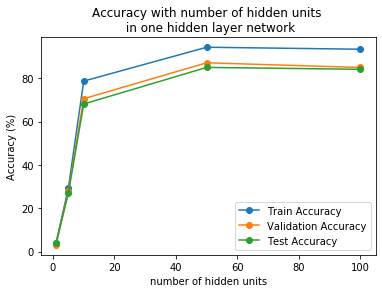

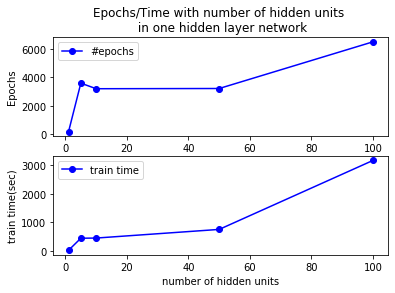

In [128]:
print("------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------")
plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part C - Adaptive Learning rate

In [132]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr0=1.5

for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr0, 'sigmoid', 'adaptive')
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2567487142268203
learning rate for this epoch =  1.5
Error on this batch = 3.2567020910859728
Error on this batch = 0.5350620983796747
Cost on val dataset after 2 epochs is = 0.5009163390784047
Initial Cost on Val dataset for this epoch 2 = 0.5009163390784047
learning rate for this epoch =  1.1905507889761495
Error on this batch = 0.5007866339718473
Error on this batch = 0.4914084744603255
Cost on val dataset after 3 epochs is = 0.4876981277272362
Initial Cost on Val dataset for this epoch 3 = 0.4876981277272362
learning rate for this epoch =  1.040041911525952
Error on this batch = 0.48756199749525847
Error on this batch = 0.48546016042860324
Cost on val dataset after 4 epochs is = 0.48429533898511096
Initial Cost on Val dataset for this epoch 4 = 

Cost on val dataset after 33 epochs is = 0.48086461930273894
Initial Cost on Val dataset for this epoch 33 = 0.48086461930273894
learning rate for this epoch =  0.467648930822808
Error on this batch = 0.4806273911198748
Error on this batch = 0.4808294405052901
Cost on val dataset after 34 epochs is = 0.480864368197794
Initial Cost on Val dataset for this epoch 34 = 0.480864368197794
learning rate for this epoch =  0.46301843924895625
Error on this batch = 0.4806260214081206
Error on this batch = 0.48082906317126617
Cost on val dataset after 35 epochs is = 0.48086419275130193
Initial Cost on Val dataset for this epoch 35 = 0.48086419275130193
learning rate for this epoch =  0.4585660630993198
Error on this batch = 0.4806247845600936
Error on this batch = 0.48082876143362885
Cost on val dataset after 36 epochs is = 0.4808640790119921
Initial Cost on Val dataset for this epoch 36 = 0.4808640790119921
learning rate for this epoch =  0.454280148208035
Error on this batch = 0.480623663382888

Cost on val dataset after 7 epochs is = 0.4809893095639808
Initial Cost on Val dataset for this epoch 7 = 0.4809893095639808
learning rate for this epoch =  0.7841369378620654
Error on this batch = 0.48081546811103176
Error on this batch = 0.48094176649322606
Cost on val dataset after 8 epochs is = 0.48098430658544983
Initial Cost on Val dataset for this epoch 8 = 0.48098430658544983
learning rate for this epoch =  0.75
Error on this batch = 0.48080764915220175
Error on this batch = 0.4809373759234783
Cost on val dataset after 9 epochs is = 0.4809798860371593
Initial Cost on Val dataset for this epoch 9 = 0.4809798860371593
learning rate for this epoch =  0.7211247851537042
Error on this batch = 0.48080088254716324
Error on this batch = 0.48093348726958846
Cost on val dataset after 10 epochs is = 0.48097593712061015
Initial Cost on Val dataset for this epoch 10 = 0.48097593712061015
learning rate for this epoch =  0.6962383250419169
Error on this batch = 0.4807949163800221
Error on thi

Cost on val dataset after 40 epochs is = 0.4809275868583959
Initial Cost on Val dataset for this epoch 40 = 0.4809275868583959
learning rate for this epoch =  0.43860266073192994
Error on this batch = 0.48072365132187955
Error on this batch = 0.480886996873323
Cost on val dataset after 41 epochs is = 0.48092683251342494
Initial Cost on Val dataset for this epoch 41 = 0.48092683251342494
learning rate for this epoch =  0.43500739525144
Error on this batch = 0.48072253024673284
Error on this batch = 0.4808863215025525
Cost on val dataset after 42 epochs is = 0.4809261011891701
cost initial= 0.48092683251342494 , cost final=0.4809261011891701 , change in cost= -7.313242548212529e-07

------------------------------------------------------------------------------
The stats for number of units in the hidden layer = 10 are as below:
------------------------------------------------------------------------------
The number of epochs = 42
The training time = 2.917sec
The training accuracy is = 3

Cost on val dataset after 29 epochs is = 0.26539814745987866
Initial Cost on Val dataset for this epoch 29 = 0.26539814745987866
learning rate for this epoch =  0.48823089710650147
Error on this batch = 0.26324695106853824
Error on this batch = 0.24590312842436213
Cost on val dataset after 30 epochs is = 0.25626655869612397
Initial Cost on Val dataset for this epoch 30 = 0.25626655869612397
learning rate for this epoch =  0.4827446923028149
Error on this batch = 0.2544042688523107
Error on this batch = 0.23707936929869816
Cost on val dataset after 31 epochs is = 0.24769474993495852
Initial Cost on Val dataset for this epoch 31 = 0.24769474993495852
learning rate for this epoch =  0.4774970517686601
Error on this batch = 0.24598237348999777
Error on this batch = 0.22886691418130908
Cost on val dataset after 32 epochs is = 0.23968491459683838
Initial Cost on Val dataset for this epoch 32 = 0.23968491459683838
learning rate for this epoch =  0.4724703937105775
Error on this batch = 0.2380

Cost on val dataset after 61 epochs is = 0.1485775302861757
Initial Cost on Val dataset for this epoch 61 = 0.1485775302861757
learning rate for this epoch =  0.38104942801404945
Error on this batch = 0.13701302245894265
Error on this batch = 0.12534067260501164
Cost on val dataset after 62 epochs is = 0.14743421708461674
Initial Cost on Val dataset for this epoch 62 = 0.14743421708461674
learning rate for this epoch =  0.3789896611446424
Error on this batch = 0.13574446803961038
Error on this batch = 0.12381629498209641
Cost on val dataset after 63 epochs is = 0.14633668691524038
Initial Cost on Val dataset for this epoch 63 = 0.14633668691524038
learning rate for this epoch =  0.3769737205645769
Error on this batch = 0.13452577693063625
Error on this batch = 0.12234418261361088
Cost on val dataset after 64 epochs is = 0.14528200889498852
Initial Cost on Val dataset for this epoch 64 = 0.14528200889498852
learning rate for this epoch =  0.37500000000000006
Error on this batch = 0.1333

Cost on val dataset after 93 epochs is = 0.12575035790346822
Initial Cost on Val dataset for this epoch 93 = 0.12575035790346822
learning rate for this epoch =  0.33107796431298914
Error on this batch = 0.11048982680397053
Error on this batch = 0.0933226225628285
Cost on val dataset after 94 epochs is = 0.1253067935314646
Initial Cost on Val dataset for this epoch 94 = 0.1253067935314646
learning rate for this epoch =  0.3298997409513274
Error on this batch = 0.1099170440754138
Error on this batch = 0.09267083017995056
Cost on val dataset after 95 epochs is = 0.12487269448176773
Initial Cost on Val dataset for this epoch 95 = 0.12487269448176773
learning rate for this epoch =  0.3287381125266525
Error on this batch = 0.1093526100582273
Error on this batch = 0.09203184621793556
Cost on val dataset after 96 epochs is = 0.12444772649122764
Initial Cost on Val dataset for this epoch 96 = 0.12444772649122764
learning rate for this epoch =  0.32759267427611205
Error on this batch = 0.1087962

Cost on val dataset after 125 epochs is = 0.11503275296609444
Initial Cost on Val dataset for this epoch 125 = 0.11503275296609444
learning rate for this epoch =  0.30000000000000004
Error on this batch = 0.09524293692638897
Error on this batch = 0.07722930764039662
Cost on val dataset after 126 epochs is = 0.11478235654519656
Initial Cost on Val dataset for this epoch 126 = 0.11478235654519656
learning rate for this epoch =  0.2992042402942877
Error on this batch = 0.09484326600087122
Error on this batch = 0.07684434642826765
Cost on val dataset after 127 epochs is = 0.11453567575074215
Initial Cost on Val dataset for this epoch 127 = 0.11453567575074215
learning rate for this epoch =  0.2984168570745668
Error on this batch = 0.09444712930682389
Error on this batch = 0.07646470941406239
Cost on val dataset after 128 epochs is = 0.11429262595867251
Initial Cost on Val dataset for this epoch 128 = 0.11429262595867251
learning rate for this epoch =  0.29763769724403744
Error on this batc

Cost on val dataset after 156 epochs is = 0.10869388304027601
Initial Cost on Val dataset for this epoch 156 = 0.10869388304027601
learning rate for this epoch =  0.2786440194897654
Error on this batch = 0.08426710598589807
Error on this batch = 0.06736239185315714
Cost on val dataset after 157 epochs is = 0.10852942721458908
Initial Cost on Val dataset for this epoch 157 = 0.10852942721458908
learning rate for this epoch =  0.2780511580826894
Error on this batch = 0.08395540707574888
Error on this batch = 0.06710254146055014
Cost on val dataset after 158 epochs is = 0.10836699187921381
Initial Cost on Val dataset for this epoch 158 = 0.10836699187921381
learning rate for this epoch =  0.2774633103289903
Error on this batch = 0.08364605494761353
Error on this batch = 0.06684561620715117
Cost on val dataset after 159 epochs is = 0.10820654120956115
Initial Cost on Val dataset for this epoch 159 = 0.10820654120956115
learning rate for this epoch =  0.276880402497925
Error on this batch =

Cost on val dataset after 188 epochs is = 0.10427864904698726
Initial Cost on Val dataset for this epoch 188 = 0.10427864904698726
learning rate for this epoch =  0.2618415979150868
Error on this batch = 0.07537216823925624
Error on this batch = 0.06024425329937625
Cost on val dataset after 189 epochs is = 0.10416416986250006
Initial Cost on Val dataset for this epoch 189 = 0.10416416986250006
learning rate for this epoch =  0.2613789792873551
Error on this batch = 0.07512737020898104
Error on this batch = 0.06005387166478785
Cost on val dataset after 190 epochs is = 0.10405086269580106
Initial Cost on Val dataset for this epoch 190 = 0.10405086269580106
learning rate for this epoch =  0.2609196128234243
Error on this batch = 0.07488441499429477
Error on this batch = 0.05986501847069128
Cost on val dataset after 191 epochs is = 0.10393870942176185
Initial Cost on Val dataset for this epoch 191 = 0.10393870942176185
learning rate for this epoch =  0.26046345872388293
Error on this batch

Error on this batch = 0.0549449509521706
Cost on val dataset after 220 epochs is = 0.10111881647710906
Initial Cost on Val dataset for this epoch 220 = 0.10111881647710906
learning rate for this epoch =  0.24847557185397154
Error on this batch = 0.06838111362588946
Error on this batch = 0.054791488621075024
Cost on val dataset after 221 epochs is = 0.10103444729129117
Initial Cost on Val dataset for this epoch 221 = 0.10103444729129117
learning rate for this epoch =  0.2481002305395797
Error on this batch = 0.06818814374088114
Error on this batch = 0.054638945390589264
Cost on val dataset after 222 epochs is = 0.10095081866021947
Initial Cost on Val dataset for this epoch 222 = 0.10095081866021947
learning rate for this epoch =  0.24772714692327866
Error on this batch = 0.0679965587886374
Error on this batch = 0.05448730874705794
Cost on val dataset after 223 epochs is = 0.10086792076743765
Initial Cost on Val dataset for this epoch 223 = 0.10086792076743765
learning rate for this epoc

Error on this batch = 0.050436774027622484
Cost on val dataset after 252 epochs is = 0.09874269729088019
Initial Cost on Val dataset for this epoch 252 = 0.09874269729088019
learning rate for this epoch =  0.23747856289824917
Error on this batch = 0.06282705005892886
Error on this batch = 0.050307671995749405
Cost on val dataset after 253 epochs is = 0.0986778318365236
Initial Cost on Val dataset for this epoch 253 = 0.0986778318365236
learning rate for this epoch =  0.23716526627736903
Error on this batch = 0.06267192167332086
Error on this batch = 0.05017919514965189
Cost on val dataset after 254 epochs is = 0.09861345657410722
Initial Cost on Val dataset for this epoch 254 = 0.09861345657410722
learning rate for this epoch =  0.2368536164226056
Error on this batch = 0.06251777706922129
Error on this batch = 0.050051336831679394
Cost on val dataset after 255 epochs is = 0.09854956537795459
Initial Cost on Val dataset for this epoch 255 = 0.09854956537795459
learning rate for this epo

Error on this batch = 0.04658610297030954
Cost on val dataset after 284 epochs is = 0.09688262129097384
Initial Cost on Val dataset for this epoch 284 = 0.09688262129097384
learning rate for this epoch =  0.22820149173502283
Error on this batch = 0.058302084581970205
Error on this batch = 0.04647417814871445
Cost on val dataset after 285 epochs is = 0.09683079356815434
Initial Cost on Val dataset for this epoch 285 = 0.09683079356815434
learning rate for this epoch =  0.22793427662910215
Error on this batch = 0.05817373386373461
Error on this batch = 0.046362710927269665
Cost on val dataset after 286 epochs is = 0.09677929813743043
Initial Cost on Val dataset for this epoch 286 = 0.09677929813743043
learning rate for this epoch =  0.2276683087368636
Error on this batch = 0.058046086191842816
Error on this batch = 0.046251697373319266
Cost on val dataset after 287 epochs is = 0.09672813122460674
Initial Cost on Val dataset for this epoch 287 = 0.09672813122460674
learning rate for this 

Error on this batch = 0.043214400892019125
Cost on val dataset after 316 epochs is = 0.09537234746363361
Initial Cost on Val dataset for this epoch 316 = 0.09537234746363361
learning rate for this epoch =  0.2202227753494091
Error on this batch = 0.0545138872022366
Error on this batch = 0.04311549961221532
Cost on val dataset after 317 epochs is = 0.0953295659893927
Initial Cost on Val dataset for this epoch 317 = 0.0953295659893927
learning rate for this epoch =  0.21999096173034446
Error on this batch = 0.05440518741681923
Error on this batch = 0.043016962485059713
Cost on val dataset after 318 epochs is = 0.09528702332587917
Initial Cost on Val dataset for this epoch 318 = 0.09528702332587917
learning rate for this epoch =  0.21976012109729232
Error on this batch = 0.054297021668850566
Error on this batch = 0.04291878757214539
Cost on val dataset after 319 epochs is = 0.09524471730151846
Initial Cost on Val dataset for this epoch 319 = 0.09524471730151846
learning rate for this epoc

Error on this batch = 0.040222274597749755
Cost on val dataset after 348 epochs is = 0.09411211723446931
Initial Cost on Val dataset for this epoch 348 = 0.09411211723446931
learning rate for this epoch =  0.21325448699645885
Error on this batch = 0.05128189418332573
Error on this batch = 0.040134293547022554
Cost on val dataset after 349 epochs is = 0.09407604614503934
Initial Cost on Val dataset for this epoch 349 = 0.09407604614503934
learning rate for this epoch =  0.21305061068957645
Error on this batch = 0.05118849303570986
Error on this batch = 0.04004663632280498
Cost on val dataset after 350 epochs is = 0.09404015800968958
Initial Cost on Val dataset for this epoch 350 = 0.09404015800968958
learning rate for this epoch =  0.2128475117955576
Error on this batch = 0.05109551739278511
Error on this batch = 0.03995930223367137
Cost on val dataset after 351 epochs is = 0.09400445142963179
Initial Cost on Val dataset for this epoch 351 = 0.09400445142963179
learning rate for this ep

Error on this batch = 0.03756477820989095
Cost on val dataset after 380 epochs is = 0.09304218614801196
Initial Cost on Val dataset for this epoch 380 = 0.09304218614801196
learning rate for this epoch =  0.20709203393751952
Error on this batch = 0.04849131056435715
Error on this batch = 0.03748690748231326
Cost on val dataset after 381 epochs is = 0.09301134859456416
Initial Cost on Val dataset for this epoch 381 = 0.09301134859456416
learning rate for this epoch =  0.2069106923089329
Error on this batch = 0.048410285212394585
Error on this batch = 0.037409346393797546
Cost on val dataset after 382 epochs is = 0.09298065633714905
Initial Cost on Val dataset for this epoch 382 = 0.09298065633714905
learning rate for this epoch =  0.20672998418878377
Error on this batch = 0.048329610327475965
Error on this batch = 0.037332094620571035
Cost on val dataset after 383 epochs is = 0.09295010841563305
Initial Cost on Val dataset for this epoch 383 = 0.09295010841563305
learning rate for this 

Cost on val dataset after 411 epochs is = 0.09214983143168416
Initial Cost on Val dataset for this epoch 411 = 0.09214983143168416
learning rate for this epoch =  0.2017486567075443
Error on this batch = 0.04613470799660315
Error on this batch = 0.03522472723327991
Cost on val dataset after 412 epochs is = 0.09212310245283735
Initial Cost on Val dataset for this epoch 412 = 0.09212310245283735
learning rate for this epoch =  0.20158529739991154
Error on this batch = 0.04606376816356985
Error on this batch = 0.03515657814623233
Cost on val dataset after 413 epochs is = 0.09209649409768259
Initial Cost on Val dataset for this epoch 413 = 0.09209649409768259
learning rate for this epoch =  0.2014224659095072
Error on this batch = 0.04599313017076399
Error on this batch = 0.03508872515450431
Cost on val dataset after 414 epochs is = 0.09207000572160107
Initial Cost on Val dataset for this epoch 414 = 0.09207000572160107
learning rate for this epoch =  0.20126015925911556
Error on this batc

Cost on val dataset after 443 epochs is = 0.09135137947989938
Initial Cost on Val dataset for this epoch 443 = 0.09135137947989938
learning rate for this epoch =  0.19676900233301184
Error on this batch = 0.04400840450129289
Error on this batch = 0.033187468382481974
Cost on val dataset after 444 epochs is = 0.09132822294588765
Initial Cost on Val dataset for this epoch 444 = 0.09132822294588765
learning rate for this epoch =  0.19662116681354663
Error on this batch = 0.04394654181269282
Error on this batch = 0.033128443150277444
Cost on val dataset after 445 epochs is = 0.09130516940709253
Initial Cost on Val dataset for this epoch 445 = 0.09130516940709253
learning rate for this epoch =  0.19647377457928838
Error on this batch = 0.04388494479017125
Error on this batch = 0.0330696893131548
Cost on val dataset after 446 epochs is = 0.09128221838412529
Initial Cost on Val dataset for this epoch 446 = 0.09128221838412529
learning rate for this epoch =  0.19632682330937004
Error on this b

Cost on val dataset after 475 epochs is = 0.09065914687777535
Initial Cost on Val dataset for this epoch 475 = 0.09065914687777535
learning rate for this epoch =  0.19224721445090986
Error on this batch = 0.04215537939864431
Error on this batch = 0.03142815455835458
Cost on val dataset after 476 epochs is = 0.09063905701872427
Initial Cost on Val dataset for this epoch 476 = 0.09063905701872427
learning rate for this epoch =  0.19211249316330498
Error on this batch = 0.042101496284038926
Error on this batch = 0.03137728908572149
Cost on val dataset after 477 epochs is = 0.09061905554559263
Initial Cost on Val dataset for this epoch 477 = 0.09061905554559263
learning rate for this epoch =  0.19197814871867794
Error on this batch = 0.042047844732768305
Error on this batch = 0.03132665953983677
Cost on val dataset after 478 epochs is = 0.09059914201240113
Initial Cost on Val dataset for this epoch 478 = 0.09059914201240113
learning rate for this epoch =  0.19184417927620318
Error on this 

Error on this batch = 0.029955299803326674
Cost on val dataset after 507 epochs is = 0.09005791471710786
Initial Cost on Val dataset for this epoch 507 = 0.09005791471710786
learning rate for this epoch =  0.18811435563495188
Error on this batch = 0.040540400756264895
Error on this batch = 0.02991115201435501
Cost on val dataset after 508 epochs is = 0.0900404346526984
Initial Cost on Val dataset for this epoch 508 = 0.0900404346526984
learning rate for this epoch =  0.18799083993585827
Error on this batch = 0.04049337044875826
Error on this batch = 0.02986720017110053
Cost on val dataset after 509 epochs is = 0.09002302905166752
Initial Cost on Val dataset for this epoch 509 = 0.09002302905166752
learning rate for this epoch =  0.18786764800022746
Error on this batch = 0.04044653594395894
Error on this batch = 0.02982344298914763
Cost on val dataset after 510 epochs is = 0.0900056975027001
Initial Cost on Val dataset for this epoch 510 = 0.0900056975027001
learning rate for this epoch

Error on this batch = 0.028633579357491726
Cost on val dataset after 539 epochs is = 0.089533544513763
Initial Cost on Val dataset for this epoch 539 = 0.089533544513763
learning rate for this epoch =  0.18431542018654673
Error on this batch = 0.039127427735125
Error on this batch = 0.028595092766182124
Cost on val dataset after 540 epochs is = 0.08951825725068664
Initial Cost on Val dataset for this epoch 540 = 0.08951825725068664
learning rate for this epoch =  0.18420157493201933
Error on this batch = 0.03908615956990836
Error on this batch = 0.02855676408075133
Cost on val dataset after 541 epochs is = 0.08950303275363952
Initial Cost on Val dataset for this epoch 541 = 0.08950303275363952
learning rate for this epoch =  0.1840880104304021
Error on this batch = 0.039045055838102805
Error on this batch = 0.028518592242274928
Cost on val dataset after 542 epochs is = 0.08948787071269573
Initial Cost on Val dataset for this epoch 542 = 0.08948787071269573
learning rate for this epoch 

Error on this batch = 0.027475385383519103
Cost on val dataset after 571 epochs is = 0.08907407273714438
Initial Cost on Val dataset for this epoch 571 = 0.08907407273714438
learning rate for this epoch =  0.180805882588868
Error on this batch = 0.03788424321601212
Error on this batch = 0.02744146845470305
Cost on val dataset after 572 epochs is = 0.08906065749054237
Initial Cost on Val dataset for this epoch 572 = 0.08906065749054237
learning rate for this epoch =  0.18070045639435905
Error on this batch = 0.03784782700977082
Error on this batch = 0.027407679624694706
Cost on val dataset after 573 epochs is = 0.08904729678815869
Initial Cost on Val dataset for this epoch 573 = 0.08904729678815869
learning rate for this epoch =  0.18059527566256542
Error on this batch = 0.03781154955343746
Error on this batch = 0.027374018080447524
Cost on val dataset after 574 epochs is = 0.08903399042547167
Initial Cost on Val dataset for this epoch 574 = 0.08903399042547167
learning rate for this ep

Cost on val dataset after 602 epochs is = 0.08868272766000068
Initial Cost on Val dataset for this epoch 602 = 0.08868272766000068
learning rate for this epoch =  0.17764749802823776
Error on this batch = 0.03681663154411438
Error on this batch = 0.026449725558513743
Cost on val dataset after 603 epochs is = 0.08867091989897642
Initial Cost on Val dataset for this epoch 603 = 0.08867091989897642
learning rate for this epoch =  0.1775492416486645
Error on this batch = 0.036784186099736806
Error on this batch = 0.026419527970631355
Cost on val dataset after 604 epochs is = 0.08865916150856877
Initial Cost on Val dataset for this epoch 604 = 0.08865916150856877
learning rate for this epoch =  0.1774512022904376
Error on this batch = 0.03675185782289539
Error on this batch = 0.02638943464457333
Cost on val dataset after 605 epochs is = 0.08864745235573125
Initial Cost on Val dataset for this epoch 605 = 0.08864745235573125
learning rate for this epoch =  0.17735337911609822
Error on this b

Error on this batch = 0.025559050360221096
Cost on val dataset after 634 epochs is = 0.08832875683315547
Initial Cost on Val dataset for this epoch 634 = 0.08832875683315547
learning rate for this epoch =  0.17460694203712238
Error on this batch = 0.03583334183803622
Error on this batch = 0.02553177444816945
Cost on val dataset after 635 epochs is = 0.08831846935334296
Initial Cost on Val dataset for this epoch 635 = 0.08831846935334296
learning rate for this epoch =  0.1745152366935534
Error on this batch = 0.03580433417611095
Error on this batch = 0.025504582555126012
Cost on val dataset after 636 epochs is = 0.08830822755441031
Initial Cost on Val dataset for this epoch 636 = 0.08830822755441031
learning rate for this epoch =  0.17442372370525036
Error on this batch = 0.03577542402794776
Error on this batch = 0.02547747407790357
Cost on val dataset after 637 epochs is = 0.08829803133015393
Initial Cost on Val dataset for this epoch 637 = 0.08829803133015393
learning rate for this ep

Cost on val dataset after 665 epochs is = 0.08803059618890083
Initial Cost on Val dataset for this epoch 665 = 0.08803059618890083
learning rate for this epoch =  0.17185046461013626
Error on this batch = 0.034976956860071684
Error on this batch = 0.02472507107503406
Cost on val dataset after 666 epochs is = 0.08802167321589428
Initial Cost on Val dataset for this epoch 666 = 0.08802167321589428
learning rate for this epoch =  0.17176441028197142
Error on this batch = 0.03495071766764193
Error on this batch = 0.024700208629584598
Cost on val dataset after 667 epochs is = 0.08801279234452405
Initial Cost on Val dataset for this epoch 667 = 0.08801279234452405
learning rate for this epoch =  0.17167852806251316
Error on this batch = 0.034924559468834264
Error on this batch = 0.024675413434645205
Cost on val dataset after 668 epochs is = 0.088003953442733
Initial Cost on Val dataset for this epoch 668 = 0.088003953442733
learning rate for this epoch =  0.17159281735028295
Error on this ba

Cost on val dataset after 696 epochs is = 0.08777292797326323
Initial Cost on Val dataset for this epoch 696 = 0.08777292797326323
learning rate for this epoch =  0.16926019849755874
Error on this batch = 0.03419910345480913
Error on this batch = 0.02398389918133159
Cost on val dataset after 697 epochs is = 0.0877652432055764
Initial Cost on Val dataset for this epoch 697 = 0.0877652432055764
learning rate for this epoch =  0.16917921274428768
Error on this batch = 0.03417516158901261
Error on this batch = 0.023960952514792435
Cost on val dataset after 698 epochs is = 0.0877575959015008
Initial Cost on Val dataset for this epoch 698 = 0.0877575959015008
learning rate for this epoch =  0.16909838176555053
Error on this batch = 0.03415128699296189
Error on this batch = 0.023938062815585456
Cost on val dataset after 699 epochs is = 0.087749985897487
Initial Cost on Val dataset for this epoch 699 = 0.087749985897487
learning rate for this epoch =  0.16901770504444735
Error on this batch = 

Cost on val dataset after 727 epochs is = 0.08755137956176454
Initial Cost on Val dataset for this epoch 727 = 0.08755137956176454
learning rate for this epoch =  0.16681936182002188
Error on this batch = 0.033486498126649125
Error on this batch = 0.02329806394845842
Cost on val dataset after 728 epochs is = 0.08754477954728213
Initial Cost on Val dataset for this epoch 728 = 0.08754477954728213
learning rate for this epoch =  0.16674294432796394
Error on this batch = 0.03346447007354457
Error on this batch = 0.023276785938618927
Cost on val dataset after 729 epochs is = 0.08753821191605982
Initial Cost on Val dataset for this epoch 729 = 0.08753821191605982
learning rate for this epoch =  0.1666666666666667
Error on this batch = 0.033442498243369784
Error on this batch = 0.023255558870220565
Cost on val dataset after 730 epochs is = 0.08753167650983523
Initial Cost on Val dataset for this epoch 730 = 0.08753167650983523
learning rate for this epoch =  0.1665905283889782
Error on this 

Cost on val dataset after 758 epochs is = 0.08736114985706474
Initial Cost on Val dataset for this epoch 758 = 0.08736114985706474
learning rate for this epoch =  0.16451349311819505
Error on this batch = 0.03282838476144631
Error on this batch = 0.022661460938915676
Cost on val dataset after 759 epochs is = 0.08735548365315572
Initial Cost on Val dataset for this epoch 759 = 0.08735548365315572
learning rate for this epoch =  0.16444121125778421
Error on this batch = 0.03280795834335957
Error on this batch = 0.022641693721933743
Cost on val dataset after 760 epochs is = 0.08734984530732615
Initial Cost on Val dataset for this epoch 760 = 0.08734984530732615
learning rate for this epoch =  0.16436905626332626
Error on this batch = 0.032787579031497434
Error on this batch = 0.022621973028412425
Cost on val dataset after 761 epochs is = 0.08734423468868177
Initial Cost on Val dataset for this epoch 761 = 0.08734423468868177
learning rate for this epoch =  0.16429702774566174
Error on thi

Cost on val dataset after 789 epochs is = 0.08719789672494233
Initial Cost on Val dataset for this epoch 789 = 0.08719789672494233
learning rate for this epoch =  0.16233005083401375
Error on this batch = 0.032215947948535266
Error on this batch = 0.022069738414947304
Cost on val dataset after 790 epochs is = 0.08719303807565291
Initial Cost on Val dataset for this epoch 790 = 0.08719303807565291
learning rate for this epoch =  0.16226152822104575
Error on this batch = 0.032196868392285534
Error on this batch = 0.022051354799668223
Cost on val dataset after 791 epochs is = 0.08718820372910562
Initial Cost on Val dataset for this epoch 791 = 0.08718820372910562
learning rate for this epoch =  0.16219312116056878
Error on this batch = 0.03217782873949749
Error on this batch = 0.022033013870912683
Cost on val dataset after 792 epochs is = 0.0871833935882158
Initial Cost on Val dataset for this epoch 792 = 0.0871833935882158
learning rate for this epoch =  0.162124829312007
Error on this b

Cost on val dataset after 820 epochs is = 0.08705817612019773
Initial Cost on Val dataset for this epoch 820 = 0.08705817612019773
learning rate for this epoch =  0.16025809462478136
Error on this batch = 0.0316422162140054
Error on this batch = 0.02151917449719124
Cost on val dataset after 821 epochs is = 0.08705403038348589
Initial Cost on Val dataset for this epoch 821 = 0.08705403038348589
learning rate for this epoch =  0.16019300197155054
Error on this batch = 0.03162429122321671
Error on this batch = 0.02150206048477418
Cost on val dataset after 822 epochs is = 0.08704990641116334
Initial Cost on Val dataset for this epoch 822 = 0.08704990641116334
learning rate for this epoch =  0.1601280149453635
Error on this batch = 0.0316064009530156
Error on this batch = 0.021484985605361637
Cost on val dataset after 823 epochs is = 0.0870458041357309
Initial Cost on Val dataset for this epoch 823 = 0.0870458041357309
learning rate for this epoch =  0.16006313324662969
Error on this batch 

Error on this batch = 0.021022318469138362
Cost on val dataset after 851 epochs is = 0.08693949572867181
Initial Cost on Val dataset for this epoch 851 = 0.08693949572867181
learning rate for this epoch =  0.15828802938643005
Error on this batch = 0.03110210195819538
Error on this batch = 0.02100632930242929
Cost on val dataset after 852 epochs is = 0.08693599608913893
Initial Cost on Val dataset for this epoch 852 = 0.08693599608913893
learning rate for this epoch =  0.15822607711811126
Error on this batch = 0.031085194253338538
Error on this batch = 0.020990375875962294
Cost on val dataset after 853 epochs is = 0.08693251638785045
Initial Cost on Val dataset for this epoch 853 = 0.08693251638785045
learning rate for this epoch =  0.15816422172591343
Error on this batch = 0.0310683175095454
Error on this batch = 0.02097445807618678
Cost on val dataset after 854 epochs is = 0.08692905657213236
Initial Cost on Val dataset for this epoch 854 = 0.08692905657213236
learning rate for this e

Error on this batch = 0.02054276227896802
Cost on val dataset after 882 epochs is = 0.08684004535415935
Initial Cost on Val dataset for this epoch 882 = 0.08684004535415935
learning rate for this epoch =  0.15641139785313893
Error on this batch = 0.030591905384532304
Error on this batch = 0.0205278281544552
Cost on val dataset after 883 epochs is = 0.08683713977696474
Initial Cost on Val dataset for this epoch 883 = 0.08683713977696474
learning rate for this epoch =  0.15635233009908794
Error on this batch = 0.030575911245628175
Error on this batch = 0.020512926241937204
Cost on val dataset after 884 epochs is = 0.08683425253872173
Initial Cost on Val dataset for this epoch 884 = 0.08683425253872173
learning rate for this epoch =  0.15629335147029363
Error on this batch = 0.030559945089812503
Error on this batch = 0.020498056427720845
Cost on val dataset after 885 epochs is = 0.08683138358716637
Initial Cost on Val dataset for this epoch 885 = 0.08683138358716637
learning rate for this

Error on this batch = 0.020094274121558113
Cost on val dataset after 913 epochs is = 0.08675826004888854
Initial Cost on Val dataset for this epoch 913 = 0.08675826004888854
learning rate for this epoch =  0.15462071120204152
Error on this batch = 0.03010872913709077
Error on this batch = 0.020080286050824944
Cost on val dataset after 914 epochs is = 0.08675589792067157
Initial Cost on Val dataset for this epoch 914 = 0.08675589792067157
learning rate for this epoch =  0.15456430086824924
Error on this batch = 0.030093564920027332
Error on this batch = 0.02006632671068969
Cost on val dataset after 915 epochs is = 0.08675355242882692
Initial Cost on Val dataset for this epoch 915 = 0.08675355242882692
learning rate for this epoch =  0.15450797276527697
Error on this batch = 0.030078426280629626
Error on this batch = 0.02005239599132332
Cost on val dataset after 916 epochs is = 0.08675122351513122
Initial Cost on Val dataset for this epoch 916 = 0.08675122351513122
learning rate for this

Error on this batch = 0.019660371277269655
Cost on val dataset after 945 epochs is = 0.08669062667660754
Initial Cost on Val dataset for this epoch 945 = 0.08669062667660754
learning rate for this epoch =  0.15285535436643993
Error on this batch = 0.0296358458286009
Error on this batch = 0.01964724952322107
Cost on val dataset after 946 epochs is = 0.0866887669128902
Initial Cost on Val dataset for this epoch 946 = 0.0866887669128902
learning rate for this epoch =  0.1528014751394291
Error on this batch = 0.029621469442593966
Error on this batch = 0.019634153136699632
Cost on val dataset after 947 epochs is = 0.08668692181046542
Initial Cost on Val dataset for this epoch 947 = 0.08668692181046542
learning rate for this epoch =  0.1527476717986645
Error on this batch = 0.029607116763056638
Error on this batch = 0.019621082018931632
Cost on val dataset after 948 epochs is = 0.08668509130394196
Initial Cost on Val dataset for this epoch 948 = 0.08668509130394196
learning rate for this epo

Error on this batch = 0.019252585113274316
Cost on val dataset after 977 epochs is = 0.08663805464351786
Initial Cost on Val dataset for this epoch 977 = 0.08663805464351786
learning rate for this epoch =  0.15116795494305377
Error on this batch = 0.029187336540975356
Error on this batch = 0.019240228592909085
Cost on val dataset after 978 epochs is = 0.08663663062750109
Initial Cost on Val dataset for this epoch 978 = 0.08663663062750109
learning rate for this epoch =  0.15111641455210248
Error on this batch = 0.02917369706434705
Error on this batch = 0.0192278945317821
Cost on val dataset after 979 epochs is = 0.0866352190862053
Initial Cost on Val dataset for this epoch 979 = 0.0866352190862053
learning rate for this epoch =  0.151064944379677
Error on this batch = 0.029160079971505756
Error on this batch = 0.019215582848109005
Cost on val dataset after 980 epochs is = 0.08663381994875656
Initial Cost on Val dataset for this epoch 980 = 0.08663381994875656
learning rate for this epo

Cost on val dataset after 1008 epochs is = 0.08659939013696702
Initial Cost on Val dataset for this epoch 1008 = 0.08659939013696702
learning rate for this epoch =  0.14960212014714389
Error on this batch = 0.028774770992824803
Error on this batch = 0.018867931902302952
Cost on val dataset after 1009 epochs is = 0.08659831961941927
Initial Cost on Val dataset for this epoch 1009 = 0.08659831961941927
learning rate for this epoch =  0.14955268124065313
Error on this batch = 0.028761810056024906
Error on this batch = 0.018856256457387137
Cost on val dataset after 1010 epochs is = 0.08659725936125486
Initial Cost on Val dataset for this epoch 1010 = 0.08659725936125486
learning rate for this epoch =  0.14950330762160088
Error on this batch = 0.028748870497167393
Error on this batch = 0.018844601149601778
Cost on val dataset after 1011 epochs is = 0.08659620929160577
Initial Cost on Val dataset for this epoch 1011 = 0.08659620929160577
learning rate for this epoch =  0.1494539991392575
Err

Error on this batch = 0.4436327374272642
Cost on val dataset after 12 epochs is = 0.4331806532475946
Initial Cost on Val dataset for this epoch 12 = 0.4331806532475946
learning rate for this epoch =  0.6551853485522241
Error on this batch = 0.4237516999427369
Error on this batch = 0.422061015071386
Cost on val dataset after 13 epochs is = 0.41552013317490455
Initial Cost on Val dataset for this epoch 13 = 0.41552013317490455
learning rate for this epoch =  0.6379355554244853
Error on this batch = 0.4049461794525625
Error on this batch = 0.4007357420063808
Cost on val dataset after 14 epochs is = 0.4005026187674127
Initial Cost on Val dataset for this epoch 14 = 0.4005026187674127
learning rate for this epoch =  0.6223699000246826
Error on this batch = 0.3889325386851275
Error on this batch = 0.38278581902401804
Cost on val dataset after 15 epochs is = 0.38667029403984204
Initial Cost on Val dataset for this epoch 15 = 0.38667029403984204
learning rate for this epoch =  0.60822019955734

Error on this batch = 0.14349554145216245
Cost on val dataset after 45 epochs is = 0.15974111160456453
Initial Cost on Val dataset for this epoch 45 = 0.15974111160456453
learning rate for this epoch =  0.42171633265087466
Error on this batch = 0.14561636006546425
Error on this batch = 0.14112759245006415
Cost on val dataset after 46 epochs is = 0.15802189083136065
Initial Cost on Val dataset for this epoch 46 = 0.15802189083136065
learning rate for this epoch =  0.4186380014997361
Error on this batch = 0.14370246035345777
Error on this batch = 0.13884409003390524
Cost on val dataset after 47 epochs is = 0.1563850969491781
Initial Cost on Val dataset for this epoch 47 = 0.1563850969491781
learning rate for this epoch =  0.4156476279794431
Error on this batch = 0.141882571990927
Error on this batch = 0.1366394907945737
Cost on val dataset after 48 epochs is = 0.15482409741946115
Initial Cost on Val dataset for this epoch 48 = 0.15482409741946115
learning rate for this epoch =  0.4127409

Cost on val dataset after 76 epochs is = 0.12819455555277146
Initial Cost on Val dataset for this epoch 76 = 0.12819455555277146
learning rate for this epoch =  0.3541223967815126
Error on this batch = 0.11074656849696414
Error on this batch = 0.09472667670054588
Cost on val dataset after 77 epochs is = 0.12759421484080932
Initial Cost on Val dataset for this epoch 77 = 0.12759421484080932
learning rate for this epoch =  0.3525827147406408
Error on this batch = 0.11006861160338342
Error on this batch = 0.09378939964566946
Cost on val dataset after 78 epochs is = 0.12700824668119978
Initial Cost on Val dataset for this epoch 78 = 0.12700824668119978
learning rate for this epoch =  0.3510694655824727
Error on this batch = 0.10940442886627202
Error on this batch = 0.09287494673012094
Cost on val dataset after 79 epochs is = 0.12643608588944927
Initial Cost on Val dataset for this epoch 79 = 0.12643608588944927
learning rate for this epoch =  0.34958186525700846
Error on this batch = 0.108

Cost on val dataset after 108 epochs is = 0.11406693500946813
Initial Cost on Val dataset for this epoch 108 = 0.11406693500946813
learning rate for this epoch =  0.3149802624737183
Error on this batch = 0.0937799274217422
Error on this batch = 0.0731530751078639
Cost on val dataset after 109 epochs is = 0.11374302086720676
Initial Cost on Val dataset for this epoch 109 = 0.11374302086720676
learning rate for this epoch =  0.31401405927925385
Error on this batch = 0.09335701302011995
Error on this batch = 0.07267998201359832
Cost on val dataset after 110 epochs is = 0.11342395837351457
Initial Cost on Val dataset for this epoch 110 = 0.11342395837351457
learning rate for this epoch =  0.31305960336348476
Error on this batch = 0.09293845932291821
Error on this batch = 0.07221532538591403
Cost on val dataset after 111 epochs is = 0.11310961605624871
Initial Cost on Val dataset for this epoch 111 = 0.11310961605624871
learning rate for this epoch =  0.3121166470390388
Error on this batch 

Error on this batch = 0.061870886470430105
Cost on val dataset after 139 epochs is = 0.10582382441857774
Initial Cost on Val dataset for this epoch 139 = 0.10582382441857774
learning rate for this epoch =  0.28956961739951936
Error on this batch = 0.08227842071661969
Error on this batch = 0.061575188431902655
Cost on val dataset after 140 epochs is = 0.10560696173789214
Initial Cost on Val dataset for this epoch 140 = 0.10560696173789214
learning rate for this epoch =  0.28887851783312685
Error on this batch = 0.08195165022890541
Error on this batch = 0.06128337554240768
Cost on val dataset after 141 epochs is = 0.1053925220787092
Initial Cost on Val dataset for this epoch 141 = 0.1053925220787092
learning rate for this epoch =  0.28819396901664524
Error on this batch = 0.08162714651717437
Error on this batch = 0.06099534822113583
Cost on val dataset after 142 epochs is = 0.10518046190285535
Initial Cost on Val dataset for this epoch 142 = 0.10518046190285535
learning rate for this epo

Cost on val dataset after 170 epochs is = 0.10006537115651887
Initial Cost on Val dataset for this epoch 170 = 0.10006537115651887
learning rate for this epoch =  0.27077482589671686
Error on this batch = 0.07311821683828476
Error on this batch = 0.05391526387899555
Cost on val dataset after 171 epochs is = 0.09990791476722959
Initial Cost on Val dataset for this epoch 171 = 0.09990791476722959
learning rate for this epoch =  0.2702459674686131
Error on this batch = 0.07285415104985829
Error on this batch = 0.05370474286959425
Cost on val dataset after 172 epochs is = 0.09975196602987181
Initial Cost on Val dataset for this epoch 172 = 0.09975196602987181
learning rate for this epoch =  0.26972121669692517
Error on this batch = 0.0725919781429844
Error on this batch = 0.053495965349958284
Cost on val dataset after 173 epochs is = 0.09959750604063283
Initial Cost on Val dataset for this epoch 173 = 0.09959750604063283
learning rate for this epoch =  0.2692005180724355
Error on this batc

Cost on val dataset after 201 epochs is = 0.09581022787959101
Initial Cost on Val dataset for this epoch 201 = 0.09581022787959101
learning rate for this epoch =  0.2560703174761926
Error on this batch = 0.06579513891274544
Error on this batch = 0.04812841661062116
Cost on val dataset after 202 epochs is = 0.09569201449782318
Initial Cost on Val dataset for this epoch 202 = 0.09569201449782318
learning rate for this epoch =  0.2556470599815444
Error on this batch = 0.06558760176089405
Error on this batch = 0.047966310276135904
Cost on val dataset after 203 epochs is = 0.09557483782767613
Initial Cost on Val dataset for this epoch 203 = 0.09557483782767613
learning rate for this epoch =  0.2552265870844941
Error on this batch = 0.06538175254467125
Error on this batch = 0.04780574998151086
Cost on val dataset after 204 epochs is = 0.09545868462282311
Initial Cost on Val dataset for this epoch 204 = 0.09545868462282311
learning rate for this epoch =  0.2548088668827983
Error on this batch

Cost on val dataset after 232 epochs is = 0.09257425803205703
Initial Cost on Val dataset for this epoch 232 = 0.09257425803205703
learning rate for this epoch =  0.24411544855325074
Error on this batch = 0.060079004696853726
Error on this batch = 0.04379071287714667
Cost on val dataset after 233 epochs is = 0.09248295905702233
Initial Cost on Val dataset for this epoch 233 = 0.09248295905702233
learning rate for this epoch =  0.2437657124746985
Error on this batch = 0.05991677025953312
Error on this batch = 0.04367191022571268
Cost on val dataset after 234 epochs is = 0.0923923879497767
Initial Cost on Val dataset for this epoch 234 = 0.0923923879497767
learning rate for this epoch =  0.2434179720418596
Error on this batch = 0.05975575705639599
Error on this batch = 0.04355419543166452
Cost on val dataset after 235 epochs is = 0.0923025378945741
Initial Cost on Val dataset for this epoch 235 = 0.0923025378945741
learning rate for this epoch =  0.24307220741159882
Error on this batch =

Cost on val dataset after 263 epochs is = 0.09005297647208302
Initial Cost on Val dataset for this epoch 263 = 0.09005297647208302
learning rate for this epoch =  0.23412044606333612
Error on this batch = 0.05555824776284925
Error on this batch = 0.04052805068479394
Cost on val dataset after 264 epochs is = 0.08998122609314954
Initial Cost on Val dataset for this epoch 264 = 0.08998122609314954
learning rate for this epoch =  0.233824465411404
Error on this batch = 0.05542789341200805
Error on this batch = 0.040434702926938806
Cost on val dataset after 265 epochs is = 0.0899100072769488
Initial Cost on Val dataset for this epoch 265 = 0.0899100072769488
learning rate for this epoch =  0.233529975848646
Error on this batch = 0.055298384556204346
Error on this batch = 0.040341966232812665
Cost on val dataset after 266 epochs is = 0.08983931424325045
Initial Cost on Val dataset for this epoch 266 = 0.08983931424325045
learning rate for this epoch =  0.2332369642788867
Error on this batch 

Cost on val dataset after 294 epochs is = 0.08805158529982034
Initial Cost on Val dataset for this epoch 294 = 0.08805158529982034
learning rate for this epoch =  0.22558427134487072
Error on this batch = 0.05187100895868623
Error on this batch = 0.03788453620623493
Cost on val dataset after 295 epochs is = 0.08799386645589682
Initial Cost on Val dataset for this epoch 295 = 0.08799386645589682
learning rate for this epoch =  0.22532908529973278
Error on this batch = 0.051762952240803156
Error on this batch = 0.037806841486499314
Cost on val dataset after 296 epochs is = 0.08793652499620772
Initial Cost on Val dataset for this epoch 296 = 0.08793652499620772
learning rate for this epoch =  0.22507505003892134
Error on this batch = 0.05165550066654763
Error on this batch = 0.037729563475747185
Cost on val dataset after 297 epochs is = 0.08787955679360279
Initial Cost on Val dataset for this epoch 297 = 0.08787955679360279
learning rate for this epoch =  0.2248221565113046
Error on this 

Cost on val dataset after 325 epochs is = 0.08642072358555061
Initial Cost on Val dataset for this epoch 325 = 0.08642072358555061
learning rate for this epoch =  0.21817089106114174
Error on this batch = 0.048777740268548885
Error on this batch = 0.03565156890013242
Cost on val dataset after 326 epochs is = 0.08637299516081894
Initial Cost on Val dataset for this epoch 326 = 0.08637299516081894
learning rate for this epoch =  0.217947583954166
Error on this batch = 0.0486859360534193
Error on this batch = 0.035584954004815116
Cost on val dataset after 327 epochs is = 0.08632553757673075
Initial Cost on Val dataset for this epoch 327 = 0.08632553757673075
learning rate for this epoch =  0.21772518830587922
Error on this batch = 0.0485945783071244
Error on this batch = 0.03551863857776899
Cost on val dataset after 328 epochs is = 0.08627834807890176
Initial Cost on Val dataset for this epoch 328 = 0.08627834807890176
learning rate for this epoch =  0.21750369762572003
Error on this batc

Cost on val dataset after 356 epochs is = 0.08505584371165867
Initial Cost on Val dataset for this epoch 356 = 0.08505584371165867
learning rate for this epoch =  0.2116449578175617
Error on this batch = 0.04612088330176205
Error on this batch = 0.033711680812674255
Cost on val dataset after 357 epochs is = 0.08501539088088281
Initial Cost on Val dataset for this epoch 357 = 0.08501539088088281
learning rate for this epoch =  0.21144715867633312
Error on this batch = 0.04604105257076082
Error on this batch = 0.03365293169812471
Cost on val dataset after 358 epochs is = 0.08497513966056609
Initial Cost on Val dataset for this epoch 358 = 0.08497513966056609
learning rate for this epoch =  0.21125009690450638
Error on this batch = 0.0459615507148102
Error on this batch = 0.033594392850287785
Cost on val dataset after 359 epochs is = 0.08493508832527
Initial Cost on Val dataset for this epoch 359 = 0.08493508832527
learning rate for this epoch =  0.21105376770506165
Error on this batch = 

Error on this batch = 0.0320320049267988
Cost on val dataset after 387 epochs is = 0.08388875168429642
Initial Cost on Val dataset for this epoch 387 = 0.08388875168429642
learning rate for this epoch =  0.2058358121811892
Error on this batch = 0.04378653953779093
Error on this batch = 0.03197866866772591
Cost on val dataset after 388 epochs is = 0.08385388283804326
Initial Cost on Val dataset for this epoch 388 = 0.08385388283804326
learning rate for this epoch =  0.20565882515309017
Error on this batch = 0.043715663963217306
Error on this batch = 0.03192548542611975
Cost on val dataset after 389 epochs is = 0.08381917626324821
Initial Cost on Val dataset for this epoch 389 = 0.08381917626324821
learning rate for this epoch =  0.20548244528512918
Error on this batch = 0.043645041788727426
Error on this batch = 0.03187245371765432
Cost on val dataset after 390 epochs is = 0.08378463117924978
Initial Cost on Val dataset for this epoch 390 = 0.08378463117924978
learning rate for this epo

Error on this batch = 0.03044378360913522
Cost on val dataset after 418 epochs is = 0.082880591614203
Initial Cost on Val dataset for this epoch 418 = 0.082880591614203
learning rate for this epoch =  0.20061612234578877
Error on this batch = 0.04170038246708727
Error on this batch = 0.03039460143871696
Cost on val dataset after 419 epochs is = 0.08285050173901114
Initial Cost on Val dataset for this epoch 419 = 0.08285050173901114
learning rate for this epoch =  0.2004563960662028
Error on this batch = 0.04163669342172709
Error on this batch = 0.03034553625408934
Cost on val dataset after 420 epochs is = 0.08282056013784327
Initial Cost on Val dataset for this epoch 420 = 0.08282056013784327
learning rate for this epoch =  0.20029717725729937
Error on this batch = 0.041573218101229666
Error on this batch = 0.03029658717010739
Cost on val dataset after 421 epochs is = 0.0827907664930156
Initial Cost on Val dataset for this epoch 421 = 0.0827907664930156
learning rate for this epoch =  

Error on this batch = 0.02896989596224883
Cost on val dataset after 449 epochs is = 0.08201471300119043
Initial Cost on Val dataset for this epoch 449 = 0.08201471300119043
learning rate for this epoch =  0.19588859233577777
Error on this batch = 0.03982202931634711
Error on this batch = 0.028923977760092045
Cost on val dataset after 450 epochs is = 0.08198897800529069
Initial Cost on Val dataset for this epoch 450 = 0.08198897800529069
learning rate for this epoch =  0.19574338205844322
Error on this batch = 0.03976463050286721
Error on this batch = 0.028878154410552873
Cost on val dataset after 451 epochs is = 0.08196337099651346
Initial Cost on Val dataset for this epoch 451 = 0.08196337099651346
learning rate for this epoch =  0.19559860139758836
Error on this batch = 0.0397074245623192
Error on this batch = 0.0288324254421701
Cost on val dataset after 452 epochs is = 0.08193789094044324
Initial Cost on Val dataset for this epoch 452 = 0.08193789094044324
learning rate for this epo

Error on this batch = 0.027589172494791286
Cost on val dataset after 480 epochs is = 0.08127158331960488
Initial Cost on Val dataset for this epoch 480 = 0.08127158331960488
learning rate for this epoch =  0.1915773580983883
Error on this batch = 0.03812976972052143
Error on this batch = 0.027546082998031598
Cost on val dataset after 481 epochs is = 0.08124931374975068
Initial Cost on Val dataset for this epoch 481 = 0.08124931374975068
learning rate for this epoch =  0.1914445027450308
Error on this batch = 0.03807808373533905
Error on this batch = 0.027503084653658093
Cost on val dataset after 482 epochs is = 0.08122713926355196
Initial Cost on Val dataset for this epoch 482 = 0.08122713926355196
learning rate for this epoch =  0.1913120151575631
Error on this batch = 0.03802657304176437
Error on this batch = 0.027460177657702877
Cost on val dataset after 483 epochs is = 0.08120505892069921
Initial Cost on Val dataset for this epoch 483 = 0.08120505892069921
learning rate for this ep

Error on this batch = 0.026296869985679653
Cost on val dataset after 511 epochs is = 0.08062160259392584
Initial Cost on Val dataset for this epoch 511 = 0.08062160259392584
learning rate for this epoch =  0.18762222950006707
Error on this batch = 0.03660667745597695
Error on this batch = 0.02625672077492609
Cost on val dataset after 512 epochs is = 0.08060189798429111
Initial Cost on Val dataset for this epoch 512 = 0.08060189798429111
learning rate for this epoch =  0.18750000000000003
Error on this batch = 0.036560187628191104
Error on this batch = 0.02621667027233885
Cost on val dataset after 513 epochs is = 0.08058226477324622
Initial Cost on Val dataset for this epoch 513 = 0.08058226477324622
learning rate for this epoch =  0.18737808839215772
Error on this batch = 0.03651385774135748
Error on this batch = 0.02617671866123114
Cost on val dataset after 514 epochs is = 0.08056270235664362
Initial Cost on Val dataset for this epoch 514 = 0.08056270235664362
learning rate for this e

Error on this batch = 0.025098669552840104
Cost on val dataset after 542 epochs is = 0.08004146610866239
Initial Cost on Val dataset for this epoch 542 = 0.08004146610866239
learning rate for this epoch =  0.18397472547229715
Error on this batch = 0.03523789153261218
Error on this batch = 0.0250616225918994
Cost on val dataset after 543 epochs is = 0.08002372466469407
Initial Cost on Val dataset for this epoch 543 = 0.08002372466469407
learning rate for this epoch =  0.1838617188557352
Error on this batch = 0.03519615688842426
Error on this batch = 0.025024675560196653
Cost on val dataset after 544 epochs is = 0.08000603892151663
Initial Cost on Val dataset for this epoch 544 = 0.08000603892151663
learning rate for this epoch =  0.18374898938611675
Error on this batch = 0.0351545687624261
Error on this batch = 0.024987828348196687
Cost on val dataset after 545 epochs is = 0.07998840845946885
Initial Cost on Val dataset for this epoch 545 = 0.07998840845946885
learning rate for this epo

Error on this batch = 0.02399596622136329
Cost on val dataset after 573 epochs is = 0.07951563300479625
Initial Cost on Val dataset for this epoch 573 = 0.07951563300479625
learning rate for this epoch =  0.18059527566256542
Error on this batch = 0.03401028752223544
Error on this batch = 0.02396193572572411
Cost on val dataset after 574 epochs is = 0.07949944247993404
Initial Cost on Val dataset for this epoch 574 = 0.07949944247993404
learning rate for this epoch =  0.18049033939509088
Error on this batch = 0.03397289074426047
Error on this batch = 0.02392799885078259
Cost on val dataset after 575 epochs is = 0.0794832966049064
Initial Cost on Val dataset for this epoch 575 = 0.0794832966049064
learning rate for this epoch =  0.18038564659933026
Error on this batch = 0.033935626683025646
Error on this batch = 0.023894155323677852
Cost on val dataset after 576 epochs is = 0.07946719508547857
Initial Cost on Val dataset for this epoch 576 = 0.07946719508547857
learning rate for this epo

Error on this batch = 0.022983281025747152
Cost on val dataset after 604 epochs is = 0.07903327489655883
Initial Cost on Val dataset for this epoch 604 = 0.07903327489655883
learning rate for this epoch =  0.1774512022904376
Error on this batch = 0.0329105820773113
Error on this batch = 0.02295202025206999
Cost on val dataset after 605 epochs is = 0.07901834700179969
Initial Cost on Val dataset for this epoch 605 = 0.07901834700179969
learning rate for this epoch =  0.17735337911609822
Error on this batch = 0.03287707937953743
Error on this batch = 0.022920844234706052
Cost on val dataset after 606 epochs is = 0.0790034561821889
Initial Cost on Val dataset for this epoch 606 = 0.0790034561821889
learning rate for this epoch =  0.1772557712927968
Error on this batch = 0.03284369461723936
Error on this batch = 0.0228897526961347
Cost on val dataset after 607 epochs is = 0.07898860224150404
Initial Cost on Val dataset for this epoch 607 = 0.07898860224150404
learning rate for this epoch =

Error on this batch = 0.02205243081488349
Cost on val dataset after 635 epochs is = 0.07858694477754347
Initial Cost on Val dataset for this epoch 635 = 0.07858694477754347
learning rate for this epoch =  0.1745152366935534
Error on this batch = 0.031924683795294416
Error on this batch = 0.022023678807391107
Cost on val dataset after 636 epochs is = 0.0785730856603949
Initial Cost on Val dataset for this epoch 636 = 0.0785730856603949
learning rate for this epoch =  0.17442372370525036
Error on this batch = 0.031894615187141
Error on this batch = 0.021995004089918755
Cost on val dataset after 637 epochs is = 0.07855925859610705
Initial Cost on Val dataset for this epoch 637 = 0.07855925859610705
learning rate for this epoch =  0.17433240236724595
Error on this batch = 0.031864649878118045
Error on this batch = 0.02196640646720934
Cost on val dataset after 638 epochs is = 0.07854546345319846
Initial Cost on Val dataset for this epoch 638 = 0.07854546345319846
learning rate for this epoc

Error on this batch = 0.021196265954270734
Cost on val dataset after 666 epochs is = 0.0781716692189028
Initial Cost on Val dataset for this epoch 666 = 0.0781716692189028
learning rate for this epoch =  0.17176441028197142
Error on this batch = 0.03103861129588186
Error on this batch = 0.021169830901706908
Cost on val dataset after 667 epochs is = 0.0781587486389496
Initial Cost on Val dataset for this epoch 667 = 0.0781587486389496
learning rate for this epoch =  0.17167852806251316
Error on this batch = 0.03101154249900734
Error on this batch = 0.021143468223678345
Cost on val dataset after 668 epochs is = 0.0781458566319116
Initial Cost on Val dataset for this epoch 668 = 0.0781458566319116
learning rate for this epoch =  0.17159281735028295
Error on this batch = 0.030984563821787256
Error on this batch = 0.021117177788756762
Cost on val dataset after 669 epochs is = 0.07813299310262621
Initial Cost on Val dataset for this epoch 669 = 0.07813299310262621
learning rate for this epoc

Error on this batch = 0.020385591827097
Cost on val dataset after 698 epochs is = 0.07777194193411412
Initial Cost on Val dataset for this epoch 698 = 0.07777194193411412
learning rate for this epoch =  0.16909838176555053
Error on this batch = 0.030215222381728288
Error on this batch = 0.02036140680495496
Cost on val dataset after 699 epochs is = 0.0777598927311699
Initial Cost on Val dataset for this epoch 699 = 0.0777598927311699
learning rate for this epoch =  0.16901770504444735
Error on this batch = 0.030190851126460583
Error on this batch = 0.020337289703245744
Cost on val dataset after 700 epochs is = 0.0777478694726977
Initial Cost on Val dataset for this epoch 700 = 0.0777478694726977
learning rate for this epoch =  0.16893718206654096
Error on this batch = 0.030166558272006372
Error on this batch = 0.02031324035112262
Cost on val dataset after 701 epochs is = 0.07773587208938564
Initial Cost on Val dataset for this epoch 701 = 0.07773587208938564
learning rate for this epoch

Error on this batch = 0.01964434178432154
Cost on val dataset after 730 epochs is = 0.07739891243098479
Initial Cost on Val dataset for this epoch 730 = 0.07739891243098479
learning rate for this epoch =  0.1665905283889782
Error on this batch = 0.02947261692551457
Error on this batch = 0.019622220277717317
Cost on val dataset after 731 epochs is = 0.07738766164398149
Initial Cost on Val dataset for this epoch 731 = 0.07738766164398149
learning rate for this epoch =  0.1665145290497864
Error on this batch = 0.029450596511805004
Error on this batch = 0.01960015842307982
Cost on val dataset after 732 epochs is = 0.07737643479792862
Initial Cost on Val dataset for this epoch 732 = 0.07737643479792862
learning rate for this epoch =  0.1664386682060071
Error on this batch = 0.029428644780804793
Error on this batch = 0.01957815583352901
Cost on val dataset after 733 epochs is = 0.07736523183117455
Initial Cost on Val dataset for this epoch 733 = 0.07736523183117455
learning rate for this epo

Error on this batch = 0.018963802290248428
Cost on val dataset after 762 epochs is = 0.07705044028981844
Initial Cost on Val dataset for this epoch 762 = 0.07705044028981844
learning rate for this epoch =  0.16422512531733424
Error on this batch = 0.028800996294834267
Error on this batch = 0.018943356308640677
Cost on val dataset after 763 epochs is = 0.07703992307012478
Initial Cost on Val dataset for this epoch 763 = 0.07703992307012478
learning rate for this epoch =  0.1641533485925808
Error on this batch = 0.0287810785268702
Error on this batch = 0.018922954038696038
Cost on val dataset after 764 epochs is = 0.0770294276875919
Initial Cost on Val dataset for this epoch 764 = 0.0770294276875919
learning rate for this epoch =  0.16408169718732227
Error on this batch = 0.02876122435535442
Error on this batch = 0.018902594966285095
Cost on val dataset after 765 epochs is = 0.07701895408620288
Initial Cost on Val dataset for this epoch 765 = 0.07701895408620288
learning rate for this ep

Cost on val dataset after 793 epochs is = 0.07673441661777236
Initial Cost on Val dataset for this epoch 793 = 0.07673441661777236
learning rate for this epoch =  0.16205665233621672
Error on this batch = 0.028212793971265616
Error on this batch = 0.018329183271068944
Cost on val dataset after 794 epochs is = 0.07672456669721708
Initial Cost on Val dataset for this epoch 794 = 0.07672456669721708
learning rate for this epoch =  0.16198858989547868
Error on this batch = 0.028194808221799726
Error on this batch = 0.01830995772390215
Cost on val dataset after 795 epochs is = 0.07671473870220412
Initial Cost on Val dataset for this epoch 795 = 0.07671473870220412
learning rate for this epoch =  0.16192064165349013
Error on this batch = 0.02817688225951127
Error on this batch = 0.018290767633010165
Cost on val dataset after 796 epochs is = 0.07670493270515233
Initial Cost on Val dataset for this epoch 796 = 0.07670493270515233
learning rate for this epoch =  0.16185280727535734
Error on thi

Cost on val dataset after 824 epochs is = 0.07643962888857608
Initial Cost on Val dataset for this epoch 824 = 0.07643962888857608
learning rate for this epoch =  0.15999835657697095
Error on this batch = 0.027681393985707913
Error on this batch = 0.01774999104944387
Cost on val dataset after 825 epochs is = 0.07643049561446283
Initial Cost on Val dataset for this epoch 825 = 0.07643049561446283
learning rate for this epoch =  0.15993368463921526
Error on this batch = 0.02766508428629403
Error on this batch = 0.01773189791518562
Cost on val dataset after 826 epochs is = 0.07642138647826884
Initial Cost on Val dataset for this epoch 826 = 0.07642138647826884
learning rate for this epoch =  0.15986911713739024
Error on this batch = 0.027648822079535704
Error on this batch = 0.017713842283666105
Cost on val dataset after 827 epochs is = 0.07641230150637876
Initial Cost on Val dataset for this epoch 827 = 0.07641230150637876
learning rate for this epoch =  0.15980465377671696
Error on this

Error on this batch = 0.017223531405247777
Cost on val dataset after 855 epochs is = 0.07616770007036681
Initial Cost on Val dataset for this epoch 855 = 0.07616770007036681
learning rate for this epoch =  0.15804080051174435
Error on this batch = 0.02719658341339664
Error on this batch = 0.017206565302144483
Cost on val dataset after 856 epochs is = 0.07615930768977498
Initial Cost on Val dataset for this epoch 856 = 0.07615930768977498
learning rate for this epoch =  0.15797923416328155
Error on this batch = 0.027181624424359327
Error on this batch = 0.017189636944798543
Cost on val dataset after 857 epochs is = 0.07615093830176496
Initial Cost on Val dataset for this epoch 857 = 0.07615093830176496
learning rate for this epoch =  0.15791776363794613
Error on this batch = 0.027166706321150626
Error on this batch = 0.017172746373472852
Cost on val dataset after 858 epochs is = 0.07614259181185638
Initial Cost on Val dataset for this epoch 858 = 0.07614259181185638
learning rate for th

Error on this batch = 0.016715452182744752
Cost on val dataset after 886 epochs is = 0.07591771485923245
Initial Cost on Val dataset for this epoch 886 = 0.07591771485923245
learning rate for this epoch =  0.15617566064907806
Error on this batch = 0.026751516104766584
Error on this batch = 0.01669969442049567
Cost on val dataset after 887 epochs is = 0.07590997890917915
Initial Cost on Val dataset for this epoch 887 = 0.07590997890917915
learning rate for this epoch =  0.15611694798916573
Error on this batch = 0.026737789960571256
Error on this batch = 0.016683977624644665
Cost on val dataset after 888 epochs is = 0.07590226177617701
Initial Cost on Val dataset for this epoch 888 = 0.07590226177617701
learning rate for this epoch =  0.1560583235195194
Error on this batch = 0.02672410253173572
Error on this batch = 0.01666830195574259
Cost on val dataset after 889 epochs is = 0.07589456328788377
Initial Cost on Val dataset for this epoch 889 = 0.07589456328788377
learning rate for this 

Error on this batch = 0.016246751539324505
Cost on val dataset after 917 epochs is = 0.0756858109853308
Initial Cost on Val dataset for this epoch 917 = 0.0756858109853308
learning rate for this epoch =  0.15439556241438068
Error on this batch = 0.026343649082160372
Error on this batch = 0.016232338929917985
Cost on val dataset after 918 epochs is = 0.07567856857466278
Initial Cost on Val dataset for this epoch 918 = 0.07567856857466278
learning rate for this epoch =  0.1543394797496521
Error on this batch = 0.026331083290719776
Error on this batch = 0.016217971918772014
Cost on val dataset after 919 epochs is = 0.07567133854523338
Initial Cost on Val dataset for this epoch 919 = 0.07567133854523338
learning rate for this epoch =  0.1542834784821272
Error on this batch = 0.026318553168343507
Error on this batch = 0.016203650584558183
Cost on val dataset after 920 epochs is = 0.07566412063517657
Initial Cost on Val dataset for this epoch 920 = 0.07566412063517657
learning rate for this 

Error on this batch = 0.015821150950971197
Cost on val dataset after 948 epochs is = 0.07546572953175182
Initial Cost on Val dataset for this epoch 948 = 0.07546572953175182
learning rate for this epoch =  0.15269394415729984
Error on this batch = 0.025970000348395784
Error on this batch = 0.015808133248431472
Cost on val dataset after 949 epochs is = 0.07545872946672565
Initial Cost on Val dataset for this epoch 949 = 0.07545872946672565
learning rate for this epoch =  0.15264029202914545
Error on this batch = 0.025958466677776168
Error on this batch = 0.015795157436886975
Cost on val dataset after 950 epochs is = 0.07545173193427693
Initial Cost on Val dataset for this epoch 950 = 0.07545173193427693
learning rate for this epoch =  0.15258671522866518
Error on this batch = 0.025946963609027547
Error on this batch = 0.015782223141975242
Cost on val dataset after 951 epochs is = 0.0754447366140823
Initial Cost on Val dataset for this epoch 951 = 0.0754447366140823
learning rate for thi

Error on this batch = 0.015434980579176139
Cost on val dataset after 979 epochs is = 0.07524871693823136
Initial Cost on Val dataset for this epoch 979 = 0.07524871693823136
learning rate for this epoch =  0.151064944379677
Error on this batch = 0.025625925516861586
Error on this batch = 0.015423032170775144
Cost on val dataset after 980 epochs is = 0.07524168426134958
Initial Cost on Val dataset for this epoch 980 = 0.07524168426134958
learning rate for this epoch =  0.15101354425853342
Error on this batch = 0.02561526160157517
Error on this batch = 0.015411109154933982
Cost on val dataset after 981 epochs is = 0.0752346483193726
Initial Cost on Val dataset for this epoch 981 = 0.0752346483193726
learning rate for this epoch =  0.15096221402199633
Error on this batch = 0.02560462299812048
Error on this batch = 0.015399210947306329
Cost on val dataset after 982 epochs is = 0.07522760907683078
Initial Cost on Val dataset for this epoch 982 = 0.07522760907683078
learning rate for this ep

Error on this batch = 0.015074021107692157
Cost on val dataset after 1010 epochs is = 0.07502920929712881
Initial Cost on Val dataset for this epoch 1010 = 0.07502920929712881
learning rate for this epoch =  0.14950330762160088
Error on this batch = 0.025306389056977654
Error on this batch = 0.015062629320484801
Cost on val dataset after 1011 epochs is = 0.07502208348104364
Initial Cost on Val dataset for this epoch 1011 = 0.07502208348104364
learning rate for this epoch =  0.1494539991392575
Error on this batch = 0.02529643741526633
Error on this batch = 0.015051249711616976
Cost on val dataset after 1012 epochs is = 0.07501495561650562
Initial Cost on Val dataset for this epoch 1012 = 0.07501495561650562
learning rate for this epoch =  0.14940475564338998
Error on this batch = 0.02528650664448792
Error on this batch = 0.015039882098418365
Cost on val dataset after 1013 epochs is = 0.07500782580146188
Initial Cost on Val dataset for this epoch 1013 = 0.07500782580146188
learning rate 

Error on this batch = 0.014726257227509325
Cost on val dataset after 1041 epochs is = 0.07480791725249684
Initial Cost on Val dataset for this epoch 1041 = 0.07480791725249684
learning rate for this epoch =  0.14800430544989393
Error on this batch = 0.025007180665829545
Error on this batch = 0.014715232484798326
Cost on val dataset after 1042 epochs is = 0.07480079070222613
Initial Cost on Val dataset for this epoch 1042 = 0.07480079070222613
learning rate for this epoch =  0.14795694406891624
Error on this batch = 0.024997834593336925
Error on this batch = 0.014704221419687783
Cost on val dataset after 1043 epochs is = 0.07479366689119049
Initial Cost on Val dataset for this epoch 1043 = 0.07479366689119049
learning rate for this epoch =  0.14790964325237158
Error on this batch = 0.024988506745349783
Error on this batch = 0.014693224241118671
Cost on val dataset after 1044 epochs is = 0.07478654602363624
Initial Cost on Val dataset for this epoch 1044 = 0.07478654602363624
learning ra

Error on this batch = 0.01439179029786831
Cost on val dataset after 1072 epochs is = 0.07458919388487865
Initial Cost on Val dataset for this epoch 1072 = 0.07458919388487865
learning rate for this epoch =  0.1465636697550755
Error on this batch = 0.024725567562412527
Error on this batch = 0.014381283862922872
Cost on val dataset after 1073 epochs is = 0.07458224689282868
Initial Cost on Val dataset for this epoch 1073 = 0.07458224689282868
learning rate for this epoch =  0.14651812479572435
Error on this batch = 0.024716749723425527
Error on this batch = 0.014370796842953469
Cost on val dataset after 1074 epochs is = 0.07457530870191986
Initial Cost on Val dataset for this epoch 1074 = 0.07457530870191986
learning rate for this epoch =  0.1464726363964036
Error on this batch = 0.024707947745529216
Error on this batch = 0.014360329351305597
Cost on val dataset after 1075 epochs is = 0.07456837947060199
Initial Cost on Val dataset for this epoch 1075 = 0.07456837947060199
learning rate 

Cost on val dataset after 1103 epochs is = 0.07437852705851046
Initial Cost on Val dataset for this epoch 1103 = 0.07437852705851046
learning rate for this epoch =  0.14517753614438123
Error on this batch = 0.02445933930379363
Error on this batch = 0.014065583999596232
Cost on val dataset after 1104 epochs is = 0.07437191016619957
Initial Cost on Val dataset for this epoch 1104 = 0.07437191016619957
learning rate for this epoch =  0.14513368910573
Error on this batch = 0.024450988639229516
Error on this batch = 0.014055729162827236
Cost on val dataset after 1105 epochs is = 0.07436530529611271
Initial Cost on Val dataset for this epoch 1105 = 0.07436530529611271
learning rate for this epoch =  0.1450898949904865
Error on this batch = 0.024442652380264836
Error on this batch = 0.014045894891802723
Cost on val dataset after 1106 epochs is = 0.07435871249641395
Initial Cost on Val dataset for this epoch 1106 = 0.07435871249641395
learning rate for this epoch =  0.14504615368696427
Error o

Error on this batch = 0.013778692621414575
Cost on val dataset after 1134 epochs is = 0.07417911822880809
Initial Cost on Val dataset for this epoch 1134 = 0.07417911822880809
learning rate for this epoch =  0.14384239566619703
Error on this batch = 0.0242070421408138
Error on this batch = 0.013769431966465955
Cost on val dataset after 1135 epochs is = 0.07417288358547572
Initial Cost on Val dataset for this epoch 1135 = 0.07417288358547572
learning rate for this epoch =  0.14380013879077302
Error on this batch = 0.024199125538926336
Error on this batch = 0.013760190051705647
Cost on val dataset after 1136 epochs is = 0.07416666118387147
Initial Cost on Val dataset for this epoch 1136 = 0.07416666118387147
learning rate for this epoch =  0.14375793152718308
Error on this batch = 0.02419122255288439
Error on this batch = 0.013750966798742097
Cost on val dataset after 1137 epochs is = 0.07416045099483005
Initial Cost on Val dataset for this epoch 1137 = 0.07416045099483005
learning rate 

Error on this batch = 0.013499986597709249
Cost on val dataset after 1165 epochs is = 0.07399136282262973
Initial Cost on Val dataset for this epoch 1165 = 0.07399136282262973
learning rate for this epoch =  0.14255505344882316
Error on this batch = 0.023967850171778264
Error on this batch = 0.013491272858751773
Cost on val dataset after 1166 epochs is = 0.0739854884702844
Initial Cost on Val dataset for this epoch 1166 = 0.0739854884702844
learning rate for this epoch =  0.142514288489938
Error on this batch = 0.02396034419574634
Error on this batch = 0.013482575787114702
Cost on val dataset after 1167 epochs is = 0.07397962495348682
Initial Cost on Val dataset for this epoch 1167 = 0.07397962495348682
learning rate for this epoch =  0.14247357011958173
Error on this batch = 0.023952851038151556
Error on this batch = 0.013473895341505445
Cost on val dataset after 1168 epochs is = 0.073973772220458
Initial Cost on Val dataset for this epoch 1168 = 0.073973772220458
learning rate for th

Error on this batch = 0.013237502055810518
Cost on val dataset after 1196 epochs is = 0.07381408059819237
Initial Cost on Val dataset for this epoch 1196 = 0.07381408059819237
learning rate for this epoch =  0.14131259310828206
Error on this batch = 0.0237409832597778
Error on this batch = 0.013229296830903006
Cost on val dataset after 1197 epochs is = 0.07380852074620854
Initial Cost on Val dataset for this epoch 1197 = 0.07380852074620854
learning rate for this epoch =  0.14127323026693975
Error on this batch = 0.023733859491765156
Error on this batch = 0.013221108138315401
Cost on val dataset after 1198 epochs is = 0.07380297044022718
Initial Cost on Val dataset for this epoch 1198 = 0.07380297044022718
learning rate for this epoch =  0.1412339112473006
Error on this batch = 0.023726747466877866
Error on this batch = 0.013212936011972709
Cost on val dataset after 1199 epochs is = 0.07379742965352154
Initial Cost on Val dataset for this epoch 1199 = 0.07379742965352154
learning rate 

Error on this batch = 0.012991035131279905
Cost on val dataset after 1227 epochs is = 0.07364607380604658
Initial Cost on Val dataset for this epoch 1227 = 0.07364607380604658
learning rate for this epoch =  0.14011234599395217
Error on this batch = 0.02352540318038328
Error on this batch = 0.012983365580595454
Cost on val dataset after 1228 epochs is = 0.07364080160365122
Initial Cost on Val dataset for this epoch 1228 = 0.07364080160365122
learning rate for this epoch =  0.14007430299832874
Error on this batch = 0.023518621709652087
Error on this batch = 0.012975714296265414
Cost on val dataset after 1229 epochs is = 0.07363553852698217
Initial Cost on Val dataset for this epoch 1229 = 0.07363553852698217
learning rate for this epoch =  0.14003630128648054
Error on this batch = 0.02351185044782908
Error on this batch = 0.012968081346157248
Cost on val dataset after 1230 epochs is = 0.07363028457350988
Initial Cost on Val dataset for this epoch 1230 = 0.07363028457350988
learning rate

Error on this batch = 0.012762062161491186
Cost on val dataset after 1258 epochs is = 0.07348687986877198
Initial Cost on Val dataset for this epoch 1258 = 0.07348687986877198
learning rate for this epoch =  0.13895186451053612
Error on this batch = 0.023319659829216896
Error on this batch = 0.012754987624069486
Cost on val dataset after 1259 epochs is = 0.0734818910391137
Initial Cost on Val dataset for this epoch 1259 = 0.0734818910391137
learning rate for this epoch =  0.13891506581588348
Error on this batch = 0.0233131672443296
Error on this batch = 0.012747933075246066
Cost on val dataset after 1260 epochs is = 0.07347691141204514
Initial Cost on Val dataset for this epoch 1260 = 0.07347691141204514
learning rate for this epoch =  0.13887830607195606
Error on this batch = 0.023306683014603587
Error on this batch = 0.012740898545632224
Cost on val dataset after 1261 epochs is = 0.07347194099355707
Initial Cost on Val dataset for this epoch 1261 = 0.07347194099355707
learning rate f

Error on this batch = 0.012552105353891927
Cost on val dataset after 1289 epochs is = 0.07333653537764734
Initial Cost on Val dataset for this epoch 1289 = 0.07333653537764734
learning rate for this epoch =  0.13782889889029934
Error on this batch = 0.023122015509606797
Error on this batch = 0.012545653256002893
Cost on val dataset after 1290 epochs is = 0.07333183500401491
Initial Cost on Val dataset for this epoch 1290 = 0.07333183500401491
learning rate for this epoch =  0.13779327498101285
Error on this batch = 0.023115755487022282
Error on this batch = 0.012539220878412603
Cost on val dataset after 1291 epochs is = 0.07332714404905401
Initial Cost on Val dataset for this epoch 1291 = 0.07332714404905401
learning rate for this epoch =  0.1377576878732884
Error on this batch = 0.023109502109514103
Error on this batch = 0.012532808167535651
Cost on val dataset after 1292 epochs is = 0.07332246251921185
Initial Cost on Val dataset for this epoch 1292 = 0.07332246251921185
learning rat

Error on this batch = 0.012360939866703731
Cost on val dataset after 1320 epochs is = 0.07319522283540714
Initial Cost on Val dataset for this epoch 1320 = 0.07319522283540714
learning rate for this epoch =  0.13674137689821722
Error on this batch = 0.022930831588065775
Error on this batch = 0.012355063231551484
Cost on val dataset after 1321 epochs is = 0.07319081587929385
Initial Cost on Val dataset for this epoch 1321 = 0.07319081587929385
learning rate for this epoch =  0.1367068636769385
Error on this batch = 0.022924755936334133
Error on this batch = 0.012349203600678075
Cost on val dataset after 1322 epochs is = 0.0731864183471478
Initial Cost on Val dataset for this epoch 1322 = 0.0731864183471478
learning rate for this epoch =  0.13667238527354006
Error on this batch = 0.02291868554646634
Error on this batch = 0.01234336086176231
Cost on val dataset after 1323 epochs is = 0.07318203022777849
Initial Cost on Val dataset for this epoch 1323 = 0.07318203022777849
learning rate fo

Error on this batch = 0.0121861607636051
Cost on val dataset after 1351 epochs is = 0.07306290174808804
Initial Cost on Val dataset for this epoch 1351 = 0.07306290174808804
learning rate for this epoch =  0.13568738604042124
Error on this batch = 0.0227447757950979
Error on this batch = 0.012180758759040016
Cost on val dataset after 1352 epochs is = 0.07305877624844753
Initial Cost on Val dataset for this epoch 1352 = 0.07305877624844753
learning rate for this epoch =  0.13565392429158218
Error on this batch = 0.022738847677097072
Error on this batch = 0.012175370329532531
Cost on val dataset after 1353 epochs is = 0.07305465923504685
Initial Cost on Val dataset for this epoch 1353 = 0.07305465923504685
learning rate for this epoch =  0.13562049552623373
Error on this batch = 0.022732923878778184
Error on this batch = 0.012169995375332204
Cost on val dataset after 1354 epochs is = 0.0730505506548482
Initial Cost on Val dataset for this epoch 1354 = 0.0730505506548482
learning rate for

Error on this batch = 0.012024591010906433
Cost on val dataset after 1382 epochs is = 0.07293867540903846
Initial Cost on Val dataset for this epoch 1382 = 0.07293867540903846
learning rate for this epoch =  0.13466515791755443
Error on this batch = 0.022562941071708694
Error on this batch = 0.012019567332905792
Cost on val dataset after 1383 epochs is = 0.07293478226157285
Initial Cost on Val dataset for this epoch 1383 = 0.07293478226157285
learning rate for this epoch =  0.1346326928348312
Error on this batch = 0.0225571402157488
Error on this batch = 0.012014554507352506
Cost on val dataset after 1384 epochs is = 0.07293089536149254
Initial Cost on Val dataset for this epoch 1384 = 0.07293089536149254
learning rate for this epoch =  0.13460025903621775
Error on this batch = 0.022551343336232002
Error on this batch = 0.012009552454494666
Cost on val dataset after 1385 epochs is = 0.07292701462120733
Initial Cost on Val dataset for this epoch 1385 = 0.07292701462120733
learning rate 

Error on this batch = 0.011873549158807943
Cost on val dataset after 1413 epochs is = 0.07282049395278745
Initial Cost on Val dataset for this epoch 1413 = 0.07282049395278745
learning rate for this epoch =  0.13367305442274535
Error on this batch = 0.02238497141969318
Error on this batch = 0.011868825428971093
Cost on val dataset after 1414 epochs is = 0.07281675346759152
Initial Cost on Val dataset for this epoch 1414 = 0.07281675346759152
learning rate for this epoch =  0.13364153519157865
Error on this batch = 0.022379295287958647
Error on this batch = 0.01186411014734274
Cost on val dataset after 1415 epochs is = 0.07281301656775076
Initial Cost on Val dataset for this epoch 1415 = 0.07281301656775076
learning rate for this epoch =  0.13361004566751206
Error on this batch = 0.02237362331672363
Error on this batch = 0.011859403240466615
Cost on val dataset after 1416 epochs is = 0.07280928318033744
Initial Cost on Val dataset for this epoch 1416 = 0.07280928318033744
learning rate 

Error on this batch = 0.011730733613840742
Cost on val dataset after 1444 epochs is = 0.07270593498233614
Initial Cost on Val dataset for this epoch 1444 = 0.07270593498233614
learning rate for this epoch =  0.13270955553153804
Error on this batch = 0.02221102996249783
Error on this batch = 0.011726240953225971
Cost on val dataset after 1445 epochs is = 0.07270228008153894
Initial Cost on Val dataset for this epoch 1445 = 0.07270228008153894
learning rate for this epoch =  0.1326789349592625
Error on this batch = 0.022205492187995272
Error on this batch = 0.011721754842046324
Cost on val dataset after 1446 epochs is = 0.07269862740395593
Initial Cost on Val dataset for this epoch 1446 = 0.07269862740395593
learning rate for this epoch =  0.1326483426282359
Error on this batch = 0.022199959287551172
Error on this batch = 0.01171727523595284
Cost on val dataset after 1447 epochs is = 0.07269497693948286
Initial Cost on Val dataset for this epoch 1447 = 0.07269497693948286
learning rate f

Error on this batch = 0.01159434434265294
Cost on val dataset after 1475 epochs is = 0.07259367812119433
Initial Cost on Val dataset for this epoch 1475 = 0.07259367812119433
learning rate for this epoch =  0.13177324847033972
Error on this batch = 0.022041768489666005
Error on this batch = 0.011590039319825147
Cost on val dataset after 1476 epochs is = 0.0725900951902645
Initial Cost on Val dataset for this epoch 1476 = 0.0725900951902645
learning rate for this epoch =  0.13174348265761027
Error on this batch = 0.022036396653348965
Error on this batch = 0.011585739998325961
Cost on val dataset after 1477 epochs is = 0.07258651490828989
Initial Cost on Val dataset for this epoch 1477 = 0.07258651490828989
learning rate for this epoch =  0.13171374372146274
Error on this batch = 0.022031030671964488
Error on this batch = 0.011581446366642045
Cost on val dataset after 1478 epochs is = 0.07258293730578319
Initial Cost on Val dataset for this epoch 1478 = 0.07258293730578319
learning rate 

Error on this batch = 0.011463509359896776
Cost on val dataset after 1506 epochs is = 0.0724839834448296
Initial Cost on Val dataset for this epoch 1506 = 0.0724839834448296
learning rate for this epoch =  0.13086281808239728
Error on this batch = 0.02187807626510786
Error on this batch = 0.011459378635688227
Cost on val dataset after 1507 epochs is = 0.0724804975967349
Initial Cost on Val dataset for this epoch 1507 = 0.0724804975967349
learning rate for this epoch =  0.13083386613054923
Error on this batch = 0.021872896800373628
Error on this batch = 0.011455253533509123
Cost on val dataset after 1508 epochs is = 0.0724770153827358
Initial Cost on Val dataset for this epoch 1508 = 0.0724770153827358
learning rate for this epoch =  0.13080493978290506
Error on this batch = 0.021867723813399673
Error on this batch = 0.011451134057358576
Cost on val dataset after 1509 epochs is = 0.07247353683124301
Initial Cost on Val dataset for this epoch 1509 = 0.07247353683124301
learning rate for 

Error on this batch = 0.011338094578565579
Cost on val dataset after 1537 epochs is = 0.07237772628838175
Initial Cost on Val dataset for this epoch 1537 = 0.07237772628838175
learning rate for this epoch =  0.1299770382372691
Error on this batch = 0.02172055066093522
Error on this batch = 0.011334140700917738
Cost on val dataset after 1538 epochs is = 0.07237436438455262
Initial Cost on Val dataset for this epoch 1538 = 0.07237436438455262
learning rate for this epoch =  0.1299488619870394
Error on this batch = 0.02171557399728891
Error on this batch = 0.011330192629968885
Cost on val dataset after 1539 epochs is = 0.0723710067970018
Initial Cost on Val dataset for this epoch 1539 = 0.0723710067970018
learning rate for this epoch =  0.12992071015297238
Error on this batch = 0.021710603862285707
Error on this batch = 0.011326250372276175
Cost on val dataset after 1540 epochs is = 0.07236765354120517
Initial Cost on Val dataset for this epoch 1540 = 0.07236765354120517
learning rate for

Cost on val dataset after 1568 epochs is = 0.072275573628694
Initial Cost on Val dataset for this epoch 1568 = 0.072275573628694
learning rate for this epoch =  0.1291147641522445
Error on this batch = 0.02156927956689631
Error on this batch = 0.011214480550744374
Cost on val dataset after 1569 epochs is = 0.0722723512991543
Initial Cost on Val dataset for this epoch 1569 = 0.0722723512991543
learning rate for this epoch =  0.12908732794994118
Error on this batch = 0.021564501944396543
Error on this batch = 0.011210715344475104
Cost on val dataset after 1570 epochs is = 0.07226913362503648
Initial Cost on Val dataset for this epoch 1570 = 0.07226913362503648
learning rate for this epoch =  0.1290599150529713
Error on this batch = 0.021559730603982603
Error on this batch = 0.011206956109194546
Cost on val dataset after 1571 epochs is = 0.07226592061334666
Initial Cost on Val dataset for this epoch 1571 = 0.07226592061334666
learning rate for this epoch =  0.1290325254267131
Error on thi

Cost on val dataset after 1599 epochs is = 0.07217787253762366
Initial Cost on Val dataset for this epoch 1599 = 0.07217787253762366
learning rate for this epoch =  0.12827492551298955
Error on this batch = 0.021424049418473538
Error on this batch = 0.011100543176525098
Cost on val dataset after 1600 epochs is = 0.07217479708540726
Initial Cost on Val dataset for this epoch 1600 = 0.07217479708540726
learning rate for this epoch =  0.1282481960007523
Error on this batch = 0.021419461810496105
Error on this batch = 0.01109696362025464
Cost on val dataset after 1601 epochs is = 0.07217172643972503
Initial Cost on Val dataset for this epoch 1601 = 0.07217172643972503
learning rate for this epoch =  0.1282214887538325
Error on this batch = 0.02141488015861633
Error on this batch = 0.011093390040964594
Cost on val dataset after 1602 epochs is = 0.07216866060401722
Initial Cost on Val dataset for this epoch 1602 = 0.07216866060401722
learning rate for this epoch =  0.12819480373979364
Error 

Cost on val dataset after 1630 epochs is = 0.07208478394705987
Initial Cost on Val dataset for this epoch 1630 = 0.07208478394705987
learning rate for this epoch =  0.12745652029652385
Error on this batch = 0.0212845470370296
Error on this batch = 0.01099233808331639
Cost on val dataset after 1631 epochs is = 0.07208185912458727
Initial Cost on Val dataset for this epoch 1631 = 0.07208185912458727
learning rate for this epoch =  0.12743046622378315
Error on this batch = 0.021280138124406003
Error on this batch = 0.010988941724605135
Cost on val dataset after 1632 epochs is = 0.0720789392245779
Initial Cost on Val dataset for this epoch 1632 = 0.0720789392245779
learning rate for this epoch =  0.12740443344139915
Error on this batch = 0.02127573475348884
Error on this batch = 0.010985551176175086
Cost on val dataset after 1633 epochs is = 0.07207602425191863
Initial Cost on Val dataset for this epoch 1633 = 0.07207602425191863
learning rate for this epoch =  0.12737842191894466
Error on

Error on this batch = 0.01089293925216214
Cost on val dataset after 1661 epochs is = 0.07199642964491162
Initial Cost on Val dataset for this epoch 1661 = 0.07199642964491162
learning rate for this epoch =  0.12665860921297803
Error on this batch = 0.02115037864685447
Error on this batch = 0.010889713264915458
Cost on val dataset after 1662 epochs is = 0.07199366031853514
Initial Cost on Val dataset for this epoch 1662 = 0.07199366031853514
learning rate for this epoch =  0.12663320126661667
Error on this batch = 0.021146134371905847
Error on this batch = 0.010886492799849701
Cost on val dataset after 1663 epochs is = 0.07199089613322579
Initial Cost on Val dataset for this epoch 1663 = 0.07199089613322579
learning rate for this epoch =  0.12660781369551402
Error on this batch = 0.02114189516270992
Error on this batch = 0.010883277845910293
Cost on val dataset after 1664 epochs is = 0.07198813709854404
Initial Cost on Val dataset for this epoch 1664 = 0.07198813709854404
learning rate 

Error on this batch = 0.010795450228866896
Cost on val dataset after 1692 epochs is = 0.0719130185299313
Initial Cost on Val dataset for this epoch 1692 = 0.0719130185299313
learning rate for this epoch =  0.12588031069387973
Error on this batch = 0.021021100605249827
Error on this batch = 0.010792390090830826
Cost on val dataset after 1693 epochs is = 0.07191041363263485
Initial Cost on Val dataset for this epoch 1693 = 0.07191041363263485
learning rate for this epoch =  0.12585552134493355
Error on this batch = 0.02101700728415122
Error on this batch = 0.010789335115693133
Cost on val dataset after 1694 epochs is = 0.0719078142316591
Initial Cost on Val dataset for this epoch 1694 = 0.0719078142316591
learning rate for this epoch =  0.12583075151131906
Error on this batch = 0.021012918657699206
Error on this batch = 0.010786285291819438
Cost on val dataset after 1695 epochs is = 0.0719052203398624
Initial Cost on Val dataset for this epoch 1695 = 0.0719052203398624
learning rate for 

Error on this batch = 0.010702935949905906
Cost on val dataset after 1723 epochs is = 0.07183488071210818
Initial Cost on Val dataset for this epoch 1723 = 0.07183488071210818
learning rate for this epoch =  0.12512079636430726
Error on this batch = 0.020896363695752675
Error on this batch = 0.010700030692822042
Cost on val dataset after 1724 epochs is = 0.07183245220690171
Initial Cost on Val dataset for this epoch 1724 = 0.07183245220690171
learning rate for this epoch =  0.12509659972932677
Error on this batch = 0.02089241352052756
Error on this batch = 0.010697130266107848
Cost on val dataset after 1725 epochs is = 0.0718300295941392
Initial Cost on Val dataset for this epoch 1725 = 0.0718300295941392
learning rate for this epoch =  0.12507242180067488
Error on this batch = 0.02088846793531818
Error on this batch = 0.01069423466037971
Cost on val dataset after 1726 epochs is = 0.07182761288584805
Initial Cost on Val dataset for this epoch 1726 = 0.07182761288584805
learning rate fo

Error on this batch = 0.010615079906628933
Cost on val dataset after 1754 epochs is = 0.07176238793474922
Initial Cost on Val dataset for this epoch 1754 = 0.07176238793474922
learning rate for this epoch =  0.12437928694442067
Error on this batch = 0.02077606221181503
Error on this batch = 0.01061232044192427
Cost on val dataset after 1755 epochs is = 0.07176014721365204
Initial Cost on Val dataset for this epoch 1755 = 0.07176014721365204
learning rate for this epoch =  0.12435565865985813
Error on this batch = 0.02077225674149278
Error on this batch = 0.010609565556979991
Cost on val dataset after 1756 epochs is = 0.07175791270474362
Initial Cost on Val dataset for this epoch 1756 = 0.07175791270474362
learning rate for this epoch =  0.12433204831969323
Error on this batch = 0.02076845607121908
Error on this batch = 0.010606815244655888
Cost on val dataset after 1757 epochs is = 0.07175568441591947
Initial Cost on Val dataset for this epoch 1757 = 0.07175568441591947
learning rate f

Error on this batch = 0.010531633578463349
Cost on val dataset after 1785 epochs is = 0.07169584213879121
Initial Cost on Val dataset for this epoch 1785 = 0.07169584213879121
learning rate for this epoch =  0.12365504853286172
Error on this batch = 0.020660378082663435
Error on this batch = 0.01052901266901312
Cost on val dataset after 1786 epochs is = 0.07169379652105257
Initial Cost on Val dataset for this epoch 1786 = 0.07169379652105257
learning rate for this epoch =  0.12363196564105552
Error on this batch = 0.0206567270113838
Error on this batch = 0.01052639610150057
Cost on val dataset after 1787 epochs is = 0.0716917572307852
Initial Cost on Val dataset for this epoch 1787 = 0.0716917572307852
learning rate for this epoch =  0.1236088999752887
Error on this batch = 0.02065308111592831
Error on this batch = 0.01052378386685401
Cost on val dataset after 1788 epochs is = 0.07168972426569656
Initial Cost on Val dataset for this epoch 1788 = 0.07168972426569656
learning rate for th

Cost on val dataset after 1816 epochs is = 0.07163534288329172
Initial Cost on Val dataset for this epoch 1816 = 0.07163534288329172
learning rate for this epoch =  0.12294738923049627
Error on this batch = 0.020549644262783426
Error on this batch = 0.010449867492543286
Cost on val dataset after 1817 epochs is = 0.07163348985574719
Initial Cost on Val dataset for this epoch 1817 = 0.07163348985574719
learning rate for this epoch =  0.12292483007600263
Error on this batch = 0.020546157670412252
Error on this batch = 0.010447380232639032
Cost on val dataset after 1818 epochs is = 0.07163164281815038
Initial Cost on Val dataset for this epoch 1818 = 0.07163164281815038
learning rate for this epoch =  0.12290228746957824
Error on this batch = 0.020542676467487444
Error on this batch = 0.010444896941779438
Cost on val dataset after 1819 epochs is = 0.07162980174964742
Initial Cost on Val dataset for this epoch 1819 = 0.07162980174964742
learning rate for this epoch =  0.12287976138999203
Er

Error on this batch = 0.010374535595121772
Cost on val dataset after 1848 epochs is = 0.07157889356676751
Initial Cost on Val dataset for this epoch 1848 = 0.07157889356676751
learning rate for this epoch =  0.12223360020328851
Error on this batch = 0.02044073802460254
Error on this batch = 0.010372163652930371
Cost on val dataset after 1849 epochs is = 0.07157721923420449
Initial Cost on Val dataset for this epoch 1849 = 0.07157721923420449
learning rate for this epoch =  0.12221156024604854
Error on this batch = 0.020437422575570085
Error on this batch = 0.01036979513596209
Cost on val dataset after 1850 epochs is = 0.07157554998246853
Initial Cost on Val dataset for this epoch 1850 = 0.07157554998246853
learning rate for this epoch =  0.12218953617632565
Error on this batch = 0.02043411237429994
Error on this batch = 0.010367430024156835
Cost on val dataset after 1851 epochs is = 0.07157388577831914
Initial Cost on Val dataset for this epoch 1851 = 0.07157388577831914
learning rate 

Error on this batch = 0.01030250534348593
Cost on val dataset after 1879 epochs is = 0.07152920484711656
Initial Cost on Val dataset for this epoch 1879 = 0.07152920484711656
learning rate for this epoch =  0.12155766030499318
Error on this batch = 0.020340356065301914
Error on this batch = 0.010300229923354975
Cost on val dataset after 1880 epochs is = 0.07152767305413904
Initial Cost on Val dataset for this epoch 1880 = 0.07152767305413904
learning rate for this epoch =  0.12153610370579941
Error on this batch = 0.02033719876808747
Error on this batch = 0.010297957279030363
Cost on val dataset after 1881 epochs is = 0.07152614538569743
Initial Cost on Val dataset for this epoch 1881 = 0.07152614538569743
learning rate for this epoch =  0.12151456238955492
Error on this batch = 0.020334046414072243
Error on this batch = 0.010295687389489086
Cost on val dataset after 1882 epochs is = 0.07152462181626494
Initial Cost on Val dataset for this epoch 1882 = 0.07152462181626494
learning rate

Cost on val dataset after 1910 epochs is = 0.07148353693697014
Initial Cost on Val dataset for this epoch 1910 = 0.07148353693697014
learning rate for this epoch =  0.12089642815769382
Error on this batch = 0.020244739089672052
Error on this batch = 0.010230966641968023
Cost on val dataset after 1911 epochs is = 0.07148212319322127
Initial Cost on Val dataset for this epoch 1911 = 0.07148212319322127
learning rate for this epoch =  0.12087533666596126
Error on this batch = 0.020241731075981217
Error on this batch = 0.010228769942961482
Cost on val dataset after 1912 epochs is = 0.0714807129917257
Initial Cost on Val dataset for this epoch 1912 = 0.0714807129917257
learning rate for this epoch =  0.1208542598849471
Error on this batch = 0.02023872775610333
Error on this batch = 0.010226575381730304
Cost on val dataset after 1913 epochs is = 0.07147930632009664
Initial Cost on Val dataset for this epoch 1913 = 0.07147930632009664
learning rate for this epoch =  0.12083319779670516
Error 

Error on this batch = 0.020156512670338102
Error on this batch = 0.010165922922987933
Cost on val dataset after 1941 epochs is = 0.07144131042032074
Initial Cost on Val dataset for this epoch 1941 = 0.07144131042032074
learning rate for this epoch =  0.12024935270177552
Error on this batch = 0.020153642467825788
Error on this batch = 0.010163782679873034
Cost on val dataset after 1942 epochs is = 0.07144000181158058
Initial Cost on Val dataset for this epoch 1942 = 0.07144000181158058
learning rate for this epoch =  0.12022870903567001
Error on this batch = 0.02015077674670353
Error on this batch = 0.010161644060692887
Cost on val dataset after 1943 epochs is = 0.07143869646214203
Initial Cost on Val dataset for this epoch 1943 = 0.07143869646214203
learning rate for this epoch =  0.12020807953817589
Error on this batch = 0.020147915499030083
Error on this batch = 0.010159507049984251
Cost on val dataset after 1944 epochs is = 0.07143739436497906
Initial Cost on Val dataset for this ep

Error on this batch = 0.020066846040482925
Error on this batch = 0.010098168942316355
Cost on val dataset after 1973 epochs is = 0.07140101851869889
Initial Cost on Val dataset for this epoch 1973 = 0.07140101851869889
learning rate for this epoch =  0.11959569968783372
Error on this batch = 0.020064114812762796
Error on this batch = 0.010096073711428951
Cost on val dataset after 1974 epochs is = 0.07139981096711825
Initial Cost on Val dataset for this epoch 1974 = 0.07139981096711825
learning rate for this epoch =  0.11957550112307064
Error on this batch = 0.020061387763031284
Error on this batch = 0.010093979685118017
Cost on val dataset after 1975 epochs is = 0.0713986064743183
Initial Cost on Val dataset for this epoch 1975 = 0.0713986064743183
learning rate for this epoch =  0.11955531619677172
Error on this batch = 0.02005866488022055
Error on this batch = 0.010091886853281589
Cost on val dataset after 1976 epochs is = 0.07139740503496975
Initial Cost on Val dataset for this epoc

Error on this batch = 0.010031676686422962
Cost on val dataset after 2005 epochs is = 0.07136387129692023
Initial Cost on Val dataset for this epoch 2005 = 0.07136387129692023
learning rate for this epoch =  0.11895603136528939
Error on this batch = 0.019978858086985615
Error on this batch = 0.010029616063366022
Cost on val dataset after 2006 epochs is = 0.07136275951860864
Initial Cost on Val dataset for this epoch 2006 = 0.07136275951860864
learning rate for this epoch =  0.11893626137467017
Error on this batch = 0.019976258494800666
Error on this batch = 0.010027556428227977
Cost on val dataset after 2007 epochs is = 0.07136165068571801
Initial Cost on Val dataset for this epoch 2007 = 0.07136165068571801
learning rate for this epoch =  0.11891650452025775
Error on this batch = 0.019973662678366463
Error on this batch = 0.010025497777572938
Cost on val dataset after 2008 epochs is = 0.07136054479697035
Initial Cost on Val dataset for this epoch 2008 = 0.07136054479697035
learning ra

Error on this batch = 0.01989996337889858
Error on this batch = 0.009966214390037621
Cost on val dataset after 2037 epochs is = 0.07132975322030057
Initial Cost on Val dataset for this epoch 2037 = 0.07132975322030057
learning rate for this epoch =  0.1183298323996641
Error on this batch = 0.019897474152239185
Error on this batch = 0.009964184259498967
Cost on val dataset after 2038 epochs is = 0.07132873559831537
Initial Cost on Val dataset for this epoch 2038 = 0.07132873559831537
learning rate for this epoch =  0.11831047531893274
Error on this batch = 0.019894988231879886
Error on this batch = 0.009962155054398304
Cost on val dataset after 2039 epochs is = 0.07132772092534725
Initial Cost on Val dataset for this epoch 2039 = 0.07132772092534725
learning rate for this epoch =  0.118291130898163
Error on this batch = 0.019892505599867216
Error on this batch = 0.009960126772857
Cost on val dataset after 2040 epochs is = 0.07132670920158171
Initial Cost on Val dataset for this epoch 20

------------------Plotting Graphs for Part C - Adaptive LR - One Hidden Layer ------------------


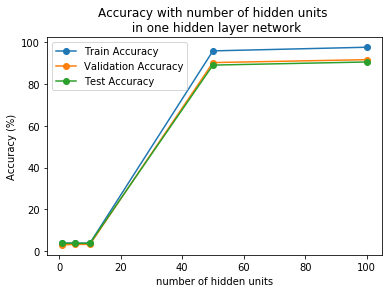

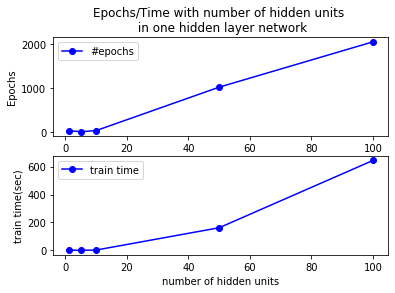

In [135]:
print("------------------Plotting Graphs for Part C - Adaptive LR - One Hidden Layer ------------------")

plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part D - Implementation of ReLU activation for Hidden Layer

In [136]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with ReLU activation------------------


In [ ]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'random')
print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid', 'constant')

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with Sigmoid are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with Sigmoid is = {}".format(epoch))
print("The training time with Sigmoid is = {:2.3f}sec".format(time.time()-start))
print("The training accuracy with Sigmoid is = {:2.3f}%".format(calc_accuracy(X_train, theta, train_class_enc)))
print("The validation accuracy with Sigmoid is = {:2.3f}%".format(calc_accuracy(X_valid, theta, valid_class_enc)))
print("The test accuracy with Sigmoid is = {:2.3f}%".format(calc_accuracy(X_test, theta, test_actual_class_enc)))
print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 100 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 5.277763723152988
Error on this batch = 5.283548896436692
Error on this batch = 1.39600590069058
Cost on val dataset after 2 epochs is = 1.4253011144138321
Initial Cost on Val dataset for this epoch 2 = 1.4253011144138321
Error on this batch = 1.4210312321729544
Error on this batch = 1.3745262784362728
Cost on val dataset after 3 epochs is = 1.4164495842283111
Initial Cost on Val dataset for this epoch 3 = 1.4164495842283111
Error on this batch = 1.4131072835034773
Error on this batch = 1.3656004729111522
Cost on val dataset after 4 epochs is = 1.2930133273688689
Initial Cost on Val dataset for this epoch 4 = 1.2930133273688689
Error on this batch = 1.2886067283404248
Error on this batch = 0.857818

Cost on val dataset after 40 epochs is = 0.42065233306978417
Initial Cost on Val dataset for this epoch 40 = 0.42065233306978417
Error on this batch = 0.43648110686294855
Error on this batch = 0.3906670424382797
Cost on val dataset after 41 epochs is = 0.41826266086608216
Initial Cost on Val dataset for this epoch 41 = 0.41826266086608216
Error on this batch = 0.4351250414236806
Error on this batch = 0.38790885739655784
Cost on val dataset after 42 epochs is = 0.41592701714258046
Initial Cost on Val dataset for this epoch 42 = 0.41592701714258046
Error on this batch = 0.43374238514542796
Error on this batch = 0.3851734471456804
Cost on val dataset after 43 epochs is = 0.4136474470882337
Initial Cost on Val dataset for this epoch 43 = 0.4136474470882337
Error on this batch = 0.432333671496268
Error on this batch = 0.38247195178236604
Cost on val dataset after 44 epochs is = 0.41142395905874635
Initial Cost on Val dataset for this epoch 44 = 0.41142395905874635
Error on this batch = 0.43

Cost on val dataset after 79 epochs is = 0.34497834148599676
Initial Cost on Val dataset for this epoch 79 = 0.34497834148599676
Error on this batch = 0.3602135506361389
Error on this batch = 0.3175956127322148
Cost on val dataset after 80 epochs is = 0.3430686576228651
Initial Cost on Val dataset for this epoch 80 = 0.3430686576228651
Error on this batch = 0.3583845548246125
Error on this batch = 0.3160754681677304
Cost on val dataset after 81 epochs is = 0.3411468129916687
Initial Cost on Val dataset for this epoch 81 = 0.3411468129916687
Error on this batch = 0.3566057598456813
Error on this batch = 0.31448000643090696
Cost on val dataset after 82 epochs is = 0.3392115085692058
Initial Cost on Val dataset for this epoch 82 = 0.3392115085692058
Error on this batch = 0.3548729100636249
Error on this batch = 0.31279957593973406
Cost on val dataset after 83 epochs is = 0.33726227904462774
Initial Cost on Val dataset for this epoch 83 = 0.33726227904462774
Error on this batch = 0.3531815

Cost on val dataset after 118 epochs is = 0.2777546603282827
Initial Cost on Val dataset for this epoch 118 = 0.2777546603282827
Error on this batch = 0.298240024499238
Error on this batch = 0.24674310136323307
Cost on val dataset after 119 epochs is = 0.2764175660966179
Initial Cost on Val dataset for this epoch 119 = 0.2764175660966179
Error on this batch = 0.29671457277361213
Error on this batch = 0.24539075907480154
Cost on val dataset after 120 epochs is = 0.27509131375066914
Initial Cost on Val dataset for this epoch 120 = 0.27509131375066914
Error on this batch = 0.2951941364164282
Error on this batch = 0.24405680034426191
Cost on val dataset after 121 epochs is = 0.27377633704255794
Initial Cost on Val dataset for this epoch 121 = 0.27377633704255794
Error on this batch = 0.2936785813335336
Error on this batch = 0.24274236866680102
Cost on val dataset after 122 epochs is = 0.2724734152559597
Initial Cost on Val dataset for this epoch 122 = 0.2724734152559597
Error on this batch

Cost on val dataset after 157 epochs is = 0.23841974052742743
Initial Cost on Val dataset for this epoch 157 = 0.23841974052742743
Error on this batch = 0.2477032572216136
Error on this batch = 0.20843340132964178
Cost on val dataset after 158 epochs is = 0.23772515713297065
Initial Cost on Val dataset for this epoch 158 = 0.23772515713297065
Error on this batch = 0.24670912671028844
Error on this batch = 0.20771822126726947
Cost on val dataset after 159 epochs is = 0.237040901326183
Initial Cost on Val dataset for this epoch 159 = 0.237040901326183
Error on this batch = 0.24572776628815263
Error on this batch = 0.20701092622012454
Cost on val dataset after 160 epochs is = 0.23636666946953466
Initial Cost on Val dataset for this epoch 160 = 0.23636666946953466
Error on this batch = 0.24475890579386841
Error on this batch = 0.2063112686069681
Cost on val dataset after 161 epochs is = 0.23570217117055853
Initial Cost on Val dataset for this epoch 161 = 0.23570217117055853
Error on this b

Cost on val dataset after 196 epochs is = 0.2170009944865556
Initial Cost on Val dataset for this epoch 196 = 0.2170009944865556
Error on this batch = 0.216476668531201
Error on this batch = 0.18468042275806135
Cost on val dataset after 197 epochs is = 0.21656546535123655
Initial Cost on Val dataset for this epoch 197 = 0.21656546535123655
Error on this batch = 0.21583962728978698
Error on this batch = 0.18415043653665916
Cost on val dataset after 198 epochs is = 0.21613420976329875
Initial Cost on Val dataset for this epoch 198 = 0.21613420976329875
Error on this batch = 0.21520926561814008
Error on this batch = 0.18362341134562166
Cost on val dataset after 199 epochs is = 0.2157071582581423
Initial Cost on Val dataset for this epoch 199 = 0.2157071582581423
Error on this batch = 0.21458549846243113
Error on this batch = 0.18309931292978532
Cost on val dataset after 200 epochs is = 0.21528424330787344
Initial Cost on Val dataset for this epoch 200 = 0.21528424330787344
Error on this b

Cost on val dataset after 235 epochs is = 0.20266276962165153
Initial Cost on Val dataset for this epoch 235 = 0.20266276962165153
Error on this batch = 0.1958028580239009
Error on this batch = 0.1659869980229813
Cost on val dataset after 236 epochs is = 0.2023542920412365
Initial Cost on Val dataset for this epoch 236 = 0.2023542920412365
Error on this batch = 0.1953633241268926
Error on this batch = 0.1655565433996717
Cost on val dataset after 237 epochs is = 0.20204822399224603
Initial Cost on Val dataset for this epoch 237 = 0.20204822399224603
Error on this batch = 0.1949272109537132
Error on this batch = 0.1651283558218891
Cost on val dataset after 238 epochs is = 0.20174453023653108
Initial Cost on Val dataset for this epoch 238 = 0.20174453023653108
Error on this batch = 0.19449444436800828
Error on this batch = 0.1647024249285081
Cost on val dataset after 239 epochs is = 0.20144317577848359
Initial Cost on Val dataset for this epoch 239 = 0.20144317577848359
Error on this batc

Cost on val dataset after 274 epochs is = 0.19207208663361622
Initial Cost on Val dataset for this epoch 274 = 0.19207208663361622
Error on this batch = 0.18047281672729054
Error on this batch = 0.15075745688799722
Cost on val dataset after 275 epochs is = 0.19182446024958905
Initial Cost on Val dataset for this epoch 275 = 0.19182446024958905
Error on this batch = 0.18009460416776082
Error on this batch = 0.15040052923853553
Cost on val dataset after 276 epochs is = 0.19157602640897578
Initial Cost on Val dataset for this epoch 276 = 0.19157602640897578
Error on this batch = 0.1797119267424899
Error on this batch = 0.15004331645672894
Cost on val dataset after 277 epochs is = 0.19132624434428258
Initial Cost on Val dataset for this epoch 277 = 0.19132624434428258
Error on this batch = 0.17932326385175199
Error on this batch = 0.14968502775011774
Cost on val dataset after 278 epochs is = 0.19107440799125203
Initial Cost on Val dataset for this epoch 278 = 0.19107440799125203
Error on t

Cost on val dataset after 313 epochs is = 0.17313592917696316
Initial Cost on Val dataset for this epoch 313 = 0.17313592917696316
Error on this batch = 0.1461768773026894
Error on this batch = 0.11705475692263008
Cost on val dataset after 314 epochs is = 0.17284576670041873
Initial Cost on Val dataset for this epoch 314 = 0.17284576670041873
Error on this batch = 0.14566875459064618
Error on this batch = 0.11659100886146258
Cost on val dataset after 315 epochs is = 0.1725628711565229
Initial Cost on Val dataset for this epoch 315 = 0.1725628711565229
Error on this batch = 0.1451724476096081
Error on this batch = 0.11614038891136039
Cost on val dataset after 316 epochs is = 0.17228658957927342
Initial Cost on Val dataset for this epoch 316 = 0.17228658957927342
Error on this batch = 0.14468687795740445
Error on this batch = 0.11570192859376568
Cost on val dataset after 317 epochs is = 0.17201635365143017
Initial Cost on Val dataset for this epoch 317 = 0.17201635365143017
Error on this

Cost on val dataset after 352 epochs is = 0.16449331949879456
Initial Cost on Val dataset for this epoch 352 = 0.16449331949879456
Error on this batch = 0.1306936723673026
Error on this batch = 0.10421112194331386
Cost on val dataset after 353 epochs is = 0.1643103051311191
Initial Cost on Val dataset for this epoch 353 = 0.1643103051311191
Error on this batch = 0.13035915617713392
Error on this batch = 0.10395901767952456
Cost on val dataset after 354 epochs is = 0.16412847724197618
Initial Cost on Val dataset for this epoch 354 = 0.16412847724197618
Error on this batch = 0.13002656554908917
Error on this batch = 0.10370907511527228
Cost on val dataset after 355 epochs is = 0.1639478131098774
Initial Cost on Val dataset for this epoch 355 = 0.1639478131098774
Error on this batch = 0.12969586596497035
Error on this batch = 0.10346123153292
Cost on val dataset after 356 epochs is = 0.16376829116736571
Initial Cost on Val dataset for this epoch 356 = 0.16376829116736571
Error on this bat

Cost on val dataset after 391 epochs is = 0.15809026021083888
Initial Cost on Val dataset for this epoch 391 = 0.15809026021083888
Error on this batch = 0.11887150838488125
Error on this batch = 0.09557213115646114
Cost on val dataset after 392 epochs is = 0.1579430044784455
Initial Cost on Val dataset for this epoch 392 = 0.1579430044784455
Error on this batch = 0.11859765086125953
Error on this batch = 0.09537464292584862
Cost on val dataset after 393 epochs is = 0.15779648434076832
Initial Cost on Val dataset for this epoch 393 = 0.15779648434076832
Error on this batch = 0.11832511715175546
Error on this batch = 0.09517805624533314
Cost on val dataset after 394 epochs is = 0.15765069360075773
Initial Cost on Val dataset for this epoch 394 = 0.15765069360075773
Error on this batch = 0.11805389884850337
Error on this batch = 0.09498235582366643
Cost on val dataset after 395 epochs is = 0.15750562616483002
Initial Cost on Val dataset for this epoch 395 = 0.15750562616483002
Error on th

Cost on val dataset after 430 epochs is = 0.15284259196570577
Initial Cost on Val dataset for this epoch 430 = 0.15284259196570577
Error on this batch = 0.10909882934163598
Error on this batch = 0.0884281326055006
Cost on val dataset after 431 epochs is = 0.1527201640256264
Initial Cost on Val dataset for this epoch 431 = 0.1527201640256264
Error on this batch = 0.10887078790504492
Error on this batch = 0.08825770453325343
Cost on val dataset after 432 epochs is = 0.1525982857055074
Initial Cost on Val dataset for this epoch 432 = 0.1525982857055074
Error on this batch = 0.10864377744062001
Error on this batch = 0.08808783540254343
Cost on val dataset after 433 epochs is = 0.1524769534095184
Initial Cost on Val dataset for this epoch 433 = 0.1524769534095184
Error on this batch = 0.10841779139540529
Error on this batch = 0.08791852253414886
Cost on val dataset after 434 epochs is = 0.15235616358393345
Initial Cost on Val dataset for this epoch 434 = 0.15235616358393345
Error on this ba

Cost on val dataset after 469 epochs is = 0.14844502110522795
Initial Cost on Val dataset for this epoch 469 = 0.14844502110522795
Error on this batch = 0.10091142248472966
Error on this batch = 0.08218853640004378
Cost on val dataset after 470 epochs is = 0.14834164604544128
Initial Cost on Val dataset for this epoch 470 = 0.14834164604544128
Error on this batch = 0.10071898916742321
Error on this batch = 0.08203972327237478
Cost on val dataset after 471 epochs is = 0.1482387009702795
Initial Cost on Val dataset for this epoch 471 = 0.1482387009702795
Error on this batch = 0.10052735546241426
Error on this batch = 0.08189149247040792
Cost on val dataset after 472 epochs is = 0.14813618317644617
Initial Cost on Val dataset for this epoch 472 = 0.14813618317644617
Error on this batch = 0.1003365165671023
Error on this batch = 0.08174384611833027
Cost on val dataset after 473 epochs is = 0.14803408997442893
Initial Cost on Val dataset for this epoch 473 = 0.14803408997442893
Error on thi

Cost on val dataset after 508 epochs is = 0.14470847866889844
Initial Cost on Val dataset for this epoch 508 = 0.14470847866889844
Error on this batch = 0.09396228018640197
Error on this batch = 0.07683127145611064
Cost on val dataset after 509 epochs is = 0.14462000193354504
Initial Cost on Val dataset for this epoch 509 = 0.14462000193354504
Error on this batch = 0.09379825489980803
Error on this batch = 0.07670618513763242
Cost on val dataset after 510 epochs is = 0.14453186072158658
Initial Cost on Val dataset for this epoch 510 = 0.14453186072158658
Error on this batch = 0.09363490316481368
Error on this batch = 0.07658171199550644
Cost on val dataset after 511 epochs is = 0.14444405293258653
Initial Cost on Val dataset for this epoch 511 = 0.14444405293258653
Error on this batch = 0.09347222308601254
Error on this batch = 0.07645785093626634
Cost on val dataset after 512 epochs is = 0.14435657648295896
Initial Cost on Val dataset for this epoch 512 = 0.14435657648295896
Error on 

Cost on val dataset after 547 epochs is = 0.14148866711943772
Initial Cost on Val dataset for this epoch 547 = 0.14148866711943772
Error on this batch = 0.08804935425794316
Error on this batch = 0.07239071642470128
Cost on val dataset after 548 epochs is = 0.14141186848237794
Initial Cost on Val dataset for this epoch 548 = 0.14141186848237794
Error on this batch = 0.08791041262180871
Error on this batch = 0.07228804256261741
Cost on val dataset after 549 epochs is = 0.14133533535284598
Initial Cost on Val dataset for this epoch 549 = 0.14133533535284598
Error on this batch = 0.08777208410018346
Error on this batch = 0.07218588833903407
Cost on val dataset after 550 epochs is = 0.14125906623711362
Initial Cost on Val dataset for this epoch 550 = 0.14125906623711362
Error on this batch = 0.08763436709439232
Error on this batch = 0.0720842505248854
Cost on val dataset after 551 epochs is = 0.1411830596556669
Initial Cost on Val dataset for this epoch 551 = 0.1411830596556669
Error on thi

Cost on val dataset after 586 epochs is = 0.13867775581665615
Initial Cost on Val dataset for this epoch 586 = 0.13867775581665615
Error on this batch = 0.08306866431571505
Error on this batch = 0.06874171956332324
Cost on val dataset after 587 epochs is = 0.13861033148760568
Initial Cost on Val dataset for this epoch 587 = 0.13861033148760568
Error on this batch = 0.08295226231531785
Error on this batch = 0.068656915097161
Cost on val dataset after 588 epochs is = 0.1385431245123013
Initial Cost on Val dataset for this epoch 588 = 0.1385431245123013
Error on this batch = 0.08283639597297544
Error on this batch = 0.0685725071416882
Cost on val dataset after 589 epochs is = 0.1384761339100946
Initial Cost on Val dataset for this epoch 589 = 0.1384761339100946
Error on this batch = 0.08272106293499855
Error on this batch = 0.0684884929018745
Cost on val dataset after 590 epochs is = 0.13840935871160542
Initial Cost on Val dataset for this epoch 590 = 0.13840935871160542
Error on this bat

Cost on val dataset after 625 epochs is = 0.13620115195840649
Initial Cost on Val dataset for this epoch 625 = 0.13620115195840649
Error on this batch = 0.07890357936464819
Error on this batch = 0.06570488614863822
Cost on val dataset after 626 epochs is = 0.13614156952634637
Initial Cost on Val dataset for this epoch 626 = 0.13614156952634637
Error on this batch = 0.07880623986200355
Error on this batch = 0.06563372252009522
Cost on val dataset after 627 epochs is = 0.13608217331510183
Initial Cost on Val dataset for this epoch 627 = 0.13608217331510183
Error on this batch = 0.07870933827562702
Error on this batch = 0.06556286574916864
Cost on val dataset after 628 epochs is = 0.13602296268458797
Initial Cost on Val dataset for this epoch 628 = 0.13602296268458797
Error on this batch = 0.07861287202093224
Error on this batch = 0.06549231395595187
Cost on val dataset after 629 epochs is = 0.1359639370009302
Initial Cost on Val dataset for this epoch 629 = 0.1359639370009302
Error on th

Error on this batch = 0.06320133061626475
Cost on val dataset after 664 epochs is = 0.1340100167946191
Initial Cost on Val dataset for this epoch 664 = 0.1340100167946191
Error on this batch = 0.07540832107913825
Error on this batch = 0.06314059224395147
Cost on val dataset after 665 epochs is = 0.13395726930167157
Initial Cost on Val dataset for this epoch 665 = 0.13395726930167157
Error on this batch = 0.07532616184895634
Error on this batch = 0.06308009584611084
Cost on val dataset after 666 epochs is = 0.1339046865483139
Initial Cost on Val dataset for this epoch 666 = 0.1339046865483139
Error on this batch = 0.07524434174334735
Error on this batch = 0.06301983984243328
Cost on val dataset after 667 epochs is = 0.13385226804704764
Initial Cost on Val dataset for this epoch 667 = 0.13385226804704764
Error on this batch = 0.07516285835035072
Error on this batch = 0.0629598226577758
Cost on val dataset after 668 epochs is = 0.13380001331206234
Initial Cost on Val dataset for this epoc

Error on this batch = 0.06099782842811795
Cost on val dataset after 703 epochs is = 0.13207057250748017
Initial Cost on Val dataset for this epoch 703 = 0.13207057250748017
Error on this batch = 0.0724341891459932
Error on this batch = 0.0609454049140248
Cost on val dataset after 704 epochs is = 0.13202389742801526
Initial Cost on Val dataset for this epoch 704 = 0.13202389742801526
Error on this batch = 0.07236356255280547
Error on this batch = 0.06089316581410906
Cost on val dataset after 705 epochs is = 0.1319773686226198
Initial Cost on Val dataset for this epoch 705 = 0.1319773686226198
Error on this batch = 0.07229318886694458
Error on this batch = 0.06084110977645527
Cost on val dataset after 706 epochs is = 0.13193098561680225
Initial Cost on Val dataset for this epoch 706 = 0.13193098561680225
Error on this batch = 0.07222306610969341
Error on this batch = 0.06078923545633844
Cost on val dataset after 707 epochs is = 0.13188474793542015
Initial Cost on Val dataset for this epo

Error on this batch = 0.05907824316676507
Cost on val dataset after 742 epochs is = 0.13035423429860651
Initial Cost on Val dataset for this epoch 742 = 0.13035423429860651
Error on this batch = 0.06985012165391939
Error on this batch = 0.05903208198615888
Cost on val dataset after 743 epochs is = 0.1303129052412079
Initial Cost on Val dataset for this epoch 743 = 0.1303129052412079
Error on this batch = 0.06978800994169164
Error on this batch = 0.058986058489445055
Cost on val dataset after 744 epochs is = 0.13027170338061886
Initial Cost on Val dataset for this epoch 744 = 0.13027170338061886
Error on this batch = 0.06972608367935579
Error on this batch = 0.05894017165489637
Cost on val dataset after 745 epochs is = 0.1302306282144074
Initial Cost on Val dataset for this epoch 745 = 0.1302306282144074
Error on this batch = 0.06966434141764753
Error on this batch = 0.058894420470052465
Cost on val dataset after 746 epochs is = 0.1301896792398534
Initial Cost on Val dataset for this ep

Error on this batch = 0.0573713963899422
Cost on val dataset after 781 epochs is = 0.1288320687404349
Initial Cost on Val dataset for this epoch 781 = 0.1288320687404349
Error on this batch = 0.06755318759467592
Error on this batch = 0.05732993084690035
Cost on val dataset after 782 epochs is = 0.12879532982403918
Initial Cost on Val dataset for this epoch 782 = 0.12879532982403918
Error on this batch = 0.0674973732565068
Error on this batch = 0.05728856977547576
Cost on val dataset after 783 epochs is = 0.12875869879457671
Initial Cost on Val dataset for this epoch 783 = 0.12875869879457671
Error on this batch = 0.06744169904514141
Error on this batch = 0.057247312490052514
Cost on val dataset after 784 epochs is = 0.12872217517945106
Initial Cost on Val dataset for this epoch 784 = 0.12872217517945106
Error on this batch = 0.06738616408857599
Error on this batch = 0.057206158312338475
Cost on val dataset after 785 epochs is = 0.12868575850790856
Initial Cost on Val dataset for this e

Error on this batch = 0.05582594111799919
Cost on val dataset after 820 epochs is = 0.12747504411608576
Initial Cost on Val dataset for this epoch 820 = 0.12747504411608576
Error on this batch = 0.0654732490022747
Error on this batch = 0.05578810191696682
Cost on val dataset after 821 epochs is = 0.12744218155463097
Initial Cost on Val dataset for this epoch 821 = 0.12744218155463097
Error on this batch = 0.06542235589200829
Error on this batch = 0.05575034512025179
Cost on val dataset after 822 epochs is = 0.12740941001286019
Initial Cost on Val dataset for this epoch 822 = 0.12740941001286019
Error on this batch = 0.06537157669403347
Error on this batch = 0.055712670269501656
Cost on val dataset after 823 epochs is = 0.12737672910134476
Initial Cost on Val dataset for this epoch 823 = 0.12737672910134476
Error on this batch = 0.06532091089314383
Error on this batch = 0.05567507691101781
Cost on val dataset after 824 epochs is = 0.12734413843263057
Initial Cost on Val dataset for this

Cost on val dataset after 858 epochs is = 0.12628710231181398
Initial Cost on Val dataset for this epoch 858 = 0.12628710231181398
Error on this batch = 0.06361537053405619
Error on this batch = 0.05440746106845892
Cost on val dataset after 859 epochs is = 0.1262574397081274
Initial Cost on Val dataset for this epoch 859 = 0.1262574397081274
Error on this batch = 0.06356847956321766
Error on this batch = 0.05437253783539241
Cost on val dataset after 860 epochs is = 0.12622785453527297
Initial Cost on Val dataset for this epoch 860 = 0.12622785453527297
Error on this batch = 0.0635216857122165
Error on this batch = 0.054337682544089584
Cost on val dataset after 861 epochs is = 0.12619834646627276
Initial Cost on Val dataset for this epoch 861 = 0.12619834646627276
Error on this batch = 0.06347498860078254
Error on this batch = 0.054302894919899154
Cost on val dataset after 862 epochs is = 0.12616891517575662
Initial Cost on Val dataset for this epoch 862 = 0.12616891517575662
Error on t

Error on this batch = 0.05312622055368932
Cost on val dataset after 897 epochs is = 0.12518479729303056
Initial Cost on Val dataset for this epoch 897 = 0.12518479729303056
Error on this batch = 0.06185535371283358
Error on this batch = 0.05309373155578698
Cost on val dataset after 898 epochs is = 0.12515792930950073
Initial Cost on Val dataset for this epoch 898 = 0.12515792930950073
Error on this batch = 0.06181199553130082
Error on this batch = 0.05306130387875967
Cost on val dataset after 899 epochs is = 0.12513112747471078
Initial Cost on Val dataset for this epoch 899 = 0.12513112747471078
Error on this batch = 0.06176872183661182
Error on this batch = 0.05302893745460363
Cost on val dataset after 900 epochs is = 0.1251043915475263
Initial Cost on Val dataset for this epoch 900 = 0.1251043915475263
Error on this batch = 0.06172553236457362
Error on this batch = 0.05299663222052755
Cost on val dataset after 901 epochs is = 0.12507772128955322
Initial Cost on Val dataset for this e

Cost on val dataset after 935 epochs is = 0.12420847510955799
Initial Cost on Val dataset for this epoch 935 = 0.12420847510955799
Error on this batch = 0.06026507920988337
Error on this batch = 0.05190437237465367
Cost on val dataset after 936 epochs is = 0.12418397251951485
Initial Cost on Val dataset for this epoch 936 = 0.12418397251951485
Error on this batch = 0.06022476363352541
Error on this batch = 0.05187426867861845
Cost on val dataset after 937 epochs is = 0.12415952854220332
Initial Cost on Val dataset for this epoch 937 = 0.12415952854220332
Error on this batch = 0.06018452370499267
Error on this batch = 0.051844227101236935
Cost on val dataset after 938 epochs is = 0.12413514300228692
Initial Cost on Val dataset for this epoch 938 = 0.12413514300228692
Error on this batch = 0.06014435918444849
Error on this batch = 0.05181424773883423
Cost on val dataset after 939 epochs is = 0.1241108157234221
Initial Cost on Val dataset for this epoch 939 = 0.1241108157234221
Error on t

Error on this batch = 0.050804882515561735
Cost on val dataset after 974 epochs is = 0.12329443751349285
Initial Cost on Val dataset for this epoch 974 = 0.12329443751349285
Error on this batch = 0.058745971280310276
Error on this batch = 0.050777193944278425
Cost on val dataset after 975 epochs is = 0.12327205487874533
Initial Cost on Val dataset for this epoch 975 = 0.12327205487874533
Error on this batch = 0.05870834308106227
Error on this batch = 0.050749568523515996
Cost on val dataset after 976 epochs is = 0.12324972024651655
Initial Cost on Val dataset for this epoch 976 = 0.12324972024651655
Error on this batch = 0.058670772770628654
Error on this batch = 0.05072200600939522
Cost on val dataset after 977 epochs is = 0.12322743316369575
Initial Cost on Val dataset for this epoch 977 = 0.12322743316369575
Error on this batch = 0.05863325953206768
Error on this batch = 0.050694506130516515
Cost on val dataset after 978 epochs is = 0.12320519316689083
Initial Cost on Val dataset fo

Error on this batch = 0.049792918497490554
Cost on val dataset after 1012 epochs is = 0.1224734222907496
Initial Cost on Val dataset for this epoch 1012 = 0.1224734222907496
Error on this batch = 0.05734938574486354
Error on this batch = 0.04976722446707437
Cost on val dataset after 1013 epochs is = 0.1224525145884219
Initial Cost on Val dataset for this epoch 1013 = 0.1224525145884219
Error on this batch = 0.05731335897508034
Error on this batch = 0.04974156710116601
Cost on val dataset after 1014 epochs is = 0.12243163717630721
Initial Cost on Val dataset for this epoch 1014 = 0.12243163717630721
Error on this batch = 0.05727736186695322
Error on this batch = 0.04971594557948353
Cost on val dataset after 1015 epochs is = 0.12241078977619206
Initial Cost on Val dataset for this epoch 1015 = 0.12241078977619206
Error on this batch = 0.0572413942195694
Error on this batch = 0.04969035910322788
Cost on val dataset after 1016 epochs is = 0.12238997212480592
Initial Cost on Val dataset for

Error on this batch = 0.048837447908554335
Cost on val dataset after 1050 epochs is = 0.12169875779750813
Initial Cost on Val dataset for this epoch 1050 = 0.12169875779750813
Error on this batch = 0.05600157510998656
Error on this batch = 0.048812807604360096
Cost on val dataset after 1051 epochs is = 0.12167889829024635
Initial Cost on Val dataset for this epoch 1051 = 0.12167889829024635
Error on this batch = 0.05596674138310449
Error on this batch = 0.04878819241520686
Cost on val dataset after 1052 epochs is = 0.12165906517857551
Initial Cost on Val dataset for this epoch 1052 = 0.12165906517857551
Error on this batch = 0.055931943343039095
Error on this batch = 0.048763602491804364
Cost on val dataset after 1053 epochs is = 0.1216392584451017
Initial Cost on Val dataset for this epoch 1053 = 0.1216392584451017
Error on this batch = 0.05589718117964902
Error on this batch = 0.04873903799692908
Cost on val dataset after 1054 epochs is = 0.12161947807368916
Initial Cost on Val datas

Error on this batch = 0.04792055915904575
Cost on val dataset after 1088 epochs is = 0.1209626030874255
Initial Cost on Val dataset for this epoch 1088 = 0.1209626030874255
Error on this batch = 0.0547038460017503
Error on this batch = 0.04789702838897075
Cost on val dataset after 1089 epochs is = 0.12094374607797376
Initial Cost on Val dataset for this epoch 1089 = 0.12094374607797376
Error on this batch = 0.05467041945541177
Error on this batch = 0.04787353136622266
Cost on val dataset after 1090 epochs is = 0.12092491586617692
Initial Cost on Val dataset for this epoch 1090 = 0.12092491586617692
Error on this batch = 0.05463702927627465
Error on this batch = 0.04785006829218684
Cost on val dataset after 1091 epochs is = 0.12090611250136583
Initial Cost on Val dataset for this epoch 1091 = 0.12090611250136583
Error on this batch = 0.0546036753451196
Error on this batch = 0.04782663936383624
Cost on val dataset after 1092 epochs is = 0.12088733603508266
Initial Cost on Val dataset for

Error on this batch = 0.047051465189489904
Cost on val dataset after 1126 epochs is = 0.1202654221716278
Initial Cost on Val dataset for this epoch 1126 = 0.1202654221716278
Error on this batch = 0.0534579671066797
Error on this batch = 0.04702931834407121
Cost on val dataset after 1127 epochs is = 0.12024763151614558
Initial Cost on Val dataset for this epoch 1127 = 0.12024763151614558
Error on this batch = 0.053425814435513884
Error on this batch = 0.047007209540347185
Cost on val dataset after 1128 epochs is = 0.12022987040786651
Initial Cost on Val dataset for this epoch 1128 = 0.12022987040786651
Error on this batch = 0.053393691845031926
Error on this batch = 0.04698513879807033
Cost on val dataset after 1129 epochs is = 0.12021213891488373
Initial Cost on Val dataset for this epoch 1129 = 0.12021213891488373
Error on this batch = 0.05336159914680096
Error on this batch = 0.04696310613237655
Cost on val dataset after 1130 epochs is = 0.12019443710335964
Initial Cost on Val datase

Error on this batch = 0.046236460673116
Cost on val dataset after 1164 epochs is = 0.11961053916493672
Initial Cost on Val dataset for this epoch 1164 = 0.11961053916493672
Error on this batch = 0.05225575975701664
Error on this batch = 0.046215735328059594
Cost on val dataset after 1165 epochs is = 0.11959389728563986
Initial Cost on Val dataset for this epoch 1165 = 0.11959389728563986
Error on this batch = 0.052224623390078294
Error on this batch = 0.04619504564954653
Cost on val dataset after 1166 epochs is = 0.1195772856344635
Initial Cost on Val dataset for this epoch 1166 = 0.1195772856344635
Error on this batch = 0.05219351062566989
Error on this batch = 0.046174391493709915
Cost on val dataset after 1167 epochs is = 0.11956070417258743
Initial Cost on Val dataset for this epoch 1167 = 0.11956070417258743
Error on this batch = 0.05216242133453802
Error on this batch = 0.04615377271302148
Cost on val dataset after 1168 epochs is = 0.11954415285867519
Initial Cost on Val dataset 

Error on this batch = 0.04547253141617492
Cost on val dataset after 1202 epochs is = 0.11899892129259693
Initial Cost on Val dataset for this epoch 1202 = 0.11899892129259693
Error on this batch = 0.051088333133140054
Error on this batch = 0.0454530362576261
Cost on val dataset after 1203 epochs is = 0.11898338502137806
Initial Cost on Val dataset for this epoch 1203 = 0.11898338502137806
Error on this batch = 0.0510580317145833
Error on this batch = 0.04543356957550751
Cost on val dataset after 1204 epochs is = 0.11896787637355306
Initial Cost on Val dataset for this epoch 1204 = 0.11896787637355306
Error on this batch = 0.051027751361491014
Error on this batch = 0.04541413116607762
Cost on val dataset after 1205 epochs is = 0.11895239526969793
Initial Cost on Val dataset for this epoch 1205 = 0.11895239526969793
Error on this batch = 0.05099749206390916
Error on this batch = 0.045394720826985466
Cost on val dataset after 1206 epochs is = 0.1189369416309552
Initial Cost on Val dataset

Error on this batch = 0.0447501889394728
Cost on val dataset after 1240 epochs is = 0.11842736399444766
Initial Cost on Val dataset for this epoch 1240 = 0.11842736399444766
Error on this batch = 0.049951683415417496
Error on this batch = 0.04473165412424203
Cost on val dataset after 1241 epochs is = 0.11841283033793935
Initial Cost on Val dataset for this epoch 1241 = 0.11841283033793935
Error on this batch = 0.04992218301717637
Error on this batch = 0.04471314200632721
Cost on val dataset after 1242 epochs is = 0.118398322059193
Initial Cost on Val dataset for this epoch 1242 = 0.118398322059193
Error on this batch = 0.049892703747724455
Error on this batch = 0.044694652496762154
Cost on val dataset after 1243 epochs is = 0.11838383911879427
Initial Cost on Val dataset for this epoch 1243 = 0.11838383911879427
Error on this batch = 0.049863245605329405
Error on this batch = 0.0446761855087766
Cost on val dataset after 1244 epochs is = 0.11836938147730539
Initial Cost on Val dataset f

Error on this batch = 0.04406108971298144
Cost on val dataset after 1278 epochs is = 0.11789249206780518
Initial Cost on Val dataset for this epoch 1278 = 0.11789249206780518
Error on this batch = 0.048845512013349295
Error on this batch = 0.04404335121308616
Cost on val dataset after 1279 epochs is = 0.11787887994242519
Initial Cost on Val dataset for this epoch 1279 = 0.11787887994242519
Error on this batch = 0.04881681491687633
Error on this batch = 0.04402563089348005
Cost on val dataset after 1280 epochs is = 0.11786528994827115
Initial Cost on Val dataset for this epoch 1280 = 0.11786528994827115
Error on this batch = 0.04878813913854534
Error on this batch = 0.04400792850939722
Cost on val dataset after 1281 epochs is = 0.11785172190229007
Initial Cost on Val dataset for this epoch 1281 = 0.11785172190229007
Error on this batch = 0.048759484694275525
Error on this batch = 0.04399024380437118
Cost on val dataset after 1282 epochs is = 0.11783817561476209
Initial Cost on Val datas

Error on this batch = 0.0433966853788606
Cost on val dataset after 1316 epochs is = 0.11738878285371823
Initial Cost on Val dataset for this epoch 1316 = 0.11738878285371823
Error on this batch = 0.047769640922423535
Error on this batch = 0.04337933624325065
Cost on val dataset after 1317 epochs is = 0.11737583083956228
Initial Cost on Val dataset for this epoch 1317 = 0.11737583083956228
Error on this batch = 0.04774168810443175
Error on this batch = 0.04336198370828461
Cost on val dataset after 1318 epochs is = 0.11736288963757714
Initial Cost on Val dataset for this epoch 1318 = 0.11736288963757714
Error on this batch = 0.04771374759762953
Error on this batch = 0.04334462663529222
Cost on val dataset after 1319 epochs is = 0.11734995880089838
Initial Cost on Val dataset for this epoch 1319 = 0.11734995880089838
Error on this batch = 0.04768581846483674
Error on this batch = 0.04332726383036202
Cost on val dataset after 1320 epochs is = 0.11733703786816298
Initial Cost on Val dataset

Error on this batch = 0.042717691184272384
Cost on val dataset after 1354 epochs is = 0.11689815721697241
Initial Cost on Val dataset for this epoch 1354 = 0.11689815721697241
Error on this batch = 0.04669837917850319
Error on this batch = 0.04269830207165875
Cost on val dataset after 1355 epochs is = 0.11688496558179656
Initial Cost on Val dataset for this epoch 1355 = 0.11688496558179656
Error on this batch = 0.04666884484712377
Error on this batch = 0.04267872923907195
Cost on val dataset after 1356 epochs is = 0.11687172480573968
Initial Cost on Val dataset for this epoch 1356 = 0.11687172480573968
Error on this batch = 0.046639117655918605
Error on this batch = 0.04265895607049483
Cost on val dataset after 1357 epochs is = 0.11685842938579087
Initial Cost on Val dataset for this epoch 1357 = 0.11685842938579087
Error on this batch = 0.04660917758270793
Error on this batch = 0.04263896413035844
Cost on val dataset after 1358 epochs is = 0.116845073199224
Initial Cost on Val dataset

Error on this batch = 0.04067858546955568
Cost on val dataset after 1392 epochs is = 0.11583037262029346
Initial Cost on Val dataset for this epoch 1392 = 0.11583037262029346
Error on this batch = 0.043640838677381735
Error on this batch = 0.04037218462524505
Cost on val dataset after 1393 epochs is = 0.11565655178258256
Initial Cost on Val dataset for this epoch 1393 = 0.11565655178258256
Error on this batch = 0.04312981839826545
Error on this batch = 0.04001476417361486
Cost on val dataset after 1394 epochs is = 0.11544097122119876
Initial Cost on Val dataset for this epoch 1394 = 0.11544097122119876
Error on this batch = 0.04253473405301417
Error on this batch = 0.03961242870122175
Cost on val dataset after 1395 epochs is = 0.11518293422074383
Initial Cost on Val dataset for this epoch 1395 = 0.11518293422074383
Error on this batch = 0.041878031826484474
Error on this batch = 0.039172530400816
Cost on val dataset after 1396 epochs is = 0.11488709311716175
Initial Cost on Val dataset

Error on this batch = 0.030610680855696116
Cost on val dataset after 1430 epochs is = 0.10858661611709904
Initial Cost on Val dataset for this epoch 1430 = 0.10858661611709904
Error on this batch = 0.03166261243295555
Error on this batch = 0.030527529459437774
Cost on val dataset after 1431 epochs is = 0.10850927578788629
Initial Cost on Val dataset for this epoch 1431 = 0.10850927578788629
Error on this batch = 0.03158207560107111
Error on this batch = 0.030445849094783806
Cost on val dataset after 1432 epochs is = 0.10843444098713952
Initial Cost on Val dataset for this epoch 1432 = 0.10843444098713952
Error on this batch = 0.03150523953884281
Error on this batch = 0.03036549781372246
Cost on val dataset after 1433 epochs is = 0.10836197793036187
Initial Cost on Val dataset for this epoch 1433 = 0.10836197793036187
Error on this batch = 0.03143185684670872
Error on this batch = 0.030286351347496448
Cost on val dataset after 1434 epochs is = 0.10829176172758025
Initial Cost on Val dat

Error on this batch = 0.027982589254173122
Cost on val dataset after 1468 epochs is = 0.1067053693329067
Initial Cost on Val dataset for this epoch 1468 = 0.1067053693329067
Error on this batch = 0.02996439626330261
Error on this batch = 0.027923974589621585
Cost on val dataset after 1469 epochs is = 0.10667284280487525
Initial Cost on Val dataset for this epoch 1469 = 0.10667284280487525
Error on this batch = 0.029937595464361682
Error on this batch = 0.02786591580952491
Cost on val dataset after 1470 epochs is = 0.10664080359694976
Initial Cost on Val dataset for this epoch 1470 = 0.10664080359694976
Error on this batch = 0.029911175084738728
Error on this batch = 0.027808417557526898
Cost on val dataset after 1471 epochs is = 0.10660923592698852
Initial Cost on Val dataset for this epoch 1471 = 0.10660923592698852
Error on this batch = 0.029885117173009217
Error on this batch = 0.027751484044611044
Cost on val dataset after 1472 epochs is = 0.10657812471363616
Initial Cost on Val da

Error on this batch = 0.026148955649600816
Cost on val dataset after 1506 epochs is = 0.10571646116831572
Initial Cost on Val dataset for this epoch 1506 = 0.10571646116831572
Error on this batch = 0.029114678229454065
Error on this batch = 0.02611070927574236
Cost on val dataset after 1507 epochs is = 0.10569532602990978
Initial Cost on Val dataset for this epoch 1507 = 0.10569532602990978
Error on this batch = 0.02909519306779071
Error on this batch = 0.026072886165678738
Cost on val dataset after 1508 epochs is = 0.10567436844143616
Initial Cost on Val dataset for this epoch 1508 = 0.10567436844143616
Error on this batch = 0.029075797891960495
Error on this batch = 0.026035477971993137
Cost on val dataset after 1509 epochs is = 0.10565358468519545
Initial Cost on Val dataset for this epoch 1509 = 0.10565358468519545
Error on this batch = 0.029056490351330462
Error on this batch = 0.025998476338413803
Cost on val dataset after 1510 epochs is = 0.10563297115810719
Initial Cost on Val 

Error on this batch = 0.024926486737108303
Cost on val dataset after 1544 epochs is = 0.10501338497071448
Initial Cost on Val dataset for this epoch 1544 = 0.10501338497071448
Error on this batch = 0.02842403803038917
Error on this batch = 0.02489897621932027
Cost on val dataset after 1545 epochs is = 0.10499708995088225
Initial Cost on Val dataset for this epoch 1545 = 0.10499708995088225
Error on this batch = 0.028406993197099252
Error on this batch = 0.024871625132405907
Cost on val dataset after 1546 epochs is = 0.10498088408932371
Initial Cost on Val dataset for this epoch 1546 = 0.10498088408932371
Error on this batch = 0.02838999830032913
Error on this batch = 0.024844428756833604
Cost on val dataset after 1547 epochs is = 0.10496476597029332
Initial Cost on Val dataset for this epoch 1547 = 0.10496476597029332
Error on this batch = 0.028373053003728686
Error on this batch = 0.024817382494328074
Cost on val dataset after 1548 epochs is = 0.10494873420547765
Initial Cost on Val d

Error on this batch = 0.02396191286290569
Cost on val dataset after 1582 epochs is = 0.10444668783881624
Initial Cost on Val dataset for this epoch 1582 = 0.10444668783881624
Error on this batch = 0.027808854225183564
Error on this batch = 0.02393810260776512
Cost on val dataset after 1583 epochs is = 0.10443298405283019
Initial Cost on Val dataset for this epoch 1583 = 0.10443298405283019
Error on this batch = 0.02779348902903574
Error on this batch = 0.023914349382355746
Cost on val dataset after 1584 epochs is = 0.10441933161109843
Initial Cost on Val dataset for this epoch 1584 = 0.10441933161109843
Error on this batch = 0.02777816154758572
Error on this batch = 0.023890652222983286
Cost on val dataset after 1585 epochs is = 0.10440572991046188
Initial Cost on Val dataset for this epoch 1585 = 0.10440572991046188
Error on this batch = 0.0277628714316287
Error on this batch = 0.023867010224221285
Cost on val dataset after 1586 epochs is = 0.10439217836491625
Initial Cost on Val data

Error on this batch = 0.02309224638641121
Cost on val dataset after 1620 epochs is = 0.10395801673783588
Initial Cost on Val dataset for this epoch 1620 = 0.10395801673783588
Error on this batch = 0.027248850553201996
Error on this batch = 0.023070256215036115
Cost on val dataset after 1621 epochs is = 0.10394595523914935
Initial Cost on Val dataset for this epoch 1621 = 0.10394595523914935
Error on this batch = 0.027234710289917145
Error on this batch = 0.023048310131288018
Cost on val dataset after 1622 epochs is = 0.10393393087749353
Initial Cost on Val dataset for this epoch 1622 = 0.10393393087749353
Error on this batch = 0.02722059779287922
Error on this batch = 0.023026408099886497
Cost on val dataset after 1623 epochs is = 0.10392194343078891
Initial Cost on Val dataset for this epoch 1623 = 0.10392194343078891
Error on this batch = 0.027206512902747403
Error on this batch = 0.023004550089978017
Cost on val dataset after 1624 epochs is = 0.10390999268093092
Initial Cost on Val 

Error on this batch = 0.022287497451804725
Cost on val dataset after 1658 epochs is = 0.10352413215136283
Initial Cost on Val dataset for this epoch 1658 = 0.10352413215136283
Error on this batch = 0.026729999545311994
Error on this batch = 0.022267175223366957
Cost on val dataset after 1659 epochs is = 0.10351334883667139
Initial Cost on Val dataset for this epoch 1659 = 0.10351334883667139
Error on this batch = 0.02671683592981923
Error on this batch = 0.022246896795716727
Cost on val dataset after 1660 epochs is = 0.10350259591537235
Initial Cost on Val dataset for this epoch 1660 = 0.10350259591537235
Error on this batch = 0.026703696666471054
Error on this batch = 0.022226662156739695
Cost on val dataset after 1661 epochs is = 0.10349187323664756
Initial Cost on Val dataset for this epoch 1661 = 0.10349187323664756
Error on this batch = 0.026690581722485746
Error on this batch = 0.022206471293231455
Cost on val dataset after 1662 epochs is = 0.10348118065044414
Initial Cost on Val

Error on this batch = 0.021545860634750273
Cost on val dataset after 1696 epochs is = 0.10313451259748782
Initial Cost on Val dataset for this epoch 1696 = 0.10313451259748782
Error on this batch = 0.02624675311989659
Error on this batch = 0.02152718508051395
Cost on val dataset after 1697 epochs is = 0.10312478413183682
Initial Cost on Val dataset for this epoch 1697 = 0.10312478413183682
Error on this batch = 0.026234505590632635
Error on this batch = 0.02150855212003415
Cost on val dataset after 1698 epochs is = 0.10311508082166046
Initial Cost on Val dataset for this epoch 1698 = 0.10311508082166046
Error on this batch = 0.026222282195338762
Error on this batch = 0.021489961704050452
Cost on val dataset after 1699 epochs is = 0.10310540254318758
Initial Cost on Val dataset for this epoch 1699 = 0.10310540254318758
Error on this batch = 0.026210082944477648
Error on this batch = 0.021471413782602804
Cost on val dataset after 1700 epochs is = 0.10309574917340679
Initial Cost on Val d

Error on this batch = 0.02086566380113714
Cost on val dataset after 1734 epochs is = 0.1027815230698496
Initial Cost on Val dataset for this epoch 1734 = 0.1027815230698496
Error on this batch = 0.02579840139218087
Error on this batch = 0.02084856581788454
Cost on val dataset after 1735 epochs is = 0.10277266920657192
Initial Cost on Val dataset for this epoch 1735 = 0.10277266920657192
Error on this batch = 0.025787077790074737
Error on this batch = 0.020831507986245393
Cost on val dataset after 1736 epochs is = 0.10276383623243056
Initial Cost on Val dataset for this epoch 1736 = 0.10276383623243056
Error on this batch = 0.025775778608807757
Error on this batch = 0.020814490221035983
Cost on val dataset after 1737 epochs is = 0.10275502404240328
Initial Cost on Val dataset for this epoch 1737 = 0.10275502404240328
Error on this batch = 0.025764503846126077
Error on this batch = 0.020797512435734654
Cost on val dataset after 1738 epochs is = 0.10274623253152346
Initial Cost on Val dat

Error on this batch = 0.020243364010631933
Cost on val dataset after 1772 epochs is = 0.10245887195318502
Initial Cost on Val dataset for this epoch 1772 = 0.10245887195318502
Error on this batch = 0.025385187388289307
Error on this batch = 0.020227723217025328
Cost on val dataset after 1773 epochs is = 0.10245073750228988
Initial Cost on Val dataset for this epoch 1773 = 0.10245073750228988
Error on this batch = 0.025374782496884442
Error on this batch = 0.020212118774912975
Cost on val dataset after 1774 epochs is = 0.10244261988668181
Initial Cost on Val dataset for this epoch 1774 = 0.10244261988668181
Error on this batch = 0.025364401282193715
Error on this batch = 0.020196550589918844
Cost on val dataset after 1775 epochs is = 0.10243451899638958
Initial Cost on Val dataset for this epoch 1775 = 0.10243451899638958
Error on this batch = 0.025354043705264104
Error on this batch = 0.020181018569462958
Cost on val dataset after 1776 epochs is = 0.1024264347211884
Initial Cost on Val

Error on this batch = 0.019673950260201065
Cost on val dataset after 1810 epochs is = 0.10216064324127018
Initial Cost on Val dataset for this epoch 1810 = 0.10216064324127018
Error on this batch = 0.025006039638867012
Error on this batch = 0.019659645690193527
Cost on val dataset after 1811 epochs is = 0.10215306787933083
Initial Cost on Val dataset for this epoch 1811 = 0.10215306787933083
Error on this batch = 0.024996497717152014
Error on this batch = 0.019645375743392847
Cost on val dataset after 1812 epochs is = 0.10214550486888305
Initial Cost on Val dataset for this epoch 1812 = 0.10214550486888305
Error on this batch = 0.02498697713095921
Error on this batch = 0.019631140429047688
Cost on val dataset after 1813 epochs is = 0.10213795408261248
Initial Cost on Val dataset for this epoch 1813 = 0.10213795408261248
Error on this batch = 0.0249774777830759
Error on this batch = 0.01961693975851338
Cost on val dataset after 1814 epochs is = 0.10213041539305806
Initial Cost on Val da

Error on this batch = 0.019154883090304695
Cost on val dataset after 1848 epochs is = 0.10188042315732015
Initial Cost on Val dataset for this epoch 1848 = 0.10188042315732015
Error on this batch = 0.024657386204330917
Error on this batch = 0.019141908458523895
Cost on val dataset after 1849 epochs is = 0.10187323330476274
Initial Cost on Val dataset for this epoch 1849 = 0.10187323330476274
Error on this batch = 0.024648558877812272
Error on this batch = 0.019128969123492517
Cost on val dataset after 1850 epochs is = 0.10186605167442317
Initial Cost on Val dataset for this epoch 1850 = 0.10186605167442317
Error on this batch = 0.02463974685569041
Error on this batch = 0.019116065077901617
Cost on val dataset after 1851 epochs is = 0.10185887820198329
Initial Cost on Val dataset for this epoch 1851 = 0.10185887820198329
Error on this batch = 0.02463094992049917
Error on this batch = 0.019103196311608277
Cost on val dataset after 1852 epochs is = 0.10185171282640021
Initial Cost on Val 

Error on this batch = 0.01868636734113595
Cost on val dataset after 1886 epochs is = 0.10161268408342033
Initial Cost on Val dataset for this epoch 1886 = 0.10161268408342033
Error on this batch = 0.02433084977865751
Error on this batch = 0.01867470218235501
Cost on val dataset after 1887 epochs is = 0.10160578805288588
Initial Cost on Val dataset for this epoch 1887 = 0.10160578805288588
Error on this batch = 0.024322451466380787
Error on this batch = 0.018663069829459616
Cost on val dataset after 1888 epochs is = 0.1015988999179483
Initial Cost on Val dataset for this epoch 1888 = 0.1015988999179483
Error on this batch = 0.02431406059364047
Error on this batch = 0.018651470161918888
Cost on val dataset after 1889 epochs is = 0.10159201971577966
Initial Cost on Val dataset for this epoch 1889 = 0.10159201971577966
Error on this batch = 0.02430567699864651
Error on this batch = 0.018639903057383757
Cost on val dataset after 1890 epochs is = 0.10158514748504231
Initial Cost on Val datas

Error on this batch = 0.01826506033575481
Cost on val dataset after 1924 epochs is = 0.10135658703838635
Initial Cost on Val dataset for this epoch 1924 = 0.10135658703838635
Error on this batch = 0.024015786512700973
Error on this batch = 0.018254550103517106
Cost on val dataset after 1925 epochs is = 0.10135002669372582
Initial Cost on Val dataset for this epoch 1925 = 0.10135002669372582
Error on this batch = 0.024007579544036067
Error on this batch = 0.01824406775634695
Cost on val dataset after 1926 epochs is = 0.10134347638685794
Initial Cost on Val dataset for this epoch 1926 = 0.10134347638685794
Error on this batch = 0.023999375536920536
Error on this batch = 0.01823361317914215
Cost on val dataset after 1927 epochs is = 0.10133693618865176
Initial Cost on Val dataset for this epoch 1927 = 0.10133693618865176
Error on this batch = 0.02399117439854191
Error on this batch = 0.018223186258513543
Cost on val dataset after 1928 epochs is = 0.10133040617048053
Initial Cost on Val da

Error on this batch = 0.017884445909729686
Cost on val dataset after 1962 epochs is = 0.10111496560677094
Initial Cost on Val dataset for this epoch 1962 = 0.10111496560677094
Error on this batch = 0.023705264902322304
Error on this batch = 0.017874930861807043
Cost on val dataset after 1963 epochs is = 0.10110883757661115
Initial Cost on Val dataset for this epoch 1963 = 0.10110883757661115
Error on this batch = 0.02369711167214604
Error on this batch = 0.01786544070328064
Cost on val dataset after 1964 epochs is = 0.10110272222295293
Initial Cost on Val dataset for this epoch 1964 = 0.10110272222295293
Error on this batch = 0.023688958652679996
Error on this batch = 0.017855975389512002
Cost on val dataset after 1965 epochs is = 0.10109661959607581
Initial Cost on Val dataset for this epoch 1965 = 0.10109661959607581
Error on this batch = 0.02368080582502082
Error on this batch = 0.01784653487663331
Cost on val dataset after 1966 epochs is = 0.10109052974409664
Initial Cost on Val da

Error on this batch = 0.01753994213227063
Cost on val dataset after 2000 epochs is = 0.10089123708473012
Initial Cost on Val dataset for this epoch 2000 = 0.10089123708473012
Error on this batch = 0.023395862863029766
Error on this batch = 0.01753133100970808
Cost on val dataset after 2001 epochs is = 0.10088560236809392
Initial Cost on Val dataset for this epoch 2001 = 0.10088560236809392
Error on this batch = 0.023387754801024976
Error on this batch = 0.017522741546148923
Cost on val dataset after 2002 epochs is = 0.10087998014678347
Initial Cost on Val dataset for this epoch 2002 = 0.10087998014678347
Error on this batch = 0.023379650517698462
Error on this batch = 0.017514173539067195
Cost on val dataset after 2003 epochs is = 0.10087437034974456
Initial Cost on Val dataset for this epoch 2003 = 0.10087437034974456
Error on this batch = 0.023371550223524964
Error on this batch = 0.017505626775974583
Cost on val dataset after 2004 epochs is = 0.10086877290264518
Initial Cost on Val 

Error on this batch = 0.017225512850408128
Cost on val dataset after 2038 epochs is = 0.10068511078423958
Initial Cost on Val dataset for this epoch 2038 = 0.10068511078423958
Error on this batch = 0.023092360008138215
Error on this batch = 0.017217503981857715
Cost on val dataset after 2039 epochs is = 0.10067988136891069
Initial Cost on Val dataset for this epoch 2039 = 0.10067988136891069
Error on this batch = 0.023084557452072555
Error on this batch = 0.017209503414438117
Cost on val dataset after 2040 epochs is = 0.10067466048752964
Initial Cost on Val dataset for this epoch 2040 = 0.10067466048752964
Error on this batch = 0.02307676702685731
Error on this batch = 0.01720151077372556
Cost on val dataset after 2041 epochs is = 0.10066944804651498
Initial Cost on Val dataset for this epoch 2041 = 0.10066944804651498
Error on this batch = 0.023068988874006324
Error on this batch = 0.01719352569548703
Cost on val dataset after 2042 epochs is = 0.1006642439557413
Initial Cost on Val da

Error on this batch = 0.016924902573663258
Cost on val dataset after 2076 epochs is = 0.10049191446896884
Initial Cost on Val dataset for this epoch 2076 = 0.10049191446896884
Error on this batch = 0.02280498052316969
Error on this batch = 0.016917069537034885
Cost on val dataset after 2077 epochs is = 0.10048697968089348
Initial Cost on Val dataset for this epoch 2077 = 0.10048697968089348
Error on this batch = 0.02279767169414392
Error on this batch = 0.016909241009551455
Cost on val dataset after 2078 epochs is = 0.10048205288013497
Initial Cost on Val dataset for this epoch 2078 = 0.10048205288013497
Error on this batch = 0.022790375243448062
Error on this batch = 0.016901417142240076
Cost on val dataset after 2079 epochs is = 0.1004771341257462
Initial Cost on Val dataset for this epoch 2079 = 0.1004771341257462
Error on this batch = 0.02278309109510726
Error on this batch = 0.016893598091551436
Cost on val dataset after 2080 epochs is = 0.10047222347909014
Initial Cost on Val dat

Error on this batch = 0.016631810210276165
Cost on val dataset after 2114 epochs is = 0.10031062891906976
Initial Cost on Val dataset for this epoch 2114 = 0.10031062891906976
Error on this batch = 0.022535400476970984
Error on this batch = 0.016624261416022454
Cost on val dataset after 2115 epochs is = 0.10030605211499809
Initial Cost on Val dataset for this epoch 2115 = 0.10030605211499809
Error on this batch = 0.02252852161708401
Error on this batch = 0.01661672261762617
Cost on val dataset after 2116 epochs is = 0.1003014864890083
Initial Cost on Val dataset for this epoch 2116 = 0.1003014864890083
Error on this batch = 0.022521653578132853
Error on this batch = 0.01660919388624787
Cost on val dataset after 2117 epochs is = 0.10029693214014072
Initial Cost on Val dataset for this epoch 2117 = 0.10029693214014072
Error on this batch = 0.022514796373273947
Error on this batch = 0.016601675288204686
Cost on val dataset after 2118 epochs is = 0.10029238916788065
Initial Cost on Val dat

Error on this batch = 0.016352268323023465
Cost on val dataset after 2152 epochs is = 0.10014540236517401
Initial Cost on Val dataset for this epoch 2152 = 0.10014540236517401
Error on this batch = 0.02228179594074864
Error on this batch = 0.01634511515381432
Cost on val dataset after 2153 epochs is = 0.10014131745508964
Initial Cost on Val dataset for this epoch 2153 = 0.10014131745508964
Error on this batch = 0.022275339526532018
Error on this batch = 0.016337972093392703
Cost on val dataset after 2154 epochs is = 0.10013724684530038
Initial Cost on Val dataset for this epoch 2154 = 0.10013724684530038
Error on this batch = 0.02226889347308203
Error on this batch = 0.01633083910364218
Cost on val dataset after 2155 epochs is = 0.10013319053123365
Initial Cost on Val dataset for this epoch 2155 = 0.10013319053123365
Error on this batch = 0.022262457579274208
Error on this batch = 0.016323716146324958
Cost on val dataset after 2156 epochs is = 0.10012914849664427
Initial Cost on Val da

Error on this batch = 0.01608737727405581
Cost on val dataset after 2190 epochs is = 0.0999990295392134
Initial Cost on Val dataset for this epoch 2190 = 0.0999990295392134
Error on this batch = 0.022040108055429587
Error on this batch = 0.01608060520510771
Cost on val dataset after 2191 epochs is = 0.09999535303825863
Initial Cost on Val dataset for this epoch 2191 = 0.09999535303825863
Error on this batch = 0.022033702211978163
Error on this batch = 0.01607384485726173
Cost on val dataset after 2192 epochs is = 0.09999168075139095
Initial Cost on Val dataset for this epoch 2192 = 0.09999168075139095
Error on this batch = 0.022027286505879574
Error on this batch = 0.016067096469139446
Cost on val dataset after 2193 epochs is = 0.0999880123995937
Initial Cost on Val dataset for this epoch 2193 = 0.0999880123995937
Error on this batch = 0.02202086070345442
Error on this batch = 0.01606036029052062
Cost on val dataset after 2194 epochs is = 0.09998434772992826
Initial Cost on Val dataset

Error on this batch = 0.01584050938006143
Cost on val dataset after 2228 epochs is = 0.09986178117021126
Initial Cost on Val dataset for this epoch 2228 = 0.09986178117021126
Error on this batch = 0.02179071704243343
Error on this batch = 0.015834358049201712
Cost on val dataset after 2229 epochs is = 0.0998582638707038
Initial Cost on Val dataset for this epoch 2229 = 0.0998582638707038
Error on this batch = 0.0217840617488834
Error on this batch = 0.015828226160933184
Cost on val dataset after 2230 epochs is = 0.09985475393602132
Initial Cost on Val dataset for this epoch 2230 = 0.09985475393602132
Error on this batch = 0.021777405939072604
Error on this batch = 0.01582211374076292
Cost on val dataset after 2231 epochs is = 0.0998512515548208
Initial Cost on Val dataset for this epoch 2231 = 0.0998512515548208
Error on this batch = 0.021770749843900178
Error on this batch = 0.015816020806290344
Cost on val dataset after 2232 epochs is = 0.09984775691043832
Initial Cost on Val dataset

Error on this batch = 0.015620216097532724
Cost on val dataset after 2266 epochs is = 0.09973446788409186
Initial Cost on Val dataset for this epoch 2266 = 0.09973446788409186
Error on this batch = 0.02153884053882969
Error on this batch = 0.01561477580316896
Cost on val dataset after 2267 epochs is = 0.09973131470627498
Initial Cost on Val dataset for this epoch 2267 = 0.09973131470627498
Error on this batch = 0.021532271064773442
Error on this batch = 0.01560935239492826
Cost on val dataset after 2268 epochs is = 0.09972817208850118
Initial Cost on Val dataset for this epoch 2268 = 0.09972817208850118
Error on this batch = 0.02152570603902061
Error on this batch = 0.01560394571979185
Cost on val dataset after 2269 epochs is = 0.09972504001296988
Initial Cost on Val dataset for this epoch 2269 = 0.09972504001296988
Error on this batch = 0.02151914557569972
Error on this batch = 0.015598555619100982
Cost on val dataset after 2270 epochs is = 0.09972191845705337
Initial Cost on Val data

Error on this batch = 0.015423631582148652
Cost on val dataset after 2304 epochs is = 0.0996215723376189
Initial Cost on Val dataset for this epoch 2304 = 0.0996215723376189
Error on this batch = 0.021293487544046714
Error on this batch = 0.01541867793561161
Cost on val dataset after 2305 epochs is = 0.09961876900119443
Initial Cost on Val dataset for this epoch 2305 = 0.09961876900119443
Error on this batch = 0.021287189703018614
Error on this batch = 0.015413731899645788
Cost on val dataset after 2306 epochs is = 0.09961597248800715
Initial Cost on Val dataset for this epoch 2306 = 0.09961597248800715
Error on this batch = 0.021280902433300542
Error on this batch = 0.015408793221022583
Cost on val dataset after 2307 epochs is = 0.09961318264553273
Initial Cost on Val dataset for this epoch 2307 = 0.09961318264553273
Error on this batch = 0.02127462592850602
Error on this batch = 0.015403861654693887
Cost on val dataset after 2308 epochs is = 0.09961039932155714
Initial Cost on Val da

Error on this batch = 0.015239476858709163
Cost on val dataset after 2342 epochs is = 0.09951869623666663
Initial Cost on Val dataset for this epoch 2342 = 0.09951869623666663
Error on this batch = 0.021063078075916668
Error on this batch = 0.015234737019791235
Cost on val dataset after 2343 epochs is = 0.09951606332080354
Initial Cost on Val dataset for this epoch 2343 = 0.09951606332080354
Error on this batch = 0.02105729602777723
Error on this batch = 0.015230003813292106
Cost on val dataset after 2344 epochs is = 0.0995134331781231
Initial Cost on Val dataset for this epoch 2344 = 0.0995134331781231
Error on this batch = 0.02105152954553355
Error on this batch = 0.015225277411795617
Cost on val dataset after 2345 epochs is = 0.09951080575894457
Initial Cost on Val dataset for this epoch 2345 = 0.09951080575894457
Error on this batch = 0.021045778649259154
Error on this batch = 0.015220557990667478
Cost on val dataset after 2346 epochs is = 0.09950818101546426
Initial Cost on Val da

Error on this batch = 0.015065435931012153
Cost on val dataset after 2380 epochs is = 0.09942026898610838
Initial Cost on Val dataset for this epoch 2380 = 0.09942026898610838
Error on this batch = 0.020854099742373292
Error on this batch = 0.01506105873036566
Cost on val dataset after 2381 epochs is = 0.0994177160530772
Initial Cost on Val dataset for this epoch 2381 = 0.0994177160530772
Error on this batch = 0.020848883909315587
Error on this batch = 0.015056693217189375
Cost on val dataset after 2382 epochs is = 0.09941516466329108
Initial Cost on Val dataset for this epoch 2382 = 0.09941516466329108
Error on this batch = 0.020843681554524648
Error on this batch = 0.015052339439526781
Cost on val dataset after 2383 epochs is = 0.09941261479041011
Initial Cost on Val dataset for this epoch 2383 = 0.09941261479041011
Error on this batch = 0.020838492587595056
Error on this batch = 0.015047997441162825
Cost on val dataset after 2384 epochs is = 0.09941006640797688
Initial Cost on Val d

Error on this batch = 0.014907470131061026
Cost on val dataset after 2418 epochs is = 0.09932409896682336
Initial Cost on Val dataset for this epoch 2418 = 0.09932409896682336
Error on this batch = 0.0206646211881158
Error on this batch = 0.014903543776226068
Cost on val dataset after 2419 epochs is = 0.09932158333041465
Initial Cost on Val dataset for this epoch 2419 = 0.09932158333041465
Error on this batch = 0.020659855336559733
Error on this batch = 0.014899628942555363
Cost on val dataset after 2420 epochs is = 0.09931906794677609
Initial Cost on Val dataset for this epoch 2420 = 0.09931906794677609
Error on this batch = 0.020655099643093162
Error on this batch = 0.014895725597164504
Cost on val dataset after 2421 epochs is = 0.09931655276850972
Initial Cost on Val dataset for this epoch 2421 = 0.09931655276850972
Error on this batch = 0.020650354020981476
Error on this batch = 0.014891833706904754
Cost on val dataset after 2422 epochs is = 0.09931403774731373
Initial Cost on Val 

Error on this batch = 0.014766100740067376
Cost on val dataset after 2456 epochs is = 0.09922821750284086
Initial Cost on Val dataset for this epoch 2456 = 0.09922821750284086
Error on this batch = 0.020489888242276898
Error on this batch = 0.014762591041750168
Cost on val dataset after 2457 epochs is = 0.09922567092913168
Initial Cost on Val dataset for this epoch 2457 = 0.09922567092913168
Error on this batch = 0.02048544268642659
Error on this batch = 0.014759091882182922
Cost on val dataset after 2458 epochs is = 0.09922312224661976
Initial Cost on Val dataset for this epoch 2458 = 0.09922312224661976
Error on this batch = 0.02048100359615713
Error on this batch = 0.014755603252461405
Cost on val dataset after 2459 epochs is = 0.0992205713836965
Initial Cost on Val dataset for this epoch 2459 = 0.0992205713836965
Error on this batch = 0.020476570866698084
Error on this batch = 0.01475212514485184
Cost on val dataset after 2460 epochs is = 0.09921801826877692
Initial Cost on Val dat

Error on this batch = 0.014640150493396255
Cost on val dataset after 2494 epochs is = 0.09912938323088352
Initial Cost on Val dataset for this epoch 2494 = 0.09912938323088352
Error on this batch = 0.020324682902135932
Error on this batch = 0.014637044491898697
Cost on val dataset after 2495 epochs is = 0.09912670926200412
Initial Cost on Val dataset for this epoch 2495 = 0.09912670926200412
Error on this batch = 0.02032041797537601
Error on this batch = 0.014633949446741576
Cost on val dataset after 2496 epochs is = 0.09912403078914019
Initial Cost on Val dataset for this epoch 2496 = 0.09912403078914019
Error on this batch = 0.020316156397588565
Error on this batch = 0.014630865384920998
Cost on val dataset after 2497 epochs is = 0.09912134776470655
Initial Cost on Val dataset for this epoch 2497 = 0.09912134776470655
Error on this batch = 0.020311898122080212
Error on this batch = 0.014627792333808351
Cost on val dataset after 2498 epochs is = 0.0991186601421654
Initial Cost on Val 

Error on this batch = 0.014530036758769236
Cost on val dataset after 2532 epochs is = 0.09902430661916921
Initial Cost on Val dataset for this epoch 2532 = 0.09902430661916921
Error on this batch = 0.02016462965571781
Error on this batch = 0.01452736198207556
Cost on val dataset after 2533 epochs is = 0.09902144110847706
Initial Cost on Val dataset for this epoch 2533 = 0.09902144110847706
Error on this batch = 0.020160462268837217
Error on this batch = 0.014524698446741416
Cost on val dataset after 2534 epochs is = 0.09901857062101192
Initial Cost on Val dataset for this epoch 2534 = 0.09901857062101192
Error on this batch = 0.020156296248365912
Error on this batch = 0.014522046080811367
Cost on val dataset after 2535 epochs is = 0.09901569521732109
Initial Cost on Val dataset for this epoch 2535 = 0.09901569521732109
Error on this batch = 0.020152131478415578
Error on this batch = 0.014519404802520586
Cost on val dataset after 2536 epochs is = 0.09901281496499573
Initial Cost on Val 

Error on this batch = 0.014434588949449535
Cost on val dataset after 2570 epochs is = 0.09891312129566401
Initial Cost on Val dataset for this epoch 2570 = 0.09891312129566401
Error on this batch = 0.020005612364752307
Error on this batch = 0.0144321546221896
Cost on val dataset after 2571 epochs is = 0.0989101919894529
Initial Cost on Val dataset for this epoch 2571 = 0.0989101919894529
Error on this batch = 0.02000134321330168
Error on this batch = 0.014429716476692707
Cost on val dataset after 2572 epochs is = 0.09890726715629755
Initial Cost on Val dataset for this epoch 2572 = 0.09890726715629755
Error on this batch = 0.019997065547039523
Error on this batch = 0.014427273770320213
Cost on val dataset after 2573 epochs is = 0.09890434721646664
Initial Cost on Val dataset for this epoch 2573 = 0.09890434721646664
Error on this batch = 0.019992779089861634
Error on this batch = 0.014424825760660709
Cost on val dataset after 2574 epochs is = 0.0989014325886906
Initial Cost on Val data

Error on this batch = 0.014334521385288884
Cost on val dataset after 2608 epochs is = 0.09880766394576503
Initial Cost on Val dataset for this epoch 2608 = 0.09880766394576503
Error on this batch = 0.0198367925814527
Error on this batch = 0.0143316051978688
Cost on val dataset after 2609 epochs is = 0.09880508907658067
Initial Cost on Val dataset for this epoch 2609 = 0.09880508907658067
Error on this batch = 0.01983220016506485
Error on this batch = 0.014328674738550515
Cost on val dataset after 2610 epochs is = 0.09880252392826445
Initial Cost on Val dataset for this epoch 2610 = 0.09880252392826445
Error on this batch = 0.019827603669113656
Error on this batch = 0.014325730266745043
Cost on val dataset after 2611 epochs is = 0.09879996829705207
Initial Cost on Val dataset for this epoch 2611 = 0.09879996829705207
Error on this batch = 0.019823003380292352
Error on this batch = 0.014322772050957742
Cost on val dataset after 2612 epochs is = 0.09879742197228797
Initial Cost on Val dat

Error on this batch = 0.014215985407163257
Cost on val dataset after 2646 epochs is = 0.09871488902423442
Initial Cost on Val dataset for this epoch 2646 = 0.09871488902423442
Error on this batch = 0.01966099214851884
Error on this batch = 0.014212712959947322
Cost on val dataset after 2647 epochs is = 0.09871254527873996
Initial Cost on Val dataset for this epoch 2647 = 0.09871254527873996
Error on this batch = 0.019656352549594924
Error on this batch = 0.014209435307129061
Cost on val dataset after 2648 epochs is = 0.09871020504314398
Initial Cost on Val dataset for this epoch 2648 = 0.09871020504314398
Error on this batch = 0.019651712456685948
Error on this batch = 0.014206152592587852
Cost on val dataset after 2649 epochs is = 0.09870786827729261
Initial Cost on Val dataset for this epoch 2649 = 0.09870786827729261
Error on this batch = 0.019647071835739067
Error on this batch = 0.01420286495574915
Cost on val dataset after 2650 epochs is = 0.0987055349475865
Initial Cost on Val d

Error on this batch = 0.01408894063331003
Cost on val dataset after 2684 epochs is = 0.09862835733764028
Initial Cost on Val dataset for this epoch 2684 = 0.09862835733764028
Error on this batch = 0.019484077854087112
Error on this batch = 0.014085546154093982
Cost on val dataset after 2685 epochs is = 0.09862616174652122
Initial Cost on Val dataset for this epoch 2685 = 0.09862616174652122
Error on this batch = 0.019479402127475436
Error on this batch = 0.01408215020785032
Cost on val dataset after 2686 epochs is = 0.09862397129858291
Initial Cost on Val dataset for this epoch 2686 = 0.09862397129858291
Error on this batch = 0.019474725642828743
Error on this batch = 0.014078752887214772
Cost on val dataset after 2687 epochs is = 0.09862178607509614
Initial Cost on Val dataset for this epoch 2687 = 0.09862178607509614
Error on this batch = 0.01947004846785527
Error on this batch = 0.01407535428686353
Cost on val dataset after 2688 epochs is = 0.09861960615610689
Initial Cost on Val da

Error on this batch = 0.013959906358085339
Cost on val dataset after 2722 epochs is = 0.0985490074249249
Initial Cost on Val dataset for this epoch 2722 = 0.0985490074249249
Error on this batch = 0.019306779732619517
Error on this batch = 0.013956545043078058
Cost on val dataset after 2723 epochs is = 0.09854703636917864
Initial Cost on Val dataset for this epoch 2723 = 0.09854703636917864
Error on this batch = 0.019302157771367092
Error on this batch = 0.013953187674188117
Cost on val dataset after 2724 epochs is = 0.09854507089941267
Initial Cost on Val dataset for this epoch 2724 = 0.09854507089941267
Error on this batch = 0.01929753987476873
Error on this batch = 0.013949834415183889
Cost on val dataset after 2725 epochs is = 0.09854311094107243
Initial Cost on Val dataset for this epoch 2725 = 0.09854311094107243
Error on this batch = 0.019292926148610882
Error on this batch = 0.013946485426552285
Cost on val dataset after 2726 epochs is = 0.09854115641730524
Initial Cost on Val d

Error on this batch = 0.013835921609061741
Cost on val dataset after 2760 epochs is = 0.09847739178524459
Initial Cost on Val dataset for this epoch 2760 = 0.09847739178524459
Error on this batch = 0.019134464137969164
Error on this batch = 0.013832775523325748
Cost on val dataset after 2761 epochs is = 0.09847558309806523
Initial Cost on Val dataset for this epoch 2761 = 0.09847558309806523
Error on this batch = 0.01913002413588198
Error on this batch = 0.013829635212359248
Cost on val dataset after 2762 epochs is = 0.09847377784492116
Initial Cost on Val dataset for this epoch 2762 = 0.09847377784492116
Error on this batch = 0.01912558871996035
Error on this batch = 0.013826500601427575
Cost on val dataset after 2763 epochs is = 0.09847197602316543
Initial Cost on Val dataset for this epoch 2763 = 0.09847197602316543
Error on this batch = 0.01912115785719774
Error on this batch = 0.013823371612083548
Cost on val dataset after 2764 epochs is = 0.09847017763266182
Initial Cost on Val d

Error on this batch = 0.013719642767394232
Cost on val dataset after 2798 epochs is = 0.09841112560109652
Initial Cost on Val dataset for this epoch 2798 = 0.09841112560109652
Error on this batch = 0.01896871031455721
Error on this batch = 0.013716648603611077
Cost on val dataset after 2799 epochs is = 0.09840944955636634
Initial Cost on Val dataset for this epoch 2799 = 0.09840944955636634
Error on this batch = 0.018964423070050952
Error on this batch = 0.013713656476059068
Cost on val dataset after 2800 epochs is = 0.09840777657868803
Initial Cost on Val dataset for this epoch 2800 = 0.09840777657868803
Error on this batch = 0.018960139168743832
Error on this batch = 0.013710666290373154
Cost on val dataset after 2801 epochs is = 0.09840610658595811
Initial Cost on Val dataset for this epoch 2801 = 0.09840610658595811
Error on this batch = 0.018955858560115942
Error on this batch = 0.013707677952945545
Cost on val dataset after 2802 epochs is = 0.09840443948917986
Initial Cost on Val

Error on this batch = 0.013606555768020974
Cost on val dataset after 2836 epochs is = 0.09834835663593795
Initial Cost on Val dataset for this epoch 2836 = 0.09834835663593795
Error on this batch = 0.01880755014478351
Error on this batch = 0.013603579266370769
Cost on val dataset after 2837 epochs is = 0.09834667807479872
Initial Cost on Val dataset for this epoch 2837 = 0.09834667807479872
Error on this batch = 0.018803335601545564
Error on this batch = 0.013600601820736405
Cost on val dataset after 2838 epochs is = 0.09834499456709742
Initial Cost on Val dataset for this epoch 2838 = 0.09834499456709742
Error on this batch = 0.018799121038031753
Error on this batch = 0.01359762337829107
Cost on val dataset after 2839 epochs is = 0.09834330580977163
Initial Cost on Val dataset for this epoch 2839 = 0.09834330580977163
Error on this batch = 0.01879490634827122
Error on this batch = 0.013594643888290427
Cost on val dataset after 2840 epochs is = 0.09834161149987611
Initial Cost on Val d

Error on this batch = 0.013492503962997376
Cost on val dataset after 2874 epochs is = 0.09827878891535535
Initial Cost on Val dataset for this epoch 2874 = 0.09827878891535535
Error on this batch = 0.018646684029699333
Error on this batch = 0.013489473021330758
Cost on val dataset after 2875 epochs is = 0.09827674475439784
Initial Cost on Val dataset for this epoch 2875 = 0.09827674475439784
Error on this batch = 0.01864241844380598
Error on this batch = 0.013486440611520645
Cost on val dataset after 2876 epochs is = 0.09827468787888094
Initial Cost on Val dataset for this epoch 2876 = 0.09827468787888094
Error on this batch = 0.01863815101850338
Error on this batch = 0.01348340674997738
Cost on val dataset after 2877 epochs is = 0.09827261825100538
Initial Cost on Val dataset for this epoch 2877 = 0.09827261825100538
Error on this batch = 0.018633881773461
Error on this batch = 0.013480371453787936
Cost on val dataset after 2878 epochs is = 0.09827053584156155
Initial Cost on Val data

Error on this batch = 0.013376475142471415
Cost on val dataset after 2912 epochs is = 0.09819233969450171
Initial Cost on Val dataset for this epoch 2912 = 0.09819233969450171
Error on this batch = 0.018483516803376197
Error on this batch = 0.01337340468110579
Cost on val dataset after 2913 epochs is = 0.0981898363827171
Initial Cost on Val dataset for this epoch 2913 = 0.0981898363827171
Error on this batch = 0.018479198587864974
Error on this batch = 0.013370333796297857
Cost on val dataset after 2914 epochs is = 0.09818732246944888
Initial Cost on Val dataset for this epoch 2914 = 0.09818732246944888
Error on this batch = 0.018474879271294924
Error on this batch = 0.013367262531161526
Cost on val dataset after 2915 epochs is = 0.09818479804325621
Initial Cost on Val dataset for this epoch 2915 = 0.09818479804325621
Error on this batch = 0.01847055885026249
Error on this batch = 0.013364190929730015
Cost on val dataset after 2916 epochs is = 0.09818226319195475
Initial Cost on Val da

Error on this batch = 0.0132599001127478
Cost on val dataset after 2950 epochs is = 0.09809042896773065
Initial Cost on Val dataset for this epoch 2950 = 0.09809042896773065
Error on this batch = 0.018318573683173252
Error on this batch = 0.013256846628092598
Cost on val dataset after 2951 epochs is = 0.09808757558695615
Initial Cost on Val dataset for this epoch 2951 = 0.09808757558695615
Error on this batch = 0.018314206712379006
Error on this batch = 0.013253794381636373
Cost on val dataset after 2952 epochs is = 0.09808471413536099
Initial Cost on Val dataset for this epoch 2952 = 0.09808471413536099
Error on this batch = 0.018309838242370487
Error on this batch = 0.01325074339505712
Cost on val dataset after 2953 epochs is = 0.09808184465322847
Initial Cost on Val dataset for this epoch 2953 = 0.09808184465322847
Error on this batch = 0.01830546826176179
Error on this batch = 0.013247693687870944
Cost on val dataset after 2954 epochs is = 0.09807896717950017
Initial Cost on Val da

Error on this batch = 0.013144760754326442
Cost on val dataset after 2988 epochs is = 0.0979765818541798
Initial Cost on Val dataset for this epoch 2988 = 0.0979765818541798
Error on this batch = 0.018151413867457857
Error on this batch = 0.013141751611625997
Cost on val dataset after 2989 epochs is = 0.09797344117807835
Initial Cost on Val dataset for this epoch 2989 = 0.09797344117807835
Error on this batch = 0.018146973473266725
Error on this batch = 0.01313874310197611
Cost on val dataset after 2990 epochs is = 0.09797029334184622
Initial Cost on Val dataset for this epoch 2990 = 0.09797029334184622
Error on this batch = 0.01814253031740331
Error on this batch = 0.013135735178814497
Cost on val dataset after 2991 epochs is = 0.09796713836853066
Initial Cost on Val dataset for this epoch 2991 = 0.09796713836853066
Error on this batch = 0.01813808433329914
Error on this batch = 0.013132727794595116
Cost on val dataset after 2992 epochs is = 0.09796397628236148
Initial Cost on Val dat

Error on this batch = 0.013030407877493948
Cost on val dataset after 3026 epochs is = 0.09785253847777872
Initial Cost on Val dataset for this epoch 3026 = 0.09785253847777872
Error on this batch = 0.01798007500065943
Error on this batch = 0.013027383900903761
Cost on val dataset after 3027 epochs is = 0.09784915968667347
Initial Cost on Val dataset for this epoch 3027 = 0.09784915968667347
Error on this batch = 0.017975472621066354
Error on this batch = 0.013024358337382682
Cost on val dataset after 3028 epochs is = 0.09784577629477804
Initial Cost on Val dataset for this epoch 3028 = 0.09784577629477804
Error on this batch = 0.01797086428678312
Error on this batch = 0.013021331123588236
Cost on val dataset after 3029 epochs is = 0.09784238843410081
Initial Cost on Val dataset for this epoch 3029 = 0.09784238843410081
Error on this batch = 0.017966249917063543
Error on this batch = 0.013018302196539202
Cost on val dataset after 3030 epochs is = 0.09783899624025268
Initial Cost on Val 

Error on this batch = 0.012913912145042684
Cost on val dataset after 3064 epochs is = 0.0977222296072014
Initial Cost on Val dataset for this epoch 3064 = 0.0977222296072014
Error on this batch = 0.017800404364838502
Error on this batch = 0.01291079184949295
Cost on val dataset after 3065 epochs is = 0.09771878934783865
Initial Cost on Val dataset for this epoch 3065 = 0.09771878934783865
Error on this batch = 0.017795527492118435
Error on this batch = 0.01290766838255023
Cost on val dataset after 3066 epochs is = 0.09771535075450238
Initial Cost on Val dataset for this epoch 3066 = 0.09771535075450238
Error on this batch = 0.01779064204923435
Error on this batch = 0.012904541731184991
Cost on val dataset after 3067 epochs is = 0.09771191397101202
Initial Cost on Val dataset for this epoch 3067 = 0.09771191397101202
Error on this batch = 0.017785747943377044
Error on this batch = 0.012901411883216687
Cost on val dataset after 3068 epochs is = 0.09770847913685664
Initial Cost on Val dat

Error on this batch = 0.012793015355470186
Cost on val dataset after 3102 epochs is = 0.09759352428128176
Initial Cost on Val dataset for this epoch 3102 = 0.09759352428128176
Error on this batch = 0.01760795057719677
Error on this batch = 0.012789765781017062
Cost on val dataset after 3103 epochs is = 0.09759020741929443
Initial Cost on Val dataset for this epoch 3103 = 0.09759020741929443
Error on this batch = 0.017602645468819386
Error on this batch = 0.012786512438265847
Cost on val dataset after 3104 epochs is = 0.09758689435934764
Initial Cost on Val dataset for this epoch 3104 = 0.09758689435934764
Error on this batch = 0.01759732518233195
Error on this batch = 0.012783255298823444
Cost on val dataset after 3105 epochs is = 0.09758358508438651
Initial Cost on Val dataset for this epoch 3105 = 0.09758358508438651
Error on this batch = 0.01759198946875616
Error on this batch = 0.012779994333633856
Cost on val dataset after 3106 epochs is = 0.09758027957545502
Initial Cost on Val d

Error on this batch = 0.012666601766442806
Cost on val dataset after 3140 epochs is = 0.09746993322634978
Initial Cost on Val dataset for this epoch 3140 = 0.09746993322634978
Error on this batch = 0.017393420204631298
Error on this batch = 0.012663184513690164
Cost on val dataset after 3141 epochs is = 0.09746674140388552
Initial Cost on Val dataset for this epoch 3141 = 0.09746674140388552
Error on this batch = 0.017387345148930797
Error on this batch = 0.012659762057278081
Cost on val dataset after 3142 epochs is = 0.09746355231631978
Initial Cost on Val dataset for this epoch 3142 = 0.09746355231631978
Error on this batch = 0.017381244034459214
Error on this batch = 0.012656334351291383
Cost on val dataset after 3143 epochs is = 0.09746036594259765
Initial Cost on Val dataset for this epoch 3143 = 0.09746036594259765
Error on this batch = 0.017375116543231955
Error on this batch = 0.01265290134947529
Cost on val dataset after 3144 epochs is = 0.0974571822626983
Initial Cost on Val 

Error on this batch = 0.012532685554777965
Cost on val dataset after 3178 epochs is = 0.09735048305426129
Initial Cost on Val dataset for this epoch 3178 = 0.09735048305426129
Error on this batch = 0.017141460638725865
Error on this batch = 0.012529036988231823
Cost on val dataset after 3179 epochs is = 0.09734739164347411
Initial Cost on Val dataset for this epoch 3179 = 0.09734739164347411
Error on this batch = 0.01713415982571027
Error on this batch = 0.012525381427325153
Cost on val dataset after 3180 epochs is = 0.09734430317691717
Initial Cost on Val dataset for this epoch 3180 = 0.09734430317691717
Error on this batch = 0.01712681989135705
Error on this batch = 0.012521718830281086
Cost on val dataset after 3181 epochs is = 0.09734121769424373
Initial Cost on Val dataset for this epoch 3181 = 0.09734121769424373
Error on this batch = 0.01711944046845631
Error on this batch = 0.012518049155837669
Cost on val dataset after 3182 epochs is = 0.09733813523694575
Initial Cost on Val d

Error on this batch = 0.012388794134461626
Cost on val dataset after 3216 epochs is = 0.09723552837277019
Initial Cost on Val dataset for this epoch 3216 = 0.09723552837277019
Error on this batch = 0.01683344934063789
Error on this batch = 0.012384852323093965
Cost on val dataset after 3217 epochs is = 0.09723258887487547
Initial Cost on Val dataset for this epoch 3217 = 0.09723258887487547
Error on this batch = 0.016824409328920677
Error on this batch = 0.012380901965859099
Cost on val dataset after 3218 epochs is = 0.09722965470013775
Initial Cost on Val dataset for this epoch 3218 = 0.09722965470013775
Error on this batch = 0.016815317237275695
Error on this batch = 0.012376943007896647
Cost on val dataset after 3219 epochs is = 0.09722672591914787
Initial Cost on Val dataset for this epoch 3219 = 0.09722672591914787
Error on this batch = 0.016806172821687847
Error on this batch = 0.012372975392696826
Cost on val dataset after 3220 epochs is = 0.0972238026020154
Initial Cost on Val 

Error on this batch = 0.012232384629290398
Cost on val dataset after 3254 epochs is = 0.09712810904322267
Initial Cost on Val dataset for this epoch 3254 = 0.09712810904322267
Error on this batch = 0.016452274077551572
Error on this batch = 0.01222806155675137
Cost on val dataset after 3255 epochs is = 0.09712541454350157
Initial Cost on Val dataset for this epoch 3255 = 0.09712541454350157
Error on this batch = 0.01644120779017882
Error on this batch = 0.012223726256168174
Cost on val dataset after 3256 epochs is = 0.09712272741330977
Initial Cost on Val dataset for this epoch 3256 = 0.09712272741330977
Error on this batch = 0.016430091595692815
Error on this batch = 0.012219378576839666
Cost on val dataset after 3257 epochs is = 0.09712004768339877
Initial Cost on Val dataset for this epoch 3257 = 0.09712004768339877
Error on this batch = 0.01641892597418253
Error on this batch = 0.012215018365009463
Cost on val dataset after 3258 epochs is = 0.09711737538312998
Initial Cost on Val d

Error on this batch = 0.012058023222685317
Cost on val dataset after 3292 epochs is = 0.09703104594422358
Initial Cost on Val dataset for this epoch 3292 = 0.09703104594422358
Error on this batch = 0.01600246971600455
Error on this batch = 0.01205310534476638
Cost on val dataset after 3293 epochs is = 0.09702863990544354
Initial Cost on Val dataset for this epoch 3293 = 0.09702863990544354
Error on this batch = 0.015990037522143
Error on this batch = 0.012048167601114735
Cost on val dataset after 3294 epochs is = 0.09702624125280675
Initial Cost on Val dataset for this epoch 3294 = 0.09702624125280675
Error on this batch = 0.01597758861169413
Error on this batch = 0.012043209752480117
Cost on val dataset after 3295 epochs is = 0.09702384994914588
Initial Cost on Val dataset for this epoch 3295 = 0.09702384994914588
Error on this batch = 0.015965124122069484
Error on this batch = 0.012038231558853616
Cost on val dataset after 3296 epochs is = 0.0970214659550955
Initial Cost on Val datas

Error on this batch = 0.011855157048100196
Cost on val dataset after 3330 epochs is = 0.09694433264230709
Initial Cost on Val dataset for this epoch 3330 = 0.09694433264230709
Error on this batch = 0.015527680624972052
Error on this batch = 0.011849317214464933
Cost on val dataset after 3331 epochs is = 0.09694216274504723
Initial Cost on Val dataset for this epoch 3331 = 0.09694216274504723
Error on this batch = 0.01551537789433116
Error on this batch = 0.01184344869486562
Cost on val dataset after 3332 epochs is = 0.09693999733204271
Initial Cost on Val dataset for this epoch 3332 = 0.09693999733204271
Error on this batch = 0.015503097389970308
Error on this batch = 0.011837551278828776
Cost on val dataset after 3333 epochs is = 0.09693783629357627
Initial Cost on Val dataset for this epoch 3333 = 0.09693783629357627
Error on this batch = 0.015490839895866566
Error on this batch = 0.011831624757012634
Cost on val dataset after 3334 epochs is = 0.09693567951918278
Initial Cost on Val 

Error on this batch = 0.011611341789141734
Cost on val dataset after 3368 epochs is = 0.0968641528454213
Initial Cost on Val dataset for this epoch 3368 = 0.0968641528454213
Error on this batch = 0.015081251203474285
Error on this batch = 0.011604266759881812
Cost on val dataset after 3369 epochs is = 0.09686208677836838
Initial Cost on Val dataset for this epoch 3369 = 0.09686208677836838
Error on this batch = 0.015070210502881163
Error on this batch = 0.011597155021743034
Cost on val dataset after 3370 epochs is = 0.09686002268751295
Initial Cost on Val dataset for this epoch 3370 = 0.09686002268751295
Error on this batch = 0.015059210528194492
Error on this batch = 0.011590006332549932
Cost on val dataset after 3371 epochs is = 0.09685796065198536
Initial Cost on Val dataset for this epoch 3371 = 0.09685796065198536
Error on this batch = 0.01504825142428447
Error on this batch = 0.01158282044675655
Cost on val dataset after 3372 epochs is = 0.09685590076495243
Initial Cost on Val da

Error on this batch = 0.011314403423048241
Cost on val dataset after 3406 epochs is = 0.09678869811133689
Initial Cost on Val dataset for this epoch 3406 = 0.09678869811133689
Error on this batch = 0.014689924688609168
Error on this batch = 0.011305739735736273
Cost on val dataset after 3407 epochs is = 0.09678686638740612
Initial Cost on Val dataset for this epoch 3407 = 0.09678686638740612
Error on this batch = 0.014680351784287017
Error on this batch = 0.01129702894880448
Cost on val dataset after 3408 epochs is = 0.09678504630910909
Initial Cost on Val dataset for this epoch 3408 = 0.09678504630910909
Error on this batch = 0.014670811305691476
Error on this batch = 0.01128827087641401
Cost on val dataset after 3409 epochs is = 0.09678323804566684
Initial Cost on Val dataset for this epoch 3409 = 0.09678323804566684
Error on this batch = 0.014661302898913757
Error on this batch = 0.011279465347098602
Cost on val dataset after 3410 epochs is = 0.0967814417458895
Initial Cost on Val d

Error on this batch = 0.010951671282509987
Cost on val dataset after 3444 epochs is = 0.09672733688400251
Initial Cost on Val dataset for this epoch 3444 = 0.09672733688400251
Error on this batch = 0.014347512942641303
Error on this batch = 0.010941218840835817
Cost on val dataset after 3445 epochs is = 0.0967259202820663
Initial Cost on Val dataset for this epoch 3445 = 0.0967259202820663
Error on this batch = 0.014339094519945535
Error on this batch = 0.010930722799289291
Cost on val dataset after 3446 epochs is = 0.09672451106948139
Initial Cost on Val dataset for this epoch 3446 = 0.09672451106948139
Error on this batch = 0.014330707887971741
Error on this batch = 0.010920183482404918
Cost on val dataset after 3447 epochs is = 0.09672310899919678
Initial Cost on Val dataset for this epoch 3447 = 0.09672310899919678
Error on this batch = 0.014322353164773219
Error on this batch = 0.010909601223252864
Cost on val dataset after 3448 epochs is = 0.09672171382362325
Initial Cost on Val 

Error on this batch = 0.010527204899794522
Cost on val dataset after 3482 epochs is = 0.09667663999699744
Initial Cost on Val dataset for this epoch 3482 = 0.09667663999699744
Error on this batch = 0.014050244660333977
Error on this batch = 0.010515397957305965
Cost on val dataset after 3483 epochs is = 0.09667533522209386
Initial Cost on Val dataset for this epoch 3483 = 0.09667533522209386
Error on this batch = 0.014043034555333147
Error on this batch = 0.010503566083719678
Cost on val dataset after 3484 epochs is = 0.09667402915132023
Initial Cost on Val dataset for this epoch 3484 = 0.09667402915132023
Error on this batch = 0.014035853841970106
Error on this batch = 0.010491709960711438
Cost on val dataset after 3485 epochs is = 0.09667272161432183
Initial Cost on Val dataset for this epoch 3485 = 0.09667272161432183
Error on this batch = 0.014028702291334745
Error on this batch = 0.010479830279564107
Cost on val dataset after 3486 epochs is = 0.09667141244638984
Initial Cost on Va

Error on this batch = 0.010067348264027377
Cost on val dataset after 3520 epochs is = 0.09662517860796119
Initial Cost on Val dataset for this epoch 3520 = 0.09662517860796119
Error on this batch = 0.013794844179135847
Error on this batch = 0.010055134862321331
Cost on val dataset after 3521 epochs is = 0.09662375843143768
Initial Cost on Val dataset for this epoch 3521 = 0.09662375843143768
Error on this batch = 0.013788578979470568
Error on this batch = 0.010042926882062457
Cost on val dataset after 3522 epochs is = 0.0966223348747271
Initial Cost on Val dataset for this epoch 3522 = 0.0966223348747271
Error on this batch = 0.01378233428843086
Error on this batch = 0.010030725172504189
Cost on val dataset after 3523 epochs is = 0.0966209079837703
Initial Cost on Val dataset for this epoch 3523 = 0.0966209079837703
Error on this batch = 0.013776109932780849
Error on this batch = 0.01001853058221742
Cost on val dataset after 3524 epochs is = 0.09661947780736892
Initial Cost on Val data

Error on this batch = 0.009614061453483735
Cost on val dataset after 3558 epochs is = 0.09656935726380984
Initial Cost on Val dataset for this epoch 3558 = 0.09656935726380984
Error on this batch = 0.013570008469135466
Error on this batch = 0.009602629499918061
Cost on val dataset after 3559 epochs is = 0.09656785431891346
Initial Cost on Val dataset for this epoch 3559 = 0.09656785431891346
Error on this batch = 0.013564431416492731
Error on this batch = 0.00959123282334677
Cost on val dataset after 3560 epochs is = 0.0965663506185122
Initial Cost on Val dataset for this epoch 3560 = 0.0965663506185122
Error on this batch = 0.013558870549684299
Error on this batch = 0.009579872069117758
Cost on val dataset after 3561 epochs is = 0.09656484623537621
Initial Cost on Val dataset for this epoch 3561 = 0.09656484623537621
Error on this batch = 0.01355332578660863
Error on this batch = 0.009568547870907091
Cost on val dataset after 3562 epochs is = 0.09656334124188358
Initial Cost on Val da

Error on this batch = 0.009208916232422438
Cost on val dataset after 3596 epochs is = 0.09651229255278015
Initial Cost on Val dataset for this epoch 3596 = 0.09651229255278015
Error on this batch = 0.01336874579843234
Error on this batch = 0.009199164863479775
Cost on val dataset after 3597 epochs is = 0.0965108078157684
Initial Cost on Val dataset for this epoch 3597 = 0.0965108078157684
Error on this batch = 0.013363722890281466
Error on this batch = 0.009189463616894248
Cost on val dataset after 3598 epochs is = 0.09650932471215756
Initial Cost on Val dataset for this epoch 3598 = 0.09650932471215756
Error on this batch = 0.013358712676718495
Error on this batch = 0.009179812607494876
Cost on val dataset after 3599 epochs is = 0.09650784329201993
Initial Cost on Val dataset for this epoch 3599 = 0.09650784329201993
Error on this batch = 0.013353715045799892
Error on this batch = 0.009170211937425728
Cost on val dataset after 3600 epochs is = 0.0965063636046542
Initial Cost on Val da

Error on this batch = 0.008873758758685102
Cost on val dataset after 3634 epochs is = 0.09645738255879929
Initial Cost on Val dataset for this epoch 3634 = 0.09645738255879929
Error on this batch = 0.01318574140190492
Error on this batch = 0.008865904576032414
Cost on val dataset after 3635 epochs is = 0.0964559880649626
Initial Cost on Val dataset for this epoch 3635 = 0.0964559880649626
Error on this batch = 0.013181108750078021
Error on this batch = 0.008858098147249905
Cost on val dataset after 3636 epochs is = 0.09645459651052957
Initial Cost on Val dataset for this epoch 3636 = 0.09645459651052957
Error on this batch = 0.01317648335057774
Error on this batch = 0.008850339290021087
Cost on val dataset after 3637 epochs is = 0.09645320791236181
Initial Cost on Val dataset for this epoch 3637 = 0.09645320791236181
Error on this batch = 0.013171865018146765
Error on this batch = 0.008842627819351278
Cost on val dataset after 3638 epochs is = 0.09645182228640148
Initial Cost on Val da

In [138]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'constant')

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epoch))
print("The training time with ReLU is = {:2.3f}sec".format(time.time()-start))
print("The training accuracy with ReLU is = {:2.3f}%".format(calc_accuracy(X_train, theta, train_class_enc, 'relu')))
print("The validation accuracy with ReLU is = {:2.3f}%".format(calc_accuracy(X_valid, theta, valid_class_enc, 'relu')))
print("The test accuracy with ReLU is = {:2.3f}%".format(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu')))
print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 100 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2503030226113245
Error on this batch = 3.2503672571136746
Error on this batch = 0.4920019924373213
Cost on val dataset after 2 epochs is = 0.4902361283473663
Initial Cost on Val dataset for this epoch 2 = 0.4902361283473663
Error on this batch = 0.4904829149470691
Error on this batch = 0.4914327637879618
Cost on val dataset after 3 epochs is = 0.4894730297073537
Initial Cost on Val dataset for this epoch 3 = 0.4894730297073537
Error on this batch = 0.4901036355430799
Error on this batch = 0.4912980177120696
Cost on val dataset after 4 epochs is = 0.4890715955980908
Initial Cost on Val dataset for this epoch 4 = 0.4890715955980908
Error on this batch = 0.48991875129579016
Error on this batch = 0.4

Cost on val dataset after 39 epochs is = 0.48088378927114767
Initial Cost on Val dataset for this epoch 39 = 0.48088378927114767
Error on this batch = 0.48052639575600753
Error on this batch = 0.4808206201727452
Cost on val dataset after 40 epochs is = 0.48087930894984987
Initial Cost on Val dataset for this epoch 40 = 0.48087930894984987
Error on this batch = 0.4805172364192665
Error on this batch = 0.48081343847220803
Cost on val dataset after 41 epochs is = 0.48087429251467
Initial Cost on Val dataset for this epoch 41 = 0.48087429251467
Error on this batch = 0.480508173788714
Error on this batch = 0.4808054512649261
Cost on val dataset after 42 epochs is = 0.4808686503894579
Initial Cost on Val dataset for this epoch 42 = 0.4808686503894579
Error on this batch = 0.4804988086518219
Error on this batch = 0.480797010649246
Cost on val dataset after 43 epochs is = 0.4808625637732167
Initial Cost on Val dataset for this epoch 43 = 0.4808625637732167
Error on this batch = 0.4804889634328

Cost on val dataset after 78 epochs is = 0.479802024321167
Initial Cost on Val dataset for this epoch 78 = 0.479802024321167
Error on this batch = 0.4792749455085024
Error on this batch = 0.47908230686071196
Cost on val dataset after 79 epochs is = 0.4796855112823599
Initial Cost on Val dataset for this epoch 79 = 0.4796855112823599
Error on this batch = 0.4791525357225422
Error on this batch = 0.47887383386227556
Cost on val dataset after 80 epochs is = 0.4795521686058631
Initial Cost on Val dataset for this epoch 80 = 0.4795521686058631
Error on this batch = 0.4790149709404834
Error on this batch = 0.4786291670769622
Cost on val dataset after 81 epochs is = 0.4793969678327336
Initial Cost on Val dataset for this epoch 81 = 0.4793969678327336
Error on this batch = 0.4788571960144325
Error on this batch = 0.47833714548144124
Cost on val dataset after 82 epochs is = 0.4792153799345389
Initial Cost on Val dataset for this epoch 82 = 0.4792153799345389
Error on this batch = 0.478676452758

Cost on val dataset after 117 epochs is = 0.4500314891403544
Initial Cost on Val dataset for this epoch 117 = 0.4500314891403544
Error on this batch = 0.4617234378799641
Error on this batch = 0.43681089662144035
Cost on val dataset after 118 epochs is = 0.4497111872224042
Initial Cost on Val dataset for this epoch 118 = 0.4497111872224042
Error on this batch = 0.4613222696851379
Error on this batch = 0.43650669754099497
Cost on val dataset after 119 epochs is = 0.44939064833460085
Initial Cost on Val dataset for this epoch 119 = 0.44939064833460085
Error on this batch = 0.46091664182518544
Error on this batch = 0.4362163858895633
Cost on val dataset after 120 epochs is = 0.4490717896567004
Initial Cost on Val dataset for this epoch 120 = 0.4490717896567004
Error on this batch = 0.46050113773950346
Error on this batch = 0.4359360675755923
Cost on val dataset after 121 epochs is = 0.4487527192738533
Initial Cost on Val dataset for this epoch 121 = 0.4487527192738533
Error on this batch =

Cost on val dataset after 156 epochs is = 0.4265200374035484
Initial Cost on Val dataset for this epoch 156 = 0.4265200374035484
Error on this batch = 0.4266436383588804
Error on this batch = 0.4136674592572764
Cost on val dataset after 157 epochs is = 0.42531890130673206
Initial Cost on Val dataset for this epoch 157 = 0.42531890130673206
Error on this batch = 0.4250773676147349
Error on this batch = 0.412371720719413
Cost on val dataset after 158 epochs is = 0.42408397608880216
Initial Cost on Val dataset for this epoch 158 = 0.42408397608880216
Error on this batch = 0.42348294851318286
Error on this batch = 0.41104871802973164
Cost on val dataset after 159 epochs is = 0.42281984727704996
Initial Cost on Val dataset for this epoch 159 = 0.42281984727704996
Error on this batch = 0.42185972967193736
Error on this batch = 0.40970459657877134
Cost on val dataset after 160 epochs is = 0.421534136676732
Initial Cost on Val dataset for this epoch 160 = 0.421534136676732
Error on this batch 

Cost on val dataset after 195 epochs is = 0.382581943565296
Initial Cost on Val dataset for this epoch 195 = 0.382581943565296
Error on this batch = 0.3701513454875495
Error on this batch = 0.3719755652546942
Cost on val dataset after 196 epochs is = 0.3817079019653283
Initial Cost on Val dataset for this epoch 196 = 0.3817079019653283
Error on this batch = 0.36907240528296753
Error on this batch = 0.37121331557111886
Cost on val dataset after 197 epochs is = 0.38083212959831364
Initial Cost on Val dataset for this epoch 197 = 0.38083212959831364
Error on this batch = 0.3680125137588297
Error on this batch = 0.37046193389007914
Cost on val dataset after 198 epochs is = 0.3799596732866883
Initial Cost on Val dataset for this epoch 198 = 0.3799596732866883
Error on this batch = 0.36696971326347394
Error on this batch = 0.3697102790048752
Cost on val dataset after 199 epochs is = 0.3790878995033805
Initial Cost on Val dataset for this epoch 199 = 0.3790878995033805
Error on this batch = 0

Cost on val dataset after 234 epochs is = 0.3477355330957673
Initial Cost on Val dataset for this epoch 234 = 0.3477355330957673
Error on this batch = 0.3323741451704802
Error on this batch = 0.3413041779696762
Cost on val dataset after 235 epochs is = 0.3467821901428001
Initial Cost on Val dataset for this epoch 235 = 0.3467821901428001
Error on this batch = 0.331460110379387
Error on this batch = 0.3404154270161959
Cost on val dataset after 236 epochs is = 0.34582726111201595
Initial Cost on Val dataset for this epoch 236 = 0.34582726111201595
Error on this batch = 0.33053005979655525
Error on this batch = 0.33947808666450285
Cost on val dataset after 237 epochs is = 0.3448723577986158
Initial Cost on Val dataset for this epoch 237 = 0.3448723577986158
Error on this batch = 0.32960429745265374
Error on this batch = 0.338557648827388
Cost on val dataset after 238 epochs is = 0.3439141125338854
Initial Cost on Val dataset for this epoch 238 = 0.3439141125338854
Error on this batch = 0.

Cost on val dataset after 273 epochs is = 0.31154340905909533
Initial Cost on Val dataset for this epoch 273 = 0.31154340905909533
Error on this batch = 0.29205383483143205
Error on this batch = 0.302232993537364
Cost on val dataset after 274 epochs is = 0.31070004964551146
Initial Cost on Val dataset for this epoch 274 = 0.31070004964551146
Error on this batch = 0.29096929800839716
Error on this batch = 0.3012818857520952
Cost on val dataset after 275 epochs is = 0.3098574201690381
Initial Cost on Val dataset for this epoch 275 = 0.3098574201690381
Error on this batch = 0.28987519679706525
Error on this batch = 0.30032463917076996
Cost on val dataset after 276 epochs is = 0.30902035439301945
Initial Cost on Val dataset for this epoch 276 = 0.30902035439301945
Error on this batch = 0.28878538714263613
Error on this batch = 0.29936375795382125
Cost on val dataset after 277 epochs is = 0.3081883079190357
Initial Cost on Val dataset for this epoch 277 = 0.3081883079190357
Error on this ba

Cost on val dataset after 312 epochs is = 0.28254580478603103
Initial Cost on Val dataset for this epoch 312 = 0.28254580478603103
Error on this batch = 0.2542440390833848
Error on this batch = 0.2718039592743457
Cost on val dataset after 313 epochs is = 0.2819239320786186
Initial Cost on Val dataset for this epoch 313 = 0.2819239320786186
Error on this batch = 0.25351401880807267
Error on this batch = 0.2711452503073795
Cost on val dataset after 314 epochs is = 0.28131573208683
Initial Cost on Val dataset for this epoch 314 = 0.28131573208683
Error on this batch = 0.2527935175350106
Error on this batch = 0.2704997600646948
Cost on val dataset after 315 epochs is = 0.2807116754326099
Initial Cost on Val dataset for this epoch 315 = 0.2807116754326099
Error on this batch = 0.25206968923338446
Error on this batch = 0.269812597088794
Cost on val dataset after 316 epochs is = 0.28011287568078974
Initial Cost on Val dataset for this epoch 316 = 0.28011287568078974
Error on this batch = 0.25

Cost on val dataset after 351 epochs is = 0.2577005289300414
Initial Cost on Val dataset for this epoch 351 = 0.2577005289300414
Error on this batch = 0.22606880901489565
Error on this batch = 0.24535281366207268
Cost on val dataset after 352 epochs is = 0.2570005759921808
Initial Cost on Val dataset for this epoch 352 = 0.2570005759921808
Error on this batch = 0.22524463920395943
Error on this batch = 0.24463019190416802
Cost on val dataset after 353 epochs is = 0.25629346630199773
Initial Cost on Val dataset for this epoch 353 = 0.25629346630199773
Error on this batch = 0.22444735641965793
Error on this batch = 0.2438874634562906
Cost on val dataset after 354 epochs is = 0.2555756992634724
Initial Cost on Val dataset for this epoch 354 = 0.2555756992634724
Error on this batch = 0.22368286875415916
Error on this batch = 0.2431965212671912
Cost on val dataset after 355 epochs is = 0.25486366282565265
Initial Cost on Val dataset for this epoch 355 = 0.25486366282565265
Error on this bat

Cost on val dataset after 390 epochs is = 0.23023737489187932
Initial Cost on Val dataset for this epoch 390 = 0.23023737489187932
Error on this batch = 0.19773496014505704
Error on this batch = 0.21835578993949584
Cost on val dataset after 391 epochs is = 0.22968313196726786
Initial Cost on Val dataset for this epoch 391 = 0.22968313196726786
Error on this batch = 0.19718744568065064
Error on this batch = 0.21773390335721196
Cost on val dataset after 392 epochs is = 0.2291398875708771
Initial Cost on Val dataset for this epoch 392 = 0.2291398875708771
Error on this batch = 0.1966130838611651
Error on this batch = 0.2171032698679689
Cost on val dataset after 393 epochs is = 0.2286094491436756
Initial Cost on Val dataset for this epoch 393 = 0.2286094491436756
Error on this batch = 0.1960917904297164
Error on this batch = 0.21651892190989952
Cost on val dataset after 394 epochs is = 0.22808573441523858
Initial Cost on Val dataset for this epoch 394 = 0.22808573441523858
Error on this ba

Cost on val dataset after 429 epochs is = 0.20785291736172215
Initial Cost on Val dataset for this epoch 429 = 0.20785291736172215
Error on this batch = 0.17935219092290608
Error on this batch = 0.1854536382866351
Cost on val dataset after 430 epochs is = 0.20692108874317003
Initial Cost on Val dataset for this epoch 430 = 0.20692108874317003
Error on this batch = 0.1789244161510328
Error on this batch = 0.18378596855009874
Cost on val dataset after 431 epochs is = 0.20604932729307132
Initial Cost on Val dataset for this epoch 431 = 0.20604932729307132
Error on this batch = 0.17855584701573818
Error on this batch = 0.18212340869654628
Cost on val dataset after 432 epochs is = 0.2051908005596755
Initial Cost on Val dataset for this epoch 432 = 0.2051908005596755
Error on this batch = 0.17817795973020936
Error on this batch = 0.18058020249227646
Cost on val dataset after 433 epochs is = 0.20434924256673717
Initial Cost on Val dataset for this epoch 433 = 0.20434924256673717
Error on this

Cost on val dataset after 468 epochs is = 0.18320697460061644
Initial Cost on Val dataset for this epoch 468 = 0.18320697460061644
Error on this batch = 0.16339892411000287
Error on this batch = 0.1438827734848856
Cost on val dataset after 469 epochs is = 0.182774350447295
Initial Cost on Val dataset for this epoch 469 = 0.182774350447295
Error on this batch = 0.16293838449383288
Error on this batch = 0.14310680396504005
Cost on val dataset after 470 epochs is = 0.18235898262717395
Initial Cost on Val dataset for this epoch 470 = 0.18235898262717395
Error on this batch = 0.16248478188281595
Error on this batch = 0.1423647754259031
Cost on val dataset after 471 epochs is = 0.18195352106214574
Initial Cost on Val dataset for this epoch 471 = 0.18195352106214574
Error on this batch = 0.16204853695112997
Error on this batch = 0.14163865322471905
Cost on val dataset after 472 epochs is = 0.18155012692986935
Initial Cost on Val dataset for this epoch 472 = 0.18155012692986935
Error on this b

Error on this batch = 0.15364103668602597
Error on this batch = 0.12396835642343716
Cost on val dataset after 508 epochs is = 0.17076066924227995
Initial Cost on Val dataset for this epoch 508 = 0.17076066924227995
Error on this batch = 0.15352949499050975
Error on this batch = 0.12367267675314
Cost on val dataset after 509 epochs is = 0.17052432815681057
Initial Cost on Val dataset for this epoch 509 = 0.17052432815681057
Error on this batch = 0.1533816061680807
Error on this batch = 0.12334952048130529
Cost on val dataset after 510 epochs is = 0.17030160561922053
Initial Cost on Val dataset for this epoch 510 = 0.17030160561922053
Error on this batch = 0.15322691066140112
Error on this batch = 0.12303563241180401
Cost on val dataset after 511 epochs is = 0.1700843797842004
Initial Cost on Val dataset for this epoch 511 = 0.1700843797842004
Error on this batch = 0.15307764256602815
Error on this batch = 0.12272373751766914
Cost on val dataset after 512 epochs is = 0.16985200542350198


Error on this batch = 0.11648369618998483
Cost on val dataset after 547 epochs is = 0.163899974800661
Initial Cost on Val dataset for this epoch 547 = 0.163899974800661
Error on this batch = 0.14920732499896505
Error on this batch = 0.11637592910113796
Cost on val dataset after 548 epochs is = 0.1637957835373213
Initial Cost on Val dataset for this epoch 548 = 0.1637957835373213
Error on this batch = 0.14916588472962808
Error on this batch = 0.1162744510226364
Cost on val dataset after 549 epochs is = 0.16369716513493052
Initial Cost on Val dataset for this epoch 549 = 0.16369716513493052
Error on this batch = 0.14909616546518925
Error on this batch = 0.11616127914379704
Cost on val dataset after 550 epochs is = 0.16359494087965504
Initial Cost on Val dataset for this epoch 550 = 0.16359494087965504
Error on this batch = 0.14904188674022312
Error on this batch = 0.116080928118778
Cost on val dataset after 551 epochs is = 0.16350103714921033
Initial Cost on Val dataset for this epoch 55

Cost on val dataset after 585 epochs is = 0.16137885759231296
Initial Cost on Val dataset for this epoch 585 = 0.16137885759231296
Error on this batch = 0.14663274195977236
Error on this batch = 0.11375203898160549
Cost on val dataset after 586 epochs is = 0.16135697525236536
Initial Cost on Val dataset for this epoch 586 = 0.16135697525236536
Error on this batch = 0.14657142959206737
Error on this batch = 0.11368149833260263
Cost on val dataset after 587 epochs is = 0.16132605378602966
Initial Cost on Val dataset for this epoch 587 = 0.16132605378602966
Error on this batch = 0.14646087686589745
Error on this batch = 0.11359114536847116
Cost on val dataset after 588 epochs is = 0.16129740547723692
Initial Cost on Val dataset for this epoch 588 = 0.16129740547723692
Error on this batch = 0.1463750462766008
Error on this batch = 0.11355134245418168
Cost on val dataset after 589 epochs is = 0.16125239120609802
Initial Cost on Val dataset for this epoch 589 = 0.16125239120609802
Error on t

Cost on val dataset after 624 epochs is = 0.1609449795596028
Initial Cost on Val dataset for this epoch 624 = 0.1609449795596028
Error on this batch = 0.14362027657236873
Error on this batch = 0.10966254797010024
Cost on val dataset after 625 epochs is = 0.16095517689286087
Initial Cost on Val dataset for this epoch 625 = 0.16095517689286087
Error on this batch = 0.14350268850523568
Error on this batch = 0.10954192460774141
Cost on val dataset after 626 epochs is = 0.16095399744556718
Initial Cost on Val dataset for this epoch 626 = 0.16095399744556718
Error on this batch = 0.1434320599573085
Error on this batch = 0.10941781875692355
Cost on val dataset after 627 epochs is = 0.16095234938918684
Initial Cost on Val dataset for this epoch 627 = 0.16095234938918684
Error on this batch = 0.14335539805514314
Error on this batch = 0.10928741440139053
Cost on val dataset after 628 epochs is = 0.16094989562344525
Initial Cost on Val dataset for this epoch 628 = 0.16094989562344525
Error on thi

Cost on val dataset after 663 epochs is = 0.16062506819813685
Initial Cost on Val dataset for this epoch 663 = 0.16062506819813685
Error on this batch = 0.14208322971196358
Error on this batch = 0.105845229543127
Cost on val dataset after 664 epochs is = 0.16062491550427505
Initial Cost on Val dataset for this epoch 664 = 0.16062491550427505
Error on this batch = 0.1420080224601057
Error on this batch = 0.10578018164322306
Cost on val dataset after 665 epochs is = 0.16062535244727807
Initial Cost on Val dataset for this epoch 665 = 0.16062535244727807
Error on this batch = 0.14196122633880215
Error on this batch = 0.10569824689399639
Cost on val dataset after 666 epochs is = 0.16061703762499
Initial Cost on Val dataset for this epoch 666 = 0.16061703762499
Error on this batch = 0.14190782798358595
Error on this batch = 0.10565861992010366
Cost on val dataset after 667 epochs is = 0.1606122445942181
Initial Cost on Val dataset for this epoch 667 = 0.1606122445942181
Error on this batch 

Cost on val dataset after 702 epochs is = 0.16071535443868928
Initial Cost on Val dataset for this epoch 702 = 0.16071535443868928
Error on this batch = 0.14129641234357643
Error on this batch = 0.10655706144797186
Cost on val dataset after 703 epochs is = 0.16071524039710663
Initial Cost on Val dataset for this epoch 703 = 0.16071524039710663
Error on this batch = 0.14129316463460337
Error on this batch = 0.10668768716830891
Cost on val dataset after 704 epochs is = 0.16072205774547219
Initial Cost on Val dataset for this epoch 704 = 0.16072205774547219
Error on this batch = 0.14127556678800698
Error on this batch = 0.10683722462139134
Cost on val dataset after 705 epochs is = 0.16072991925256347
Initial Cost on Val dataset for this epoch 705 = 0.16072991925256347
Error on this batch = 0.14126814103452395
Error on this batch = 0.10697553005111149
Cost on val dataset after 706 epochs is = 0.16073660993218353
Initial Cost on Val dataset for this epoch 706 = 0.16073660993218353
Error on 

Cost on val dataset after 741 epochs is = 0.1603366526240256
Initial Cost on Val dataset for this epoch 741 = 0.1603366526240256
Error on this batch = 0.13785763390911637
Error on this batch = 0.11139638651204806
Cost on val dataset after 742 epochs is = 0.16031976481145038
Initial Cost on Val dataset for this epoch 742 = 0.16031976481145038
Error on this batch = 0.13772582612432124
Error on this batch = 0.11139502905112206
Cost on val dataset after 743 epochs is = 0.16031435224206897
Initial Cost on Val dataset for this epoch 743 = 0.16031435224206897
Error on this batch = 0.1376291348461924
Error on this batch = 0.11145875245445279
Cost on val dataset after 744 epochs is = 0.16030837682189883
Initial Cost on Val dataset for this epoch 744 = 0.16030837682189883
Error on this batch = 0.1375331045418367
Error on this batch = 0.11150041610724287
Cost on val dataset after 745 epochs is = 0.1603024356832735
Initial Cost on Val dataset for this epoch 745 = 0.1603024356832735
Error on this b

Error on this batch = 0.1339651037660121
Error on this batch = 0.11145557998613718
Cost on val dataset after 780 epochs is = 0.1604716095666764
Initial Cost on Val dataset for this epoch 780 = 0.1604716095666764
Error on this batch = 0.13382932005856998
Error on this batch = 0.11142107915027907
Cost on val dataset after 781 epochs is = 0.16045817463894846
Initial Cost on Val dataset for this epoch 781 = 0.16045817463894846
Error on this batch = 0.13369469691603833
Error on this batch = 0.11140881659310915
Cost on val dataset after 782 epochs is = 0.16044956750910033
Initial Cost on Val dataset for this epoch 782 = 0.16044956750910033
Error on this batch = 0.133554152739031
Error on this batch = 0.1113653210276293
Cost on val dataset after 783 epochs is = 0.1604376005313494
Initial Cost on Val dataset for this epoch 783 = 0.1604376005313494
Error on this batch = 0.13338496597120275
Error on this batch = 0.11135813457947254
Cost on val dataset after 784 epochs is = 0.16043074408331628
In

Cost on val dataset after 818 epochs is = 0.15901687563778985
Initial Cost on Val dataset for this epoch 818 = 0.15901687563778985
Error on this batch = 0.1285389532169883
Error on this batch = 0.1079387817584746
Cost on val dataset after 819 epochs is = 0.1589824072755513
Initial Cost on Val dataset for this epoch 819 = 0.1589824072755513
Error on this batch = 0.12833908847048547
Error on this batch = 0.10787555470129352
Cost on val dataset after 820 epochs is = 0.15895052649356517
Initial Cost on Val dataset for this epoch 820 = 0.15895052649356517
Error on this batch = 0.12817971863058578
Error on this batch = 0.10780480109305941
Cost on val dataset after 821 epochs is = 0.1589255171840071
Initial Cost on Val dataset for this epoch 821 = 0.1589255171840071
Error on this batch = 0.12803000142189663
Error on this batch = 0.10773160818123309
Cost on val dataset after 822 epochs is = 0.15889256317174133
Initial Cost on Val dataset for this epoch 822 = 0.15889256317174133
Error on this b

Error on this batch = 0.10558478425148315
Cost on val dataset after 857 epochs is = 0.1579203645138386
Initial Cost on Val dataset for this epoch 857 = 0.1579203645138386
Error on this batch = 0.1254330122520759
Error on this batch = 0.10554027015343484
Cost on val dataset after 858 epochs is = 0.15789310064328846
Initial Cost on Val dataset for this epoch 858 = 0.15789310064328846
Error on this batch = 0.1253710438147019
Error on this batch = 0.10546311640494554
Cost on val dataset after 859 epochs is = 0.15786549209471593
Initial Cost on Val dataset for this epoch 859 = 0.15786549209471593
Error on this batch = 0.12530650476710206
Error on this batch = 0.10542021540975384
Cost on val dataset after 860 epochs is = 0.15784782429285915
Initial Cost on Val dataset for this epoch 860 = 0.15784782429285915
Error on this batch = 0.12525494713425628
Error on this batch = 0.10538123156511292
Cost on val dataset after 861 epochs is = 0.1578205220209949
Initial Cost on Val dataset for this epoc

Error on this batch = 0.10363001109554462
Cost on val dataset after 896 epochs is = 0.15712374443697014
Initial Cost on Val dataset for this epoch 896 = 0.15712374443697014
Error on this batch = 0.12305239009392921
Error on this batch = 0.10349073259579797
Cost on val dataset after 897 epochs is = 0.15710779200920225
Initial Cost on Val dataset for this epoch 897 = 0.15710779200920225
Error on this batch = 0.12290838426376884
Error on this batch = 0.10339548721010587
Cost on val dataset after 898 epochs is = 0.1570968843238838
Initial Cost on Val dataset for this epoch 898 = 0.1570968843238838
Error on this batch = 0.12276647091050957
Error on this batch = 0.10330271012183037
Cost on val dataset after 899 epochs is = 0.15708603210843478
Initial Cost on Val dataset for this epoch 899 = 0.15708603210843478
Error on this batch = 0.12259784425769774
Error on this batch = 0.1031888252307742
Cost on val dataset after 900 epochs is = 0.15706411063015854
Initial Cost on Val dataset for this ep

Error on this batch = 0.10070907143010391
Cost on val dataset after 935 epochs is = 0.15689931358373066
Initial Cost on Val dataset for this epoch 935 = 0.15689931358373066
Error on this batch = 0.11968644125435976
Error on this batch = 0.10058847101808023
Cost on val dataset after 936 epochs is = 0.15691703728003512
Initial Cost on Val dataset for this epoch 936 = 0.15691703728003512
Error on this batch = 0.11965520490012668
Error on this batch = 0.10047260423670441
Cost on val dataset after 937 epochs is = 0.15693900675378777
Initial Cost on Val dataset for this epoch 937 = 0.15693900675378777
Error on this batch = 0.11961982338632353
Error on this batch = 0.10039391326171618
Cost on val dataset after 938 epochs is = 0.15695562100943158
Initial Cost on Val dataset for this epoch 938 = 0.15695562100943158
Error on this batch = 0.11961069751902781
Error on this batch = 0.1002717545810132
Cost on val dataset after 939 epochs is = 0.15695971763626063
Initial Cost on Val dataset for this 

Error on this batch = 0.09647007536207314
Cost on val dataset after 974 epochs is = 0.15734411936681073
Initial Cost on Val dataset for this epoch 974 = 0.15734411936681073
Error on this batch = 0.11881655540092251
Error on this batch = 0.09637965604643174
Cost on val dataset after 975 epochs is = 0.15735850224892628
Initial Cost on Val dataset for this epoch 975 = 0.15735850224892628
Error on this batch = 0.11877721520232423
Error on this batch = 0.09625654864855106
Cost on val dataset after 976 epochs is = 0.15737638440499296
Initial Cost on Val dataset for this epoch 976 = 0.15737638440499296
Error on this batch = 0.11876178204471607
Error on this batch = 0.09614997426172953
Cost on val dataset after 977 epochs is = 0.15738135711646398
Initial Cost on Val dataset for this epoch 977 = 0.15738135711646398
Error on this batch = 0.11872765905455734
Error on this batch = 0.09605222113653944
Cost on val dataset after 978 epochs is = 0.15741808507510463
Initial Cost on Val dataset for this

In [144]:
calc_accuracy(X_test, theta, test_actual_class_enc, 'relu')

80.47692307692309

## Part E - MLP Classifier using SKLEARN

In [ ]:
from sklearn.neural_network import MLPClassifier as mlp_classifier
PATH = os.getcwd()
os.chdir('Alphabets/')
X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features
train_class_enc = pd.get_dummies(train_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

In [ ]:
clf = mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', 
                     power_t=(1/3), tol=1e-8, verbose=True)

In [ ]:
start =time.time()
clf.fit(X_train, train_class_enc)
end = time.time()

In [ ]:
print("The time taken to train the model using MLP classifier is = {:2.3f}sec".format(end-start))
print("The test accuracy of the model ={:2.3f}%".format(clf.score(X_test, test_actual_class_enc)*100))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with Epochs for #HU=100")
#x = np.arange(0,len(costs))
ax.plot(plt_epoch, plt_train_acc, marker='o', label='Train Accuracy')
ax.plot(plt_epoch, plt_val_acc, marker='o', label='Valid Accuracy')
ax.plot(plt_epoch, plt_test_acc, marker='o', label='Test Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Accuracy")

plt.legend()
#plt.savefig("plots/val_loss/accuracy_HiddenUnit100_valloss15per.png", dpi=1000, bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Validation Loss with Epochs for #HU=100")
x = np.arange(0,len(costs))
ax.plot(x, costs, marker='o', label='Validation Loss')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Validation Loss")

plt.legend()
#plt.savefig("plots/val_loss/partb_val_loss15per_100units.png", dpi=1000, bbox_inches='tight')
plt.show()